In [2]:
import pandas as pd
import numpy as np
import os
import random
import matplotlib.pyplot as plt

from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, UpSampling2D, Dropout,Cropping2D
from keras.optimizers import Adam, Adamax, Nadam, Adadelta, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from keras.utils.io_utils import HDF5Matrix
import h5py

from sklearn.metrics import jaccard_similarity_score
from sklearn.model_selection import train_test_split

import cv2
import shapely.wkt
import shapely.affinity
from shapely.geometry import MultiPolygon, Polygon
from collections import defaultdict
from shapely.wkt import loads as wkt_loads
import tifffile as tiff
import smooth_tiled_predictions


In [26]:
Dir = '/home/yokoyang/Downloads/kaggle-data/EU2'

train_img = pd.read_csv(Dir + '/data_imageID.csv')

Image_ID = sorted(train_img.ImageId.unique())
print(Image_ID)

N_split = 4

Patch_size = 256
crop_size = 288
edge_size = int((crop_size - Patch_size) / 2)
Class_Type = 1
# 1200 = 300 * 4
size = 1024
Scale_Size = Patch_size * N_split


def get_mask(image_id):
    filename = os.path.join(
        Dir, 'land', '{}.tif'.format(image_id))
    msk = tiff.imread(filename)
    msk = msk.astype(np.float32) / 255
    msk_img = np.zeros([size, size], dtype=np.uint8)
    msk_img[:, :] = msk[:, :, 1]
    msk_img ^= 1
    return msk_img


def get_image(image_id):
    filename = os.path.join(
        Dir, 'satellite', '{}.tif'.format(image_id))
    img = tiff.imread(filename)
    img = img.astype(np.float32) / 255
    img_RGB = cv2.resize(img, (Scale_Size, Scale_Size))

    return img_RGB


def reflect_img(img):
    reflect = cv2.copyMakeBorder(img, int(edge_size), int(edge_size), int(edge_size), int(edge_size),
                                 cv2.BORDER_REFLECT)
    return reflect


def get_patch(img_id, pos=1):
    img_ = []
    msk_ = []
    img = get_image(img_id)
    img = reflect_img(img)
    mask = get_mask(img_id)
    for i in range(N_split):
        for j in range(N_split):
            y = mask[Patch_size * i:Patch_size * (i + 1), Patch_size * j:Patch_size * (j + 1)]
            if ((pos == 1) and (np.sum(y) > 0)) or (pos == 0):
                x_start = int(Patch_size * i)
                x_end = int(Patch_size * (i + 1) + edge_size * 2)

                y_start = int(Patch_size * j)
                y_end = int(Patch_size * (j + 1) + edge_size * 2)
                x = img[x_start:x_end, y_start:y_end, :]
                img_.append(x)

    for i in range(N_split):
        for j in range(N_split):
            y = mask[Patch_size * i:Patch_size * (i + 1), Patch_size * j:Patch_size * (j + 1)]
            if ((pos == 1) and (np.sum(y) > 0)) or (pos == 0):
                msk_.append(y[:, :, None])

    return img_, msk_


def get_all_patches(pos=1):
    img_all = []
    msk_all = []
    count = 0
    for img_id in Image_ID:
        img_, msk_ = get_patch(img_id, pos=pos)
        if len(msk_) > 0:
            count = count + 1
            if count == 1:
                img_all = img_
                msk_all = msk_
            else:
                img_all = np.concatenate((img_all, img_), axis=0)
                msk_all = np.concatenate((msk_all, msk_), axis=0)

    # if pos == 1:
    #     np.save(Dir + '/output/data_pos_%d_%d_class%d' % (crop_size, N_split, Class_Type), img_all)
    #
    # else:
    #     np.save(Dir + '/output/data_%d_%d_class%d' % (crop_size, N_split, Class_Type), img_all)

    return img_all, msk_all[:, :, :, 0]


def get_normalized_patches():
    img_all, msk_all = get_all_patches()
    #     data = np.load(Dir + '/output/data_pos_%d_%d_class%d.npy' % (Patch_size, N_split, Class_Type))
    img = img_all
    msk = msk_all
    mean = np.mean(img)
    std = np.std(img)
    img = (img - mean) / std
    print(mean, std)
    print(np.mean(img), np.std(img))
    return img, msk





['Lyon_0_0', 'Lyon_0_1', 'Lyon_0_2', 'Lyon_0_3', 'Lyon_0_4', 'Lyon_0_5', 'Lyon_0_6', 'Lyon_1_0', 'Lyon_1_1', 'Lyon_1_2', 'Lyon_1_3', 'Lyon_1_4', 'Lyon_1_5', 'Lyon_1_6', 'Lyon_2_0', 'Lyon_2_1', 'Lyon_2_2', 'Lyon_2_3', 'Lyon_2_4', 'Lyon_2_5', 'Lyon_2_6', 'Lyon_3_0', 'Lyon_3_1', 'Lyon_3_2', 'Lyon_3_3', 'Lyon_3_4', 'Lyon_3_5', 'Lyon_3_6', 'Lyon_4_0', 'Lyon_4_1', 'Lyon_4_2', 'Lyon_4_3', 'Lyon_4_4', 'Lyon_4_5', 'Lyon_4_6', 'Lyon_5_0', 'Lyon_5_1', 'Lyon_5_2', 'Lyon_5_3', 'Lyon_5_4', 'Lyon_5_5', 'Lyon_5_6']


In [6]:
img, msk = get_normalized_patches()




0.48900396 0.21001995


2.5900263e-06 0.99999726


In [8]:
def get_unet_5():
    #     Patch_size = 224
    inputs = Input((crop_size, crop_size, 3))

    conv1 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)

    up6 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv5))
    merge6 = concatenate([conv4, up6], axis=3)
    conv6 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

    up7 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

    up8 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

    up9 = Conv2D(32, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)

    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)
    cropping_2d = Cropping2D(cropping=((edge_size, edge_size), (edge_size, edge_size)),
                             input_shape=(int(crop_size), int(crop_size), 3))(conv10)

    model = Model(inputs=inputs, outputs=cropping_2d)

    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model





In [45]:
# In predicting testing dataset, need to use the same mean and std in preprocessing training data
def post_normalize_image(img, mean=0.48894683, std=0.2100344):
    img = (img - mean) / std
    return img

In [11]:
x_trn, x_val, y_trn, y_val = train_test_split(img, msk, test_size=0.2, random_state=42)
y_trn = y_trn[:, :, :, None]
y_val = y_val[:, :, :, None]
model = get_unet_5()
model_checkpoint = ModelCheckpoint('unet5_c1_{epoch:02d}.hdf5')
model.fit(x_trn, y_trn, batch_size=16, epochs=20, verbose=1, shuffle=True, callbacks=[model_checkpoint],
          validation_data=(x_val, y_val))


Train on 1219 samples, validate on 305 samples
Epoch 1/100


  16/1219 [..............................] - ETA: 2:03 - loss: 0.5620 - acc: 0.8119

  32/1219 [..............................] - ETA: 1:32 - loss: 1.5971 - acc: 0.8107

  48/1219 [>.............................] - ETA: 1:22 - loss: 1.2619 - acc: 0.8023

  64/1219 [>.............................] - ETA: 1:17 - loss: 1.0709 - acc: 0.8063

  80/1219 [>.............................] - ETA: 1:14 - loss: 0.9581 - acc: 0.8039

  96/1219 [=>............................] - ETA: 1:11 - loss: 0.8782 - acc: 0.8081

 112/1219 [=>............................] - ETA: 1:10 - loss: 0.8262 - acc: 0.8069

 128/1219 [==>...........................] - ETA: 1:10 - loss: 0.7832 - acc: 0.8084

 144/1219 [==>...........................] - ETA: 1:08 - loss: 0.7525 - acc: 0.8081

 160/1219 [==>...........................] - ETA: 1:06 - loss: 0.7183 - acc: 0.8146

 176/1219 [===>..........................] - ETA: 1:06 - loss: 0.6977 - acc: 0.8121

 192/1219 [===>..........................] - ETA: 1:05 - loss: 0.6811 - acc: 0.8115

 208/1219 [====>.........................] - ETA: 1:05 - loss: 0.6613 - acc: 0.8137

 224/1219 [====>.........................] - ETA: 1:04 - loss: 0.6480 - acc: 0.8127

 240/1219 [====>.........................] - ETA: 1:02 - loss: 0.6346 - acc: 0.8131

 256/1219 [=====>........................] - ETA: 1:01 - loss: 0.6221 - acc: 0.8142

 272/1219 [=====>........................] - ETA: 1:00 - loss: 0.6123 - acc: 0.8137

 288/1219 [======>.......................] - ETA: 58s - loss: 0.6018 - acc: 0.8143 

 304/1219 [======>.......................] - ETA: 57s - loss: 0.5968 - acc: 0.8136

 320/1219 [======>.......................] - ETA: 56s - loss: 0.5906 - acc: 0.8120

 336/1219 [=======>......................] - ETA: 54s - loss: 0.5824 - acc: 0.8135

 352/1219 [=======>......................] - ETA: 53s - loss: 0.5782 - acc: 0.8123

 368/1219 [========>.....................] - ETA: 52s - loss: 0.5712 - acc: 0.8123

 384/1219 [========>.....................] - ETA: 51s - loss: 0.5663 - acc: 0.8120

 400/1219 [========>.....................] - ETA: 50s - loss: 0.5618 - acc: 0.8115

 416/1219 [=========>....................] - ETA: 48s - loss: 0.5557 - acc: 0.8120

 432/1219 [=========>....................] - ETA: 47s - loss: 0.5504 - acc: 0.8121

 448/1219 [==========>...................] - ETA: 46s - loss: 0.5434 - acc: 0.8138

 464/1219 [==========>...................] - ETA: 45s - loss: 0.5388 - acc: 0.8142

 480/1219 [==========>...................] - ETA: 44s - loss: 0.5335 - acc: 0.8152

 496/1219 [===========>..................] - ETA: 43s - loss: 0.5297 - acc: 0.8157

 512/1219 [===========>..................] - ETA: 42s - loss: 0.5252 - acc: 0.8164

 528/1219 [===========>..................] - ETA: 41s - loss: 0.5215 - acc: 0.8165

 544/1219 [============>.................] - ETA: 40s - loss: 0.5177 - acc: 0.8169

 560/1219 [============>.................] - ETA: 39s - loss: 0.5127 - acc: 0.8182

 576/1219 [=============>................] - ETA: 38s - loss: 0.5085 - acc: 0.8190

 592/1219 [=============>................] - ETA: 37s - loss: 0.5043 - acc: 0.8203

 608/1219 [=============>................] - ETA: 36s - loss: 0.5019 - acc: 0.8210

 624/1219 [==============>...............] - ETA: 35s - loss: 0.4981 - acc: 0.8220

 640/1219 [==============>...............] - ETA: 34s - loss: 0.4939 - acc: 0.8232

 656/1219 [===============>..............] - ETA: 33s - loss: 0.4909 - acc: 0.8235

 672/1219 [===============>..............] - ETA: 32s - loss: 0.4889 - acc: 0.8229

 688/1219 [===============>..............] - ETA: 31s - loss: 0.4871 - acc: 0.8233

 704/1219 [================>.............] - ETA: 30s - loss: 0.4837 - acc: 0.8242

 720/1219 [================>.............] - ETA: 29s - loss: 0.4822 - acc: 0.8243

 736/1219 [=================>............] - ETA: 28s - loss: 0.4807 - acc: 0.8246

 752/1219 [=================>............] - ETA: 27s - loss: 0.4781 - acc: 0.8251

 768/1219 [=================>............] - ETA: 26s - loss: 0.4764 - acc: 0.8251

 784/1219 [==================>...........] - ETA: 25s - loss: 0.4740 - acc: 0.8258

 800/1219 [==================>...........] - ETA: 24s - loss: 0.4722 - acc: 0.8259

 816/1219 [===================>..........] - ETA: 23s - loss: 0.4716 - acc: 0.8255

 832/1219 [===================>..........] - ETA: 22s - loss: 0.4706 - acc: 0.8251

 848/1219 [===================>..........] - ETA: 21s - loss: 0.4692 - acc: 0.8253

 864/1219 [====================>.........] - ETA: 20s - loss: 0.4678 - acc: 0.8254

 880/1219 [====================>.........] - ETA: 19s - loss: 0.4664 - acc: 0.8255

 896/1219 [=====================>........] - ETA: 18s - loss: 0.4647 - acc: 0.8260

 912/1219 [=====================>........] - ETA: 17s - loss: 0.4630 - acc: 0.8262

 928/1219 [=====================>........] - ETA: 17s - loss: 0.4612 - acc: 0.8263

 944/1219 [======================>.......] - ETA: 16s - loss: 0.4603 - acc: 0.8260

 960/1219 [======================>.......] - ETA: 15s - loss: 0.4594 - acc: 0.8259

 976/1219 [=======================>......] - ETA: 14s - loss: 0.4576 - acc: 0.8266

 992/1219 [=======================>......] - ETA: 13s - loss: 0.4562 - acc: 0.8269

1008/1219 [=======================>......] - ETA: 12s - loss: 0.4527 - acc: 0.8281

1024/1219 [========================>.....] - ETA: 11s - loss: 0.4522 - acc: 0.8280

1040/1219 [========================>.....] - ETA: 10s - loss: 0.4505 - acc: 0.8282

1056/1219 [========================>.....] - ETA: 9s - loss: 0.4484 - acc: 0.8288 

1072/1219 [=========================>....] - ETA: 8s - loss: 0.4470 - acc: 0.8292

1088/1219 [=========================>....] - ETA: 7s - loss: 0.4449 - acc: 0.8301

1104/1219 [==========================>...] - ETA: 6s - loss: 0.4430 - acc: 0.8308

1120/1219 [==========================>...] - ETA: 5s - loss: 0.4413 - acc: 0.8313

1136/1219 [==========================>...] - ETA: 4s - loss: 0.4397 - acc: 0.8317

1152/1219 [===========================>..] - ETA: 3s - loss: 0.4383 - acc: 0.8321

1168/1219 [===========================>..] - ETA: 2s - loss: 0.4369 - acc: 0.8326

1184/1219 [============================>.] - ETA: 2s - loss: 0.4372 - acc: 0.8320

1200/1219 [============================>.] - ETA: 1s - loss: 0.4364 - acc: 0.8322

1216/1219 [============================>.] - ETA: 0s - loss: 0.4354 - acc: 0.8324

1219/1219 [==============================] - 78s 64ms/step - loss: 0.4349 - acc: 0.8325 - val_loss: 0.3192 - val_acc: 0.8715


Epoch 2/100


  16/1219 [..............................] - ETA: 1:08 - loss: 0.3518 - acc: 0.8509

  32/1219 [..............................] - ETA: 1:06 - loss: 0.3458 - acc: 0.8616

  48/1219 [>.............................] - ETA: 1:06 - loss: 0.3644 - acc: 0.8475

  64/1219 [>.............................] - ETA: 1:05 - loss: 0.3553 - acc: 0.8522

  80/1219 [>.............................] - ETA: 1:04 - loss: 0.3319 - acc: 0.8632

  96/1219 [=>............................] - ETA: 1:03 - loss: 0.3411 - acc: 0.8624

 112/1219 [=>............................] - ETA: 1:02 - loss: 0.3300 - acc: 0.8670

 128/1219 [==>...........................] - ETA: 1:01 - loss: 0.3371 - acc: 0.8633

 144/1219 [==>...........................] - ETA: 1:00 - loss: 0.3383 - acc: 0.8629

 160/1219 [==>...........................] - ETA: 59s - loss: 0.3415 - acc: 0.8612 

 176/1219 [===>..........................] - ETA: 58s - loss: 0.3416 - acc: 0.8605

 192/1219 [===>..........................] - ETA: 57s - loss: 0.3381 - acc: 0.8619

 208/1219 [====>.........................] - ETA: 57s - loss: 0.3347 - acc: 0.8628

 224/1219 [====>.........................] - ETA: 56s - loss: 0.3356 - acc: 0.8618

 240/1219 [====>.........................] - ETA: 55s - loss: 0.3381 - acc: 0.8603

 256/1219 [=====>........................] - ETA: 54s - loss: 0.3398 - acc: 0.8597

 272/1219 [=====>........................] - ETA: 53s - loss: 0.3389 - acc: 0.8596

 288/1219 [======>.......................] - ETA: 52s - loss: 0.3379 - acc: 0.8600

 304/1219 [======>.......................] - ETA: 51s - loss: 0.3381 - acc: 0.8597

 320/1219 [======>.......................] - ETA: 50s - loss: 0.3373 - acc: 0.8598

 336/1219 [=======>......................] - ETA: 49s - loss: 0.3347 - acc: 0.8609

 352/1219 [=======>......................] - ETA: 48s - loss: 0.3355 - acc: 0.8597

 368/1219 [========>.....................] - ETA: 48s - loss: 0.3355 - acc: 0.8596

 384/1219 [========>.....................] - ETA: 47s - loss: 0.3347 - acc: 0.8601

 400/1219 [========>.....................] - ETA: 46s - loss: 0.3344 - acc: 0.8603

 416/1219 [=========>....................] - ETA: 45s - loss: 0.3346 - acc: 0.8597

 432/1219 [=========>....................] - ETA: 44s - loss: 0.3323 - acc: 0.8609

 448/1219 [==========>...................] - ETA: 43s - loss: 0.3333 - acc: 0.8605

 464/1219 [==========>...................] - ETA: 42s - loss: 0.3320 - acc: 0.8613

 480/1219 [==========>...................] - ETA: 41s - loss: 0.3322 - acc: 0.8610

 496/1219 [===========>..................] - ETA: 40s - loss: 0.3310 - acc: 0.8617

 512/1219 [===========>..................] - ETA: 39s - loss: 0.3322 - acc: 0.8612

 528/1219 [===========>..................] - ETA: 39s - loss: 0.3320 - acc: 0.8613

 544/1219 [============>.................] - ETA: 38s - loss: 0.3326 - acc: 0.8607

 560/1219 [============>.................] - ETA: 37s - loss: 0.3295 - acc: 0.8624

 576/1219 [=============>................] - ETA: 36s - loss: 0.3294 - acc: 0.8623

 592/1219 [=============>................] - ETA: 35s - loss: 0.3282 - acc: 0.8629

 608/1219 [=============>................] - ETA: 34s - loss: 0.3288 - acc: 0.8626

 624/1219 [==============>...............] - ETA: 33s - loss: 0.3287 - acc: 0.8628

 640/1219 [==============>...............] - ETA: 32s - loss: 0.3282 - acc: 0.8631

 656/1219 [===============>..............] - ETA: 31s - loss: 0.3277 - acc: 0.8634

 672/1219 [===============>..............] - ETA: 30s - loss: 0.3265 - acc: 0.8639

 688/1219 [===============>..............] - ETA: 29s - loss: 0.3257 - acc: 0.8643

 704/1219 [================>.............] - ETA: 29s - loss: 0.3253 - acc: 0.8645

 720/1219 [================>.............] - ETA: 28s - loss: 0.3240 - acc: 0.8652

 736/1219 [=================>............] - ETA: 27s - loss: 0.3231 - acc: 0.8657

 752/1219 [=================>............] - ETA: 26s - loss: 0.3231 - acc: 0.8655

 768/1219 [=================>............] - ETA: 25s - loss: 0.3241 - acc: 0.8649

 784/1219 [==================>...........] - ETA: 24s - loss: 0.3231 - acc: 0.8654

 800/1219 [==================>...........] - ETA: 23s - loss: 0.3222 - acc: 0.8658

 816/1219 [===================>..........] - ETA: 22s - loss: 0.3205 - acc: 0.8667

 832/1219 [===================>..........] - ETA: 21s - loss: 0.3203 - acc: 0.8669

 848/1219 [===================>..........] - ETA: 20s - loss: 0.3192 - acc: 0.8675

 864/1219 [====================>.........] - ETA: 20s - loss: 0.3186 - acc: 0.8678

 880/1219 [====================>.........] - ETA: 19s - loss: 0.3197 - acc: 0.8674

 896/1219 [=====================>........] - ETA: 18s - loss: 0.3192 - acc: 0.8678

 912/1219 [=====================>........] - ETA: 17s - loss: 0.3191 - acc: 0.8678

 928/1219 [=====================>........] - ETA: 16s - loss: 0.3187 - acc: 0.8680

 944/1219 [======================>.......] - ETA: 15s - loss: 0.3176 - acc: 0.8685

 960/1219 [======================>.......] - ETA: 14s - loss: 0.3171 - acc: 0.8688

 976/1219 [=======================>......] - ETA: 13s - loss: 0.3174 - acc: 0.8686

 992/1219 [=======================>......] - ETA: 12s - loss: 0.3169 - acc: 0.8688

1008/1219 [=======================>......] - ETA: 11s - loss: 0.3175 - acc: 0.8686

1024/1219 [========================>.....] - ETA: 11s - loss: 0.3170 - acc: 0.8688

1040/1219 [========================>.....] - ETA: 10s - loss: 0.3167 - acc: 0.8689

1056/1219 [========================>.....] - ETA: 9s - loss: 0.3172 - acc: 0.8687 

1072/1219 [=========================>....] - ETA: 8s - loss: 0.3174 - acc: 0.8687

1088/1219 [=========================>....] - ETA: 7s - loss: 0.3166 - acc: 0.8691

1104/1219 [==========================>...] - ETA: 6s - loss: 0.3163 - acc: 0.8693

1120/1219 [==========================>...] - ETA: 5s - loss: 0.3157 - acc: 0.8696

1136/1219 [==========================>...] - ETA: 4s - loss: 0.3152 - acc: 0.8699

1152/1219 [===========================>..] - ETA: 3s - loss: 0.3147 - acc: 0.8701

1168/1219 [===========================>..] - ETA: 2s - loss: 0.3135 - acc: 0.8707

1184/1219 [============================>.] - ETA: 1s - loss: 0.3137 - acc: 0.8707

1200/1219 [============================>.] - ETA: 1s - loss: 0.3134 - acc: 0.8709

1216/1219 [============================>.] - ETA: 0s - loss: 0.3137 - acc: 0.8707

1219/1219 [==============================] - 74s 61ms/step - loss: 0.3136 - acc: 0.8708 - val_loss: 0.2987 - val_acc: 0.8862


Epoch 3/100


  16/1219 [..............................] - ETA: 1:08 - loss: 0.2231 - acc: 0.9165

  32/1219 [..............................] - ETA: 1:07 - loss: 0.2277 - acc: 0.9135

  48/1219 [>.............................] - ETA: 1:06 - loss: 0.2330 - acc: 0.9106

  64/1219 [>.............................] - ETA: 1:05 - loss: 0.2301 - acc: 0.9100

  80/1219 [>.............................] - ETA: 1:04 - loss: 0.2342 - acc: 0.9081

  96/1219 [=>............................] - ETA: 1:03 - loss: 0.2507 - acc: 0.8980

 112/1219 [=>............................] - ETA: 1:02 - loss: 0.2524 - acc: 0.8977

 128/1219 [==>...........................] - ETA: 1:01 - loss: 0.2660 - acc: 0.8915

 144/1219 [==>...........................] - ETA: 1:00 - loss: 0.2642 - acc: 0.8924

 160/1219 [==>...........................] - ETA: 59s - loss: 0.2672 - acc: 0.8913 

 176/1219 [===>..........................] - ETA: 58s - loss: 0.2722 - acc: 0.8895

 192/1219 [===>..........................] - ETA: 58s - loss: 0.2695 - acc: 0.8910

 208/1219 [====>.........................] - ETA: 57s - loss: 0.2726 - acc: 0.8894

 224/1219 [====>.........................] - ETA: 56s - loss: 0.2687 - acc: 0.8913

 240/1219 [====>.........................] - ETA: 55s - loss: 0.2726 - acc: 0.8900

 256/1219 [=====>........................] - ETA: 54s - loss: 0.2726 - acc: 0.8898

 272/1219 [=====>........................] - ETA: 53s - loss: 0.2794 - acc: 0.8878

 288/1219 [======>.......................] - ETA: 52s - loss: 0.2831 - acc: 0.8857

 304/1219 [======>.......................] - ETA: 51s - loss: 0.2832 - acc: 0.8859

 320/1219 [======>.......................] - ETA: 50s - loss: 0.2834 - acc: 0.8855

 336/1219 [=======>......................] - ETA: 49s - loss: 0.2831 - acc: 0.8858

 352/1219 [=======>......................] - ETA: 48s - loss: 0.2876 - acc: 0.8838

 368/1219 [========>.....................] - ETA: 48s - loss: 0.2881 - acc: 0.8836

 384/1219 [========>.....................] - ETA: 47s - loss: 0.2898 - acc: 0.8828

 400/1219 [========>.....................] - ETA: 46s - loss: 0.2915 - acc: 0.8821

 416/1219 [=========>....................] - ETA: 45s - loss: 0.2933 - acc: 0.8812

 432/1219 [=========>....................] - ETA: 44s - loss: 0.2924 - acc: 0.8817

 448/1219 [==========>...................] - ETA: 43s - loss: 0.2948 - acc: 0.8807

 464/1219 [==========>...................] - ETA: 42s - loss: 0.2924 - acc: 0.8817

 480/1219 [==========>...................] - ETA: 41s - loss: 0.2927 - acc: 0.8815

 496/1219 [===========>..................] - ETA: 40s - loss: 0.2920 - acc: 0.8819

 512/1219 [===========>..................] - ETA: 39s - loss: 0.2946 - acc: 0.8807

 528/1219 [===========>..................] - ETA: 39s - loss: 0.2945 - acc: 0.8808

 544/1219 [============>.................] - ETA: 38s - loss: 0.2946 - acc: 0.8807

 560/1219 [============>.................] - ETA: 37s - loss: 0.2947 - acc: 0.8805

 576/1219 [=============>................] - ETA: 36s - loss: 0.2929 - acc: 0.8813

 592/1219 [=============>................] - ETA: 35s - loss: 0.2937 - acc: 0.8812

 608/1219 [=============>................] - ETA: 34s - loss: 0.2928 - acc: 0.8816

 624/1219 [==============>...............] - ETA: 33s - loss: 0.2924 - acc: 0.8815

 640/1219 [==============>...............] - ETA: 32s - loss: 0.2921 - acc: 0.8815

 656/1219 [===============>..............] - ETA: 31s - loss: 0.2917 - acc: 0.8818

 672/1219 [===============>..............] - ETA: 30s - loss: 0.2930 - acc: 0.8808

 688/1219 [===============>..............] - ETA: 30s - loss: 0.2917 - acc: 0.8813

 704/1219 [================>.............] - ETA: 29s - loss: 0.2922 - acc: 0.8809

 720/1219 [================>.............] - ETA: 28s - loss: 0.2925 - acc: 0.8807

 736/1219 [=================>............] - ETA: 27s - loss: 0.2911 - acc: 0.8813

 752/1219 [=================>............] - ETA: 26s - loss: 0.2899 - acc: 0.8819

 768/1219 [=================>............] - ETA: 25s - loss: 0.2891 - acc: 0.8824

 784/1219 [==================>...........] - ETA: 24s - loss: 0.2894 - acc: 0.8822

 800/1219 [==================>...........] - ETA: 23s - loss: 0.2897 - acc: 0.8822

 816/1219 [===================>..........] - ETA: 22s - loss: 0.2884 - acc: 0.8828

 832/1219 [===================>..........] - ETA: 21s - loss: 0.2881 - acc: 0.8831

 848/1219 [===================>..........] - ETA: 20s - loss: 0.2883 - acc: 0.8831

 864/1219 [====================>.........] - ETA: 20s - loss: 0.2892 - acc: 0.8828

 880/1219 [====================>.........] - ETA: 19s - loss: 0.2886 - acc: 0.8831

 896/1219 [=====================>........] - ETA: 18s - loss: 0.2880 - acc: 0.8836

 912/1219 [=====================>........] - ETA: 17s - loss: 0.2875 - acc: 0.8838

 928/1219 [=====================>........] - ETA: 16s - loss: 0.2869 - acc: 0.8842

 944/1219 [======================>.......] - ETA: 15s - loss: 0.2862 - acc: 0.8845

 960/1219 [======================>.......] - ETA: 14s - loss: 0.2857 - acc: 0.8847

 976/1219 [=======================>......] - ETA: 13s - loss: 0.2851 - acc: 0.8850

 992/1219 [=======================>......] - ETA: 12s - loss: 0.2849 - acc: 0.8851

1008/1219 [=======================>......] - ETA: 11s - loss: 0.2852 - acc: 0.8851

1024/1219 [========================>.....] - ETA: 11s - loss: 0.2847 - acc: 0.8853

1040/1219 [========================>.....] - ETA: 10s - loss: 0.2855 - acc: 0.8849

1056/1219 [========================>.....] - ETA: 9s - loss: 0.2858 - acc: 0.8847 

1072/1219 [=========================>....] - ETA: 8s - loss: 0.2855 - acc: 0.8848

1088/1219 [=========================>....] - ETA: 7s - loss: 0.2857 - acc: 0.8848

1104/1219 [==========================>...] - ETA: 6s - loss: 0.2851 - acc: 0.8850

1120/1219 [==========================>...] - ETA: 5s - loss: 0.2862 - acc: 0.8846

1136/1219 [==========================>...] - ETA: 4s - loss: 0.2852 - acc: 0.8851

1152/1219 [===========================>..] - ETA: 3s - loss: 0.2848 - acc: 0.8852

1168/1219 [===========================>..] - ETA: 2s - loss: 0.2852 - acc: 0.8851

1184/1219 [============================>.] - ETA: 1s - loss: 0.2849 - acc: 0.8852

1200/1219 [============================>.] - ETA: 1s - loss: 0.2843 - acc: 0.8856

1216/1219 [============================>.] - ETA: 0s - loss: 0.2841 - acc: 0.8856

1219/1219 [==============================] - 74s 61ms/step - loss: 0.2841 - acc: 0.8857 - val_loss: 0.2796 - val_acc: 0.8927


Epoch 4/100


  16/1219 [..............................] - ETA: 1:09 - loss: 0.2600 - acc: 0.8952

  32/1219 [..............................] - ETA: 1:07 - loss: 0.2765 - acc: 0.8888

  48/1219 [>.............................] - ETA: 1:06 - loss: 0.2769 - acc: 0.8877

  64/1219 [>.............................] - ETA: 1:05 - loss: 0.2817 - acc: 0.8867

  80/1219 [>.............................] - ETA: 1:04 - loss: 0.2830 - acc: 0.8859

  96/1219 [=>............................] - ETA: 1:03 - loss: 0.2802 - acc: 0.8873

 112/1219 [=>............................] - ETA: 1:02 - loss: 0.2896 - acc: 0.8833

 128/1219 [==>...........................] - ETA: 1:01 - loss: 0.2857 - acc: 0.8859

 144/1219 [==>...........................] - ETA: 1:00 - loss: 0.2899 - acc: 0.8842

 160/1219 [==>...........................] - ETA: 59s - loss: 0.2848 - acc: 0.8869 

 176/1219 [===>..........................] - ETA: 59s - loss: 0.2894 - acc: 0.8847

 192/1219 [===>..........................] - ETA: 58s - loss: 0.2910 - acc: 0.8830

 208/1219 [====>.........................] - ETA: 57s - loss: 0.2869 - acc: 0.8848

 224/1219 [====>.........................] - ETA: 56s - loss: 0.2864 - acc: 0.8851

 240/1219 [====>.........................] - ETA: 55s - loss: 0.2836 - acc: 0.8861

 256/1219 [=====>........................] - ETA: 54s - loss: 0.2826 - acc: 0.8864

 272/1219 [=====>........................] - ETA: 53s - loss: 0.2829 - acc: 0.8867

 288/1219 [======>.......................] - ETA: 52s - loss: 0.2808 - acc: 0.8875

 304/1219 [======>.......................] - ETA: 51s - loss: 0.2797 - acc: 0.8877

 320/1219 [======>.......................] - ETA: 50s - loss: 0.2789 - acc: 0.8881

 336/1219 [=======>......................] - ETA: 49s - loss: 0.2799 - acc: 0.8876

 352/1219 [=======>......................] - ETA: 49s - loss: 0.2781 - acc: 0.8888

 368/1219 [========>.....................] - ETA: 48s - loss: 0.2785 - acc: 0.8889

 384/1219 [========>.....................] - ETA: 47s - loss: 0.2763 - acc: 0.8901

 400/1219 [========>.....................] - ETA: 46s - loss: 0.2728 - acc: 0.8917

 416/1219 [=========>....................] - ETA: 45s - loss: 0.2742 - acc: 0.8915

 432/1219 [=========>....................] - ETA: 44s - loss: 0.2732 - acc: 0.8917

 448/1219 [==========>...................] - ETA: 43s - loss: 0.2730 - acc: 0.8916

 464/1219 [==========>...................] - ETA: 42s - loss: 0.2763 - acc: 0.8901

 480/1219 [==========>...................] - ETA: 41s - loss: 0.2775 - acc: 0.8894

 496/1219 [===========>..................] - ETA: 40s - loss: 0.2754 - acc: 0.8903

 512/1219 [===========>..................] - ETA: 39s - loss: 0.2767 - acc: 0.8894

 528/1219 [===========>..................] - ETA: 39s - loss: 0.2741 - acc: 0.8905

 544/1219 [============>.................] - ETA: 38s - loss: 0.2727 - acc: 0.8910

 560/1219 [============>.................] - ETA: 37s - loss: 0.2739 - acc: 0.8905

 576/1219 [=============>................] - ETA: 36s - loss: 0.2742 - acc: 0.8902

 592/1219 [=============>................] - ETA: 35s - loss: 0.2741 - acc: 0.8903

 608/1219 [=============>................] - ETA: 34s - loss: 0.2742 - acc: 0.8903

 624/1219 [==============>...............] - ETA: 33s - loss: 0.2744 - acc: 0.8903

 640/1219 [==============>...............] - ETA: 32s - loss: 0.2750 - acc: 0.8901

 656/1219 [===============>..............] - ETA: 31s - loss: 0.2752 - acc: 0.8900

 672/1219 [===============>..............] - ETA: 30s - loss: 0.2748 - acc: 0.8902

 688/1219 [===============>..............] - ETA: 30s - loss: 0.2742 - acc: 0.8905

 704/1219 [================>.............] - ETA: 29s - loss: 0.2734 - acc: 0.8909

 720/1219 [================>.............] - ETA: 28s - loss: 0.2733 - acc: 0.8910

 736/1219 [=================>............] - ETA: 27s - loss: 0.2737 - acc: 0.8907

 752/1219 [=================>............] - ETA: 26s - loss: 0.2733 - acc: 0.8909

 768/1219 [=================>............] - ETA: 25s - loss: 0.2728 - acc: 0.8911

 784/1219 [==================>...........] - ETA: 24s - loss: 0.2731 - acc: 0.8909

 800/1219 [==================>...........] - ETA: 23s - loss: 0.2734 - acc: 0.8907

 816/1219 [===================>..........] - ETA: 22s - loss: 0.2735 - acc: 0.8906

 832/1219 [===================>..........] - ETA: 21s - loss: 0.2738 - acc: 0.8902

 848/1219 [===================>..........] - ETA: 20s - loss: 0.2754 - acc: 0.8896

 864/1219 [====================>.........] - ETA: 20s - loss: 0.2746 - acc: 0.8899

 880/1219 [====================>.........] - ETA: 19s - loss: 0.2742 - acc: 0.8901

 896/1219 [=====================>........] - ETA: 18s - loss: 0.2732 - acc: 0.8905

 912/1219 [=====================>........] - ETA: 17s - loss: 0.2728 - acc: 0.8907

 928/1219 [=====================>........] - ETA: 16s - loss: 0.2725 - acc: 0.8909

 944/1219 [======================>.......] - ETA: 15s - loss: 0.2718 - acc: 0.8911

 960/1219 [======================>.......] - ETA: 14s - loss: 0.2714 - acc: 0.8912

 976/1219 [=======================>......] - ETA: 13s - loss: 0.2710 - acc: 0.8914

 992/1219 [=======================>......] - ETA: 12s - loss: 0.2703 - acc: 0.8917

1008/1219 [=======================>......] - ETA: 11s - loss: 0.2709 - acc: 0.8917

1024/1219 [========================>.....] - ETA: 11s - loss: 0.2705 - acc: 0.8918

1040/1219 [========================>.....] - ETA: 10s - loss: 0.2705 - acc: 0.8920

1056/1219 [========================>.....] - ETA: 9s - loss: 0.2699 - acc: 0.8923 

1072/1219 [=========================>....] - ETA: 8s - loss: 0.2707 - acc: 0.8920

1088/1219 [=========================>....] - ETA: 7s - loss: 0.2703 - acc: 0.8921

1104/1219 [==========================>...] - ETA: 6s - loss: 0.2712 - acc: 0.8917

1120/1219 [==========================>...] - ETA: 5s - loss: 0.2699 - acc: 0.8923

1136/1219 [==========================>...] - ETA: 4s - loss: 0.2690 - acc: 0.8927

1152/1219 [===========================>..] - ETA: 3s - loss: 0.2684 - acc: 0.8929

1168/1219 [===========================>..] - ETA: 2s - loss: 0.2689 - acc: 0.8928

1184/1219 [============================>.] - ETA: 1s - loss: 0.2689 - acc: 0.8929

1200/1219 [============================>.] - ETA: 1s - loss: 0.2698 - acc: 0.8925

1216/1219 [============================>.] - ETA: 0s - loss: 0.2696 - acc: 0.8926

1219/1219 [==============================] - 74s 61ms/step - loss: 0.2695 - acc: 0.8926 - val_loss: 0.2594 - val_acc: 0.8969


Epoch 5/100


  16/1219 [..............................] - ETA: 1:10 - loss: 0.3237 - acc: 0.8622

  32/1219 [..............................] - ETA: 1:08 - loss: 0.2728 - acc: 0.8906

  48/1219 [>.............................] - ETA: 1:07 - loss: 0.2705 - acc: 0.8904

  64/1219 [>.............................] - ETA: 1:05 - loss: 0.2525 - acc: 0.8978

  80/1219 [>.............................] - ETA: 1:04 - loss: 0.2597 - acc: 0.8966

  96/1219 [=>............................] - ETA: 1:03 - loss: 0.2627 - acc: 0.8962

 112/1219 [=>............................] - ETA: 1:02 - loss: 0.2544 - acc: 0.8996

 128/1219 [==>...........................] - ETA: 1:02 - loss: 0.2490 - acc: 0.9022

 144/1219 [==>...........................] - ETA: 1:01 - loss: 0.2569 - acc: 0.8979

 160/1219 [==>...........................] - ETA: 1:00 - loss: 0.2525 - acc: 0.8998

 176/1219 [===>..........................] - ETA: 59s - loss: 0.2521 - acc: 0.9000 

 192/1219 [===>..........................] - ETA: 58s - loss: 0.2507 - acc: 0.9002

 208/1219 [====>.........................] - ETA: 57s - loss: 0.2558 - acc: 0.8992

 224/1219 [====>.........................] - ETA: 56s - loss: 0.2576 - acc: 0.8982

 240/1219 [====>.........................] - ETA: 55s - loss: 0.2593 - acc: 0.8975

 256/1219 [=====>........................] - ETA: 54s - loss: 0.2604 - acc: 0.8965

 272/1219 [=====>........................] - ETA: 53s - loss: 0.2574 - acc: 0.8979

 288/1219 [======>.......................] - ETA: 52s - loss: 0.2562 - acc: 0.8986

 304/1219 [======>.......................] - ETA: 51s - loss: 0.2569 - acc: 0.8980

 320/1219 [======>.......................] - ETA: 50s - loss: 0.2569 - acc: 0.8979

 336/1219 [=======>......................] - ETA: 50s - loss: 0.2573 - acc: 0.8976

 352/1219 [=======>......................] - ETA: 49s - loss: 0.2574 - acc: 0.8981

 368/1219 [========>.....................] - ETA: 48s - loss: 0.2562 - acc: 0.8985

 384/1219 [========>.....................] - ETA: 47s - loss: 0.2559 - acc: 0.8984

 400/1219 [========>.....................] - ETA: 46s - loss: 0.2562 - acc: 0.8985

 416/1219 [=========>....................] - ETA: 45s - loss: 0.2560 - acc: 0.8989

 432/1219 [=========>....................] - ETA: 44s - loss: 0.2568 - acc: 0.8984

 448/1219 [==========>...................] - ETA: 43s - loss: 0.2578 - acc: 0.8981

 464/1219 [==========>...................] - ETA: 42s - loss: 0.2579 - acc: 0.8980

 480/1219 [==========>...................] - ETA: 41s - loss: 0.2581 - acc: 0.8978

 496/1219 [===========>..................] - ETA: 41s - loss: 0.2585 - acc: 0.8973

 512/1219 [===========>..................] - ETA: 40s - loss: 0.2581 - acc: 0.8975

 528/1219 [===========>..................] - ETA: 39s - loss: 0.2575 - acc: 0.8978

 544/1219 [============>.................] - ETA: 38s - loss: 0.2578 - acc: 0.8977

 560/1219 [============>.................] - ETA: 37s - loss: 0.2571 - acc: 0.8979

 576/1219 [=============>................] - ETA: 36s - loss: 0.2576 - acc: 0.8978

 592/1219 [=============>................] - ETA: 35s - loss: 0.2571 - acc: 0.8983

 608/1219 [=============>................] - ETA: 34s - loss: 0.2569 - acc: 0.8985

 624/1219 [==============>...............] - ETA: 33s - loss: 0.2569 - acc: 0.8988

 640/1219 [==============>...............] - ETA: 32s - loss: 0.2578 - acc: 0.8983

 656/1219 [===============>..............] - ETA: 32s - loss: 0.2577 - acc: 0.8982

 672/1219 [===============>..............] - ETA: 31s - loss: 0.2589 - acc: 0.8979

 688/1219 [===============>..............] - ETA: 30s - loss: 0.2583 - acc: 0.8981

 704/1219 [================>.............] - ETA: 29s - loss: 0.2593 - acc: 0.8976

 720/1219 [================>.............] - ETA: 28s - loss: 0.2582 - acc: 0.8980

 736/1219 [=================>............] - ETA: 27s - loss: 0.2575 - acc: 0.8982

 752/1219 [=================>............] - ETA: 26s - loss: 0.2588 - acc: 0.8978

 768/1219 [=================>............] - ETA: 25s - loss: 0.2601 - acc: 0.8972

 784/1219 [==================>...........] - ETA: 25s - loss: 0.2605 - acc: 0.8968

 800/1219 [==================>...........] - ETA: 24s - loss: 0.2604 - acc: 0.8968

 816/1219 [===================>..........] - ETA: 23s - loss: 0.2596 - acc: 0.8972

 832/1219 [===================>..........] - ETA: 22s - loss: 0.2594 - acc: 0.8973

 848/1219 [===================>..........] - ETA: 21s - loss: 0.2612 - acc: 0.8967

 864/1219 [====================>.........] - ETA: 20s - loss: 0.2600 - acc: 0.8972

 880/1219 [====================>.........] - ETA: 19s - loss: 0.2597 - acc: 0.8973

 896/1219 [=====================>........] - ETA: 18s - loss: 0.2589 - acc: 0.8977

 912/1219 [=====================>........] - ETA: 17s - loss: 0.2584 - acc: 0.8978

 928/1219 [=====================>........] - ETA: 16s - loss: 0.2583 - acc: 0.8979

 944/1219 [======================>.......] - ETA: 15s - loss: 0.2580 - acc: 0.8980

 960/1219 [======================>.......] - ETA: 14s - loss: 0.2576 - acc: 0.8982

 976/1219 [=======================>......] - ETA: 13s - loss: 0.2586 - acc: 0.8980

 992/1219 [=======================>......] - ETA: 13s - loss: 0.2578 - acc: 0.8983

1008/1219 [=======================>......] - ETA: 12s - loss: 0.2582 - acc: 0.8982

1024/1219 [========================>.....] - ETA: 11s - loss: 0.2570 - acc: 0.8988

1040/1219 [========================>.....] - ETA: 10s - loss: 0.2568 - acc: 0.8989

1056/1219 [========================>.....] - ETA: 9s - loss: 0.2566 - acc: 0.8989 

1072/1219 [=========================>....] - ETA: 8s - loss: 0.2566 - acc: 0.8988

1088/1219 [=========================>....] - ETA: 7s - loss: 0.2562 - acc: 0.8990

1104/1219 [==========================>...] - ETA: 6s - loss: 0.2562 - acc: 0.8990

1120/1219 [==========================>...] - ETA: 5s - loss: 0.2562 - acc: 0.8989

1136/1219 [==========================>...] - ETA: 4s - loss: 0.2562 - acc: 0.8989

1152/1219 [===========================>..] - ETA: 3s - loss: 0.2560 - acc: 0.8988

1168/1219 [===========================>..] - ETA: 2s - loss: 0.2556 - acc: 0.8989

1184/1219 [============================>.] - ETA: 2s - loss: 0.2560 - acc: 0.8989

1200/1219 [============================>.] - ETA: 1s - loss: 0.2554 - acc: 0.8991

1216/1219 [============================>.] - ETA: 0s - loss: 0.2559 - acc: 0.8988

1219/1219 [==============================] - 75s 62ms/step - loss: 0.2559 - acc: 0.8988 - val_loss: 0.2458 - val_acc: 0.9052


Epoch 6/100


  16/1219 [..............................] - ETA: 1:08 - loss: 0.2951 - acc: 0.8820

  32/1219 [..............................] - ETA: 1:07 - loss: 0.2727 - acc: 0.8929

  48/1219 [>.............................] - ETA: 1:06 - loss: 0.2595 - acc: 0.8993

  64/1219 [>.............................] - ETA: 1:05 - loss: 0.2443 - acc: 0.9037

  80/1219 [>.............................] - ETA: 1:04 - loss: 0.2327 - acc: 0.9080

  96/1219 [=>............................] - ETA: 1:03 - loss: 0.2323 - acc: 0.9089

 112/1219 [=>............................] - ETA: 1:02 - loss: 0.2381 - acc: 0.9077

 128/1219 [==>...........................] - ETA: 1:01 - loss: 0.2391 - acc: 0.9081

 144/1219 [==>...........................] - ETA: 1:00 - loss: 0.2364 - acc: 0.9090

 160/1219 [==>...........................] - ETA: 1:00 - loss: 0.2347 - acc: 0.9097

 176/1219 [===>..........................] - ETA: 59s - loss: 0.2402 - acc: 0.9076 

 192/1219 [===>..........................] - ETA: 58s - loss: 0.2377 - acc: 0.9085

 208/1219 [====>.........................] - ETA: 57s - loss: 0.2359 - acc: 0.9095

 224/1219 [====>.........................] - ETA: 56s - loss: 0.2465 - acc: 0.9049

 240/1219 [====>.........................] - ETA: 55s - loss: 0.2459 - acc: 0.9047

 256/1219 [=====>........................] - ETA: 54s - loss: 0.2460 - acc: 0.9044

 272/1219 [=====>........................] - ETA: 53s - loss: 0.2449 - acc: 0.9047

 288/1219 [======>.......................] - ETA: 52s - loss: 0.2477 - acc: 0.9034

 304/1219 [======>.......................] - ETA: 51s - loss: 0.2459 - acc: 0.9039

 320/1219 [======>.......................] - ETA: 50s - loss: 0.2447 - acc: 0.9042

 336/1219 [=======>......................] - ETA: 50s - loss: 0.2442 - acc: 0.9044

 352/1219 [=======>......................] - ETA: 49s - loss: 0.2442 - acc: 0.9044

 368/1219 [========>.....................] - ETA: 48s - loss: 0.2440 - acc: 0.9042

 384/1219 [========>.....................] - ETA: 47s - loss: 0.2462 - acc: 0.9026

 400/1219 [========>.....................] - ETA: 46s - loss: 0.2467 - acc: 0.9022

 416/1219 [=========>....................] - ETA: 45s - loss: 0.2496 - acc: 0.9009

 432/1219 [=========>....................] - ETA: 44s - loss: 0.2493 - acc: 0.9009

 448/1219 [==========>...................] - ETA: 43s - loss: 0.2507 - acc: 0.9002

 464/1219 [==========>...................] - ETA: 42s - loss: 0.2525 - acc: 0.8993

 480/1219 [==========>...................] - ETA: 41s - loss: 0.2523 - acc: 0.8993

 496/1219 [===========>..................] - ETA: 40s - loss: 0.2529 - acc: 0.8993

 512/1219 [===========>..................] - ETA: 40s - loss: 0.2537 - acc: 0.8986

 528/1219 [===========>..................] - ETA: 39s - loss: 0.2563 - acc: 0.8977

 544/1219 [============>.................] - ETA: 38s - loss: 0.2561 - acc: 0.8979

 560/1219 [============>.................] - ETA: 37s - loss: 0.2552 - acc: 0.8982

 576/1219 [=============>................] - ETA: 36s - loss: 0.2548 - acc: 0.8981

 592/1219 [=============>................] - ETA: 35s - loss: 0.2542 - acc: 0.8983

 608/1219 [=============>................] - ETA: 34s - loss: 0.2536 - acc: 0.8988

 624/1219 [==============>...............] - ETA: 33s - loss: 0.2547 - acc: 0.8983

 640/1219 [==============>...............] - ETA: 32s - loss: 0.2549 - acc: 0.8983

 656/1219 [===============>..............] - ETA: 31s - loss: 0.2552 - acc: 0.8982

 672/1219 [===============>..............] - ETA: 30s - loss: 0.2548 - acc: 0.8985

 688/1219 [===============>..............] - ETA: 30s - loss: 0.2541 - acc: 0.8989

 704/1219 [================>.............] - ETA: 29s - loss: 0.2536 - acc: 0.8992

 720/1219 [================>.............] - ETA: 28s - loss: 0.2536 - acc: 0.8991

 736/1219 [=================>............] - ETA: 27s - loss: 0.2537 - acc: 0.8991

 752/1219 [=================>............] - ETA: 26s - loss: 0.2536 - acc: 0.8990

 768/1219 [=================>............] - ETA: 25s - loss: 0.2537 - acc: 0.8989

 784/1219 [==================>...........] - ETA: 24s - loss: 0.2536 - acc: 0.8988

 800/1219 [==================>...........] - ETA: 23s - loss: 0.2532 - acc: 0.8987

 816/1219 [===================>..........] - ETA: 22s - loss: 0.2528 - acc: 0.8989

 832/1219 [===================>..........] - ETA: 21s - loss: 0.2532 - acc: 0.8989

 848/1219 [===================>..........] - ETA: 21s - loss: 0.2518 - acc: 0.8994

 864/1219 [====================>.........] - ETA: 20s - loss: 0.2508 - acc: 0.8998

 880/1219 [====================>.........] - ETA: 19s - loss: 0.2498 - acc: 0.9003

 896/1219 [=====================>........] - ETA: 18s - loss: 0.2497 - acc: 0.9003

 912/1219 [=====================>........] - ETA: 17s - loss: 0.2489 - acc: 0.9007

 928/1219 [=====================>........] - ETA: 16s - loss: 0.2493 - acc: 0.9007

 944/1219 [======================>.......] - ETA: 15s - loss: 0.2491 - acc: 0.9007

 960/1219 [======================>.......] - ETA: 14s - loss: 0.2494 - acc: 0.9006

 976/1219 [=======================>......] - ETA: 13s - loss: 0.2487 - acc: 0.9009

 992/1219 [=======================>......] - ETA: 12s - loss: 0.2485 - acc: 0.9011

1008/1219 [=======================>......] - ETA: 11s - loss: 0.2483 - acc: 0.9012

1024/1219 [========================>.....] - ETA: 11s - loss: 0.2483 - acc: 0.9012

1040/1219 [========================>.....] - ETA: 10s - loss: 0.2487 - acc: 0.9009

1056/1219 [========================>.....] - ETA: 9s - loss: 0.2490 - acc: 0.9007 

1072/1219 [=========================>....] - ETA: 8s - loss: 0.2492 - acc: 0.9007

1088/1219 [=========================>....] - ETA: 7s - loss: 0.2495 - acc: 0.9006

1104/1219 [==========================>...] - ETA: 6s - loss: 0.2488 - acc: 0.9010

1120/1219 [==========================>...] - ETA: 5s - loss: 0.2492 - acc: 0.9008

1136/1219 [==========================>...] - ETA: 4s - loss: 0.2496 - acc: 0.9007

1152/1219 [===========================>..] - ETA: 3s - loss: 0.2496 - acc: 0.9005

1168/1219 [===========================>..] - ETA: 2s - loss: 0.2494 - acc: 0.9006

1184/1219 [============================>.] - ETA: 1s - loss: 0.2493 - acc: 0.9007

1200/1219 [============================>.] - ETA: 1s - loss: 0.2489 - acc: 0.9009

1216/1219 [============================>.] - ETA: 0s - loss: 0.2491 - acc: 0.9008

1219/1219 [==============================] - 74s 61ms/step - loss: 0.2490 - acc: 0.9009 - val_loss: 0.2503 - val_acc: 0.9039


Epoch 7/100


  16/1219 [..............................] - ETA: 1:08 - loss: 0.2811 - acc: 0.8973

  32/1219 [..............................] - ETA: 1:07 - loss: 0.2772 - acc: 0.8906

  48/1219 [>.............................] - ETA: 1:06 - loss: 0.2595 - acc: 0.8955

  64/1219 [>.............................] - ETA: 1:05 - loss: 0.2534 - acc: 0.8976

  80/1219 [>.............................] - ETA: 1:04 - loss: 0.2484 - acc: 0.9000

  96/1219 [=>............................] - ETA: 1:03 - loss: 0.2464 - acc: 0.9013

 112/1219 [=>............................] - ETA: 1:02 - loss: 0.2467 - acc: 0.9013

 128/1219 [==>...........................] - ETA: 1:01 - loss: 0.2467 - acc: 0.9013

 144/1219 [==>...........................] - ETA: 1:00 - loss: 0.2434 - acc: 0.9028

 160/1219 [==>...........................] - ETA: 1:00 - loss: 0.2401 - acc: 0.9043

 176/1219 [===>..........................] - ETA: 59s - loss: 0.2404 - acc: 0.9039 

 192/1219 [===>..........................] - ETA: 58s - loss: 0.2399 - acc: 0.9048

 208/1219 [====>.........................] - ETA: 57s - loss: 0.2482 - acc: 0.9009

 224/1219 [====>.........................] - ETA: 56s - loss: 0.2460 - acc: 0.9013

 240/1219 [====>.........................] - ETA: 55s - loss: 0.2476 - acc: 0.9007

 256/1219 [=====>........................] - ETA: 54s - loss: 0.2419 - acc: 0.9030

 272/1219 [=====>........................] - ETA: 53s - loss: 0.2441 - acc: 0.9020

 288/1219 [======>.......................] - ETA: 52s - loss: 0.2453 - acc: 0.9012

 304/1219 [======>.......................] - ETA: 51s - loss: 0.2459 - acc: 0.9008

 320/1219 [======>.......................] - ETA: 50s - loss: 0.2446 - acc: 0.9011

 336/1219 [=======>......................] - ETA: 50s - loss: 0.2422 - acc: 0.9023

 352/1219 [=======>......................] - ETA: 49s - loss: 0.2388 - acc: 0.9040

 368/1219 [========>.....................] - ETA: 48s - loss: 0.2389 - acc: 0.9046

 384/1219 [========>.....................] - ETA: 47s - loss: 0.2371 - acc: 0.9053

 400/1219 [========>.....................] - ETA: 46s - loss: 0.2361 - acc: 0.9058

 416/1219 [=========>....................] - ETA: 45s - loss: 0.2374 - acc: 0.9051

 432/1219 [=========>....................] - ETA: 44s - loss: 0.2364 - acc: 0.9055

 448/1219 [==========>...................] - ETA: 43s - loss: 0.2366 - acc: 0.9055

 464/1219 [==========>...................] - ETA: 42s - loss: 0.2356 - acc: 0.9060

 480/1219 [==========>...................] - ETA: 41s - loss: 0.2369 - acc: 0.9055

 496/1219 [===========>..................] - ETA: 40s - loss: 0.2360 - acc: 0.9061

 512/1219 [===========>..................] - ETA: 40s - loss: 0.2389 - acc: 0.9045

 528/1219 [===========>..................] - ETA: 39s - loss: 0.2387 - acc: 0.9045

 544/1219 [============>.................] - ETA: 38s - loss: 0.2398 - acc: 0.9041

 560/1219 [============>.................] - ETA: 37s - loss: 0.2396 - acc: 0.9041

 576/1219 [=============>................] - ETA: 36s - loss: 0.2394 - acc: 0.9043

 592/1219 [=============>................] - ETA: 35s - loss: 0.2389 - acc: 0.9045

 608/1219 [=============>................] - ETA: 34s - loss: 0.2379 - acc: 0.9049

 624/1219 [==============>...............] - ETA: 33s - loss: 0.2379 - acc: 0.9049

 640/1219 [==============>...............] - ETA: 32s - loss: 0.2415 - acc: 0.9037

 656/1219 [===============>..............] - ETA: 31s - loss: 0.2417 - acc: 0.9036

 672/1219 [===============>..............] - ETA: 30s - loss: 0.2423 - acc: 0.9034

 688/1219 [===============>..............] - ETA: 30s - loss: 0.2423 - acc: 0.9035

 704/1219 [================>.............] - ETA: 29s - loss: 0.2439 - acc: 0.9030

 720/1219 [================>.............] - ETA: 28s - loss: 0.2431 - acc: 0.9034

 736/1219 [=================>............] - ETA: 27s - loss: 0.2425 - acc: 0.9036

 752/1219 [=================>............] - ETA: 26s - loss: 0.2418 - acc: 0.9040

 768/1219 [=================>............] - ETA: 25s - loss: 0.2409 - acc: 0.9046

 784/1219 [==================>...........] - ETA: 24s - loss: 0.2408 - acc: 0.9045

 800/1219 [==================>...........] - ETA: 23s - loss: 0.2407 - acc: 0.9046

 816/1219 [===================>..........] - ETA: 22s - loss: 0.2399 - acc: 0.9050

 832/1219 [===================>..........] - ETA: 21s - loss: 0.2396 - acc: 0.9052

 848/1219 [===================>..........] - ETA: 21s - loss: 0.2386 - acc: 0.9056

 864/1219 [====================>.........] - ETA: 20s - loss: 0.2391 - acc: 0.9053

 880/1219 [====================>.........] - ETA: 19s - loss: 0.2387 - acc: 0.9056

 896/1219 [=====================>........] - ETA: 18s - loss: 0.2384 - acc: 0.9058

 912/1219 [=====================>........] - ETA: 17s - loss: 0.2377 - acc: 0.9062

 928/1219 [=====================>........] - ETA: 16s - loss: 0.2372 - acc: 0.9063

 944/1219 [======================>.......] - ETA: 15s - loss: 0.2382 - acc: 0.9061

 960/1219 [======================>.......] - ETA: 14s - loss: 0.2380 - acc: 0.9060

 976/1219 [=======================>......] - ETA: 13s - loss: 0.2384 - acc: 0.9060

 992/1219 [=======================>......] - ETA: 12s - loss: 0.2375 - acc: 0.9064

1008/1219 [=======================>......] - ETA: 11s - loss: 0.2380 - acc: 0.9061

1024/1219 [========================>.....] - ETA: 11s - loss: 0.2373 - acc: 0.9063

1040/1219 [========================>.....] - ETA: 10s - loss: 0.2370 - acc: 0.9064

1056/1219 [========================>.....] - ETA: 9s - loss: 0.2363 - acc: 0.9065 

1072/1219 [=========================>....] - ETA: 8s - loss: 0.2382 - acc: 0.9061

1088/1219 [=========================>....] - ETA: 7s - loss: 0.2378 - acc: 0.9063

1104/1219 [==========================>...] - ETA: 6s - loss: 0.2376 - acc: 0.9064

1120/1219 [==========================>...] - ETA: 5s - loss: 0.2374 - acc: 0.9064

1136/1219 [==========================>...] - ETA: 4s - loss: 0.2378 - acc: 0.9062

1152/1219 [===========================>..] - ETA: 3s - loss: 0.2382 - acc: 0.9061

1168/1219 [===========================>..] - ETA: 2s - loss: 0.2380 - acc: 0.9062

1184/1219 [============================>.] - ETA: 1s - loss: 0.2380 - acc: 0.9063

1200/1219 [============================>.] - ETA: 1s - loss: 0.2386 - acc: 0.9060

1216/1219 [============================>.] - ETA: 0s - loss: 0.2388 - acc: 0.9059

1219/1219 [==============================] - 74s 61ms/step - loss: 0.2386 - acc: 0.9060 - val_loss: 0.2362 - val_acc: 0.9072


Epoch 8/100


  16/1219 [..............................] - ETA: 1:09 - loss: 0.2127 - acc: 0.9205

  32/1219 [..............................] - ETA: 1:08 - loss: 0.2252 - acc: 0.9112

  48/1219 [>.............................] - ETA: 1:07 - loss: 0.2432 - acc: 0.9041

  64/1219 [>.............................] - ETA: 1:05 - loss: 0.2559 - acc: 0.9020

  80/1219 [>.............................] - ETA: 1:04 - loss: 0.2434 - acc: 0.9069

  96/1219 [=>............................] - ETA: 1:03 - loss: 0.2438 - acc: 0.9061

 112/1219 [=>............................] - ETA: 1:03 - loss: 0.2372 - acc: 0.9079

 128/1219 [==>...........................] - ETA: 1:02 - loss: 0.2395 - acc: 0.9077

 144/1219 [==>...........................] - ETA: 1:01 - loss: 0.2491 - acc: 0.9039

 160/1219 [==>...........................] - ETA: 1:00 - loss: 0.2473 - acc: 0.9049

 176/1219 [===>..........................] - ETA: 59s - loss: 0.2445 - acc: 0.9065 

 192/1219 [===>..........................] - ETA: 58s - loss: 0.2432 - acc: 0.9071

 208/1219 [====>.........................] - ETA: 57s - loss: 0.2448 - acc: 0.9058

 224/1219 [====>.........................] - ETA: 56s - loss: 0.2483 - acc: 0.9042

 240/1219 [====>.........................] - ETA: 55s - loss: 0.2484 - acc: 0.9041

 256/1219 [=====>........................] - ETA: 54s - loss: 0.2469 - acc: 0.9047

 272/1219 [=====>........................] - ETA: 53s - loss: 0.2488 - acc: 0.9035

 288/1219 [======>.......................] - ETA: 52s - loss: 0.2470 - acc: 0.9043

 304/1219 [======>.......................] - ETA: 51s - loss: 0.2450 - acc: 0.9051

 320/1219 [======>.......................] - ETA: 51s - loss: 0.2424 - acc: 0.9061

 336/1219 [=======>......................] - ETA: 50s - loss: 0.2445 - acc: 0.9060

 352/1219 [=======>......................] - ETA: 49s - loss: 0.2429 - acc: 0.9064

 368/1219 [========>.....................] - ETA: 48s - loss: 0.2399 - acc: 0.9074

 384/1219 [========>.....................] - ETA: 47s - loss: 0.2391 - acc: 0.9075

 400/1219 [========>.....................] - ETA: 46s - loss: 0.2402 - acc: 0.9069

 416/1219 [=========>....................] - ETA: 45s - loss: 0.2385 - acc: 0.9075

 432/1219 [=========>....................] - ETA: 44s - loss: 0.2374 - acc: 0.9078

 448/1219 [==========>...................] - ETA: 43s - loss: 0.2383 - acc: 0.9075

 464/1219 [==========>...................] - ETA: 42s - loss: 0.2370 - acc: 0.9078

 480/1219 [==========>...................] - ETA: 41s - loss: 0.2350 - acc: 0.9087

 496/1219 [===========>..................] - ETA: 41s - loss: 0.2349 - acc: 0.9087

 512/1219 [===========>..................] - ETA: 40s - loss: 0.2361 - acc: 0.9081

 528/1219 [===========>..................] - ETA: 39s - loss: 0.2358 - acc: 0.9080

 544/1219 [============>.................] - ETA: 38s - loss: 0.2366 - acc: 0.9079

 560/1219 [============>.................] - ETA: 37s - loss: 0.2359 - acc: 0.9080

 576/1219 [=============>................] - ETA: 36s - loss: 0.2350 - acc: 0.9083

 592/1219 [=============>................] - ETA: 35s - loss: 0.2363 - acc: 0.9078

 608/1219 [=============>................] - ETA: 34s - loss: 0.2354 - acc: 0.9080

 624/1219 [==============>...............] - ETA: 33s - loss: 0.2349 - acc: 0.9081

 640/1219 [==============>...............] - ETA: 32s - loss: 0.2345 - acc: 0.9082

 656/1219 [===============>..............] - ETA: 31s - loss: 0.2351 - acc: 0.9076

 672/1219 [===============>..............] - ETA: 31s - loss: 0.2354 - acc: 0.9075

 688/1219 [===============>..............] - ETA: 30s - loss: 0.2359 - acc: 0.9073

 704/1219 [================>.............] - ETA: 29s - loss: 0.2364 - acc: 0.9069

 720/1219 [================>.............] - ETA: 28s - loss: 0.2355 - acc: 0.9072

 736/1219 [=================>............] - ETA: 27s - loss: 0.2354 - acc: 0.9072

 752/1219 [=================>............] - ETA: 26s - loss: 0.2376 - acc: 0.9067

 768/1219 [=================>............] - ETA: 25s - loss: 0.2383 - acc: 0.9062

 784/1219 [==================>...........] - ETA: 24s - loss: 0.2378 - acc: 0.9066

 800/1219 [==================>...........] - ETA: 23s - loss: 0.2376 - acc: 0.9067

 816/1219 [===================>..........] - ETA: 22s - loss: 0.2371 - acc: 0.9069

 832/1219 [===================>..........] - ETA: 21s - loss: 0.2360 - acc: 0.9073

 848/1219 [===================>..........] - ETA: 21s - loss: 0.2356 - acc: 0.9076

 864/1219 [====================>.........] - ETA: 20s - loss: 0.2356 - acc: 0.9076

 880/1219 [====================>.........] - ETA: 19s - loss: 0.2354 - acc: 0.9078

 896/1219 [=====================>........] - ETA: 18s - loss: 0.2352 - acc: 0.9078

 912/1219 [=====================>........] - ETA: 17s - loss: 0.2349 - acc: 0.9078

 928/1219 [=====================>........] - ETA: 16s - loss: 0.2333 - acc: 0.9085

 944/1219 [======================>.......] - ETA: 15s - loss: 0.2332 - acc: 0.9085

 960/1219 [======================>.......] - ETA: 14s - loss: 0.2340 - acc: 0.9082

 976/1219 [=======================>......] - ETA: 13s - loss: 0.2349 - acc: 0.9079

 992/1219 [=======================>......] - ETA: 12s - loss: 0.2342 - acc: 0.9082

1008/1219 [=======================>......] - ETA: 11s - loss: 0.2342 - acc: 0.9082

1024/1219 [========================>.....] - ETA: 11s - loss: 0.2335 - acc: 0.9085

1040/1219 [========================>.....] - ETA: 10s - loss: 0.2356 - acc: 0.9077

1056/1219 [========================>.....] - ETA: 9s - loss: 0.2360 - acc: 0.9076 

1072/1219 [=========================>....] - ETA: 8s - loss: 0.2363 - acc: 0.9075

1088/1219 [=========================>....] - ETA: 7s - loss: 0.2358 - acc: 0.9077

1104/1219 [==========================>...] - ETA: 6s - loss: 0.2364 - acc: 0.9074

1120/1219 [==========================>...] - ETA: 5s - loss: 0.2356 - acc: 0.9079

1136/1219 [==========================>...] - ETA: 4s - loss: 0.2354 - acc: 0.9080

1152/1219 [===========================>..] - ETA: 3s - loss: 0.2353 - acc: 0.9080

1168/1219 [===========================>..] - ETA: 2s - loss: 0.2355 - acc: 0.9080

1184/1219 [============================>.] - ETA: 1s - loss: 0.2353 - acc: 0.9080

1200/1219 [============================>.] - ETA: 1s - loss: 0.2351 - acc: 0.9079

1216/1219 [============================>.] - ETA: 0s - loss: 0.2345 - acc: 0.9082

1219/1219 [==============================] - 74s 61ms/step - loss: 0.2345 - acc: 0.9082 - val_loss: 0.2388 - val_acc: 0.9089


Epoch 9/100


  16/1219 [..............................] - ETA: 1:08 - loss: 0.1743 - acc: 0.9318

  32/1219 [..............................] - ETA: 1:07 - loss: 0.1830 - acc: 0.9263

  48/1219 [>.............................] - ETA: 1:06 - loss: 0.2059 - acc: 0.9161

  64/1219 [>.............................] - ETA: 1:05 - loss: 0.2111 - acc: 0.9155

  80/1219 [>.............................] - ETA: 1:04 - loss: 0.2087 - acc: 0.9166

  96/1219 [=>............................] - ETA: 1:03 - loss: 0.2136 - acc: 0.9143

 112/1219 [=>............................] - ETA: 1:02 - loss: 0.2072 - acc: 0.9173

 128/1219 [==>...........................] - ETA: 1:01 - loss: 0.2076 - acc: 0.9167

 144/1219 [==>...........................] - ETA: 1:00 - loss: 0.2178 - acc: 0.9118

 160/1219 [==>...........................] - ETA: 1:00 - loss: 0.2202 - acc: 0.9103

 176/1219 [===>..........................] - ETA: 59s - loss: 0.2308 - acc: 0.9051 

 192/1219 [===>..........................] - ETA: 58s - loss: 0.2310 - acc: 0.9055

 208/1219 [====>.........................] - ETA: 57s - loss: 0.2338 - acc: 0.9044

 224/1219 [====>.........................] - ETA: 56s - loss: 0.2313 - acc: 0.9053

 240/1219 [====>.........................] - ETA: 55s - loss: 0.2311 - acc: 0.9049

 256/1219 [=====>........................] - ETA: 54s - loss: 0.2364 - acc: 0.9041

 272/1219 [=====>........................] - ETA: 53s - loss: 0.2320 - acc: 0.9061

 288/1219 [======>.......................] - ETA: 52s - loss: 0.2327 - acc: 0.9059

 304/1219 [======>.......................] - ETA: 51s - loss: 0.2352 - acc: 0.9048

 320/1219 [======>.......................] - ETA: 50s - loss: 0.2353 - acc: 0.9050

 336/1219 [=======>......................] - ETA: 50s - loss: 0.2358 - acc: 0.9047

 352/1219 [=======>......................] - ETA: 49s - loss: 0.2355 - acc: 0.9051

 368/1219 [========>.....................] - ETA: 48s - loss: 0.2333 - acc: 0.9061

 384/1219 [========>.....................] - ETA: 47s - loss: 0.2331 - acc: 0.9061

 400/1219 [========>.....................] - ETA: 46s - loss: 0.2330 - acc: 0.9066

 416/1219 [=========>....................] - ETA: 45s - loss: 0.2304 - acc: 0.9079

 432/1219 [=========>....................] - ETA: 44s - loss: 0.2292 - acc: 0.9085

 448/1219 [==========>...................] - ETA: 43s - loss: 0.2294 - acc: 0.9084

 464/1219 [==========>...................] - ETA: 42s - loss: 0.2293 - acc: 0.9085

 480/1219 [==========>...................] - ETA: 41s - loss: 0.2291 - acc: 0.9088

 496/1219 [===========>..................] - ETA: 40s - loss: 0.2277 - acc: 0.9092

 512/1219 [===========>..................] - ETA: 40s - loss: 0.2268 - acc: 0.9096

 528/1219 [===========>..................] - ETA: 39s - loss: 0.2276 - acc: 0.9092

 544/1219 [============>.................] - ETA: 38s - loss: 0.2266 - acc: 0.9095

 560/1219 [============>.................] - ETA: 37s - loss: 0.2275 - acc: 0.9093

 576/1219 [=============>................] - ETA: 36s - loss: 0.2283 - acc: 0.9088

 592/1219 [=============>................] - ETA: 35s - loss: 0.2268 - acc: 0.9096

 608/1219 [=============>................] - ETA: 34s - loss: 0.2265 - acc: 0.9097

 624/1219 [==============>...............] - ETA: 33s - loss: 0.2257 - acc: 0.9101

 640/1219 [==============>...............] - ETA: 32s - loss: 0.2260 - acc: 0.9100

 656/1219 [===============>..............] - ETA: 31s - loss: 0.2269 - acc: 0.9098

 672/1219 [===============>..............] - ETA: 30s - loss: 0.2263 - acc: 0.9099

 688/1219 [===============>..............] - ETA: 30s - loss: 0.2271 - acc: 0.9098

 704/1219 [================>.............] - ETA: 29s - loss: 0.2278 - acc: 0.9093

 720/1219 [================>.............] - ETA: 28s - loss: 0.2281 - acc: 0.9093

 736/1219 [=================>............] - ETA: 27s - loss: 0.2272 - acc: 0.9098

 752/1219 [=================>............] - ETA: 26s - loss: 0.2281 - acc: 0.9097

 768/1219 [=================>............] - ETA: 25s - loss: 0.2284 - acc: 0.9095

 784/1219 [==================>...........] - ETA: 24s - loss: 0.2283 - acc: 0.9096

 800/1219 [==================>...........] - ETA: 23s - loss: 0.2287 - acc: 0.9094

 816/1219 [===================>..........] - ETA: 22s - loss: 0.2286 - acc: 0.9094

 832/1219 [===================>..........] - ETA: 21s - loss: 0.2277 - acc: 0.9098

 848/1219 [===================>..........] - ETA: 21s - loss: 0.2282 - acc: 0.9096

 864/1219 [====================>.........] - ETA: 20s - loss: 0.2279 - acc: 0.9097

 880/1219 [====================>.........] - ETA: 19s - loss: 0.2283 - acc: 0.9095

 896/1219 [=====================>........] - ETA: 18s - loss: 0.2284 - acc: 0.9096

 912/1219 [=====================>........] - ETA: 17s - loss: 0.2287 - acc: 0.9095

 928/1219 [=====================>........] - ETA: 16s - loss: 0.2291 - acc: 0.9093

 944/1219 [======================>.......] - ETA: 15s - loss: 0.2294 - acc: 0.9092

 960/1219 [======================>.......] - ETA: 14s - loss: 0.2298 - acc: 0.9092

 976/1219 [=======================>......] - ETA: 13s - loss: 0.2297 - acc: 0.9092

 992/1219 [=======================>......] - ETA: 12s - loss: 0.2303 - acc: 0.9090

1008/1219 [=======================>......] - ETA: 11s - loss: 0.2307 - acc: 0.9089

1024/1219 [========================>.....] - ETA: 11s - loss: 0.2303 - acc: 0.9091

1040/1219 [========================>.....] - ETA: 10s - loss: 0.2301 - acc: 0.9091

1056/1219 [========================>.....] - ETA: 9s - loss: 0.2311 - acc: 0.9086 

1072/1219 [=========================>....] - ETA: 8s - loss: 0.2310 - acc: 0.9086

1088/1219 [=========================>....] - ETA: 7s - loss: 0.2303 - acc: 0.9089

1104/1219 [==========================>...] - ETA: 6s - loss: 0.2294 - acc: 0.9093

1120/1219 [==========================>...] - ETA: 5s - loss: 0.2300 - acc: 0.9092

1136/1219 [==========================>...] - ETA: 4s - loss: 0.2292 - acc: 0.9094

1152/1219 [===========================>..] - ETA: 3s - loss: 0.2288 - acc: 0.9096

1168/1219 [===========================>..] - ETA: 2s - loss: 0.2295 - acc: 0.9093

1184/1219 [============================>.] - ETA: 2s - loss: 0.2294 - acc: 0.9093

1200/1219 [============================>.] - ETA: 1s - loss: 0.2288 - acc: 0.9097

1216/1219 [============================>.] - ETA: 0s - loss: 0.2293 - acc: 0.9094

1219/1219 [==============================] - 75s 62ms/step - loss: 0.2293 - acc: 0.9094 - val_loss: 0.2348 - val_acc: 0.9129


Epoch 10/100


  16/1219 [..............................] - ETA: 1:08 - loss: 0.2652 - acc: 0.9026

  32/1219 [..............................] - ETA: 1:06 - loss: 0.2293 - acc: 0.9115

  48/1219 [>.............................] - ETA: 1:06 - loss: 0.2134 - acc: 0.9175

  64/1219 [>.............................] - ETA: 1:05 - loss: 0.2131 - acc: 0.9178

  80/1219 [>.............................] - ETA: 1:04 - loss: 0.2189 - acc: 0.9159

  96/1219 [=>............................] - ETA: 1:03 - loss: 0.2148 - acc: 0.9170

 112/1219 [=>............................] - ETA: 1:02 - loss: 0.2133 - acc: 0.9171

 128/1219 [==>...........................] - ETA: 1:01 - loss: 0.2136 - acc: 0.9171

 144/1219 [==>...........................] - ETA: 1:00 - loss: 0.2204 - acc: 0.9140

 160/1219 [==>...........................] - ETA: 59s - loss: 0.2213 - acc: 0.9143 

 176/1219 [===>..........................] - ETA: 58s - loss: 0.2170 - acc: 0.9162

 192/1219 [===>..........................] - ETA: 57s - loss: 0.2155 - acc: 0.9165

 208/1219 [====>.........................] - ETA: 57s - loss: 0.2171 - acc: 0.9158

 224/1219 [====>.........................] - ETA: 56s - loss: 0.2152 - acc: 0.9167

 240/1219 [====>.........................] - ETA: 55s - loss: 0.2132 - acc: 0.9176

 256/1219 [=====>........................] - ETA: 54s - loss: 0.2097 - acc: 0.9187

 272/1219 [=====>........................] - ETA: 53s - loss: 0.2104 - acc: 0.9179

 288/1219 [======>.......................] - ETA: 52s - loss: 0.2088 - acc: 0.9184

 304/1219 [======>.......................] - ETA: 51s - loss: 0.2111 - acc: 0.9177

 320/1219 [======>.......................] - ETA: 50s - loss: 0.2109 - acc: 0.9177

 336/1219 [=======>......................] - ETA: 49s - loss: 0.2118 - acc: 0.9171

 352/1219 [=======>......................] - ETA: 48s - loss: 0.2133 - acc: 0.9162

 368/1219 [========>.....................] - ETA: 48s - loss: 0.2145 - acc: 0.9156

 384/1219 [========>.....................] - ETA: 47s - loss: 0.2152 - acc: 0.9155

 400/1219 [========>.....................] - ETA: 46s - loss: 0.2150 - acc: 0.9153

 416/1219 [=========>....................] - ETA: 45s - loss: 0.2144 - acc: 0.9157

 432/1219 [=========>....................] - ETA: 44s - loss: 0.2168 - acc: 0.9149

 448/1219 [==========>...................] - ETA: 43s - loss: 0.2166 - acc: 0.9150

 464/1219 [==========>...................] - ETA: 42s - loss: 0.2189 - acc: 0.9141

 480/1219 [==========>...................] - ETA: 41s - loss: 0.2179 - acc: 0.9145

 496/1219 [===========>..................] - ETA: 40s - loss: 0.2175 - acc: 0.9145

 512/1219 [===========>..................] - ETA: 39s - loss: 0.2174 - acc: 0.9146

 528/1219 [===========>..................] - ETA: 39s - loss: 0.2187 - acc: 0.9141

 544/1219 [============>.................] - ETA: 38s - loss: 0.2190 - acc: 0.9139

 560/1219 [============>.................] - ETA: 37s - loss: 0.2192 - acc: 0.9138

 576/1219 [=============>................] - ETA: 36s - loss: 0.2194 - acc: 0.9139

 592/1219 [=============>................] - ETA: 35s - loss: 0.2187 - acc: 0.9144

 608/1219 [=============>................] - ETA: 34s - loss: 0.2181 - acc: 0.9145

 624/1219 [==============>...............] - ETA: 33s - loss: 0.2169 - acc: 0.9149

 640/1219 [==============>...............] - ETA: 32s - loss: 0.2162 - acc: 0.9152

 656/1219 [===============>..............] - ETA: 31s - loss: 0.2162 - acc: 0.9152

 672/1219 [===============>..............] - ETA: 30s - loss: 0.2149 - acc: 0.9157

 688/1219 [===============>..............] - ETA: 29s - loss: 0.2152 - acc: 0.9157

 704/1219 [================>.............] - ETA: 29s - loss: 0.2147 - acc: 0.9160

 720/1219 [================>.............] - ETA: 28s - loss: 0.2142 - acc: 0.9162

 736/1219 [=================>............] - ETA: 27s - loss: 0.2136 - acc: 0.9164

 752/1219 [=================>............] - ETA: 26s - loss: 0.2133 - acc: 0.9165

 768/1219 [=================>............] - ETA: 25s - loss: 0.2130 - acc: 0.9165

 784/1219 [==================>...........] - ETA: 24s - loss: 0.2125 - acc: 0.9167

 800/1219 [==================>...........] - ETA: 23s - loss: 0.2125 - acc: 0.9166

 816/1219 [===================>..........] - ETA: 22s - loss: 0.2130 - acc: 0.9166

 832/1219 [===================>..........] - ETA: 21s - loss: 0.2142 - acc: 0.9164

 848/1219 [===================>..........] - ETA: 20s - loss: 0.2144 - acc: 0.9163

 864/1219 [====================>.........] - ETA: 20s - loss: 0.2154 - acc: 0.9159

 880/1219 [====================>.........] - ETA: 19s - loss: 0.2152 - acc: 0.9159

 896/1219 [=====================>........] - ETA: 18s - loss: 0.2147 - acc: 0.9163

 912/1219 [=====================>........] - ETA: 17s - loss: 0.2141 - acc: 0.9166

 928/1219 [=====================>........] - ETA: 16s - loss: 0.2140 - acc: 0.9165

 944/1219 [======================>.......] - ETA: 15s - loss: 0.2136 - acc: 0.9165

 960/1219 [======================>.......] - ETA: 14s - loss: 0.2159 - acc: 0.9157

 976/1219 [=======================>......] - ETA: 13s - loss: 0.2162 - acc: 0.9155

 992/1219 [=======================>......] - ETA: 12s - loss: 0.2164 - acc: 0.9155

1008/1219 [=======================>......] - ETA: 11s - loss: 0.2164 - acc: 0.9156

1024/1219 [========================>.....] - ETA: 11s - loss: 0.2162 - acc: 0.9157

1040/1219 [========================>.....] - ETA: 10s - loss: 0.2158 - acc: 0.9159

1056/1219 [========================>.....] - ETA: 9s - loss: 0.2161 - acc: 0.9158 

1072/1219 [=========================>....] - ETA: 8s - loss: 0.2168 - acc: 0.9155

1088/1219 [=========================>....] - ETA: 7s - loss: 0.2173 - acc: 0.9153

1104/1219 [==========================>...] - ETA: 6s - loss: 0.2171 - acc: 0.9153

1120/1219 [==========================>...] - ETA: 5s - loss: 0.2176 - acc: 0.9150

1136/1219 [==========================>...] - ETA: 4s - loss: 0.2179 - acc: 0.9149

1152/1219 [===========================>..] - ETA: 3s - loss: 0.2182 - acc: 0.9148

1168/1219 [===========================>..] - ETA: 2s - loss: 0.2182 - acc: 0.9148

1184/1219 [============================>.] - ETA: 1s - loss: 0.2183 - acc: 0.9149

1200/1219 [============================>.] - ETA: 1s - loss: 0.2183 - acc: 0.9148

1216/1219 [============================>.] - ETA: 0s - loss: 0.2183 - acc: 0.9148

1219/1219 [==============================] - 74s 61ms/step - loss: 0.2184 - acc: 0.9148 - val_loss: 0.2355 - val_acc: 0.9092


Epoch 11/100


  16/1219 [..............................] - ETA: 1:08 - loss: 0.1994 - acc: 0.9239

  32/1219 [..............................] - ETA: 1:07 - loss: 0.1947 - acc: 0.9244

  48/1219 [>.............................] - ETA: 1:06 - loss: 0.2058 - acc: 0.9213

  64/1219 [>.............................] - ETA: 1:05 - loss: 0.2209 - acc: 0.9163

  80/1219 [>.............................] - ETA: 1:04 - loss: 0.2129 - acc: 0.9187

  96/1219 [=>............................] - ETA: 1:03 - loss: 0.2097 - acc: 0.9200

 112/1219 [=>............................] - ETA: 1:02 - loss: 0.2095 - acc: 0.9200

 128/1219 [==>...........................] - ETA: 1:01 - loss: 0.2120 - acc: 0.9184

 144/1219 [==>...........................] - ETA: 1:00 - loss: 0.2156 - acc: 0.9172

 160/1219 [==>...........................] - ETA: 59s - loss: 0.2138 - acc: 0.9176 

 176/1219 [===>..........................] - ETA: 59s - loss: 0.2150 - acc: 0.9179

 192/1219 [===>..........................] - ETA: 58s - loss: 0.2133 - acc: 0.9184

 208/1219 [====>.........................] - ETA: 57s - loss: 0.2106 - acc: 0.9194

 224/1219 [====>.........................] - ETA: 56s - loss: 0.2113 - acc: 0.9186

 240/1219 [====>.........................] - ETA: 55s - loss: 0.2117 - acc: 0.9185

 256/1219 [=====>........................] - ETA: 54s - loss: 0.2090 - acc: 0.9195

 272/1219 [=====>........................] - ETA: 53s - loss: 0.2085 - acc: 0.9192

 288/1219 [======>.......................] - ETA: 52s - loss: 0.2088 - acc: 0.9188

 304/1219 [======>.......................] - ETA: 51s - loss: 0.2096 - acc: 0.9189

 320/1219 [======>.......................] - ETA: 50s - loss: 0.2106 - acc: 0.9184

 336/1219 [=======>......................] - ETA: 49s - loss: 0.2138 - acc: 0.9168

 352/1219 [=======>......................] - ETA: 48s - loss: 0.2131 - acc: 0.9171

 368/1219 [========>.....................] - ETA: 48s - loss: 0.2142 - acc: 0.9168

 384/1219 [========>.....................] - ETA: 47s - loss: 0.2138 - acc: 0.9173

 400/1219 [========>.....................] - ETA: 46s - loss: 0.2160 - acc: 0.9167

 416/1219 [=========>....................] - ETA: 45s - loss: 0.2164 - acc: 0.9166

 432/1219 [=========>....................] - ETA: 44s - loss: 0.2155 - acc: 0.9167

 448/1219 [==========>...................] - ETA: 43s - loss: 0.2160 - acc: 0.9164

 464/1219 [==========>...................] - ETA: 42s - loss: 0.2167 - acc: 0.9162

 480/1219 [==========>...................] - ETA: 41s - loss: 0.2161 - acc: 0.9162

 496/1219 [===========>..................] - ETA: 40s - loss: 0.2159 - acc: 0.9164

 512/1219 [===========>..................] - ETA: 39s - loss: 0.2149 - acc: 0.9167

 528/1219 [===========>..................] - ETA: 39s - loss: 0.2152 - acc: 0.9167

 544/1219 [============>.................] - ETA: 38s - loss: 0.2145 - acc: 0.9168

 560/1219 [============>.................] - ETA: 37s - loss: 0.2141 - acc: 0.9170

 576/1219 [=============>................] - ETA: 36s - loss: 0.2133 - acc: 0.9171

 592/1219 [=============>................] - ETA: 35s - loss: 0.2114 - acc: 0.9178

 608/1219 [=============>................] - ETA: 34s - loss: 0.2128 - acc: 0.9175

 624/1219 [==============>...............] - ETA: 33s - loss: 0.2125 - acc: 0.9176

 640/1219 [==============>...............] - ETA: 32s - loss: 0.2113 - acc: 0.9180

 656/1219 [===============>..............] - ETA: 31s - loss: 0.2110 - acc: 0.9181

 672/1219 [===============>..............] - ETA: 30s - loss: 0.2109 - acc: 0.9180

 688/1219 [===============>..............] - ETA: 29s - loss: 0.2109 - acc: 0.9180

 704/1219 [================>.............] - ETA: 29s - loss: 0.2108 - acc: 0.9179

 720/1219 [================>.............] - ETA: 28s - loss: 0.2106 - acc: 0.9179

 736/1219 [=================>............] - ETA: 27s - loss: 0.2117 - acc: 0.9175

 752/1219 [=================>............] - ETA: 26s - loss: 0.2122 - acc: 0.9172

 768/1219 [=================>............] - ETA: 25s - loss: 0.2122 - acc: 0.9172

 784/1219 [==================>...........] - ETA: 24s - loss: 0.2113 - acc: 0.9175

 800/1219 [==================>...........] - ETA: 23s - loss: 0.2097 - acc: 0.9181

 816/1219 [===================>..........] - ETA: 22s - loss: 0.2102 - acc: 0.9179

 832/1219 [===================>..........] - ETA: 21s - loss: 0.2097 - acc: 0.9180

 848/1219 [===================>..........] - ETA: 20s - loss: 0.2099 - acc: 0.9179

 864/1219 [====================>.........] - ETA: 20s - loss: 0.2093 - acc: 0.9180

 880/1219 [====================>.........] - ETA: 19s - loss: 0.2107 - acc: 0.9177

 896/1219 [=====================>........] - ETA: 18s - loss: 0.2108 - acc: 0.9176

 912/1219 [=====================>........] - ETA: 17s - loss: 0.2107 - acc: 0.9176

 928/1219 [=====================>........] - ETA: 16s - loss: 0.2103 - acc: 0.9178

 944/1219 [======================>.......] - ETA: 15s - loss: 0.2096 - acc: 0.9180

 960/1219 [======================>.......] - ETA: 14s - loss: 0.2111 - acc: 0.9176

 976/1219 [=======================>......] - ETA: 13s - loss: 0.2110 - acc: 0.9177

 992/1219 [=======================>......] - ETA: 12s - loss: 0.2111 - acc: 0.9177

1008/1219 [=======================>......] - ETA: 11s - loss: 0.2113 - acc: 0.9175

1024/1219 [========================>.....] - ETA: 11s - loss: 0.2113 - acc: 0.9175

1040/1219 [========================>.....] - ETA: 10s - loss: 0.2107 - acc: 0.9178

1056/1219 [========================>.....] - ETA: 9s - loss: 0.2102 - acc: 0.9179 

1072/1219 [=========================>....] - ETA: 8s - loss: 0.2105 - acc: 0.9179

1088/1219 [=========================>....] - ETA: 7s - loss: 0.2112 - acc: 0.9176

1104/1219 [==========================>...] - ETA: 6s - loss: 0.2110 - acc: 0.9177

1120/1219 [==========================>...] - ETA: 5s - loss: 0.2117 - acc: 0.9174

1136/1219 [==========================>...] - ETA: 4s - loss: 0.2121 - acc: 0.9171

1152/1219 [===========================>..] - ETA: 3s - loss: 0.2122 - acc: 0.9171

1168/1219 [===========================>..] - ETA: 2s - loss: 0.2122 - acc: 0.9171

1184/1219 [============================>.] - ETA: 1s - loss: 0.2116 - acc: 0.9173

1200/1219 [============================>.] - ETA: 1s - loss: 0.2120 - acc: 0.9171

1216/1219 [============================>.] - ETA: 0s - loss: 0.2121 - acc: 0.9170

1219/1219 [==============================] - 74s 61ms/step - loss: 0.2120 - acc: 0.9170 - val_loss: 0.2427 - val_acc: 0.9051


Epoch 12/100


  16/1219 [..............................] - ETA: 1:09 - loss: 0.2257 - acc: 0.9092

  32/1219 [..............................] - ETA: 1:07 - loss: 0.2398 - acc: 0.9051

  48/1219 [>.............................] - ETA: 1:06 - loss: 0.2378 - acc: 0.9099

  64/1219 [>.............................] - ETA: 1:05 - loss: 0.2345 - acc: 0.9094

  80/1219 [>.............................] - ETA: 1:04 - loss: 0.2284 - acc: 0.9117

  96/1219 [=>............................] - ETA: 1:03 - loss: 0.2181 - acc: 0.9157

 112/1219 [=>............................] - ETA: 1:02 - loss: 0.2196 - acc: 0.9147

 128/1219 [==>...........................] - ETA: 1:01 - loss: 0.2205 - acc: 0.9137

 144/1219 [==>...........................] - ETA: 1:00 - loss: 0.2200 - acc: 0.9138

 160/1219 [==>...........................] - ETA: 59s - loss: 0.2176 - acc: 0.9147 

 176/1219 [===>..........................] - ETA: 59s - loss: 0.2172 - acc: 0.9145

 192/1219 [===>..........................] - ETA: 58s - loss: 0.2151 - acc: 0.9157

 208/1219 [====>.........................] - ETA: 57s - loss: 0.2151 - acc: 0.9153

 224/1219 [====>.........................] - ETA: 56s - loss: 0.2129 - acc: 0.9162

 240/1219 [====>.........................] - ETA: 55s - loss: 0.2117 - acc: 0.9165

 256/1219 [=====>........................] - ETA: 54s - loss: 0.2126 - acc: 0.9161

 272/1219 [=====>........................] - ETA: 53s - loss: 0.2135 - acc: 0.9158

 288/1219 [======>.......................] - ETA: 52s - loss: 0.2146 - acc: 0.9149

 304/1219 [======>.......................] - ETA: 51s - loss: 0.2151 - acc: 0.9146

 320/1219 [======>.......................] - ETA: 50s - loss: 0.2140 - acc: 0.9152

 336/1219 [=======>......................] - ETA: 49s - loss: 0.2124 - acc: 0.9159

 352/1219 [=======>......................] - ETA: 49s - loss: 0.2121 - acc: 0.9165

 368/1219 [========>.....................] - ETA: 48s - loss: 0.2131 - acc: 0.9166

 384/1219 [========>.....................] - ETA: 47s - loss: 0.2135 - acc: 0.9163

 400/1219 [========>.....................] - ETA: 46s - loss: 0.2129 - acc: 0.9165

 416/1219 [=========>....................] - ETA: 45s - loss: 0.2134 - acc: 0.9163

 432/1219 [=========>....................] - ETA: 44s - loss: 0.2122 - acc: 0.9166

 448/1219 [==========>...................] - ETA: 43s - loss: 0.2124 - acc: 0.9165

 464/1219 [==========>...................] - ETA: 42s - loss: 0.2119 - acc: 0.9167

 480/1219 [==========>...................] - ETA: 41s - loss: 0.2116 - acc: 0.9168

 496/1219 [===========>..................] - ETA: 40s - loss: 0.2111 - acc: 0.9168

 512/1219 [===========>..................] - ETA: 39s - loss: 0.2105 - acc: 0.9171

 528/1219 [===========>..................] - ETA: 39s - loss: 0.2106 - acc: 0.9170

 544/1219 [============>.................] - ETA: 38s - loss: 0.2104 - acc: 0.9170

 560/1219 [============>.................] - ETA: 37s - loss: 0.2102 - acc: 0.9171

 576/1219 [=============>................] - ETA: 36s - loss: 0.2100 - acc: 0.9173

 592/1219 [=============>................] - ETA: 35s - loss: 0.2102 - acc: 0.9173

 608/1219 [=============>................] - ETA: 34s - loss: 0.2116 - acc: 0.9167

 624/1219 [==============>...............] - ETA: 33s - loss: 0.2105 - acc: 0.9172

 640/1219 [==============>...............] - ETA: 32s - loss: 0.2101 - acc: 0.9175

 656/1219 [===============>..............] - ETA: 31s - loss: 0.2102 - acc: 0.9175

 672/1219 [===============>..............] - ETA: 30s - loss: 0.2105 - acc: 0.9174

 688/1219 [===============>..............] - ETA: 30s - loss: 0.2108 - acc: 0.9174

 704/1219 [================>.............] - ETA: 29s - loss: 0.2103 - acc: 0.9176

 720/1219 [================>.............] - ETA: 28s - loss: 0.2108 - acc: 0.9173

 736/1219 [=================>............] - ETA: 27s - loss: 0.2108 - acc: 0.9173

 752/1219 [=================>............] - ETA: 26s - loss: 0.2114 - acc: 0.9172

 768/1219 [=================>............] - ETA: 25s - loss: 0.2108 - acc: 0.9174

 784/1219 [==================>...........] - ETA: 24s - loss: 0.2107 - acc: 0.9176

 800/1219 [==================>...........] - ETA: 23s - loss: 0.2115 - acc: 0.9172

 816/1219 [===================>..........] - ETA: 22s - loss: 0.2117 - acc: 0.9173

 832/1219 [===================>..........] - ETA: 21s - loss: 0.2118 - acc: 0.9173

 848/1219 [===================>..........] - ETA: 20s - loss: 0.2121 - acc: 0.9171

 864/1219 [====================>.........] - ETA: 20s - loss: 0.2120 - acc: 0.9172

 880/1219 [====================>.........] - ETA: 19s - loss: 0.2117 - acc: 0.9173

 896/1219 [=====================>........] - ETA: 18s - loss: 0.2117 - acc: 0.9171

 912/1219 [=====================>........] - ETA: 17s - loss: 0.2110 - acc: 0.9174

 928/1219 [=====================>........] - ETA: 16s - loss: 0.2105 - acc: 0.9175

 944/1219 [======================>.......] - ETA: 15s - loss: 0.2108 - acc: 0.9173

 960/1219 [======================>.......] - ETA: 14s - loss: 0.2109 - acc: 0.9171

 976/1219 [=======================>......] - ETA: 13s - loss: 0.2105 - acc: 0.9174

 992/1219 [=======================>......] - ETA: 12s - loss: 0.2119 - acc: 0.9169

1008/1219 [=======================>......] - ETA: 11s - loss: 0.2115 - acc: 0.9170

1024/1219 [========================>.....] - ETA: 11s - loss: 0.2114 - acc: 0.9171

1040/1219 [========================>.....] - ETA: 10s - loss: 0.2112 - acc: 0.9171

1056/1219 [========================>.....] - ETA: 9s - loss: 0.2108 - acc: 0.9173 

1072/1219 [=========================>....] - ETA: 8s - loss: 0.2101 - acc: 0.9175

1088/1219 [=========================>....] - ETA: 7s - loss: 0.2099 - acc: 0.9176

1104/1219 [==========================>...] - ETA: 6s - loss: 0.2109 - acc: 0.9172

1120/1219 [==========================>...] - ETA: 5s - loss: 0.2108 - acc: 0.9172

1136/1219 [==========================>...] - ETA: 4s - loss: 0.2110 - acc: 0.9171

1152/1219 [===========================>..] - ETA: 3s - loss: 0.2114 - acc: 0.9169

1168/1219 [===========================>..] - ETA: 2s - loss: 0.2109 - acc: 0.9172

1184/1219 [============================>.] - ETA: 1s - loss: 0.2107 - acc: 0.9172

1200/1219 [============================>.] - ETA: 1s - loss: 0.2108 - acc: 0.9171

1216/1219 [============================>.] - ETA: 0s - loss: 0.2116 - acc: 0.9169

1219/1219 [==============================] - 74s 61ms/step - loss: 0.2114 - acc: 0.9170 - val_loss: 0.2216 - val_acc: 0.9133


Epoch 13/100


  16/1219 [..............................] - ETA: 1:08 - loss: 0.1706 - acc: 0.9335

  32/1219 [..............................] - ETA: 1:07 - loss: 0.1812 - acc: 0.9301

  48/1219 [>.............................] - ETA: 1:06 - loss: 0.1822 - acc: 0.9291

  64/1219 [>.............................] - ETA: 1:05 - loss: 0.1760 - acc: 0.9316

  80/1219 [>.............................] - ETA: 1:04 - loss: 0.1821 - acc: 0.9282

  96/1219 [=>............................] - ETA: 1:03 - loss: 0.1905 - acc: 0.9255

 112/1219 [=>............................] - ETA: 1:02 - loss: 0.1871 - acc: 0.9269

 128/1219 [==>...........................] - ETA: 1:01 - loss: 0.1832 - acc: 0.9281

 144/1219 [==>...........................] - ETA: 1:00 - loss: 0.1826 - acc: 0.9278

 160/1219 [==>...........................] - ETA: 59s - loss: 0.1883 - acc: 0.9256 

 176/1219 [===>..........................] - ETA: 58s - loss: 0.1898 - acc: 0.9247

 192/1219 [===>..........................] - ETA: 58s - loss: 0.1914 - acc: 0.9242

 208/1219 [====>.........................] - ETA: 57s - loss: 0.1923 - acc: 0.9237

 224/1219 [====>.........................] - ETA: 56s - loss: 0.1926 - acc: 0.9238

 240/1219 [====>.........................] - ETA: 55s - loss: 0.1932 - acc: 0.9236

 256/1219 [=====>........................] - ETA: 54s - loss: 0.1958 - acc: 0.9224

 272/1219 [=====>........................] - ETA: 53s - loss: 0.1950 - acc: 0.9226

 288/1219 [======>.......................] - ETA: 52s - loss: 0.1946 - acc: 0.9228

 304/1219 [======>.......................] - ETA: 51s - loss: 0.1962 - acc: 0.9221

 320/1219 [======>.......................] - ETA: 50s - loss: 0.1944 - acc: 0.9228

 336/1219 [=======>......................] - ETA: 49s - loss: 0.1955 - acc: 0.9225

 352/1219 [=======>......................] - ETA: 48s - loss: 0.1964 - acc: 0.9227

 368/1219 [========>.....................] - ETA: 48s - loss: 0.1953 - acc: 0.9230

 384/1219 [========>.....................] - ETA: 47s - loss: 0.1968 - acc: 0.9229

 400/1219 [========>.....................] - ETA: 46s - loss: 0.1984 - acc: 0.9222

 416/1219 [=========>....................] - ETA: 45s - loss: 0.1980 - acc: 0.9226

 432/1219 [=========>....................] - ETA: 44s - loss: 0.1970 - acc: 0.9231

 448/1219 [==========>...................] - ETA: 43s - loss: 0.1959 - acc: 0.9236

 464/1219 [==========>...................] - ETA: 42s - loss: 0.1951 - acc: 0.9240

 480/1219 [==========>...................] - ETA: 41s - loss: 0.1970 - acc: 0.9238

 496/1219 [===========>..................] - ETA: 40s - loss: 0.1987 - acc: 0.9231

 512/1219 [===========>..................] - ETA: 39s - loss: 0.1998 - acc: 0.9226

 528/1219 [===========>..................] - ETA: 39s - loss: 0.2002 - acc: 0.9224

 544/1219 [============>.................] - ETA: 38s - loss: 0.1992 - acc: 0.9228

 560/1219 [============>.................] - ETA: 37s - loss: 0.2006 - acc: 0.9219

 576/1219 [=============>................] - ETA: 36s - loss: 0.2002 - acc: 0.9220

 592/1219 [=============>................] - ETA: 35s - loss: 0.1998 - acc: 0.9221

 608/1219 [=============>................] - ETA: 34s - loss: 0.1997 - acc: 0.9220

 624/1219 [==============>...............] - ETA: 33s - loss: 0.2004 - acc: 0.9217

 640/1219 [==============>...............] - ETA: 32s - loss: 0.2005 - acc: 0.9218

 656/1219 [===============>..............] - ETA: 31s - loss: 0.1998 - acc: 0.9219

 672/1219 [===============>..............] - ETA: 30s - loss: 0.1999 - acc: 0.9219

 688/1219 [===============>..............] - ETA: 29s - loss: 0.2008 - acc: 0.9216

 704/1219 [================>.............] - ETA: 29s - loss: 0.2003 - acc: 0.9219

 720/1219 [================>.............] - ETA: 28s - loss: 0.2004 - acc: 0.9218

 736/1219 [=================>............] - ETA: 27s - loss: 0.1998 - acc: 0.9221

 752/1219 [=================>............] - ETA: 26s - loss: 0.2008 - acc: 0.9218

 768/1219 [=================>............] - ETA: 25s - loss: 0.2006 - acc: 0.9218

 784/1219 [==================>...........] - ETA: 24s - loss: 0.1996 - acc: 0.9222

 800/1219 [==================>...........] - ETA: 23s - loss: 0.1997 - acc: 0.9221

 816/1219 [===================>..........] - ETA: 22s - loss: 0.2020 - acc: 0.9214

 832/1219 [===================>..........] - ETA: 21s - loss: 0.2014 - acc: 0.9216

 848/1219 [===================>..........] - ETA: 20s - loss: 0.2012 - acc: 0.9217

 864/1219 [====================>.........] - ETA: 20s - loss: 0.2006 - acc: 0.9221

 880/1219 [====================>.........] - ETA: 19s - loss: 0.2002 - acc: 0.9223

 896/1219 [=====================>........] - ETA: 18s - loss: 0.2016 - acc: 0.9217

 912/1219 [=====================>........] - ETA: 17s - loss: 0.2011 - acc: 0.9219

 928/1219 [=====================>........] - ETA: 16s - loss: 0.2015 - acc: 0.9219

 944/1219 [======================>.......] - ETA: 15s - loss: 0.2023 - acc: 0.9215

 960/1219 [======================>.......] - ETA: 14s - loss: 0.2027 - acc: 0.9213

 976/1219 [=======================>......] - ETA: 13s - loss: 0.2020 - acc: 0.9216

 992/1219 [=======================>......] - ETA: 12s - loss: 0.2025 - acc: 0.9213

1008/1219 [=======================>......] - ETA: 11s - loss: 0.2032 - acc: 0.9210

1024/1219 [========================>.....] - ETA: 11s - loss: 0.2031 - acc: 0.9210

1040/1219 [========================>.....] - ETA: 10s - loss: 0.2023 - acc: 0.9214

1056/1219 [========================>.....] - ETA: 9s - loss: 0.2021 - acc: 0.9214 

1072/1219 [=========================>....] - ETA: 8s - loss: 0.2014 - acc: 0.9217

1088/1219 [=========================>....] - ETA: 7s - loss: 0.2009 - acc: 0.9218

1104/1219 [==========================>...] - ETA: 6s - loss: 0.2014 - acc: 0.9216

1120/1219 [==========================>...] - ETA: 5s - loss: 0.2022 - acc: 0.9214

1136/1219 [==========================>...] - ETA: 4s - loss: 0.2022 - acc: 0.9213

1152/1219 [===========================>..] - ETA: 3s - loss: 0.2030 - acc: 0.9211

1168/1219 [===========================>..] - ETA: 2s - loss: 0.2028 - acc: 0.9211

1184/1219 [============================>.] - ETA: 1s - loss: 0.2026 - acc: 0.9212

1200/1219 [============================>.] - ETA: 1s - loss: 0.2030 - acc: 0.9210

1216/1219 [============================>.] - ETA: 0s - loss: 0.2027 - acc: 0.9211

1219/1219 [==============================] - 74s 61ms/step - loss: 0.2026 - acc: 0.9211 - val_loss: 0.2276 - val_acc: 0.9140


Epoch 14/100


  16/1219 [..............................] - ETA: 1:08 - loss: 0.1734 - acc: 0.9298

  32/1219 [..............................] - ETA: 1:07 - loss: 0.1759 - acc: 0.9279

  48/1219 [>.............................] - ETA: 1:06 - loss: 0.1814 - acc: 0.9262

  64/1219 [>.............................] - ETA: 1:05 - loss: 0.1814 - acc: 0.9266

  80/1219 [>.............................] - ETA: 1:04 - loss: 0.1766 - acc: 0.9285

  96/1219 [=>............................] - ETA: 1:03 - loss: 0.1819 - acc: 0.9262

 112/1219 [=>............................] - ETA: 1:02 - loss: 0.1933 - acc: 0.9210

 128/1219 [==>...........................] - ETA: 1:01 - loss: 0.1887 - acc: 0.9235

 144/1219 [==>...........................] - ETA: 1:00 - loss: 0.1928 - acc: 0.9226

 160/1219 [==>...........................] - ETA: 59s - loss: 0.1944 - acc: 0.9218 

 176/1219 [===>..........................] - ETA: 58s - loss: 0.1904 - acc: 0.9236

 192/1219 [===>..........................] - ETA: 58s - loss: 0.1920 - acc: 0.9227

 208/1219 [====>.........................] - ETA: 57s - loss: 0.1905 - acc: 0.9239

 224/1219 [====>.........................] - ETA: 56s - loss: 0.1880 - acc: 0.9251

 240/1219 [====>.........................] - ETA: 55s - loss: 0.1871 - acc: 0.9255

 256/1219 [=====>........................] - ETA: 54s - loss: 0.1869 - acc: 0.9258

 272/1219 [=====>........................] - ETA: 53s - loss: 0.1892 - acc: 0.9250

 288/1219 [======>.......................] - ETA: 52s - loss: 0.1863 - acc: 0.9263

 304/1219 [======>.......................] - ETA: 51s - loss: 0.1851 - acc: 0.9269

 320/1219 [======>.......................] - ETA: 50s - loss: 0.1876 - acc: 0.9258

 336/1219 [=======>......................] - ETA: 49s - loss: 0.1867 - acc: 0.9263

 352/1219 [=======>......................] - ETA: 48s - loss: 0.1872 - acc: 0.9261

 368/1219 [========>.....................] - ETA: 48s - loss: 0.1857 - acc: 0.9267

 384/1219 [========>.....................] - ETA: 47s - loss: 0.1864 - acc: 0.9263

 400/1219 [========>.....................] - ETA: 46s - loss: 0.1874 - acc: 0.9260

 416/1219 [=========>....................] - ETA: 45s - loss: 0.1870 - acc: 0.9262

 432/1219 [=========>....................] - ETA: 44s - loss: 0.1896 - acc: 0.9252

 448/1219 [==========>...................] - ETA: 43s - loss: 0.1892 - acc: 0.9255

 464/1219 [==========>...................] - ETA: 42s - loss: 0.1881 - acc: 0.9259

 480/1219 [==========>...................] - ETA: 41s - loss: 0.1896 - acc: 0.9256

 496/1219 [===========>..................] - ETA: 40s - loss: 0.1899 - acc: 0.9255

 512/1219 [===========>..................] - ETA: 39s - loss: 0.1905 - acc: 0.9252

 528/1219 [===========>..................] - ETA: 39s - loss: 0.1901 - acc: 0.9254

 544/1219 [============>.................] - ETA: 38s - loss: 0.1899 - acc: 0.9254

 560/1219 [============>.................] - ETA: 37s - loss: 0.1916 - acc: 0.9247

 576/1219 [=============>................] - ETA: 36s - loss: 0.1922 - acc: 0.9244

 592/1219 [=============>................] - ETA: 35s - loss: 0.1918 - acc: 0.9246

 608/1219 [=============>................] - ETA: 34s - loss: 0.1918 - acc: 0.9244

 624/1219 [==============>...............] - ETA: 33s - loss: 0.1930 - acc: 0.9239

 640/1219 [==============>...............] - ETA: 32s - loss: 0.1922 - acc: 0.9242

 656/1219 [===============>..............] - ETA: 31s - loss: 0.1929 - acc: 0.9241

 672/1219 [===============>..............] - ETA: 30s - loss: 0.1933 - acc: 0.9239

 688/1219 [===============>..............] - ETA: 30s - loss: 0.1927 - acc: 0.9241

 704/1219 [================>.............] - ETA: 29s - loss: 0.1932 - acc: 0.9239

 720/1219 [================>.............] - ETA: 28s - loss: 0.1933 - acc: 0.9240

 736/1219 [=================>............] - ETA: 27s - loss: 0.1932 - acc: 0.9240

 752/1219 [=================>............] - ETA: 26s - loss: 0.1924 - acc: 0.9243

 768/1219 [=================>............] - ETA: 25s - loss: 0.1928 - acc: 0.9241

 784/1219 [==================>...........] - ETA: 24s - loss: 0.1930 - acc: 0.9241

 800/1219 [==================>...........] - ETA: 23s - loss: 0.1935 - acc: 0.9238

 816/1219 [===================>..........] - ETA: 22s - loss: 0.1944 - acc: 0.9235

 832/1219 [===================>..........] - ETA: 21s - loss: 0.1952 - acc: 0.9231

 848/1219 [===================>..........] - ETA: 20s - loss: 0.1940 - acc: 0.9236

 864/1219 [====================>.........] - ETA: 20s - loss: 0.1940 - acc: 0.9235

 880/1219 [====================>.........] - ETA: 19s - loss: 0.1943 - acc: 0.9233

 896/1219 [=====================>........] - ETA: 18s - loss: 0.1937 - acc: 0.9236

 912/1219 [=====================>........] - ETA: 17s - loss: 0.1935 - acc: 0.9237

 928/1219 [=====================>........] - ETA: 16s - loss: 0.1939 - acc: 0.9236

 944/1219 [======================>.......] - ETA: 15s - loss: 0.1932 - acc: 0.9240

 960/1219 [======================>.......] - ETA: 14s - loss: 0.1929 - acc: 0.9241

 976/1219 [=======================>......] - ETA: 13s - loss: 0.1926 - acc: 0.9243

 992/1219 [=======================>......] - ETA: 12s - loss: 0.1923 - acc: 0.9244

1008/1219 [=======================>......] - ETA: 11s - loss: 0.1928 - acc: 0.9242

1024/1219 [========================>.....] - ETA: 11s - loss: 0.1928 - acc: 0.9241

1040/1219 [========================>.....] - ETA: 10s - loss: 0.1931 - acc: 0.9240

1056/1219 [========================>.....] - ETA: 9s - loss: 0.1933 - acc: 0.9240 

1072/1219 [=========================>....] - ETA: 8s - loss: 0.1931 - acc: 0.9240

1088/1219 [=========================>....] - ETA: 7s - loss: 0.1930 - acc: 0.9241

1104/1219 [==========================>...] - ETA: 6s - loss: 0.1929 - acc: 0.9241

1120/1219 [==========================>...] - ETA: 5s - loss: 0.1932 - acc: 0.9240

1136/1219 [==========================>...] - ETA: 4s - loss: 0.1935 - acc: 0.9239

1152/1219 [===========================>..] - ETA: 3s - loss: 0.1937 - acc: 0.9238

1168/1219 [===========================>..] - ETA: 2s - loss: 0.1931 - acc: 0.9241

1184/1219 [============================>.] - ETA: 1s - loss: 0.1928 - acc: 0.9242

1200/1219 [============================>.] - ETA: 1s - loss: 0.1935 - acc: 0.9241

1216/1219 [============================>.] - ETA: 0s - loss: 0.1940 - acc: 0.9239

1219/1219 [==============================] - 74s 61ms/step - loss: 0.1943 - acc: 0.9238 - val_loss: 0.2295 - val_acc: 0.9090


Epoch 15/100


  16/1219 [..............................] - ETA: 1:09 - loss: 0.1775 - acc: 0.9314

  32/1219 [..............................] - ETA: 1:07 - loss: 0.1940 - acc: 0.9202

  48/1219 [>.............................] - ETA: 1:06 - loss: 0.2180 - acc: 0.9100

  64/1219 [>.............................] - ETA: 1:05 - loss: 0.2261 - acc: 0.9051

  80/1219 [>.............................] - ETA: 1:04 - loss: 0.2258 - acc: 0.9067

  96/1219 [=>............................] - ETA: 1:03 - loss: 0.2265 - acc: 0.9076

 112/1219 [=>............................] - ETA: 1:02 - loss: 0.2274 - acc: 0.9081

 128/1219 [==>...........................] - ETA: 1:01 - loss: 0.2289 - acc: 0.9070

 144/1219 [==>...........................] - ETA: 1:00 - loss: 0.2246 - acc: 0.9095

 160/1219 [==>...........................] - ETA: 1:00 - loss: 0.2200 - acc: 0.9114

 176/1219 [===>..........................] - ETA: 59s - loss: 0.2223 - acc: 0.9113 

 192/1219 [===>..........................] - ETA: 58s - loss: 0.2196 - acc: 0.9125

 208/1219 [====>.........................] - ETA: 57s - loss: 0.2182 - acc: 0.9127

 224/1219 [====>.........................] - ETA: 56s - loss: 0.2150 - acc: 0.9137

 240/1219 [====>.........................] - ETA: 55s - loss: 0.2162 - acc: 0.9133

 256/1219 [=====>........................] - ETA: 54s - loss: 0.2136 - acc: 0.9143

 272/1219 [=====>........................] - ETA: 53s - loss: 0.2166 - acc: 0.9133

 288/1219 [======>.......................] - ETA: 52s - loss: 0.2174 - acc: 0.9132

 304/1219 [======>.......................] - ETA: 51s - loss: 0.2181 - acc: 0.9133

 320/1219 [======>.......................] - ETA: 50s - loss: 0.2170 - acc: 0.9135

 336/1219 [=======>......................] - ETA: 50s - loss: 0.2156 - acc: 0.9142

 352/1219 [=======>......................] - ETA: 49s - loss: 0.2157 - acc: 0.9141

 368/1219 [========>.....................] - ETA: 48s - loss: 0.2170 - acc: 0.9133

 384/1219 [========>.....................] - ETA: 47s - loss: 0.2162 - acc: 0.9137

 400/1219 [========>.....................] - ETA: 46s - loss: 0.2152 - acc: 0.9140

 416/1219 [=========>....................] - ETA: 45s - loss: 0.2176 - acc: 0.9131

 432/1219 [=========>....................] - ETA: 44s - loss: 0.2172 - acc: 0.9133

 448/1219 [==========>...................] - ETA: 43s - loss: 0.2167 - acc: 0.9135

 464/1219 [==========>...................] - ETA: 42s - loss: 0.2173 - acc: 0.9135

 480/1219 [==========>...................] - ETA: 41s - loss: 0.2174 - acc: 0.9136

 496/1219 [===========>..................] - ETA: 40s - loss: 0.2158 - acc: 0.9141

 512/1219 [===========>..................] - ETA: 40s - loss: 0.2157 - acc: 0.9141

 528/1219 [===========>..................] - ETA: 39s - loss: 0.2174 - acc: 0.9134

 544/1219 [============>.................] - ETA: 38s - loss: 0.2158 - acc: 0.9142

 560/1219 [============>.................] - ETA: 37s - loss: 0.2160 - acc: 0.9139

 576/1219 [=============>................] - ETA: 36s - loss: 0.2146 - acc: 0.9146

 592/1219 [=============>................] - ETA: 35s - loss: 0.2144 - acc: 0.9147

 608/1219 [=============>................] - ETA: 34s - loss: 0.2146 - acc: 0.9145

 624/1219 [==============>...............] - ETA: 33s - loss: 0.2144 - acc: 0.9146

 640/1219 [==============>...............] - ETA: 32s - loss: 0.2140 - acc: 0.9147

 656/1219 [===============>..............] - ETA: 31s - loss: 0.2122 - acc: 0.9154

 672/1219 [===============>..............] - ETA: 30s - loss: 0.2125 - acc: 0.9153

 688/1219 [===============>..............] - ETA: 30s - loss: 0.2121 - acc: 0.9155

 704/1219 [================>.............] - ETA: 29s - loss: 0.2110 - acc: 0.9159

 720/1219 [================>.............] - ETA: 28s - loss: 0.2099 - acc: 0.9163

 736/1219 [=================>............] - ETA: 27s - loss: 0.2104 - acc: 0.9162

 752/1219 [=================>............] - ETA: 26s - loss: 0.2103 - acc: 0.9162

 768/1219 [=================>............] - ETA: 25s - loss: 0.2097 - acc: 0.9165

 784/1219 [==================>...........] - ETA: 24s - loss: 0.2081 - acc: 0.9172

 800/1219 [==================>...........] - ETA: 23s - loss: 0.2084 - acc: 0.9171

 816/1219 [===================>..........] - ETA: 22s - loss: 0.2081 - acc: 0.9171

 832/1219 [===================>..........] - ETA: 21s - loss: 0.2089 - acc: 0.9171

 848/1219 [===================>..........] - ETA: 20s - loss: 0.2085 - acc: 0.9173

 864/1219 [====================>.........] - ETA: 20s - loss: 0.2075 - acc: 0.9177

 880/1219 [====================>.........] - ETA: 19s - loss: 0.2074 - acc: 0.9176

 896/1219 [=====================>........] - ETA: 18s - loss: 0.2072 - acc: 0.9178

 912/1219 [=====================>........] - ETA: 17s - loss: 0.2067 - acc: 0.9180

 928/1219 [=====================>........] - ETA: 16s - loss: 0.2061 - acc: 0.9183

 944/1219 [======================>.......] - ETA: 15s - loss: 0.2063 - acc: 0.9182

 960/1219 [======================>.......] - ETA: 14s - loss: 0.2070 - acc: 0.9180

 976/1219 [=======================>......] - ETA: 13s - loss: 0.2079 - acc: 0.9176

 992/1219 [=======================>......] - ETA: 12s - loss: 0.2083 - acc: 0.9173

1008/1219 [=======================>......] - ETA: 11s - loss: 0.2089 - acc: 0.9170

1024/1219 [========================>.....] - ETA: 11s - loss: 0.2084 - acc: 0.9173

1040/1219 [========================>.....] - ETA: 10s - loss: 0.2078 - acc: 0.9176

1056/1219 [========================>.....] - ETA: 9s - loss: 0.2080 - acc: 0.9176 

1072/1219 [=========================>....] - ETA: 8s - loss: 0.2082 - acc: 0.9175

1088/1219 [=========================>....] - ETA: 7s - loss: 0.2079 - acc: 0.9176

1104/1219 [==========================>...] - ETA: 6s - loss: 0.2077 - acc: 0.9177

1120/1219 [==========================>...] - ETA: 5s - loss: 0.2076 - acc: 0.9177

1136/1219 [==========================>...] - ETA: 4s - loss: 0.2078 - acc: 0.9177

1152/1219 [===========================>..] - ETA: 3s - loss: 0.2071 - acc: 0.9180

1168/1219 [===========================>..] - ETA: 2s - loss: 0.2069 - acc: 0.9181

1184/1219 [============================>.] - ETA: 1s - loss: 0.2063 - acc: 0.9183

1200/1219 [============================>.] - ETA: 1s - loss: 0.2055 - acc: 0.9187

1216/1219 [============================>.] - ETA: 0s - loss: 0.2052 - acc: 0.9188

1219/1219 [==============================] - 74s 61ms/step - loss: 0.2053 - acc: 0.9187 - val_loss: 0.2251 - val_acc: 0.9145


Epoch 16/100


  16/1219 [..............................] - ETA: 1:08 - loss: 0.2178 - acc: 0.9118

  32/1219 [..............................] - ETA: 1:07 - loss: 0.1771 - acc: 0.9294

  48/1219 [>.............................] - ETA: 1:06 - loss: 0.1752 - acc: 0.9297

  64/1219 [>.............................] - ETA: 1:05 - loss: 0.1874 - acc: 0.9251

  80/1219 [>.............................] - ETA: 1:04 - loss: 0.1854 - acc: 0.9264

  96/1219 [=>............................] - ETA: 1:03 - loss: 0.1904 - acc: 0.9245

 112/1219 [=>............................] - ETA: 1:02 - loss: 0.1851 - acc: 0.9270

 128/1219 [==>...........................] - ETA: 1:01 - loss: 0.1839 - acc: 0.9269

 144/1219 [==>...........................] - ETA: 1:00 - loss: 0.1790 - acc: 0.9288

 160/1219 [==>...........................] - ETA: 59s - loss: 0.1837 - acc: 0.9265 

 176/1219 [===>..........................] - ETA: 58s - loss: 0.1864 - acc: 0.9255

 192/1219 [===>..........................] - ETA: 58s - loss: 0.1864 - acc: 0.9254

 208/1219 [====>.........................] - ETA: 57s - loss: 0.1869 - acc: 0.9256

 224/1219 [====>.........................] - ETA: 56s - loss: 0.1875 - acc: 0.9252

 240/1219 [====>.........................] - ETA: 55s - loss: 0.1909 - acc: 0.9247

 256/1219 [=====>........................] - ETA: 54s - loss: 0.1882 - acc: 0.9258

 272/1219 [=====>........................] - ETA: 53s - loss: 0.1876 - acc: 0.9259

 288/1219 [======>.......................] - ETA: 52s - loss: 0.1885 - acc: 0.9255

 304/1219 [======>.......................] - ETA: 51s - loss: 0.1868 - acc: 0.9263

 320/1219 [======>.......................] - ETA: 50s - loss: 0.1849 - acc: 0.9270

 336/1219 [=======>......................] - ETA: 49s - loss: 0.1851 - acc: 0.9269

 352/1219 [=======>......................] - ETA: 49s - loss: 0.1855 - acc: 0.9267

 368/1219 [========>.....................] - ETA: 48s - loss: 0.1859 - acc: 0.9265

 384/1219 [========>.....................] - ETA: 47s - loss: 0.1863 - acc: 0.9263

 400/1219 [========>.....................] - ETA: 46s - loss: 0.1861 - acc: 0.9263

 416/1219 [=========>....................] - ETA: 45s - loss: 0.1868 - acc: 0.9261

 432/1219 [=========>....................] - ETA: 44s - loss: 0.1865 - acc: 0.9265

 448/1219 [==========>...................] - ETA: 43s - loss: 0.1853 - acc: 0.9270

 464/1219 [==========>...................] - ETA: 42s - loss: 0.1848 - acc: 0.9271

 480/1219 [==========>...................] - ETA: 41s - loss: 0.1850 - acc: 0.9268

 496/1219 [===========>..................] - ETA: 40s - loss: 0.1856 - acc: 0.9269

 512/1219 [===========>..................] - ETA: 39s - loss: 0.1859 - acc: 0.9268

 528/1219 [===========>..................] - ETA: 39s - loss: 0.1842 - acc: 0.9275

 544/1219 [============>.................] - ETA: 38s - loss: 0.1845 - acc: 0.9273

 560/1219 [============>.................] - ETA: 37s - loss: 0.1849 - acc: 0.9271

 576/1219 [=============>................] - ETA: 36s - loss: 0.1858 - acc: 0.9269

 592/1219 [=============>................] - ETA: 35s - loss: 0.1864 - acc: 0.9266

 608/1219 [=============>................] - ETA: 34s - loss: 0.1854 - acc: 0.9270

 624/1219 [==============>...............] - ETA: 33s - loss: 0.1851 - acc: 0.9271

 640/1219 [==============>...............] - ETA: 32s - loss: 0.1848 - acc: 0.9273

 656/1219 [===============>..............] - ETA: 31s - loss: 0.1839 - acc: 0.9276

 672/1219 [===============>..............] - ETA: 30s - loss: 0.1844 - acc: 0.9274

 688/1219 [===============>..............] - ETA: 30s - loss: 0.1836 - acc: 0.9278

 704/1219 [================>.............] - ETA: 29s - loss: 0.1833 - acc: 0.9280

 720/1219 [================>.............] - ETA: 28s - loss: 0.1840 - acc: 0.9277

 736/1219 [=================>............] - ETA: 27s - loss: 0.1846 - acc: 0.9274

 752/1219 [=================>............] - ETA: 26s - loss: 0.1843 - acc: 0.9274

 768/1219 [=================>............] - ETA: 25s - loss: 0.1848 - acc: 0.9272

 784/1219 [==================>...........] - ETA: 24s - loss: 0.1850 - acc: 0.9271

 800/1219 [==================>...........] - ETA: 23s - loss: 0.1848 - acc: 0.9272

 816/1219 [===================>..........] - ETA: 22s - loss: 0.1866 - acc: 0.9263

 832/1219 [===================>..........] - ETA: 21s - loss: 0.1860 - acc: 0.9266

 848/1219 [===================>..........] - ETA: 20s - loss: 0.1866 - acc: 0.9262

 864/1219 [====================>.........] - ETA: 20s - loss: 0.1861 - acc: 0.9264

 880/1219 [====================>.........] - ETA: 19s - loss: 0.1861 - acc: 0.9264

 896/1219 [=====================>........] - ETA: 18s - loss: 0.1854 - acc: 0.9266

 912/1219 [=====================>........] - ETA: 17s - loss: 0.1872 - acc: 0.9259

 928/1219 [=====================>........] - ETA: 16s - loss: 0.1877 - acc: 0.9257

 944/1219 [======================>.......] - ETA: 15s - loss: 0.1875 - acc: 0.9258

 960/1219 [======================>.......] - ETA: 14s - loss: 0.1879 - acc: 0.9256

 976/1219 [=======================>......] - ETA: 13s - loss: 0.1875 - acc: 0.9257

 992/1219 [=======================>......] - ETA: 12s - loss: 0.1876 - acc: 0.9256

1008/1219 [=======================>......] - ETA: 11s - loss: 0.1866 - acc: 0.9260

1024/1219 [========================>.....] - ETA: 11s - loss: 0.1873 - acc: 0.9258

1040/1219 [========================>.....] - ETA: 10s - loss: 0.1875 - acc: 0.9257

1056/1219 [========================>.....] - ETA: 9s - loss: 0.1874 - acc: 0.9257 

1072/1219 [=========================>....] - ETA: 8s - loss: 0.1872 - acc: 0.9258

1088/1219 [=========================>....] - ETA: 7s - loss: 0.1875 - acc: 0.9256

1104/1219 [==========================>...] - ETA: 6s - loss: 0.1873 - acc: 0.9257

1120/1219 [==========================>...] - ETA: 5s - loss: 0.1875 - acc: 0.9256

1136/1219 [==========================>...] - ETA: 4s - loss: 0.1883 - acc: 0.9253

1152/1219 [===========================>..] - ETA: 3s - loss: 0.1883 - acc: 0.9252

1168/1219 [===========================>..] - ETA: 2s - loss: 0.1879 - acc: 0.9254

1184/1219 [============================>.] - ETA: 1s - loss: 0.1880 - acc: 0.9254

1200/1219 [============================>.] - ETA: 1s - loss: 0.1873 - acc: 0.9257

1216/1219 [============================>.] - ETA: 0s - loss: 0.1868 - acc: 0.9260

1219/1219 [==============================] - 74s 61ms/step - loss: 0.1872 - acc: 0.9259 - val_loss: 0.2276 - val_acc: 0.9147


Epoch 17/100


  16/1219 [..............................] - ETA: 1:10 - loss: 0.2003 - acc: 0.9213

  32/1219 [..............................] - ETA: 1:08 - loss: 0.2064 - acc: 0.9193

  48/1219 [>.............................] - ETA: 1:07 - loss: 0.1961 - acc: 0.9256

  64/1219 [>.............................] - ETA: 1:05 - loss: 0.1892 - acc: 0.9279

  80/1219 [>.............................] - ETA: 1:04 - loss: 0.1906 - acc: 0.9264

  96/1219 [=>............................] - ETA: 1:03 - loss: 0.1862 - acc: 0.9278

 112/1219 [=>............................] - ETA: 1:02 - loss: 0.1798 - acc: 0.9304

 128/1219 [==>...........................] - ETA: 1:01 - loss: 0.1831 - acc: 0.9293

 144/1219 [==>...........................] - ETA: 1:01 - loss: 0.1890 - acc: 0.9262

 160/1219 [==>...........................] - ETA: 1:00 - loss: 0.1921 - acc: 0.9251

 176/1219 [===>..........................] - ETA: 59s - loss: 0.1946 - acc: 0.9241 

 192/1219 [===>..........................] - ETA: 58s - loss: 0.1907 - acc: 0.9259

 208/1219 [====>.........................] - ETA: 57s - loss: 0.1894 - acc: 0.9261

 224/1219 [====>.........................] - ETA: 56s - loss: 0.1897 - acc: 0.9262

 240/1219 [====>.........................] - ETA: 55s - loss: 0.1902 - acc: 0.9260

 256/1219 [=====>........................] - ETA: 54s - loss: 0.1908 - acc: 0.9257

 272/1219 [=====>........................] - ETA: 53s - loss: 0.1910 - acc: 0.9255

 288/1219 [======>.......................] - ETA: 52s - loss: 0.1901 - acc: 0.9257

 304/1219 [======>.......................] - ETA: 51s - loss: 0.1894 - acc: 0.9259

 320/1219 [======>.......................] - ETA: 50s - loss: 0.1903 - acc: 0.9255

 336/1219 [=======>......................] - ETA: 50s - loss: 0.1890 - acc: 0.9259

 352/1219 [=======>......................] - ETA: 49s - loss: 0.1916 - acc: 0.9248

 368/1219 [========>.....................] - ETA: 48s - loss: 0.1904 - acc: 0.9252

 384/1219 [========>.....................] - ETA: 47s - loss: 0.1893 - acc: 0.9257

 400/1219 [========>.....................] - ETA: 46s - loss: 0.1893 - acc: 0.9256

 416/1219 [=========>....................] - ETA: 45s - loss: 0.1923 - acc: 0.9245

 432/1219 [=========>....................] - ETA: 44s - loss: 0.1908 - acc: 0.9251

 448/1219 [==========>...................] - ETA: 43s - loss: 0.1907 - acc: 0.9249

 464/1219 [==========>...................] - ETA: 42s - loss: 0.1908 - acc: 0.9247

 480/1219 [==========>...................] - ETA: 41s - loss: 0.1888 - acc: 0.9254

 496/1219 [===========>..................] - ETA: 40s - loss: 0.1890 - acc: 0.9251

 512/1219 [===========>..................] - ETA: 40s - loss: 0.1882 - acc: 0.9254

 528/1219 [===========>..................] - ETA: 39s - loss: 0.1889 - acc: 0.9251

 544/1219 [============>.................] - ETA: 38s - loss: 0.1886 - acc: 0.9251

 560/1219 [============>.................] - ETA: 37s - loss: 0.1881 - acc: 0.9254

 576/1219 [=============>................] - ETA: 36s - loss: 0.1879 - acc: 0.9254

 592/1219 [=============>................] - ETA: 35s - loss: 0.1878 - acc: 0.9254

 608/1219 [=============>................] - ETA: 34s - loss: 0.1870 - acc: 0.9257

 624/1219 [==============>...............] - ETA: 33s - loss: 0.1872 - acc: 0.9257

 640/1219 [==============>...............] - ETA: 32s - loss: 0.1858 - acc: 0.9262

 656/1219 [===============>..............] - ETA: 31s - loss: 0.1850 - acc: 0.9266

 672/1219 [===============>..............] - ETA: 30s - loss: 0.1853 - acc: 0.9264

 688/1219 [===============>..............] - ETA: 30s - loss: 0.1855 - acc: 0.9264

 704/1219 [================>.............] - ETA: 29s - loss: 0.1868 - acc: 0.9263

 720/1219 [================>.............] - ETA: 28s - loss: 0.1863 - acc: 0.9265

 736/1219 [=================>............] - ETA: 27s - loss: 0.1869 - acc: 0.9262

 752/1219 [=================>............] - ETA: 26s - loss: 0.1865 - acc: 0.9264

 768/1219 [=================>............] - ETA: 25s - loss: 0.1855 - acc: 0.9268

 784/1219 [==================>...........] - ETA: 24s - loss: 0.1846 - acc: 0.9272

 800/1219 [==================>...........] - ETA: 23s - loss: 0.1849 - acc: 0.9270

 816/1219 [===================>..........] - ETA: 22s - loss: 0.1851 - acc: 0.9269

 832/1219 [===================>..........] - ETA: 21s - loss: 0.1852 - acc: 0.9269

 848/1219 [===================>..........] - ETA: 20s - loss: 0.1860 - acc: 0.9267

 864/1219 [====================>.........] - ETA: 20s - loss: 0.1853 - acc: 0.9270

 880/1219 [====================>.........] - ETA: 19s - loss: 0.1848 - acc: 0.9272

 896/1219 [=====================>........] - ETA: 18s - loss: 0.1846 - acc: 0.9273

 912/1219 [=====================>........] - ETA: 17s - loss: 0.1856 - acc: 0.9269

 928/1219 [=====================>........] - ETA: 16s - loss: 0.1858 - acc: 0.9268

 944/1219 [======================>.......] - ETA: 15s - loss: 0.1854 - acc: 0.9270

 960/1219 [======================>.......] - ETA: 14s - loss: 0.1856 - acc: 0.9269

 976/1219 [=======================>......] - ETA: 13s - loss: 0.1858 - acc: 0.9268

 992/1219 [=======================>......] - ETA: 12s - loss: 0.1856 - acc: 0.9269

1008/1219 [=======================>......] - ETA: 11s - loss: 0.1854 - acc: 0.9270

1024/1219 [========================>.....] - ETA: 11s - loss: 0.1854 - acc: 0.9269

1040/1219 [========================>.....] - ETA: 10s - loss: 0.1855 - acc: 0.9270

1056/1219 [========================>.....] - ETA: 9s - loss: 0.1845 - acc: 0.9274 

1072/1219 [=========================>....] - ETA: 8s - loss: 0.1843 - acc: 0.9274

1088/1219 [=========================>....] - ETA: 7s - loss: 0.1837 - acc: 0.9277

1104/1219 [==========================>...] - ETA: 6s - loss: 0.1835 - acc: 0.9277

1120/1219 [==========================>...] - ETA: 5s - loss: 0.1833 - acc: 0.9278

1136/1219 [==========================>...] - ETA: 4s - loss: 0.1826 - acc: 0.9281

1152/1219 [===========================>..] - ETA: 3s - loss: 0.1822 - acc: 0.9282

1168/1219 [===========================>..] - ETA: 2s - loss: 0.1822 - acc: 0.9282

1184/1219 [============================>.] - ETA: 1s - loss: 0.1819 - acc: 0.9283

1200/1219 [============================>.] - ETA: 1s - loss: 0.1821 - acc: 0.9282

1216/1219 [============================>.] - ETA: 0s - loss: 0.1822 - acc: 0.9281

1219/1219 [==============================] - 74s 61ms/step - loss: 0.1822 - acc: 0.9281 - val_loss: 0.2298 - val_acc: 0.9164


Epoch 18/100


  16/1219 [..............................] - ETA: 1:08 - loss: 0.1604 - acc: 0.9313

  32/1219 [..............................] - ETA: 1:07 - loss: 0.1758 - acc: 0.9272

  48/1219 [>.............................] - ETA: 1:06 - loss: 0.1743 - acc: 0.9275

  64/1219 [>.............................] - ETA: 1:05 - loss: 0.1702 - acc: 0.9295

  80/1219 [>.............................] - ETA: 1:04 - loss: 0.1736 - acc: 0.9282

  96/1219 [=>............................] - ETA: 1:03 - loss: 0.1754 - acc: 0.9284

 112/1219 [=>............................] - ETA: 1:02 - loss: 0.1751 - acc: 0.9286

 128/1219 [==>...........................] - ETA: 1:01 - loss: 0.1715 - acc: 0.9301

 144/1219 [==>...........................] - ETA: 1:00 - loss: 0.1717 - acc: 0.9302

 160/1219 [==>...........................] - ETA: 59s - loss: 0.1689 - acc: 0.9313 

 176/1219 [===>..........................] - ETA: 58s - loss: 0.1726 - acc: 0.9299

 192/1219 [===>..........................] - ETA: 58s - loss: 0.1729 - acc: 0.9293

 208/1219 [====>.........................] - ETA: 57s - loss: 0.1770 - acc: 0.9275

 224/1219 [====>.........................] - ETA: 56s - loss: 0.1771 - acc: 0.9278

 240/1219 [====>.........................] - ETA: 55s - loss: 0.1781 - acc: 0.9272

 256/1219 [=====>........................] - ETA: 54s - loss: 0.1775 - acc: 0.9279

 272/1219 [=====>........................] - ETA: 53s - loss: 0.1766 - acc: 0.9282

 288/1219 [======>.......................] - ETA: 52s - loss: 0.1776 - acc: 0.9278

 304/1219 [======>.......................] - ETA: 51s - loss: 0.1762 - acc: 0.9285

 320/1219 [======>.......................] - ETA: 50s - loss: 0.1762 - acc: 0.9286

 336/1219 [=======>......................] - ETA: 49s - loss: 0.1746 - acc: 0.9294

 352/1219 [=======>......................] - ETA: 48s - loss: 0.1727 - acc: 0.9303

 368/1219 [========>.....................] - ETA: 48s - loss: 0.1731 - acc: 0.9301

 384/1219 [========>.....................] - ETA: 47s - loss: 0.1734 - acc: 0.9301

 400/1219 [========>.....................] - ETA: 46s - loss: 0.1718 - acc: 0.9307

 416/1219 [=========>....................] - ETA: 45s - loss: 0.1719 - acc: 0.9309

 432/1219 [=========>....................] - ETA: 44s - loss: 0.1706 - acc: 0.9314

 448/1219 [==========>...................] - ETA: 43s - loss: 0.1691 - acc: 0.9321

 464/1219 [==========>...................] - ETA: 42s - loss: 0.1686 - acc: 0.9321

 480/1219 [==========>...................] - ETA: 41s - loss: 0.1667 - acc: 0.9330

 496/1219 [===========>..................] - ETA: 40s - loss: 0.1658 - acc: 0.9333

 512/1219 [===========>..................] - ETA: 39s - loss: 0.1646 - acc: 0.9339

 528/1219 [===========>..................] - ETA: 39s - loss: 0.1647 - acc: 0.9338

 544/1219 [============>.................] - ETA: 38s - loss: 0.1654 - acc: 0.9336

 560/1219 [============>.................] - ETA: 37s - loss: 0.1654 - acc: 0.9336

 576/1219 [=============>................] - ETA: 36s - loss: 0.1666 - acc: 0.9331

 592/1219 [=============>................] - ETA: 35s - loss: 0.1671 - acc: 0.9329

 608/1219 [=============>................] - ETA: 34s - loss: 0.1669 - acc: 0.9330

 624/1219 [==============>...............] - ETA: 33s - loss: 0.1673 - acc: 0.9330

 640/1219 [==============>...............] - ETA: 32s - loss: 0.1673 - acc: 0.9329

 656/1219 [===============>..............] - ETA: 31s - loss: 0.1672 - acc: 0.9328

 672/1219 [===============>..............] - ETA: 30s - loss: 0.1667 - acc: 0.9330

 688/1219 [===============>..............] - ETA: 29s - loss: 0.1667 - acc: 0.9330

 704/1219 [================>.............] - ETA: 29s - loss: 0.1681 - acc: 0.9325

 720/1219 [================>.............] - ETA: 28s - loss: 0.1682 - acc: 0.9324

 736/1219 [=================>............] - ETA: 27s - loss: 0.1679 - acc: 0.9326

 752/1219 [=================>............] - ETA: 26s - loss: 0.1683 - acc: 0.9326

 768/1219 [=================>............] - ETA: 25s - loss: 0.1691 - acc: 0.9323

 784/1219 [==================>...........] - ETA: 24s - loss: 0.1693 - acc: 0.9322

 800/1219 [==================>...........] - ETA: 23s - loss: 0.1693 - acc: 0.9323

 816/1219 [===================>..........] - ETA: 22s - loss: 0.1695 - acc: 0.9322

 832/1219 [===================>..........] - ETA: 21s - loss: 0.1696 - acc: 0.9322

 848/1219 [===================>..........] - ETA: 20s - loss: 0.1697 - acc: 0.9321

 864/1219 [====================>.........] - ETA: 20s - loss: 0.1696 - acc: 0.9322

 880/1219 [====================>.........] - ETA: 19s - loss: 0.1699 - acc: 0.9321

 896/1219 [=====================>........] - ETA: 18s - loss: 0.1700 - acc: 0.9320

 912/1219 [=====================>........] - ETA: 17s - loss: 0.1706 - acc: 0.9317

 928/1219 [=====================>........] - ETA: 16s - loss: 0.1703 - acc: 0.9319

 944/1219 [======================>.......] - ETA: 15s - loss: 0.1709 - acc: 0.9317

 960/1219 [======================>.......] - ETA: 14s - loss: 0.1705 - acc: 0.9318

 976/1219 [=======================>......] - ETA: 13s - loss: 0.1702 - acc: 0.9319

 992/1219 [=======================>......] - ETA: 12s - loss: 0.1704 - acc: 0.9318

1008/1219 [=======================>......] - ETA: 11s - loss: 0.1704 - acc: 0.9317

1024/1219 [========================>.....] - ETA: 11s - loss: 0.1706 - acc: 0.9316

1040/1219 [========================>.....] - ETA: 10s - loss: 0.1715 - acc: 0.9315

1056/1219 [========================>.....] - ETA: 9s - loss: 0.1717 - acc: 0.9314 

1072/1219 [=========================>....] - ETA: 8s - loss: 0.1713 - acc: 0.9316

1088/1219 [=========================>....] - ETA: 7s - loss: 0.1716 - acc: 0.9315

1104/1219 [==========================>...] - ETA: 6s - loss: 0.1715 - acc: 0.9316

1120/1219 [==========================>...] - ETA: 5s - loss: 0.1717 - acc: 0.9315

1136/1219 [==========================>...] - ETA: 4s - loss: 0.1716 - acc: 0.9315

1152/1219 [===========================>..] - ETA: 3s - loss: 0.1715 - acc: 0.9316

1168/1219 [===========================>..] - ETA: 2s - loss: 0.1715 - acc: 0.9317

1184/1219 [============================>.] - ETA: 1s - loss: 0.1712 - acc: 0.9318

1200/1219 [============================>.] - ETA: 1s - loss: 0.1711 - acc: 0.9319

1216/1219 [============================>.] - ETA: 0s - loss: 0.1706 - acc: 0.9321

1219/1219 [==============================] - 74s 61ms/step - loss: 0.1704 - acc: 0.9322 - val_loss: 0.2310 - val_acc: 0.9148


Epoch 19/100


  16/1219 [..............................] - ETA: 1:08 - loss: 0.1421 - acc: 0.9445

  32/1219 [..............................] - ETA: 1:07 - loss: 0.1461 - acc: 0.9422

  48/1219 [>.............................] - ETA: 1:06 - loss: 0.1363 - acc: 0.9457

  64/1219 [>.............................] - ETA: 1:05 - loss: 0.1411 - acc: 0.9439

  80/1219 [>.............................] - ETA: 1:04 - loss: 0.1701 - acc: 0.9385

  96/1219 [=>............................] - ETA: 1:03 - loss: 0.1661 - acc: 0.9390

 112/1219 [=>............................] - ETA: 1:02 - loss: 0.1728 - acc: 0.9353

 128/1219 [==>...........................] - ETA: 1:01 - loss: 0.1732 - acc: 0.9348

 144/1219 [==>...........................] - ETA: 1:00 - loss: 0.1753 - acc: 0.9335

 160/1219 [==>...........................] - ETA: 59s - loss: 0.1758 - acc: 0.9325 

 176/1219 [===>..........................] - ETA: 59s - loss: 0.1770 - acc: 0.9321

 192/1219 [===>..........................] - ETA: 58s - loss: 0.1765 - acc: 0.9320

 208/1219 [====>.........................] - ETA: 57s - loss: 0.1781 - acc: 0.9315

 224/1219 [====>.........................] - ETA: 56s - loss: 0.1769 - acc: 0.9324

 240/1219 [====>.........................] - ETA: 55s - loss: 0.1763 - acc: 0.9325

 256/1219 [=====>........................] - ETA: 54s - loss: 0.1774 - acc: 0.9320

 272/1219 [=====>........................] - ETA: 53s - loss: 0.1750 - acc: 0.9327

 288/1219 [======>.......................] - ETA: 52s - loss: 0.1746 - acc: 0.9329

 304/1219 [======>.......................] - ETA: 51s - loss: 0.1752 - acc: 0.9328

 320/1219 [======>.......................] - ETA: 50s - loss: 0.1734 - acc: 0.9334

 336/1219 [=======>......................] - ETA: 49s - loss: 0.1736 - acc: 0.9330

 352/1219 [=======>......................] - ETA: 49s - loss: 0.1747 - acc: 0.9325

 368/1219 [========>.....................] - ETA: 48s - loss: 0.1729 - acc: 0.9332

 384/1219 [========>.....................] - ETA: 47s - loss: 0.1725 - acc: 0.9332

 400/1219 [========>.....................] - ETA: 46s - loss: 0.1721 - acc: 0.9334

 416/1219 [=========>....................] - ETA: 45s - loss: 0.1734 - acc: 0.9327

 432/1219 [=========>....................] - ETA: 44s - loss: 0.1738 - acc: 0.9326

 448/1219 [==========>...................] - ETA: 43s - loss: 0.1742 - acc: 0.9324

 464/1219 [==========>...................] - ETA: 42s - loss: 0.1746 - acc: 0.9322

 480/1219 [==========>...................] - ETA: 41s - loss: 0.1732 - acc: 0.9328

 496/1219 [===========>..................] - ETA: 40s - loss: 0.1727 - acc: 0.9330

 512/1219 [===========>..................] - ETA: 39s - loss: 0.1730 - acc: 0.9328

 528/1219 [===========>..................] - ETA: 39s - loss: 0.1731 - acc: 0.9327

 544/1219 [============>.................] - ETA: 38s - loss: 0.1729 - acc: 0.9326

 560/1219 [============>.................] - ETA: 37s - loss: 0.1717 - acc: 0.9331

 576/1219 [=============>................] - ETA: 36s - loss: 0.1715 - acc: 0.9331

 592/1219 [=============>................] - ETA: 35s - loss: 0.1720 - acc: 0.9328

 608/1219 [=============>................] - ETA: 34s - loss: 0.1707 - acc: 0.9332

 624/1219 [==============>...............] - ETA: 33s - loss: 0.1705 - acc: 0.9332

 640/1219 [==============>...............] - ETA: 32s - loss: 0.1704 - acc: 0.9331

 656/1219 [===============>..............] - ETA: 31s - loss: 0.1710 - acc: 0.9328

 672/1219 [===============>..............] - ETA: 30s - loss: 0.1713 - acc: 0.9327

 688/1219 [===============>..............] - ETA: 30s - loss: 0.1717 - acc: 0.9325

 704/1219 [================>.............] - ETA: 29s - loss: 0.1712 - acc: 0.9327

 720/1219 [================>.............] - ETA: 28s - loss: 0.1705 - acc: 0.9329

 736/1219 [=================>............] - ETA: 27s - loss: 0.1703 - acc: 0.9329

 752/1219 [=================>............] - ETA: 26s - loss: 0.1706 - acc: 0.9327

 768/1219 [=================>............] - ETA: 25s - loss: 0.1699 - acc: 0.9329

 784/1219 [==================>...........] - ETA: 24s - loss: 0.1701 - acc: 0.9329

 800/1219 [==================>...........] - ETA: 23s - loss: 0.1698 - acc: 0.9330

 816/1219 [===================>..........] - ETA: 22s - loss: 0.1690 - acc: 0.9333

 832/1219 [===================>..........] - ETA: 21s - loss: 0.1694 - acc: 0.9332

 848/1219 [===================>..........] - ETA: 20s - loss: 0.1698 - acc: 0.9330

 864/1219 [====================>.........] - ETA: 20s - loss: 0.1698 - acc: 0.9329

 880/1219 [====================>.........] - ETA: 19s - loss: 0.1690 - acc: 0.9332

 896/1219 [=====================>........] - ETA: 18s - loss: 0.1690 - acc: 0.9332

 912/1219 [=====================>........] - ETA: 17s - loss: 0.1690 - acc: 0.9332

 928/1219 [=====================>........] - ETA: 16s - loss: 0.1690 - acc: 0.9331

 944/1219 [======================>.......] - ETA: 15s - loss: 0.1689 - acc: 0.9331

 960/1219 [======================>.......] - ETA: 14s - loss: 0.1691 - acc: 0.9330

 976/1219 [=======================>......] - ETA: 13s - loss: 0.1687 - acc: 0.9332

 992/1219 [=======================>......] - ETA: 12s - loss: 0.1683 - acc: 0.9333

1008/1219 [=======================>......] - ETA: 11s - loss: 0.1675 - acc: 0.9336

1024/1219 [========================>.....] - ETA: 11s - loss: 0.1668 - acc: 0.9339

1040/1219 [========================>.....] - ETA: 10s - loss: 0.1666 - acc: 0.9340

1056/1219 [========================>.....] - ETA: 9s - loss: 0.1666 - acc: 0.9339 

1072/1219 [=========================>....] - ETA: 8s - loss: 0.1671 - acc: 0.9337

1088/1219 [=========================>....] - ETA: 7s - loss: 0.1668 - acc: 0.9337

1104/1219 [==========================>...] - ETA: 6s - loss: 0.1669 - acc: 0.9337

1120/1219 [==========================>...] - ETA: 5s - loss: 0.1664 - acc: 0.9338

1136/1219 [==========================>...] - ETA: 4s - loss: 0.1660 - acc: 0.9340

1152/1219 [===========================>..] - ETA: 3s - loss: 0.1658 - acc: 0.9341

1168/1219 [===========================>..] - ETA: 2s - loss: 0.1664 - acc: 0.9338

1184/1219 [============================>.] - ETA: 1s - loss: 0.1665 - acc: 0.9337

1200/1219 [============================>.] - ETA: 1s - loss: 0.1666 - acc: 0.9337

1216/1219 [============================>.] - ETA: 0s - loss: 0.1669 - acc: 0.9335

1219/1219 [==============================] - 74s 61ms/step - loss: 0.1669 - acc: 0.9335 - val_loss: 0.2251 - val_acc: 0.9129


Epoch 20/100


  16/1219 [..............................] - ETA: 1:08 - loss: 0.1654 - acc: 0.9328

  32/1219 [..............................] - ETA: 1:07 - loss: 0.1588 - acc: 0.9339

  48/1219 [>.............................] - ETA: 1:06 - loss: 0.1626 - acc: 0.9325

  64/1219 [>.............................] - ETA: 1:05 - loss: 0.1862 - acc: 0.9222

  80/1219 [>.............................] - ETA: 1:04 - loss: 0.1687 - acc: 0.9305

  96/1219 [=>............................] - ETA: 1:03 - loss: 0.1655 - acc: 0.9325

 112/1219 [=>............................] - ETA: 1:02 - loss: 0.1693 - acc: 0.9314

 128/1219 [==>...........................] - ETA: 1:01 - loss: 0.1674 - acc: 0.9321

 144/1219 [==>...........................] - ETA: 1:00 - loss: 0.1660 - acc: 0.9326

 160/1219 [==>...........................] - ETA: 59s - loss: 0.1627 - acc: 0.9344 

 176/1219 [===>..........................] - ETA: 58s - loss: 0.1639 - acc: 0.9337

 192/1219 [===>..........................] - ETA: 57s - loss: 0.1643 - acc: 0.9335

 208/1219 [====>.........................] - ETA: 57s - loss: 0.1617 - acc: 0.9346

 224/1219 [====>.........................] - ETA: 56s - loss: 0.1604 - acc: 0.9352

 240/1219 [====>.........................] - ETA: 55s - loss: 0.1569 - acc: 0.9368

 256/1219 [=====>........................] - ETA: 54s - loss: 0.1604 - acc: 0.9354

 272/1219 [=====>........................] - ETA: 53s - loss: 0.1596 - acc: 0.9357

 288/1219 [======>.......................] - ETA: 52s - loss: 0.1629 - acc: 0.9341

 304/1219 [======>.......................] - ETA: 51s - loss: 0.1629 - acc: 0.9345

 320/1219 [======>.......................] - ETA: 50s - loss: 0.1637 - acc: 0.9341

 336/1219 [=======>......................] - ETA: 49s - loss: 0.1638 - acc: 0.9343

 352/1219 [=======>......................] - ETA: 48s - loss: 0.1634 - acc: 0.9347

 368/1219 [========>.....................] - ETA: 47s - loss: 0.1651 - acc: 0.9338

 384/1219 [========>.....................] - ETA: 47s - loss: 0.1655 - acc: 0.9335

 400/1219 [========>.....................] - ETA: 46s - loss: 0.1642 - acc: 0.9340

 416/1219 [=========>....................] - ETA: 45s - loss: 0.1639 - acc: 0.9341

 432/1219 [=========>....................] - ETA: 44s - loss: 0.1657 - acc: 0.9342

 448/1219 [==========>...................] - ETA: 43s - loss: 0.1644 - acc: 0.9346

 464/1219 [==========>...................] - ETA: 42s - loss: 0.1648 - acc: 0.9343

 480/1219 [==========>...................] - ETA: 41s - loss: 0.1663 - acc: 0.9338

 496/1219 [===========>..................] - ETA: 40s - loss: 0.1653 - acc: 0.9343

 512/1219 [===========>..................] - ETA: 39s - loss: 0.1660 - acc: 0.9339

 528/1219 [===========>..................] - ETA: 38s - loss: 0.1667 - acc: 0.9337

 544/1219 [============>.................] - ETA: 38s - loss: 0.1675 - acc: 0.9335

 560/1219 [============>.................] - ETA: 37s - loss: 0.1685 - acc: 0.9331

 576/1219 [=============>................] - ETA: 36s - loss: 0.1685 - acc: 0.9330

 592/1219 [=============>................] - ETA: 35s - loss: 0.1676 - acc: 0.9334

 608/1219 [=============>................] - ETA: 34s - loss: 0.1675 - acc: 0.9335

 624/1219 [==============>...............] - ETA: 33s - loss: 0.1668 - acc: 0.9338

 640/1219 [==============>...............] - ETA: 32s - loss: 0.1669 - acc: 0.9338

 656/1219 [===============>..............] - ETA: 31s - loss: 0.1659 - acc: 0.9342

 672/1219 [===============>..............] - ETA: 30s - loss: 0.1667 - acc: 0.9338

 688/1219 [===============>..............] - ETA: 29s - loss: 0.1664 - acc: 0.9339

 704/1219 [================>.............] - ETA: 29s - loss: 0.1664 - acc: 0.9338

 720/1219 [================>.............] - ETA: 28s - loss: 0.1665 - acc: 0.9337

 736/1219 [=================>............] - ETA: 27s - loss: 0.1661 - acc: 0.9338

 752/1219 [=================>............] - ETA: 26s - loss: 0.1658 - acc: 0.9339

 768/1219 [=================>............] - ETA: 25s - loss: 0.1646 - acc: 0.9345

 784/1219 [==================>...........] - ETA: 24s - loss: 0.1642 - acc: 0.9346

 800/1219 [==================>...........] - ETA: 23s - loss: 0.1635 - acc: 0.9349

 816/1219 [===================>..........] - ETA: 22s - loss: 0.1632 - acc: 0.9349

 832/1219 [===================>..........] - ETA: 21s - loss: 0.1629 - acc: 0.9350

 848/1219 [===================>..........] - ETA: 20s - loss: 0.1626 - acc: 0.9352

 864/1219 [====================>.........] - ETA: 20s - loss: 0.1623 - acc: 0.9353

 880/1219 [====================>.........] - ETA: 19s - loss: 0.1619 - acc: 0.9354

 896/1219 [=====================>........] - ETA: 18s - loss: 0.1619 - acc: 0.9353

 912/1219 [=====================>........] - ETA: 17s - loss: 0.1617 - acc: 0.9354

 928/1219 [=====================>........] - ETA: 16s - loss: 0.1616 - acc: 0.9354

 944/1219 [======================>.......] - ETA: 15s - loss: 0.1614 - acc: 0.9355

 960/1219 [======================>.......] - ETA: 14s - loss: 0.1611 - acc: 0.9356

 976/1219 [=======================>......] - ETA: 13s - loss: 0.1612 - acc: 0.9355

 992/1219 [=======================>......] - ETA: 12s - loss: 0.1603 - acc: 0.9359

1008/1219 [=======================>......] - ETA: 11s - loss: 0.1610 - acc: 0.9355

1024/1219 [========================>.....] - ETA: 11s - loss: 0.1614 - acc: 0.9353

1040/1219 [========================>.....] - ETA: 10s - loss: 0.1612 - acc: 0.9354

1056/1219 [========================>.....] - ETA: 9s - loss: 0.1611 - acc: 0.9353 

1072/1219 [=========================>....] - ETA: 8s - loss: 0.1609 - acc: 0.9354

1088/1219 [=========================>....] - ETA: 7s - loss: 0.1607 - acc: 0.9354

1104/1219 [==========================>...] - ETA: 6s - loss: 0.1607 - acc: 0.9354

1120/1219 [==========================>...] - ETA: 5s - loss: 0.1605 - acc: 0.9355

1136/1219 [==========================>...] - ETA: 4s - loss: 0.1599 - acc: 0.9357

1152/1219 [===========================>..] - ETA: 3s - loss: 0.1602 - acc: 0.9356

1168/1219 [===========================>..] - ETA: 2s - loss: 0.1600 - acc: 0.9357

1184/1219 [============================>.] - ETA: 1s - loss: 0.1604 - acc: 0.9356

1200/1219 [============================>.] - ETA: 1s - loss: 0.1609 - acc: 0.9354

1216/1219 [============================>.] - ETA: 0s - loss: 0.1610 - acc: 0.9353

1219/1219 [==============================] - 74s 61ms/step - loss: 0.1611 - acc: 0.9353 - val_loss: 0.2214 - val_acc: 0.9163


Epoch 21/100


  16/1219 [..............................] - ETA: 1:08 - loss: 0.1346 - acc: 0.9462

  32/1219 [..............................] - ETA: 1:07 - loss: 0.1368 - acc: 0.9457

  48/1219 [>.............................] - ETA: 1:06 - loss: 0.1342 - acc: 0.9469

  64/1219 [>.............................] - ETA: 1:05 - loss: 0.1350 - acc: 0.9461

  80/1219 [>.............................] - ETA: 1:04 - loss: 0.1387 - acc: 0.9441

  96/1219 [=>............................] - ETA: 1:03 - loss: 0.1437 - acc: 0.9418

 112/1219 [=>............................] - ETA: 1:02 - loss: 0.1464 - acc: 0.9407

 128/1219 [==>...........................] - ETA: 1:01 - loss: 0.1574 - acc: 0.9385

 144/1219 [==>...........................] - ETA: 1:00 - loss: 0.1577 - acc: 0.9378

 160/1219 [==>...........................] - ETA: 59s - loss: 0.1569 - acc: 0.9380 

 176/1219 [===>..........................] - ETA: 58s - loss: 0.1568 - acc: 0.9381

 192/1219 [===>..........................] - ETA: 57s - loss: 0.1568 - acc: 0.9381

 208/1219 [====>.........................] - ETA: 57s - loss: 0.1544 - acc: 0.9390

 224/1219 [====>.........................] - ETA: 56s - loss: 0.1519 - acc: 0.9398

 240/1219 [====>.........................] - ETA: 55s - loss: 0.1499 - acc: 0.9409

 256/1219 [=====>........................] - ETA: 54s - loss: 0.1507 - acc: 0.9404

 272/1219 [=====>........................] - ETA: 53s - loss: 0.1512 - acc: 0.9402

 288/1219 [======>.......................] - ETA: 52s - loss: 0.1512 - acc: 0.9402

 304/1219 [======>.......................] - ETA: 51s - loss: 0.1502 - acc: 0.9406

 320/1219 [======>.......................] - ETA: 50s - loss: 0.1521 - acc: 0.9400

 336/1219 [=======>......................] - ETA: 49s - loss: 0.1515 - acc: 0.9401

 352/1219 [=======>......................] - ETA: 48s - loss: 0.1490 - acc: 0.9411

 368/1219 [========>.....................] - ETA: 48s - loss: 0.1496 - acc: 0.9407

 384/1219 [========>.....................] - ETA: 47s - loss: 0.1499 - acc: 0.9404

 400/1219 [========>.....................] - ETA: 46s - loss: 0.1514 - acc: 0.9397

 416/1219 [=========>....................] - ETA: 45s - loss: 0.1522 - acc: 0.9393

 432/1219 [=========>....................] - ETA: 44s - loss: 0.1540 - acc: 0.9385

 448/1219 [==========>...................] - ETA: 43s - loss: 0.1550 - acc: 0.9382

 464/1219 [==========>...................] - ETA: 42s - loss: 0.1538 - acc: 0.9386

 480/1219 [==========>...................] - ETA: 41s - loss: 0.1549 - acc: 0.9383

 496/1219 [===========>..................] - ETA: 40s - loss: 0.1553 - acc: 0.9380

 512/1219 [===========>..................] - ETA: 39s - loss: 0.1562 - acc: 0.9376

 528/1219 [===========>..................] - ETA: 39s - loss: 0.1549 - acc: 0.9381

 544/1219 [============>.................] - ETA: 38s - loss: 0.1562 - acc: 0.9374

 560/1219 [============>.................] - ETA: 37s - loss: 0.1565 - acc: 0.9371

 576/1219 [=============>................] - ETA: 36s - loss: 0.1556 - acc: 0.9375

 592/1219 [=============>................] - ETA: 35s - loss: 0.1558 - acc: 0.9375

 608/1219 [=============>................] - ETA: 34s - loss: 0.1562 - acc: 0.9373

 624/1219 [==============>...............] - ETA: 33s - loss: 0.1559 - acc: 0.9375

 640/1219 [==============>...............] - ETA: 32s - loss: 0.1572 - acc: 0.9369

 656/1219 [===============>..............] - ETA: 31s - loss: 0.1576 - acc: 0.9367

 672/1219 [===============>..............] - ETA: 30s - loss: 0.1575 - acc: 0.9368

 688/1219 [===============>..............] - ETA: 29s - loss: 0.1575 - acc: 0.9368

 704/1219 [================>.............] - ETA: 29s - loss: 0.1590 - acc: 0.9363

 720/1219 [================>.............] - ETA: 28s - loss: 0.1588 - acc: 0.9363

 736/1219 [=================>............] - ETA: 27s - loss: 0.1588 - acc: 0.9363

 752/1219 [=================>............] - ETA: 26s - loss: 0.1588 - acc: 0.9363

 768/1219 [=================>............] - ETA: 25s - loss: 0.1592 - acc: 0.9361

 784/1219 [==================>...........] - ETA: 24s - loss: 0.1584 - acc: 0.9365

 800/1219 [==================>...........] - ETA: 23s - loss: 0.1584 - acc: 0.9365

 816/1219 [===================>..........] - ETA: 22s - loss: 0.1588 - acc: 0.9363

 832/1219 [===================>..........] - ETA: 21s - loss: 0.1582 - acc: 0.9365

 848/1219 [===================>..........] - ETA: 20s - loss: 0.1577 - acc: 0.9367

 864/1219 [====================>.........] - ETA: 20s - loss: 0.1580 - acc: 0.9367

 880/1219 [====================>.........] - ETA: 19s - loss: 0.1575 - acc: 0.9368

 896/1219 [=====================>........] - ETA: 18s - loss: 0.1575 - acc: 0.9368

 912/1219 [=====================>........] - ETA: 17s - loss: 0.1569 - acc: 0.9371

 928/1219 [=====================>........] - ETA: 16s - loss: 0.1573 - acc: 0.9369

 944/1219 [======================>.......] - ETA: 15s - loss: 0.1573 - acc: 0.9369

 960/1219 [======================>.......] - ETA: 14s - loss: 0.1580 - acc: 0.9365

 976/1219 [=======================>......] - ETA: 13s - loss: 0.1580 - acc: 0.9365

 992/1219 [=======================>......] - ETA: 12s - loss: 0.1584 - acc: 0.9363

1008/1219 [=======================>......] - ETA: 11s - loss: 0.1579 - acc: 0.9365

1024/1219 [========================>.....] - ETA: 11s - loss: 0.1580 - acc: 0.9364

1040/1219 [========================>.....] - ETA: 10s - loss: 0.1588 - acc: 0.9361

1056/1219 [========================>.....] - ETA: 9s - loss: 0.1583 - acc: 0.9363 

1072/1219 [=========================>....] - ETA: 8s - loss: 0.1584 - acc: 0.9363

1088/1219 [=========================>....] - ETA: 7s - loss: 0.1588 - acc: 0.9361

1104/1219 [==========================>...] - ETA: 6s - loss: 0.1594 - acc: 0.9357

1120/1219 [==========================>...] - ETA: 5s - loss: 0.1592 - acc: 0.9358

1136/1219 [==========================>...] - ETA: 4s - loss: 0.1591 - acc: 0.9358

1152/1219 [===========================>..] - ETA: 3s - loss: 0.1587 - acc: 0.9360

1168/1219 [===========================>..] - ETA: 2s - loss: 0.1594 - acc: 0.9357

1184/1219 [============================>.] - ETA: 1s - loss: 0.1594 - acc: 0.9357

1200/1219 [============================>.] - ETA: 1s - loss: 0.1593 - acc: 0.9358

1216/1219 [============================>.] - ETA: 0s - loss: 0.1596 - acc: 0.9356

1219/1219 [==============================] - 74s 61ms/step - loss: 0.1597 - acc: 0.9356 - val_loss: 0.2296 - val_acc: 0.9176


Epoch 22/100


  16/1219 [..............................] - ETA: 1:08 - loss: 0.1359 - acc: 0.9430

  32/1219 [..............................] - ETA: 1:06 - loss: 0.1418 - acc: 0.9417

  48/1219 [>.............................] - ETA: 1:05 - loss: 0.1400 - acc: 0.9420

  64/1219 [>.............................] - ETA: 1:05 - loss: 0.1375 - acc: 0.9433

  80/1219 [>.............................] - ETA: 1:04 - loss: 0.1404 - acc: 0.9427

  96/1219 [=>............................] - ETA: 1:03 - loss: 0.1498 - acc: 0.9382

 112/1219 [=>............................] - ETA: 1:02 - loss: 0.1488 - acc: 0.9385

 128/1219 [==>...........................] - ETA: 1:01 - loss: 0.1496 - acc: 0.9382

 144/1219 [==>...........................] - ETA: 1:00 - loss: 0.1512 - acc: 0.9376

 160/1219 [==>...........................] - ETA: 59s - loss: 0.1493 - acc: 0.9384 

 176/1219 [===>..........................] - ETA: 58s - loss: 0.1530 - acc: 0.9370

 192/1219 [===>..........................] - ETA: 57s - loss: 0.1518 - acc: 0.9375

 208/1219 [====>.........................] - ETA: 56s - loss: 0.1523 - acc: 0.9373

 224/1219 [====>.........................] - ETA: 56s - loss: 0.1554 - acc: 0.9359

 240/1219 [====>.........................] - ETA: 55s - loss: 0.1543 - acc: 0.9365

 256/1219 [=====>........................] - ETA: 54s - loss: 0.1517 - acc: 0.9378

 272/1219 [=====>........................] - ETA: 53s - loss: 0.1532 - acc: 0.9371

 288/1219 [======>.......................] - ETA: 52s - loss: 0.1564 - acc: 0.9359

 304/1219 [======>.......................] - ETA: 51s - loss: 0.1567 - acc: 0.9357

 320/1219 [======>.......................] - ETA: 50s - loss: 0.1567 - acc: 0.9359

 336/1219 [=======>......................] - ETA: 49s - loss: 0.1563 - acc: 0.9360

 352/1219 [=======>......................] - ETA: 48s - loss: 0.1557 - acc: 0.9364

 368/1219 [========>.....................] - ETA: 47s - loss: 0.1559 - acc: 0.9363

 384/1219 [========>.....................] - ETA: 47s - loss: 0.1557 - acc: 0.9364

 400/1219 [========>.....................] - ETA: 46s - loss: 0.1562 - acc: 0.9362

 416/1219 [=========>....................] - ETA: 45s - loss: 0.1557 - acc: 0.9363

 432/1219 [=========>....................] - ETA: 44s - loss: 0.1546 - acc: 0.9368

 448/1219 [==========>...................] - ETA: 43s - loss: 0.1548 - acc: 0.9368

 464/1219 [==========>...................] - ETA: 42s - loss: 0.1545 - acc: 0.9368

 480/1219 [==========>...................] - ETA: 41s - loss: 0.1547 - acc: 0.9367

 496/1219 [===========>..................] - ETA: 40s - loss: 0.1541 - acc: 0.9370

 512/1219 [===========>..................] - ETA: 39s - loss: 0.1536 - acc: 0.9372

 528/1219 [===========>..................] - ETA: 38s - loss: 0.1542 - acc: 0.9369

 544/1219 [============>.................] - ETA: 38s - loss: 0.1534 - acc: 0.9372

 560/1219 [============>.................] - ETA: 37s - loss: 0.1535 - acc: 0.9372

 576/1219 [=============>................] - ETA: 36s - loss: 0.1520 - acc: 0.9378

 592/1219 [=============>................] - ETA: 35s - loss: 0.1514 - acc: 0.9382

 608/1219 [=============>................] - ETA: 34s - loss: 0.1519 - acc: 0.9379

 624/1219 [==============>...............] - ETA: 33s - loss: 0.1520 - acc: 0.9378

 640/1219 [==============>...............] - ETA: 32s - loss: 0.1526 - acc: 0.9375

 656/1219 [===============>..............] - ETA: 31s - loss: 0.1545 - acc: 0.9372

 672/1219 [===============>..............] - ETA: 30s - loss: 0.1543 - acc: 0.9373

 688/1219 [===============>..............] - ETA: 29s - loss: 0.1543 - acc: 0.9372

 704/1219 [================>.............] - ETA: 29s - loss: 0.1537 - acc: 0.9376

 720/1219 [================>.............] - ETA: 28s - loss: 0.1530 - acc: 0.9379

 736/1219 [=================>............] - ETA: 27s - loss: 0.1536 - acc: 0.9376

 752/1219 [=================>............] - ETA: 26s - loss: 0.1524 - acc: 0.9381

 768/1219 [=================>............] - ETA: 25s - loss: 0.1522 - acc: 0.9381

 784/1219 [==================>...........] - ETA: 24s - loss: 0.1519 - acc: 0.9382

 800/1219 [==================>...........] - ETA: 23s - loss: 0.1519 - acc: 0.9382

 816/1219 [===================>..........] - ETA: 22s - loss: 0.1519 - acc: 0.9382

 832/1219 [===================>..........] - ETA: 21s - loss: 0.1521 - acc: 0.9382

 848/1219 [===================>..........] - ETA: 20s - loss: 0.1516 - acc: 0.9385

 864/1219 [====================>.........] - ETA: 20s - loss: 0.1514 - acc: 0.9385

 880/1219 [====================>.........] - ETA: 19s - loss: 0.1512 - acc: 0.9386

 896/1219 [=====================>........] - ETA: 18s - loss: 0.1513 - acc: 0.9385

 912/1219 [=====================>........] - ETA: 17s - loss: 0.1509 - acc: 0.9387

 928/1219 [=====================>........] - ETA: 16s - loss: 0.1509 - acc: 0.9387

 944/1219 [======================>.......] - ETA: 15s - loss: 0.1505 - acc: 0.9389

 960/1219 [======================>.......] - ETA: 14s - loss: 0.1499 - acc: 0.9392

 976/1219 [=======================>......] - ETA: 13s - loss: 0.1501 - acc: 0.9391

 992/1219 [=======================>......] - ETA: 12s - loss: 0.1503 - acc: 0.9390

1008/1219 [=======================>......] - ETA: 11s - loss: 0.1501 - acc: 0.9391

1024/1219 [========================>.....] - ETA: 10s - loss: 0.1504 - acc: 0.9389

1040/1219 [========================>.....] - ETA: 10s - loss: 0.1507 - acc: 0.9389

1056/1219 [========================>.....] - ETA: 9s - loss: 0.1512 - acc: 0.9387 

1072/1219 [=========================>....] - ETA: 8s - loss: 0.1514 - acc: 0.9385

1088/1219 [=========================>....] - ETA: 7s - loss: 0.1509 - acc: 0.9387

1104/1219 [==========================>...] - ETA: 6s - loss: 0.1514 - acc: 0.9385

1120/1219 [==========================>...] - ETA: 5s - loss: 0.1511 - acc: 0.9386

1136/1219 [==========================>...] - ETA: 4s - loss: 0.1513 - acc: 0.9385

1152/1219 [===========================>..] - ETA: 3s - loss: 0.1514 - acc: 0.9385

1168/1219 [===========================>..] - ETA: 2s - loss: 0.1514 - acc: 0.9385

1184/1219 [============================>.] - ETA: 1s - loss: 0.1510 - acc: 0.9386

1200/1219 [============================>.] - ETA: 1s - loss: 0.1510 - acc: 0.9386

1216/1219 [============================>.] - ETA: 0s - loss: 0.1512 - acc: 0.9385

1219/1219 [==============================] - 74s 61ms/step - loss: 0.1513 - acc: 0.9384 - val_loss: 0.2655 - val_acc: 0.9135


Epoch 23/100


  16/1219 [..............................] - ETA: 1:08 - loss: 0.1183 - acc: 0.9531

  32/1219 [..............................] - ETA: 1:06 - loss: 0.1734 - acc: 0.9315

  48/1219 [>.............................] - ETA: 1:06 - loss: 0.1603 - acc: 0.9358

  64/1219 [>.............................] - ETA: 1:05 - loss: 0.1564 - acc: 0.9375

  80/1219 [>.............................] - ETA: 1:04 - loss: 0.1671 - acc: 0.9340

  96/1219 [=>............................] - ETA: 1:03 - loss: 0.1654 - acc: 0.9342

 112/1219 [=>............................] - ETA: 1:02 - loss: 0.1690 - acc: 0.9318

 128/1219 [==>...........................] - ETA: 1:01 - loss: 0.1679 - acc: 0.9320

 144/1219 [==>...........................] - ETA: 1:00 - loss: 0.1701 - acc: 0.9307

 160/1219 [==>...........................] - ETA: 59s - loss: 0.1642 - acc: 0.9333 

 176/1219 [===>..........................] - ETA: 58s - loss: 0.1631 - acc: 0.9340

 192/1219 [===>..........................] - ETA: 57s - loss: 0.1614 - acc: 0.9348

 208/1219 [====>.........................] - ETA: 57s - loss: 0.1589 - acc: 0.9360

 224/1219 [====>.........................] - ETA: 56s - loss: 0.1584 - acc: 0.9361

 240/1219 [====>.........................] - ETA: 55s - loss: 0.1575 - acc: 0.9364

 256/1219 [=====>........................] - ETA: 54s - loss: 0.1570 - acc: 0.9366

 272/1219 [=====>........................] - ETA: 53s - loss: 0.1556 - acc: 0.9372

 288/1219 [======>.......................] - ETA: 52s - loss: 0.1536 - acc: 0.9380

 304/1219 [======>.......................] - ETA: 51s - loss: 0.1540 - acc: 0.9379

 320/1219 [======>.......................] - ETA: 50s - loss: 0.1549 - acc: 0.9373

 336/1219 [=======>......................] - ETA: 49s - loss: 0.1544 - acc: 0.9373

 352/1219 [=======>......................] - ETA: 48s - loss: 0.1548 - acc: 0.9372

 368/1219 [========>.....................] - ETA: 47s - loss: 0.1559 - acc: 0.9366

 384/1219 [========>.....................] - ETA: 47s - loss: 0.1537 - acc: 0.9376

 400/1219 [========>.....................] - ETA: 46s - loss: 0.1531 - acc: 0.9379

 416/1219 [=========>....................] - ETA: 45s - loss: 0.1511 - acc: 0.9386

 432/1219 [=========>....................] - ETA: 44s - loss: 0.1494 - acc: 0.9393

 448/1219 [==========>...................] - ETA: 43s - loss: 0.1484 - acc: 0.9398

 464/1219 [==========>...................] - ETA: 42s - loss: 0.1475 - acc: 0.9402

 480/1219 [==========>...................] - ETA: 41s - loss: 0.1476 - acc: 0.9401

 496/1219 [===========>..................] - ETA: 40s - loss: 0.1479 - acc: 0.9400

 512/1219 [===========>..................] - ETA: 39s - loss: 0.1482 - acc: 0.9399

 528/1219 [===========>..................] - ETA: 38s - loss: 0.1474 - acc: 0.9403

 544/1219 [============>.................] - ETA: 38s - loss: 0.1473 - acc: 0.9403

 560/1219 [============>.................] - ETA: 37s - loss: 0.1477 - acc: 0.9400

 576/1219 [=============>................] - ETA: 36s - loss: 0.1491 - acc: 0.9398

 592/1219 [=============>................] - ETA: 35s - loss: 0.1495 - acc: 0.9396

 608/1219 [=============>................] - ETA: 34s - loss: 0.1500 - acc: 0.9393

 624/1219 [==============>...............] - ETA: 33s - loss: 0.1500 - acc: 0.9393

 640/1219 [==============>...............] - ETA: 32s - loss: 0.1495 - acc: 0.9396

 656/1219 [===============>..............] - ETA: 31s - loss: 0.1492 - acc: 0.9396

 672/1219 [===============>..............] - ETA: 30s - loss: 0.1494 - acc: 0.9396

 688/1219 [===============>..............] - ETA: 29s - loss: 0.1484 - acc: 0.9400

 704/1219 [================>.............] - ETA: 29s - loss: 0.1482 - acc: 0.9402

 720/1219 [================>.............] - ETA: 28s - loss: 0.1481 - acc: 0.9402

 736/1219 [=================>............] - ETA: 27s - loss: 0.1478 - acc: 0.9403

 752/1219 [=================>............] - ETA: 26s - loss: 0.1471 - acc: 0.9404

 768/1219 [=================>............] - ETA: 25s - loss: 0.1468 - acc: 0.9406

 784/1219 [==================>...........] - ETA: 24s - loss: 0.1468 - acc: 0.9406

 800/1219 [==================>...........] - ETA: 23s - loss: 0.1472 - acc: 0.9405

 816/1219 [===================>..........] - ETA: 22s - loss: 0.1468 - acc: 0.9406

 832/1219 [===================>..........] - ETA: 21s - loss: 0.1465 - acc: 0.9407

 848/1219 [===================>..........] - ETA: 20s - loss: 0.1465 - acc: 0.9407

 864/1219 [====================>.........] - ETA: 20s - loss: 0.1471 - acc: 0.9404

 880/1219 [====================>.........] - ETA: 19s - loss: 0.1470 - acc: 0.9404

 896/1219 [=====================>........] - ETA: 18s - loss: 0.1474 - acc: 0.9402

 912/1219 [=====================>........] - ETA: 17s - loss: 0.1473 - acc: 0.9402

 928/1219 [=====================>........] - ETA: 16s - loss: 0.1475 - acc: 0.9401

 944/1219 [======================>.......] - ETA: 15s - loss: 0.1481 - acc: 0.9399

 960/1219 [======================>.......] - ETA: 14s - loss: 0.1479 - acc: 0.9400

 976/1219 [=======================>......] - ETA: 13s - loss: 0.1475 - acc: 0.9401

 992/1219 [=======================>......] - ETA: 12s - loss: 0.1477 - acc: 0.9400

1008/1219 [=======================>......] - ETA: 11s - loss: 0.1485 - acc: 0.9396

1024/1219 [========================>.....] - ETA: 10s - loss: 0.1483 - acc: 0.9397

1040/1219 [========================>.....] - ETA: 10s - loss: 0.1485 - acc: 0.9397

1056/1219 [========================>.....] - ETA: 9s - loss: 0.1485 - acc: 0.9397 

1072/1219 [=========================>....] - ETA: 8s - loss: 0.1486 - acc: 0.9397

1088/1219 [=========================>....] - ETA: 7s - loss: 0.1485 - acc: 0.9397

1104/1219 [==========================>...] - ETA: 6s - loss: 0.1489 - acc: 0.9395

1120/1219 [==========================>...] - ETA: 5s - loss: 0.1490 - acc: 0.9395

1136/1219 [==========================>...] - ETA: 4s - loss: 0.1485 - acc: 0.9397

1152/1219 [===========================>..] - ETA: 3s - loss: 0.1484 - acc: 0.9397

1168/1219 [===========================>..] - ETA: 2s - loss: 0.1481 - acc: 0.9399

1184/1219 [============================>.] - ETA: 1s - loss: 0.1482 - acc: 0.9398

1200/1219 [============================>.] - ETA: 1s - loss: 0.1478 - acc: 0.9399

1216/1219 [============================>.] - ETA: 0s - loss: 0.1479 - acc: 0.9399

1219/1219 [==============================] - 74s 61ms/step - loss: 0.1479 - acc: 0.9399 - val_loss: 0.2470 - val_acc: 0.9157


Epoch 24/100


  16/1219 [..............................] - ETA: 1:08 - loss: 0.1609 - acc: 0.9378

  32/1219 [..............................] - ETA: 1:07 - loss: 0.1422 - acc: 0.9428

  48/1219 [>.............................] - ETA: 1:06 - loss: 0.1382 - acc: 0.9440

  64/1219 [>.............................] - ETA: 1:05 - loss: 0.1414 - acc: 0.9426

  80/1219 [>.............................] - ETA: 1:04 - loss: 0.1397 - acc: 0.9435

  96/1219 [=>............................] - ETA: 1:03 - loss: 0.1405 - acc: 0.9435

 112/1219 [=>............................] - ETA: 1:02 - loss: 0.1397 - acc: 0.9436

 128/1219 [==>...........................] - ETA: 1:01 - loss: 0.1379 - acc: 0.9442

 144/1219 [==>...........................] - ETA: 1:00 - loss: 0.1397 - acc: 0.9433

 160/1219 [==>...........................] - ETA: 59s - loss: 0.1425 - acc: 0.9420 

 176/1219 [===>..........................] - ETA: 58s - loss: 0.1432 - acc: 0.9417

 192/1219 [===>..........................] - ETA: 58s - loss: 0.1444 - acc: 0.9409

 208/1219 [====>.........................] - ETA: 57s - loss: 0.1473 - acc: 0.9397

 224/1219 [====>.........................] - ETA: 56s - loss: 0.1485 - acc: 0.9392

 240/1219 [====>.........................] - ETA: 55s - loss: 0.1478 - acc: 0.9396

 256/1219 [=====>........................] - ETA: 54s - loss: 0.1485 - acc: 0.9395

 272/1219 [=====>........................] - ETA: 53s - loss: 0.1480 - acc: 0.9396

 288/1219 [======>.......................] - ETA: 52s - loss: 0.1515 - acc: 0.9382

 304/1219 [======>.......................] - ETA: 51s - loss: 0.1497 - acc: 0.9390

 320/1219 [======>.......................] - ETA: 50s - loss: 0.1488 - acc: 0.9392

 336/1219 [=======>......................] - ETA: 49s - loss: 0.1512 - acc: 0.9385

 352/1219 [=======>......................] - ETA: 48s - loss: 0.1519 - acc: 0.9383

 368/1219 [========>.....................] - ETA: 48s - loss: 0.1522 - acc: 0.9382

 384/1219 [========>.....................] - ETA: 47s - loss: 0.1528 - acc: 0.9379

 400/1219 [========>.....................] - ETA: 46s - loss: 0.1540 - acc: 0.9375

 416/1219 [=========>....................] - ETA: 45s - loss: 0.1531 - acc: 0.9377

 432/1219 [=========>....................] - ETA: 44s - loss: 0.1534 - acc: 0.9377

 448/1219 [==========>...................] - ETA: 43s - loss: 0.1539 - acc: 0.9374

 464/1219 [==========>...................] - ETA: 42s - loss: 0.1552 - acc: 0.9367

 480/1219 [==========>...................] - ETA: 41s - loss: 0.1571 - acc: 0.9359

 496/1219 [===========>..................] - ETA: 40s - loss: 0.1568 - acc: 0.9361

 512/1219 [===========>..................] - ETA: 39s - loss: 0.1564 - acc: 0.9362

 528/1219 [===========>..................] - ETA: 39s - loss: 0.1558 - acc: 0.9364

 544/1219 [============>.................] - ETA: 38s - loss: 0.1562 - acc: 0.9363

 560/1219 [============>.................] - ETA: 37s - loss: 0.1642 - acc: 0.9358

 576/1219 [=============>................] - ETA: 36s - loss: 0.1641 - acc: 0.9357

 592/1219 [=============>................] - ETA: 35s - loss: 0.1677 - acc: 0.9347

 608/1219 [=============>................] - ETA: 34s - loss: 0.1686 - acc: 0.9348

 624/1219 [==============>...............] - ETA: 33s - loss: 0.1708 - acc: 0.9339

 640/1219 [==============>...............] - ETA: 32s - loss: 0.1731 - acc: 0.9328

 656/1219 [===============>..............] - ETA: 31s - loss: 0.1756 - acc: 0.9315

 672/1219 [===============>..............] - ETA: 30s - loss: 0.1771 - acc: 0.9309

 688/1219 [===============>..............] - ETA: 30s - loss: 0.1780 - acc: 0.9304

 704/1219 [================>.............] - ETA: 29s - loss: 0.1789 - acc: 0.9299

 720/1219 [================>.............] - ETA: 28s - loss: 0.1791 - acc: 0.9299

 736/1219 [=================>............] - ETA: 27s - loss: 0.1790 - acc: 0.9300

 752/1219 [=================>............] - ETA: 26s - loss: 0.1794 - acc: 0.9298

 768/1219 [=================>............] - ETA: 25s - loss: 0.1796 - acc: 0.9296

 784/1219 [==================>...........] - ETA: 24s - loss: 0.1802 - acc: 0.9293

 800/1219 [==================>...........] - ETA: 23s - loss: 0.1806 - acc: 0.9290

 816/1219 [===================>..........] - ETA: 22s - loss: 0.1817 - acc: 0.9286

 832/1219 [===================>..........] - ETA: 21s - loss: 0.1824 - acc: 0.9282

 848/1219 [===================>..........] - ETA: 20s - loss: 0.1828 - acc: 0.9280

 864/1219 [====================>.........] - ETA: 20s - loss: 0.1841 - acc: 0.9274

 880/1219 [====================>.........] - ETA: 19s - loss: 0.1839 - acc: 0.9275

 896/1219 [=====================>........] - ETA: 18s - loss: 0.1841 - acc: 0.9274

 912/1219 [=====================>........] - ETA: 17s - loss: 0.1847 - acc: 0.9271

 928/1219 [=====================>........] - ETA: 16s - loss: 0.1851 - acc: 0.9269

 944/1219 [======================>.......] - ETA: 15s - loss: 0.1856 - acc: 0.9266

 960/1219 [======================>.......] - ETA: 14s - loss: 0.1856 - acc: 0.9267

 976/1219 [=======================>......] - ETA: 13s - loss: 0.1852 - acc: 0.9268

 992/1219 [=======================>......] - ETA: 12s - loss: 0.1851 - acc: 0.9268

1008/1219 [=======================>......] - ETA: 11s - loss: 0.1851 - acc: 0.9269

1024/1219 [========================>.....] - ETA: 11s - loss: 0.1856 - acc: 0.9267

1040/1219 [========================>.....] - ETA: 10s - loss: 0.1854 - acc: 0.9267

1056/1219 [========================>.....] - ETA: 9s - loss: 0.1857 - acc: 0.9266 

1072/1219 [=========================>....] - ETA: 8s - loss: 0.1858 - acc: 0.9264

1088/1219 [=========================>....] - ETA: 7s - loss: 0.1852 - acc: 0.9266

1104/1219 [==========================>...] - ETA: 6s - loss: 0.1850 - acc: 0.9266

1120/1219 [==========================>...] - ETA: 5s - loss: 0.1846 - acc: 0.9268

1136/1219 [==========================>...] - ETA: 4s - loss: 0.1847 - acc: 0.9267

1152/1219 [===========================>..] - ETA: 3s - loss: 0.1845 - acc: 0.9268

1168/1219 [===========================>..] - ETA: 2s - loss: 0.1847 - acc: 0.9267

1184/1219 [============================>.] - ETA: 1s - loss: 0.1841 - acc: 0.9270

1200/1219 [============================>.] - ETA: 1s - loss: 0.1857 - acc: 0.9265

1216/1219 [============================>.] - ETA: 0s - loss: 0.1857 - acc: 0.9266

1219/1219 [==============================] - 74s 61ms/step - loss: 0.1859 - acc: 0.9266 - val_loss: 0.2319 - val_acc: 0.9121


Epoch 25/100


  16/1219 [..............................] - ETA: 1:08 - loss: 0.1466 - acc: 0.9498

  32/1219 [..............................] - ETA: 1:07 - loss: 0.1515 - acc: 0.9442

  48/1219 [>.............................] - ETA: 1:06 - loss: 0.1693 - acc: 0.9364

  64/1219 [>.............................] - ETA: 1:05 - loss: 0.1781 - acc: 0.9323

  80/1219 [>.............................] - ETA: 1:04 - loss: 0.1856 - acc: 0.9300

  96/1219 [=>............................] - ETA: 1:03 - loss: 0.1865 - acc: 0.9284

 112/1219 [=>............................] - ETA: 1:02 - loss: 0.1874 - acc: 0.9270

 128/1219 [==>...........................] - ETA: 1:01 - loss: 0.1852 - acc: 0.9280

 144/1219 [==>...........................] - ETA: 1:00 - loss: 0.1874 - acc: 0.9268

 160/1219 [==>...........................] - ETA: 59s - loss: 0.1878 - acc: 0.9263 

 176/1219 [===>..........................] - ETA: 58s - loss: 0.1872 - acc: 0.9264

 192/1219 [===>..........................] - ETA: 58s - loss: 0.1864 - acc: 0.9262

 208/1219 [====>.........................] - ETA: 57s - loss: 0.1881 - acc: 0.9251

 224/1219 [====>.........................] - ETA: 56s - loss: 0.1861 - acc: 0.9258

 240/1219 [====>.........................] - ETA: 55s - loss: 0.1853 - acc: 0.9260

 256/1219 [=====>........................] - ETA: 54s - loss: 0.1853 - acc: 0.9259

 272/1219 [=====>........................] - ETA: 53s - loss: 0.1858 - acc: 0.9261

 288/1219 [======>.......................] - ETA: 52s - loss: 0.1830 - acc: 0.9272

 304/1219 [======>.......................] - ETA: 51s - loss: 0.1829 - acc: 0.9272

 320/1219 [======>.......................] - ETA: 50s - loss: 0.1828 - acc: 0.9273

 336/1219 [=======>......................] - ETA: 49s - loss: 0.1818 - acc: 0.9276

 352/1219 [=======>......................] - ETA: 49s - loss: 0.1820 - acc: 0.9275

 368/1219 [========>.....................] - ETA: 48s - loss: 0.1794 - acc: 0.9285

 384/1219 [========>.....................] - ETA: 47s - loss: 0.1828 - acc: 0.9275

 400/1219 [========>.....................] - ETA: 46s - loss: 0.1817 - acc: 0.9279

 416/1219 [=========>....................] - ETA: 45s - loss: 0.1814 - acc: 0.9281

 432/1219 [=========>....................] - ETA: 44s - loss: 0.1811 - acc: 0.9282

 448/1219 [==========>...................] - ETA: 43s - loss: 0.1814 - acc: 0.9280

 464/1219 [==========>...................] - ETA: 42s - loss: 0.1819 - acc: 0.9276

 480/1219 [==========>...................] - ETA: 41s - loss: 0.1810 - acc: 0.9279

 496/1219 [===========>..................] - ETA: 40s - loss: 0.1806 - acc: 0.9280

 512/1219 [===========>..................] - ETA: 39s - loss: 0.1807 - acc: 0.9278

 528/1219 [===========>..................] - ETA: 39s - loss: 0.1798 - acc: 0.9281

 544/1219 [============>.................] - ETA: 38s - loss: 0.1790 - acc: 0.9283

 560/1219 [============>.................] - ETA: 37s - loss: 0.1773 - acc: 0.9290

 576/1219 [=============>................] - ETA: 36s - loss: 0.1761 - acc: 0.9294

 592/1219 [=============>................] - ETA: 35s - loss: 0.1757 - acc: 0.9298

 608/1219 [=============>................] - ETA: 34s - loss: 0.1754 - acc: 0.9298

 624/1219 [==============>...............] - ETA: 33s - loss: 0.1769 - acc: 0.9293

 640/1219 [==============>...............] - ETA: 32s - loss: 0.1764 - acc: 0.9295

 656/1219 [===============>..............] - ETA: 31s - loss: 0.1759 - acc: 0.9297

 672/1219 [===============>..............] - ETA: 30s - loss: 0.1758 - acc: 0.9297

 688/1219 [===============>..............] - ETA: 29s - loss: 0.1765 - acc: 0.9293

 704/1219 [================>.............] - ETA: 29s - loss: 0.1761 - acc: 0.9293

 720/1219 [================>.............] - ETA: 28s - loss: 0.1746 - acc: 0.9300

 736/1219 [=================>............] - ETA: 27s - loss: 0.1743 - acc: 0.9301

 752/1219 [=================>............] - ETA: 26s - loss: 0.1735 - acc: 0.9304

 768/1219 [=================>............] - ETA: 25s - loss: 0.1728 - acc: 0.9307

 784/1219 [==================>...........] - ETA: 24s - loss: 0.1724 - acc: 0.9308

 800/1219 [==================>...........] - ETA: 23s - loss: 0.1723 - acc: 0.9308

 816/1219 [===================>..........] - ETA: 22s - loss: 0.1720 - acc: 0.9309

 832/1219 [===================>..........] - ETA: 21s - loss: 0.1717 - acc: 0.9310

 848/1219 [===================>..........] - ETA: 20s - loss: 0.1717 - acc: 0.9310

 864/1219 [====================>.........] - ETA: 20s - loss: 0.1711 - acc: 0.9311

 880/1219 [====================>.........] - ETA: 19s - loss: 0.1713 - acc: 0.9311

 896/1219 [=====================>........] - ETA: 18s - loss: 0.1711 - acc: 0.9311

 912/1219 [=====================>........] - ETA: 17s - loss: 0.1707 - acc: 0.9312

 928/1219 [=====================>........] - ETA: 16s - loss: 0.1709 - acc: 0.9311

 944/1219 [======================>.......] - ETA: 15s - loss: 0.1709 - acc: 0.9311

 960/1219 [======================>.......] - ETA: 14s - loss: 0.1710 - acc: 0.9309

 976/1219 [=======================>......] - ETA: 13s - loss: 0.1712 - acc: 0.9308

 992/1219 [=======================>......] - ETA: 12s - loss: 0.1711 - acc: 0.9309

1008/1219 [=======================>......] - ETA: 11s - loss: 0.1712 - acc: 0.9308

1024/1219 [========================>.....] - ETA: 11s - loss: 0.1710 - acc: 0.9308

1040/1219 [========================>.....] - ETA: 10s - loss: 0.1705 - acc: 0.9311

1056/1219 [========================>.....] - ETA: 9s - loss: 0.1702 - acc: 0.9312 

1072/1219 [=========================>....] - ETA: 8s - loss: 0.1695 - acc: 0.9314

1088/1219 [=========================>....] - ETA: 7s - loss: 0.1690 - acc: 0.9317

1104/1219 [==========================>...] - ETA: 6s - loss: 0.1680 - acc: 0.9321

1120/1219 [==========================>...] - ETA: 5s - loss: 0.1681 - acc: 0.9320

1136/1219 [==========================>...] - ETA: 4s - loss: 0.1686 - acc: 0.9319

1152/1219 [===========================>..] - ETA: 3s - loss: 0.1687 - acc: 0.9319

1168/1219 [===========================>..] - ETA: 2s - loss: 0.1686 - acc: 0.9319

1184/1219 [============================>.] - ETA: 1s - loss: 0.1684 - acc: 0.9320

1200/1219 [============================>.] - ETA: 1s - loss: 0.1682 - acc: 0.9321

1216/1219 [============================>.] - ETA: 0s - loss: 0.1681 - acc: 0.9321

1219/1219 [==============================] - 74s 61ms/step - loss: 0.1679 - acc: 0.9322 - val_loss: 0.2344 - val_acc: 0.9137


Epoch 26/100


  16/1219 [..............................] - ETA: 1:09 - loss: 0.1387 - acc: 0.9470

  32/1219 [..............................] - ETA: 1:07 - loss: 0.1557 - acc: 0.9390

  48/1219 [>.............................] - ETA: 1:06 - loss: 0.1571 - acc: 0.9389

  64/1219 [>.............................] - ETA: 1:05 - loss: 0.1499 - acc: 0.9412

  80/1219 [>.............................] - ETA: 1:04 - loss: 0.1508 - acc: 0.9403

  96/1219 [=>............................] - ETA: 1:03 - loss: 0.1439 - acc: 0.9429

 112/1219 [=>............................] - ETA: 1:02 - loss: 0.1430 - acc: 0.9432

 128/1219 [==>...........................] - ETA: 1:01 - loss: 0.1458 - acc: 0.9415

 144/1219 [==>...........................] - ETA: 1:00 - loss: 0.1444 - acc: 0.9420

 160/1219 [==>...........................] - ETA: 59s - loss: 0.1455 - acc: 0.9414 

 176/1219 [===>..........................] - ETA: 59s - loss: 0.1483 - acc: 0.9400

 192/1219 [===>..........................] - ETA: 58s - loss: 0.1470 - acc: 0.9404

 208/1219 [====>.........................] - ETA: 57s - loss: 0.1482 - acc: 0.9398

 224/1219 [====>.........................] - ETA: 56s - loss: 0.1459 - acc: 0.9408

 240/1219 [====>.........................] - ETA: 55s - loss: 0.1464 - acc: 0.9404

 256/1219 [=====>........................] - ETA: 54s - loss: 0.1437 - acc: 0.9416

 272/1219 [=====>........................] - ETA: 53s - loss: 0.1446 - acc: 0.9412

 288/1219 [======>.......................] - ETA: 52s - loss: 0.1436 - acc: 0.9416

 304/1219 [======>.......................] - ETA: 51s - loss: 0.1440 - acc: 0.9414

 320/1219 [======>.......................] - ETA: 50s - loss: 0.1447 - acc: 0.9409

 336/1219 [=======>......................] - ETA: 49s - loss: 0.1437 - acc: 0.9413

 352/1219 [=======>......................] - ETA: 48s - loss: 0.1434 - acc: 0.9414

 368/1219 [========>.....................] - ETA: 48s - loss: 0.1436 - acc: 0.9412

 384/1219 [========>.....................] - ETA: 47s - loss: 0.1427 - acc: 0.9414

 400/1219 [========>.....................] - ETA: 46s - loss: 0.1427 - acc: 0.9415

 416/1219 [=========>....................] - ETA: 45s - loss: 0.1431 - acc: 0.9413

 432/1219 [=========>....................] - ETA: 44s - loss: 0.1435 - acc: 0.9412

 448/1219 [==========>...................] - ETA: 43s - loss: 0.1431 - acc: 0.9412

 464/1219 [==========>...................] - ETA: 42s - loss: 0.1427 - acc: 0.9414

 480/1219 [==========>...................] - ETA: 41s - loss: 0.1429 - acc: 0.9413

 496/1219 [===========>..................] - ETA: 40s - loss: 0.1415 - acc: 0.9419

 512/1219 [===========>..................] - ETA: 39s - loss: 0.1417 - acc: 0.9422

 528/1219 [===========>..................] - ETA: 38s - loss: 0.1417 - acc: 0.9421

 544/1219 [============>.................] - ETA: 38s - loss: 0.1413 - acc: 0.9423

 560/1219 [============>.................] - ETA: 37s - loss: 0.1407 - acc: 0.9425

 576/1219 [=============>................] - ETA: 36s - loss: 0.1413 - acc: 0.9422

 592/1219 [=============>................] - ETA: 35s - loss: 0.1407 - acc: 0.9425

 608/1219 [=============>................] - ETA: 34s - loss: 0.1406 - acc: 0.9426

 624/1219 [==============>...............] - ETA: 33s - loss: 0.1412 - acc: 0.9423

 640/1219 [==============>...............] - ETA: 32s - loss: 0.1408 - acc: 0.9425

 656/1219 [===============>..............] - ETA: 31s - loss: 0.1401 - acc: 0.9428

 672/1219 [===============>..............] - ETA: 30s - loss: 0.1395 - acc: 0.9429

 688/1219 [===============>..............] - ETA: 29s - loss: 0.1393 - acc: 0.9430

 704/1219 [================>.............] - ETA: 29s - loss: 0.1400 - acc: 0.9427

 720/1219 [================>.............] - ETA: 28s - loss: 0.1390 - acc: 0.9431

 736/1219 [=================>............] - ETA: 27s - loss: 0.1389 - acc: 0.9432

 752/1219 [=================>............] - ETA: 26s - loss: 0.1395 - acc: 0.9429

 768/1219 [=================>............] - ETA: 25s - loss: 0.1388 - acc: 0.9432

 784/1219 [==================>...........] - ETA: 24s - loss: 0.1388 - acc: 0.9431

 800/1219 [==================>...........] - ETA: 23s - loss: 0.1386 - acc: 0.9432

 816/1219 [===================>..........] - ETA: 22s - loss: 0.1387 - acc: 0.9431

 832/1219 [===================>..........] - ETA: 21s - loss: 0.1388 - acc: 0.9431

 848/1219 [===================>..........] - ETA: 20s - loss: 0.1392 - acc: 0.9430

 864/1219 [====================>.........] - ETA: 20s - loss: 0.1391 - acc: 0.9430

 880/1219 [====================>.........] - ETA: 19s - loss: 0.1393 - acc: 0.9429

 896/1219 [=====================>........] - ETA: 18s - loss: 0.1389 - acc: 0.9431

 912/1219 [=====================>........] - ETA: 17s - loss: 0.1391 - acc: 0.9430

 928/1219 [=====================>........] - ETA: 16s - loss: 0.1387 - acc: 0.9432

 944/1219 [======================>.......] - ETA: 15s - loss: 0.1384 - acc: 0.9433

 960/1219 [======================>.......] - ETA: 14s - loss: 0.1386 - acc: 0.9432

 976/1219 [=======================>......] - ETA: 13s - loss: 0.1392 - acc: 0.9429

 992/1219 [=======================>......] - ETA: 12s - loss: 0.1394 - acc: 0.9428

1008/1219 [=======================>......] - ETA: 11s - loss: 0.1386 - acc: 0.9432

1024/1219 [========================>.....] - ETA: 11s - loss: 0.1385 - acc: 0.9432

1040/1219 [========================>.....] - ETA: 10s - loss: 0.1383 - acc: 0.9432

1056/1219 [========================>.....] - ETA: 9s - loss: 0.1382 - acc: 0.9433 

1072/1219 [=========================>....] - ETA: 8s - loss: 0.1382 - acc: 0.9434

1088/1219 [=========================>....] - ETA: 7s - loss: 0.1381 - acc: 0.9434

1104/1219 [==========================>...] - ETA: 6s - loss: 0.1386 - acc: 0.9432

1120/1219 [==========================>...] - ETA: 5s - loss: 0.1381 - acc: 0.9434

1136/1219 [==========================>...] - ETA: 4s - loss: 0.1380 - acc: 0.9434

1152/1219 [===========================>..] - ETA: 3s - loss: 0.1379 - acc: 0.9434

1168/1219 [===========================>..] - ETA: 2s - loss: 0.1381 - acc: 0.9432

1184/1219 [============================>.] - ETA: 1s - loss: 0.1381 - acc: 0.9433

1200/1219 [============================>.] - ETA: 1s - loss: 0.1381 - acc: 0.9433

1216/1219 [============================>.] - ETA: 0s - loss: 0.1382 - acc: 0.9433

1219/1219 [==============================] - 74s 61ms/step - loss: 0.1381 - acc: 0.9433 - val_loss: 0.2666 - val_acc: 0.9150


Epoch 27/100


  16/1219 [..............................] - ETA: 1:09 - loss: 0.1228 - acc: 0.9495

  32/1219 [..............................] - ETA: 1:07 - loss: 0.1255 - acc: 0.9478

  48/1219 [>.............................] - ETA: 1:06 - loss: 0.1223 - acc: 0.9486

  64/1219 [>.............................] - ETA: 1:05 - loss: 0.1208 - acc: 0.9493

  80/1219 [>.............................] - ETA: 1:04 - loss: 0.1268 - acc: 0.9474

  96/1219 [=>............................] - ETA: 1:03 - loss: 0.1283 - acc: 0.9467

 112/1219 [=>............................] - ETA: 1:02 - loss: 0.1401 - acc: 0.9434

 128/1219 [==>...........................] - ETA: 1:01 - loss: 0.1347 - acc: 0.9456

 144/1219 [==>...........................] - ETA: 1:00 - loss: 0.1327 - acc: 0.9462

 160/1219 [==>...........................] - ETA: 59s - loss: 0.1314 - acc: 0.9467 

 176/1219 [===>..........................] - ETA: 58s - loss: 0.1316 - acc: 0.9465

 192/1219 [===>..........................] - ETA: 57s - loss: 0.1350 - acc: 0.9451

 208/1219 [====>.........................] - ETA: 56s - loss: 0.1343 - acc: 0.9455

 224/1219 [====>.........................] - ETA: 55s - loss: 0.1343 - acc: 0.9454

 240/1219 [====>.........................] - ETA: 55s - loss: 0.1350 - acc: 0.9449

 256/1219 [=====>........................] - ETA: 54s - loss: 0.1334 - acc: 0.9456

 272/1219 [=====>........................] - ETA: 53s - loss: 0.1351 - acc: 0.9450

 288/1219 [======>.......................] - ETA: 52s - loss: 0.1367 - acc: 0.9442

 304/1219 [======>.......................] - ETA: 51s - loss: 0.1367 - acc: 0.9442

 320/1219 [======>.......................] - ETA: 50s - loss: 0.1377 - acc: 0.9438

 336/1219 [=======>......................] - ETA: 49s - loss: 0.1374 - acc: 0.9439

 352/1219 [=======>......................] - ETA: 48s - loss: 0.1355 - acc: 0.9447

 368/1219 [========>.....................] - ETA: 47s - loss: 0.1353 - acc: 0.9449

 384/1219 [========>.....................] - ETA: 47s - loss: 0.1346 - acc: 0.9451

 400/1219 [========>.....................] - ETA: 46s - loss: 0.1334 - acc: 0.9455

 416/1219 [=========>....................] - ETA: 45s - loss: 0.1350 - acc: 0.9449

 432/1219 [=========>....................] - ETA: 44s - loss: 0.1342 - acc: 0.9451

 448/1219 [==========>...................] - ETA: 43s - loss: 0.1336 - acc: 0.9453

 464/1219 [==========>...................] - ETA: 42s - loss: 0.1333 - acc: 0.9454

 480/1219 [==========>...................] - ETA: 41s - loss: 0.1339 - acc: 0.9452

 496/1219 [===========>..................] - ETA: 40s - loss: 0.1337 - acc: 0.9453

 512/1219 [===========>..................] - ETA: 39s - loss: 0.1331 - acc: 0.9455

 528/1219 [===========>..................] - ETA: 38s - loss: 0.1330 - acc: 0.9455

 544/1219 [============>.................] - ETA: 38s - loss: 0.1322 - acc: 0.9458

 560/1219 [============>.................] - ETA: 37s - loss: 0.1315 - acc: 0.9461

 576/1219 [=============>................] - ETA: 36s - loss: 0.1309 - acc: 0.9464

 592/1219 [=============>................] - ETA: 35s - loss: 0.1302 - acc: 0.9466

 608/1219 [=============>................] - ETA: 34s - loss: 0.1295 - acc: 0.9469

 624/1219 [==============>...............] - ETA: 33s - loss: 0.1290 - acc: 0.9471

 640/1219 [==============>...............] - ETA: 32s - loss: 0.1286 - acc: 0.9473

 656/1219 [===============>..............] - ETA: 31s - loss: 0.1289 - acc: 0.9471

 672/1219 [===============>..............] - ETA: 30s - loss: 0.1285 - acc: 0.9473

 688/1219 [===============>..............] - ETA: 29s - loss: 0.1288 - acc: 0.9472

 704/1219 [================>.............] - ETA: 29s - loss: 0.1280 - acc: 0.9475

 720/1219 [================>.............] - ETA: 28s - loss: 0.1282 - acc: 0.9474

 736/1219 [=================>............] - ETA: 27s - loss: 0.1283 - acc: 0.9473

 752/1219 [=================>............] - ETA: 26s - loss: 0.1283 - acc: 0.9473

 768/1219 [=================>............] - ETA: 25s - loss: 0.1279 - acc: 0.9475

 784/1219 [==================>...........] - ETA: 24s - loss: 0.1271 - acc: 0.9478

 800/1219 [==================>...........] - ETA: 23s - loss: 0.1269 - acc: 0.9479

 816/1219 [===================>..........] - ETA: 22s - loss: 0.1267 - acc: 0.9480

 832/1219 [===================>..........] - ETA: 21s - loss: 0.1269 - acc: 0.9479

 848/1219 [===================>..........] - ETA: 20s - loss: 0.1273 - acc: 0.9477

 864/1219 [====================>.........] - ETA: 20s - loss: 0.1277 - acc: 0.9475

 880/1219 [====================>.........] - ETA: 19s - loss: 0.1278 - acc: 0.9474

 896/1219 [=====================>........] - ETA: 18s - loss: 0.1282 - acc: 0.9472

 912/1219 [=====================>........] - ETA: 17s - loss: 0.1286 - acc: 0.9471

 928/1219 [=====================>........] - ETA: 16s - loss: 0.1299 - acc: 0.9467

 944/1219 [======================>.......] - ETA: 15s - loss: 0.1293 - acc: 0.9470

 960/1219 [======================>.......] - ETA: 14s - loss: 0.1288 - acc: 0.9471

 976/1219 [=======================>......] - ETA: 13s - loss: 0.1283 - acc: 0.9474

 992/1219 [=======================>......] - ETA: 12s - loss: 0.1280 - acc: 0.9475

1008/1219 [=======================>......] - ETA: 11s - loss: 0.1280 - acc: 0.9475

1024/1219 [========================>.....] - ETA: 10s - loss: 0.1274 - acc: 0.9478

1040/1219 [========================>.....] - ETA: 10s - loss: 0.1274 - acc: 0.9478

1056/1219 [========================>.....] - ETA: 9s - loss: 0.1276 - acc: 0.9476 

1072/1219 [=========================>....] - ETA: 8s - loss: 0.1275 - acc: 0.9477

1088/1219 [=========================>....] - ETA: 7s - loss: 0.1275 - acc: 0.9477

1104/1219 [==========================>...] - ETA: 6s - loss: 0.1276 - acc: 0.9476

1120/1219 [==========================>...] - ETA: 5s - loss: 0.1273 - acc: 0.9477

1136/1219 [==========================>...] - ETA: 4s - loss: 0.1273 - acc: 0.9477

1152/1219 [===========================>..] - ETA: 3s - loss: 0.1271 - acc: 0.9478

1168/1219 [===========================>..] - ETA: 2s - loss: 0.1275 - acc: 0.9476

1184/1219 [============================>.] - ETA: 1s - loss: 0.1274 - acc: 0.9477

1200/1219 [============================>.] - ETA: 1s - loss: 0.1272 - acc: 0.9478

1216/1219 [============================>.] - ETA: 0s - loss: 0.1268 - acc: 0.9479

1219/1219 [==============================] - 74s 61ms/step - loss: 0.1268 - acc: 0.9479 - val_loss: 0.2517 - val_acc: 0.9152


Epoch 28/100


  16/1219 [..............................] - ETA: 1:08 - loss: 0.1068 - acc: 0.9552

  32/1219 [..............................] - ETA: 1:06 - loss: 0.1062 - acc: 0.9559

  48/1219 [>.............................] - ETA: 1:06 - loss: 0.1085 - acc: 0.9550

  64/1219 [>.............................] - ETA: 1:05 - loss: 0.1129 - acc: 0.9526

  80/1219 [>.............................] - ETA: 1:04 - loss: 0.1076 - acc: 0.9550

  96/1219 [=>............................] - ETA: 1:03 - loss: 0.1010 - acc: 0.9579

 112/1219 [=>............................] - ETA: 1:02 - loss: 0.1035 - acc: 0.9569

 128/1219 [==>...........................] - ETA: 1:01 - loss: 0.1031 - acc: 0.9571

 144/1219 [==>...........................] - ETA: 1:00 - loss: 0.1060 - acc: 0.9560

 160/1219 [==>...........................] - ETA: 59s - loss: 0.1041 - acc: 0.9567 

 176/1219 [===>..........................] - ETA: 58s - loss: 0.1074 - acc: 0.9552

 192/1219 [===>..........................] - ETA: 57s - loss: 0.1082 - acc: 0.9549

 208/1219 [====>.........................] - ETA: 56s - loss: 0.1081 - acc: 0.9550

 224/1219 [====>.........................] - ETA: 55s - loss: 0.1085 - acc: 0.9548

 240/1219 [====>.........................] - ETA: 55s - loss: 0.1084 - acc: 0.9548

 256/1219 [=====>........................] - ETA: 54s - loss: 0.1079 - acc: 0.9549

 272/1219 [=====>........................] - ETA: 53s - loss: 0.1082 - acc: 0.9547

 288/1219 [======>.......................] - ETA: 52s - loss: 0.1094 - acc: 0.9541

 304/1219 [======>.......................] - ETA: 51s - loss: 0.1104 - acc: 0.9537

 320/1219 [======>.......................] - ETA: 50s - loss: 0.1125 - acc: 0.9528

 336/1219 [=======>......................] - ETA: 49s - loss: 0.1127 - acc: 0.9527

 352/1219 [=======>......................] - ETA: 48s - loss: 0.1111 - acc: 0.9534

 368/1219 [========>.....................] - ETA: 47s - loss: 0.1128 - acc: 0.9527

 384/1219 [========>.....................] - ETA: 46s - loss: 0.1135 - acc: 0.9525

 400/1219 [========>.....................] - ETA: 46s - loss: 0.1140 - acc: 0.9523

 416/1219 [=========>....................] - ETA: 45s - loss: 0.1138 - acc: 0.9524

 432/1219 [=========>....................] - ETA: 44s - loss: 0.1138 - acc: 0.9524

 448/1219 [==========>...................] - ETA: 43s - loss: 0.1136 - acc: 0.9524

 464/1219 [==========>...................] - ETA: 42s - loss: 0.1137 - acc: 0.9524

 480/1219 [==========>...................] - ETA: 41s - loss: 0.1135 - acc: 0.9526

 496/1219 [===========>..................] - ETA: 40s - loss: 0.1134 - acc: 0.9526

 512/1219 [===========>..................] - ETA: 39s - loss: 0.1131 - acc: 0.9527

 528/1219 [===========>..................] - ETA: 38s - loss: 0.1130 - acc: 0.9528

 544/1219 [============>.................] - ETA: 37s - loss: 0.1125 - acc: 0.9530

 560/1219 [============>.................] - ETA: 37s - loss: 0.1124 - acc: 0.9531

 576/1219 [=============>................] - ETA: 36s - loss: 0.1130 - acc: 0.9528

 592/1219 [=============>................] - ETA: 35s - loss: 0.1132 - acc: 0.9528

 608/1219 [=============>................] - ETA: 34s - loss: 0.1136 - acc: 0.9525

 624/1219 [==============>...............] - ETA: 33s - loss: 0.1136 - acc: 0.9525

 640/1219 [==============>...............] - ETA: 32s - loss: 0.1133 - acc: 0.9526

 656/1219 [===============>..............] - ETA: 31s - loss: 0.1131 - acc: 0.9527

 672/1219 [===============>..............] - ETA: 30s - loss: 0.1134 - acc: 0.9526

 688/1219 [===============>..............] - ETA: 29s - loss: 0.1128 - acc: 0.9528

 704/1219 [================>.............] - ETA: 28s - loss: 0.1130 - acc: 0.9528

 720/1219 [================>.............] - ETA: 28s - loss: 0.1127 - acc: 0.9530

 736/1219 [=================>............] - ETA: 27s - loss: 0.1132 - acc: 0.9527

 752/1219 [=================>............] - ETA: 26s - loss: 0.1134 - acc: 0.9526

 768/1219 [=================>............] - ETA: 25s - loss: 0.1141 - acc: 0.9523

 784/1219 [==================>...........] - ETA: 24s - loss: 0.1143 - acc: 0.9522

 800/1219 [==================>...........] - ETA: 23s - loss: 0.1142 - acc: 0.9522

 816/1219 [===================>..........] - ETA: 22s - loss: 0.1144 - acc: 0.9521

 832/1219 [===================>..........] - ETA: 21s - loss: 0.1143 - acc: 0.9522

 848/1219 [===================>..........] - ETA: 20s - loss: 0.1144 - acc: 0.9522

 864/1219 [====================>.........] - ETA: 19s - loss: 0.1145 - acc: 0.9521

 880/1219 [====================>.........] - ETA: 19s - loss: 0.1149 - acc: 0.9519

 896/1219 [=====================>........] - ETA: 18s - loss: 0.1153 - acc: 0.9518

 912/1219 [=====================>........] - ETA: 17s - loss: 0.1153 - acc: 0.9518

 928/1219 [=====================>........] - ETA: 16s - loss: 0.1151 - acc: 0.9519

 944/1219 [======================>.......] - ETA: 15s - loss: 0.1152 - acc: 0.9518

 960/1219 [======================>.......] - ETA: 14s - loss: 0.1156 - acc: 0.9517

 976/1219 [=======================>......] - ETA: 13s - loss: 0.1163 - acc: 0.9515

 992/1219 [=======================>......] - ETA: 12s - loss: 0.1163 - acc: 0.9515

1008/1219 [=======================>......] - ETA: 11s - loss: 0.1161 - acc: 0.9516

1024/1219 [========================>.....] - ETA: 10s - loss: 0.1173 - acc: 0.9513

1040/1219 [========================>.....] - ETA: 10s - loss: 0.1175 - acc: 0.9512

1056/1219 [========================>.....] - ETA: 9s - loss: 0.1175 - acc: 0.9512 

1072/1219 [=========================>....] - ETA: 8s - loss: 0.1178 - acc: 0.9511

1088/1219 [=========================>....] - ETA: 7s - loss: 0.1184 - acc: 0.9509

1104/1219 [==========================>...] - ETA: 6s - loss: 0.1184 - acc: 0.9508

1120/1219 [==========================>...] - ETA: 5s - loss: 0.1182 - acc: 0.9509

1136/1219 [==========================>...] - ETA: 4s - loss: 0.1182 - acc: 0.9510

1152/1219 [===========================>..] - ETA: 3s - loss: 0.1178 - acc: 0.9511

1168/1219 [===========================>..] - ETA: 2s - loss: 0.1180 - acc: 0.9511

1184/1219 [============================>.] - ETA: 1s - loss: 0.1181 - acc: 0.9510

1200/1219 [============================>.] - ETA: 1s - loss: 0.1183 - acc: 0.9509

1216/1219 [============================>.] - ETA: 0s - loss: 0.1182 - acc: 0.9509

1219/1219 [==============================] - 74s 61ms/step - loss: 0.1183 - acc: 0.9509 - val_loss: 0.2606 - val_acc: 0.9145


Epoch 29/100


  16/1219 [..............................] - ETA: 1:08 - loss: 0.1227 - acc: 0.9476

  32/1219 [..............................] - ETA: 1:07 - loss: 0.1170 - acc: 0.9512

  48/1219 [>.............................] - ETA: 1:06 - loss: 0.1071 - acc: 0.9554

  64/1219 [>.............................] - ETA: 1:05 - loss: 0.1016 - acc: 0.9577

  80/1219 [>.............................] - ETA: 1:04 - loss: 0.1007 - acc: 0.9580

  96/1219 [=>............................] - ETA: 1:03 - loss: 0.1057 - acc: 0.9557

 112/1219 [=>............................] - ETA: 1:02 - loss: 0.1071 - acc: 0.9553

 128/1219 [==>...........................] - ETA: 1:01 - loss: 0.1085 - acc: 0.9547

 144/1219 [==>...........................] - ETA: 1:00 - loss: 0.1106 - acc: 0.9540

 160/1219 [==>...........................] - ETA: 59s - loss: 0.1094 - acc: 0.9544 

 176/1219 [===>..........................] - ETA: 58s - loss: 0.1083 - acc: 0.9549

 192/1219 [===>..........................] - ETA: 57s - loss: 0.1083 - acc: 0.9547

 208/1219 [====>.........................] - ETA: 56s - loss: 0.1109 - acc: 0.9536

 224/1219 [====>.........................] - ETA: 55s - loss: 0.1115 - acc: 0.9533

 240/1219 [====>.........................] - ETA: 55s - loss: 0.1117 - acc: 0.9531

 256/1219 [=====>........................] - ETA: 54s - loss: 0.1123 - acc: 0.9529

 272/1219 [=====>........................] - ETA: 53s - loss: 0.1110 - acc: 0.9535

 288/1219 [======>.......................] - ETA: 52s - loss: 0.1109 - acc: 0.9535

 304/1219 [======>.......................] - ETA: 51s - loss: 0.1096 - acc: 0.9542

 320/1219 [======>.......................] - ETA: 50s - loss: 0.1090 - acc: 0.9544

 336/1219 [=======>......................] - ETA: 49s - loss: 0.1093 - acc: 0.9542

 352/1219 [=======>......................] - ETA: 48s - loss: 0.1094 - acc: 0.9542

 368/1219 [========>.....................] - ETA: 47s - loss: 0.1095 - acc: 0.9541

 384/1219 [========>.....................] - ETA: 46s - loss: 0.1094 - acc: 0.9541

 400/1219 [========>.....................] - ETA: 45s - loss: 0.1095 - acc: 0.9541

 416/1219 [=========>....................] - ETA: 45s - loss: 0.1097 - acc: 0.9540

 432/1219 [=========>....................] - ETA: 44s - loss: 0.1089 - acc: 0.9543

 448/1219 [==========>...................] - ETA: 43s - loss: 0.1087 - acc: 0.9544

 464/1219 [==========>...................] - ETA: 42s - loss: 0.1100 - acc: 0.9538

 480/1219 [==========>...................] - ETA: 41s - loss: 0.1103 - acc: 0.9536

 496/1219 [===========>..................] - ETA: 40s - loss: 0.1096 - acc: 0.9540

 512/1219 [===========>..................] - ETA: 39s - loss: 0.1103 - acc: 0.9537

 528/1219 [===========>..................] - ETA: 38s - loss: 0.1105 - acc: 0.9536

 544/1219 [============>.................] - ETA: 37s - loss: 0.1105 - acc: 0.9536

 560/1219 [============>.................] - ETA: 37s - loss: 0.1108 - acc: 0.9535

 576/1219 [=============>................] - ETA: 36s - loss: 0.1111 - acc: 0.9535

 592/1219 [=============>................] - ETA: 35s - loss: 0.1111 - acc: 0.9535

 608/1219 [=============>................] - ETA: 34s - loss: 0.1108 - acc: 0.9536

 624/1219 [==============>...............] - ETA: 33s - loss: 0.1118 - acc: 0.9532

 640/1219 [==============>...............] - ETA: 32s - loss: 0.1117 - acc: 0.9533

 656/1219 [===============>..............] - ETA: 31s - loss: 0.1124 - acc: 0.9529

 672/1219 [===============>..............] - ETA: 30s - loss: 0.1129 - acc: 0.9527

 688/1219 [===============>..............] - ETA: 29s - loss: 0.1127 - acc: 0.9528

 704/1219 [================>.............] - ETA: 28s - loss: 0.1133 - acc: 0.9526

 720/1219 [================>.............] - ETA: 28s - loss: 0.1132 - acc: 0.9527

 736/1219 [=================>............] - ETA: 27s - loss: 0.1132 - acc: 0.9527

 752/1219 [=================>............] - ETA: 26s - loss: 0.1128 - acc: 0.9529

 768/1219 [=================>............] - ETA: 25s - loss: 0.1132 - acc: 0.9527

 784/1219 [==================>...........] - ETA: 24s - loss: 0.1129 - acc: 0.9528

 800/1219 [==================>...........] - ETA: 23s - loss: 0.1126 - acc: 0.9529

 816/1219 [===================>..........] - ETA: 22s - loss: 0.1124 - acc: 0.9530

 832/1219 [===================>..........] - ETA: 21s - loss: 0.1123 - acc: 0.9531

 848/1219 [===================>..........] - ETA: 20s - loss: 0.1120 - acc: 0.9532

 864/1219 [====================>.........] - ETA: 19s - loss: 0.1124 - acc: 0.9530

 880/1219 [====================>.........] - ETA: 19s - loss: 0.1122 - acc: 0.9531

 896/1219 [=====================>........] - ETA: 18s - loss: 0.1125 - acc: 0.9530

 912/1219 [=====================>........] - ETA: 17s - loss: 0.1126 - acc: 0.9529

 928/1219 [=====================>........] - ETA: 16s - loss: 0.1123 - acc: 0.9531

 944/1219 [======================>.......] - ETA: 15s - loss: 0.1119 - acc: 0.9532

 960/1219 [======================>.......] - ETA: 14s - loss: 0.1121 - acc: 0.9531

 976/1219 [=======================>......] - ETA: 13s - loss: 0.1121 - acc: 0.9531

 992/1219 [=======================>......] - ETA: 12s - loss: 0.1122 - acc: 0.9531

1008/1219 [=======================>......] - ETA: 11s - loss: 0.1122 - acc: 0.9532

1024/1219 [========================>.....] - ETA: 10s - loss: 0.1126 - acc: 0.9530

1040/1219 [========================>.....] - ETA: 10s - loss: 0.1128 - acc: 0.9529

1056/1219 [========================>.....] - ETA: 9s - loss: 0.1126 - acc: 0.9530 

1072/1219 [=========================>....] - ETA: 8s - loss: 0.1125 - acc: 0.9531

1088/1219 [=========================>....] - ETA: 7s - loss: 0.1127 - acc: 0.9530

1104/1219 [==========================>...] - ETA: 6s - loss: 0.1128 - acc: 0.9529

1120/1219 [==========================>...] - ETA: 5s - loss: 0.1129 - acc: 0.9529

1136/1219 [==========================>...] - ETA: 4s - loss: 0.1125 - acc: 0.9531

1152/1219 [===========================>..] - ETA: 3s - loss: 0.1124 - acc: 0.9531

1168/1219 [===========================>..] - ETA: 2s - loss: 0.1124 - acc: 0.9531

1184/1219 [============================>.] - ETA: 1s - loss: 0.1131 - acc: 0.9529

1200/1219 [============================>.] - ETA: 1s - loss: 0.1131 - acc: 0.9528

1216/1219 [============================>.] - ETA: 0s - loss: 0.1129 - acc: 0.9529

1219/1219 [==============================] - 74s 61ms/step - loss: 0.1128 - acc: 0.9529 - val_loss: 0.2527 - val_acc: 0.9169


Epoch 30/100


  16/1219 [..............................] - ETA: 1:08 - loss: 0.0983 - acc: 0.9588

  32/1219 [..............................] - ETA: 1:07 - loss: 0.0991 - acc: 0.9583

  48/1219 [>.............................] - ETA: 1:06 - loss: 0.0940 - acc: 0.9606

  64/1219 [>.............................] - ETA: 1:05 - loss: 0.0921 - acc: 0.9616

  80/1219 [>.............................] - ETA: 1:04 - loss: 0.1000 - acc: 0.9582

  96/1219 [=>............................] - ETA: 1:03 - loss: 0.1075 - acc: 0.9556

 112/1219 [=>............................] - ETA: 1:02 - loss: 0.1091 - acc: 0.9548

 128/1219 [==>...........................] - ETA: 1:01 - loss: 0.1089 - acc: 0.9547

 144/1219 [==>...........................] - ETA: 1:00 - loss: 0.1083 - acc: 0.9550

 160/1219 [==>...........................] - ETA: 59s - loss: 0.1081 - acc: 0.9550 

 176/1219 [===>..........................] - ETA: 58s - loss: 0.1076 - acc: 0.9552

 192/1219 [===>..........................] - ETA: 57s - loss: 0.1054 - acc: 0.9561

 208/1219 [====>.........................] - ETA: 57s - loss: 0.1064 - acc: 0.9557

 224/1219 [====>.........................] - ETA: 56s - loss: 0.1060 - acc: 0.9559

 240/1219 [====>.........................] - ETA: 55s - loss: 0.1052 - acc: 0.9562

 256/1219 [=====>........................] - ETA: 54s - loss: 0.1049 - acc: 0.9564

 272/1219 [=====>........................] - ETA: 53s - loss: 0.1066 - acc: 0.9555

 288/1219 [======>.......................] - ETA: 52s - loss: 0.1071 - acc: 0.9555

 304/1219 [======>.......................] - ETA: 51s - loss: 0.1077 - acc: 0.9551

 320/1219 [======>.......................] - ETA: 50s - loss: 0.1075 - acc: 0.9552

 336/1219 [=======>......................] - ETA: 49s - loss: 0.1084 - acc: 0.9549

 352/1219 [=======>......................] - ETA: 48s - loss: 0.1069 - acc: 0.9555

 368/1219 [========>.....................] - ETA: 47s - loss: 0.1068 - acc: 0.9556

 384/1219 [========>.....................] - ETA: 46s - loss: 0.1066 - acc: 0.9556

 400/1219 [========>.....................] - ETA: 46s - loss: 0.1074 - acc: 0.9553

 416/1219 [=========>....................] - ETA: 45s - loss: 0.1079 - acc: 0.9550

 432/1219 [=========>....................] - ETA: 44s - loss: 0.1080 - acc: 0.9550

 448/1219 [==========>...................] - ETA: 43s - loss: 0.1077 - acc: 0.9551

 464/1219 [==========>...................] - ETA: 42s - loss: 0.1077 - acc: 0.9550

 480/1219 [==========>...................] - ETA: 41s - loss: 0.1077 - acc: 0.9551

 496/1219 [===========>..................] - ETA: 40s - loss: 0.1074 - acc: 0.9552

 512/1219 [===========>..................] - ETA: 39s - loss: 0.1076 - acc: 0.9551

 528/1219 [===========>..................] - ETA: 38s - loss: 0.1075 - acc: 0.9551

 544/1219 [============>.................] - ETA: 37s - loss: 0.1079 - acc: 0.9550

 560/1219 [============>.................] - ETA: 37s - loss: 0.1093 - acc: 0.9545

 576/1219 [=============>................] - ETA: 36s - loss: 0.1100 - acc: 0.9542

 592/1219 [=============>................] - ETA: 35s - loss: 0.1107 - acc: 0.9539

 608/1219 [=============>................] - ETA: 34s - loss: 0.1104 - acc: 0.9540

 624/1219 [==============>...............] - ETA: 33s - loss: 0.1105 - acc: 0.9539

 640/1219 [==============>...............] - ETA: 32s - loss: 0.1096 - acc: 0.9543

 656/1219 [===============>..............] - ETA: 31s - loss: 0.1092 - acc: 0.9545

 672/1219 [===============>..............] - ETA: 30s - loss: 0.1087 - acc: 0.9547

 688/1219 [===============>..............] - ETA: 29s - loss: 0.1103 - acc: 0.9539

 704/1219 [================>.............] - ETA: 28s - loss: 0.1108 - acc: 0.9537

 720/1219 [================>.............] - ETA: 28s - loss: 0.1102 - acc: 0.9539

 736/1219 [=================>............] - ETA: 27s - loss: 0.1106 - acc: 0.9538

 752/1219 [=================>............] - ETA: 26s - loss: 0.1101 - acc: 0.9540

 768/1219 [=================>............] - ETA: 25s - loss: 0.1098 - acc: 0.9542

 784/1219 [==================>...........] - ETA: 24s - loss: 0.1105 - acc: 0.9539

 800/1219 [==================>...........] - ETA: 23s - loss: 0.1108 - acc: 0.9537

 816/1219 [===================>..........] - ETA: 22s - loss: 0.1105 - acc: 0.9539

 832/1219 [===================>..........] - ETA: 21s - loss: 0.1101 - acc: 0.9540

 848/1219 [===================>..........] - ETA: 20s - loss: 0.1098 - acc: 0.9541

 864/1219 [====================>.........] - ETA: 19s - loss: 0.1097 - acc: 0.9542

 880/1219 [====================>.........] - ETA: 19s - loss: 0.1097 - acc: 0.9542

 896/1219 [=====================>........] - ETA: 18s - loss: 0.1099 - acc: 0.9541

 912/1219 [=====================>........] - ETA: 17s - loss: 0.1100 - acc: 0.9541

 928/1219 [=====================>........] - ETA: 16s - loss: 0.1106 - acc: 0.9538

 944/1219 [======================>.......] - ETA: 15s - loss: 0.1109 - acc: 0.9536

 960/1219 [======================>.......] - ETA: 14s - loss: 0.1108 - acc: 0.9537

 976/1219 [=======================>......] - ETA: 13s - loss: 0.1110 - acc: 0.9536

 992/1219 [=======================>......] - ETA: 12s - loss: 0.1116 - acc: 0.9534

1008/1219 [=======================>......] - ETA: 11s - loss: 0.1114 - acc: 0.9534

1024/1219 [========================>.....] - ETA: 10s - loss: 0.1117 - acc: 0.9533

1040/1219 [========================>.....] - ETA: 10s - loss: 0.1119 - acc: 0.9533

1056/1219 [========================>.....] - ETA: 9s - loss: 0.1121 - acc: 0.9532 

1072/1219 [=========================>....] - ETA: 8s - loss: 0.1118 - acc: 0.9533

1088/1219 [=========================>....] - ETA: 7s - loss: 0.1118 - acc: 0.9533

1104/1219 [==========================>...] - ETA: 6s - loss: 0.1117 - acc: 0.9534

1120/1219 [==========================>...] - ETA: 5s - loss: 0.1119 - acc: 0.9533

1136/1219 [==========================>...] - ETA: 4s - loss: 0.1119 - acc: 0.9533

1152/1219 [===========================>..] - ETA: 3s - loss: 0.1121 - acc: 0.9532

1168/1219 [===========================>..] - ETA: 2s - loss: 0.1123 - acc: 0.9531

1184/1219 [============================>.] - ETA: 1s - loss: 0.1117 - acc: 0.9534

1200/1219 [============================>.] - ETA: 1s - loss: 0.1118 - acc: 0.9533

1216/1219 [============================>.] - ETA: 0s - loss: 0.1118 - acc: 0.9533

1219/1219 [==============================] - 74s 61ms/step - loss: 0.1118 - acc: 0.9533 - val_loss: 0.2727 - val_acc: 0.9156


Epoch 31/100


  16/1219 [..............................] - ETA: 1:09 - loss: 0.1098 - acc: 0.9565

  32/1219 [..............................] - ETA: 1:07 - loss: 0.1133 - acc: 0.9528

  48/1219 [>.............................] - ETA: 1:06 - loss: 0.1133 - acc: 0.9534

  64/1219 [>.............................] - ETA: 1:05 - loss: 0.1091 - acc: 0.9547

  80/1219 [>.............................] - ETA: 1:04 - loss: 0.1213 - acc: 0.9520

  96/1219 [=>............................] - ETA: 1:03 - loss: 0.1180 - acc: 0.9530

 112/1219 [=>............................] - ETA: 1:02 - loss: 0.1174 - acc: 0.9528

 128/1219 [==>...........................] - ETA: 1:01 - loss: 0.1166 - acc: 0.9530

 144/1219 [==>...........................] - ETA: 1:00 - loss: 0.1170 - acc: 0.9528

 160/1219 [==>...........................] - ETA: 59s - loss: 0.1181 - acc: 0.9524 

 176/1219 [===>..........................] - ETA: 58s - loss: 0.1219 - acc: 0.9505

 192/1219 [===>..........................] - ETA: 57s - loss: 0.1228 - acc: 0.9500

 208/1219 [====>.........................] - ETA: 56s - loss: 0.1222 - acc: 0.9502

 224/1219 [====>.........................] - ETA: 56s - loss: 0.1211 - acc: 0.9506

 240/1219 [====>.........................] - ETA: 55s - loss: 0.1215 - acc: 0.9504

 256/1219 [=====>........................] - ETA: 54s - loss: 0.1196 - acc: 0.9512

 272/1219 [=====>........................] - ETA: 53s - loss: 0.1194 - acc: 0.9512

 288/1219 [======>.......................] - ETA: 52s - loss: 0.1174 - acc: 0.9520

 304/1219 [======>.......................] - ETA: 51s - loss: 0.1169 - acc: 0.9522

 320/1219 [======>.......................] - ETA: 50s - loss: 0.1164 - acc: 0.9524

 336/1219 [=======>......................] - ETA: 49s - loss: 0.1157 - acc: 0.9525

 352/1219 [=======>......................] - ETA: 48s - loss: 0.1153 - acc: 0.9526

 368/1219 [========>.....................] - ETA: 47s - loss: 0.1152 - acc: 0.9526

 384/1219 [========>.....................] - ETA: 46s - loss: 0.1156 - acc: 0.9524

 400/1219 [========>.....................] - ETA: 46s - loss: 0.1154 - acc: 0.9524

 416/1219 [=========>....................] - ETA: 45s - loss: 0.1153 - acc: 0.9524

 432/1219 [=========>....................] - ETA: 44s - loss: 0.1150 - acc: 0.9525

 448/1219 [==========>...................] - ETA: 43s - loss: 0.1154 - acc: 0.9523

 464/1219 [==========>...................] - ETA: 42s - loss: 0.1163 - acc: 0.9519

 480/1219 [==========>...................] - ETA: 41s - loss: 0.1160 - acc: 0.9520

 496/1219 [===========>..................] - ETA: 40s - loss: 0.1157 - acc: 0.9522

 512/1219 [===========>..................] - ETA: 39s - loss: 0.1153 - acc: 0.9523

 528/1219 [===========>..................] - ETA: 38s - loss: 0.1149 - acc: 0.9524

 544/1219 [============>.................] - ETA: 37s - loss: 0.1146 - acc: 0.9526

 560/1219 [============>.................] - ETA: 36s - loss: 0.1145 - acc: 0.9526

 576/1219 [=============>................] - ETA: 36s - loss: 0.1148 - acc: 0.9525

 592/1219 [=============>................] - ETA: 35s - loss: 0.1151 - acc: 0.9524

 608/1219 [=============>................] - ETA: 34s - loss: 0.1148 - acc: 0.9525

 624/1219 [==============>...............] - ETA: 33s - loss: 0.1143 - acc: 0.9527

 640/1219 [==============>...............] - ETA: 32s - loss: 0.1140 - acc: 0.9528

 656/1219 [===============>..............] - ETA: 31s - loss: 0.1134 - acc: 0.9530

 672/1219 [===============>..............] - ETA: 30s - loss: 0.1134 - acc: 0.9531

 688/1219 [===============>..............] - ETA: 29s - loss: 0.1127 - acc: 0.9533

 704/1219 [================>.............] - ETA: 28s - loss: 0.1126 - acc: 0.9534

 720/1219 [================>.............] - ETA: 28s - loss: 0.1122 - acc: 0.9535

 736/1219 [=================>............] - ETA: 27s - loss: 0.1117 - acc: 0.9537

 752/1219 [=================>............] - ETA: 26s - loss: 0.1118 - acc: 0.9537

 768/1219 [=================>............] - ETA: 25s - loss: 0.1115 - acc: 0.9539

 784/1219 [==================>...........] - ETA: 24s - loss: 0.1115 - acc: 0.9538

 800/1219 [==================>...........] - ETA: 23s - loss: 0.1113 - acc: 0.9539

 816/1219 [===================>..........] - ETA: 22s - loss: 0.1114 - acc: 0.9538

 832/1219 [===================>..........] - ETA: 21s - loss: 0.1117 - acc: 0.9537

 848/1219 [===================>..........] - ETA: 20s - loss: 0.1118 - acc: 0.9537

 864/1219 [====================>.........] - ETA: 19s - loss: 0.1117 - acc: 0.9537

 880/1219 [====================>.........] - ETA: 19s - loss: 0.1114 - acc: 0.9538

 896/1219 [=====================>........] - ETA: 18s - loss: 0.1110 - acc: 0.9540

 912/1219 [=====================>........] - ETA: 17s - loss: 0.1108 - acc: 0.9541

 928/1219 [=====================>........] - ETA: 16s - loss: 0.1108 - acc: 0.9540

 944/1219 [======================>.......] - ETA: 15s - loss: 0.1111 - acc: 0.9539

 960/1219 [======================>.......] - ETA: 14s - loss: 0.1113 - acc: 0.9538

 976/1219 [=======================>......] - ETA: 13s - loss: 0.1111 - acc: 0.9539

 992/1219 [=======================>......] - ETA: 12s - loss: 0.1108 - acc: 0.9540

1008/1219 [=======================>......] - ETA: 11s - loss: 0.1109 - acc: 0.9540

1024/1219 [========================>.....] - ETA: 10s - loss: 0.1103 - acc: 0.9543

1040/1219 [========================>.....] - ETA: 10s - loss: 0.1098 - acc: 0.9545

1056/1219 [========================>.....] - ETA: 9s - loss: 0.1094 - acc: 0.9546 

1072/1219 [=========================>....] - ETA: 8s - loss: 0.1096 - acc: 0.9545

1088/1219 [=========================>....] - ETA: 7s - loss: 0.1094 - acc: 0.9546

1104/1219 [==========================>...] - ETA: 6s - loss: 0.1094 - acc: 0.9546

1120/1219 [==========================>...] - ETA: 5s - loss: 0.1095 - acc: 0.9545

1136/1219 [==========================>...] - ETA: 4s - loss: 0.1096 - acc: 0.9545

1152/1219 [===========================>..] - ETA: 3s - loss: 0.1096 - acc: 0.9545

1168/1219 [===========================>..] - ETA: 2s - loss: 0.1094 - acc: 0.9545

1184/1219 [============================>.] - ETA: 1s - loss: 0.1094 - acc: 0.9545

1200/1219 [============================>.] - ETA: 1s - loss: 0.1091 - acc: 0.9547

1216/1219 [============================>.] - ETA: 0s - loss: 0.1086 - acc: 0.9548

1219/1219 [==============================] - 74s 61ms/step - loss: 0.1086 - acc: 0.9549 - val_loss: 0.3063 - val_acc: 0.9178


Epoch 32/100


  16/1219 [..............................] - ETA: 1:07 - loss: 0.0798 - acc: 0.9668

  32/1219 [..............................] - ETA: 1:06 - loss: 0.0897 - acc: 0.9623

  48/1219 [>.............................] - ETA: 1:05 - loss: 0.0916 - acc: 0.9616

  64/1219 [>.............................] - ETA: 1:04 - loss: 0.0854 - acc: 0.9641

  80/1219 [>.............................] - ETA: 1:03 - loss: 0.0857 - acc: 0.9641

  96/1219 [=>............................] - ETA: 1:02 - loss: 0.0880 - acc: 0.9630

 112/1219 [=>............................] - ETA: 1:01 - loss: 0.0926 - acc: 0.9610

 128/1219 [==>...........................] - ETA: 1:00 - loss: 0.0964 - acc: 0.9595

 144/1219 [==>...........................] - ETA: 1:00 - loss: 0.0982 - acc: 0.9586

 160/1219 [==>...........................] - ETA: 59s - loss: 0.0950 - acc: 0.9599 

 176/1219 [===>..........................] - ETA: 58s - loss: 0.0946 - acc: 0.9601

 192/1219 [===>..........................] - ETA: 57s - loss: 0.0947 - acc: 0.9601

 208/1219 [====>.........................] - ETA: 56s - loss: 0.0934 - acc: 0.9607

 224/1219 [====>.........................] - ETA: 55s - loss: 0.0935 - acc: 0.9606

 240/1219 [====>.........................] - ETA: 54s - loss: 0.0935 - acc: 0.9606

 256/1219 [=====>........................] - ETA: 53s - loss: 0.0923 - acc: 0.9611

 272/1219 [=====>........................] - ETA: 52s - loss: 0.0924 - acc: 0.9610

 288/1219 [======>.......................] - ETA: 52s - loss: 0.0928 - acc: 0.9608

 304/1219 [======>.......................] - ETA: 51s - loss: 0.0948 - acc: 0.9600

 320/1219 [======>.......................] - ETA: 50s - loss: 0.0963 - acc: 0.9593

 336/1219 [=======>......................] - ETA: 49s - loss: 0.0965 - acc: 0.9592

 352/1219 [=======>......................] - ETA: 48s - loss: 0.0959 - acc: 0.9595

 368/1219 [========>.....................] - ETA: 47s - loss: 0.0955 - acc: 0.9596

 384/1219 [========>.....................] - ETA: 46s - loss: 0.0954 - acc: 0.9596

 400/1219 [========>.....................] - ETA: 45s - loss: 0.0957 - acc: 0.9595

 416/1219 [=========>....................] - ETA: 44s - loss: 0.0965 - acc: 0.9592

 432/1219 [=========>....................] - ETA: 43s - loss: 0.0963 - acc: 0.9593

 448/1219 [==========>...................] - ETA: 43s - loss: 0.0965 - acc: 0.9592

 464/1219 [==========>...................] - ETA: 42s - loss: 0.0960 - acc: 0.9594

 480/1219 [==========>...................] - ETA: 41s - loss: 0.0959 - acc: 0.9595

 496/1219 [===========>..................] - ETA: 40s - loss: 0.0958 - acc: 0.9596

 512/1219 [===========>..................] - ETA: 39s - loss: 0.0956 - acc: 0.9597

 528/1219 [===========>..................] - ETA: 38s - loss: 0.0957 - acc: 0.9596

 544/1219 [============>.................] - ETA: 37s - loss: 0.0961 - acc: 0.9595

 560/1219 [============>.................] - ETA: 36s - loss: 0.0961 - acc: 0.9596

 576/1219 [=============>................] - ETA: 35s - loss: 0.0962 - acc: 0.9595

 592/1219 [=============>................] - ETA: 35s - loss: 0.0955 - acc: 0.9598

 608/1219 [=============>................] - ETA: 34s - loss: 0.0951 - acc: 0.9599

 624/1219 [==============>...............] - ETA: 33s - loss: 0.0947 - acc: 0.9601

 640/1219 [==============>...............] - ETA: 32s - loss: 0.0950 - acc: 0.9600

 656/1219 [===============>..............] - ETA: 31s - loss: 0.0951 - acc: 0.9599

 672/1219 [===============>..............] - ETA: 30s - loss: 0.0957 - acc: 0.9596

 688/1219 [===============>..............] - ETA: 29s - loss: 0.0951 - acc: 0.9599

 704/1219 [================>.............] - ETA: 28s - loss: 0.0954 - acc: 0.9597

 720/1219 [================>.............] - ETA: 27s - loss: 0.0956 - acc: 0.9597

 736/1219 [=================>............] - ETA: 26s - loss: 0.0955 - acc: 0.9597

 752/1219 [=================>............] - ETA: 26s - loss: 0.0954 - acc: 0.9597

 768/1219 [=================>............] - ETA: 25s - loss: 0.0949 - acc: 0.9600

 784/1219 [==================>...........] - ETA: 24s - loss: 0.0950 - acc: 0.9599

 800/1219 [==================>...........] - ETA: 23s - loss: 0.0954 - acc: 0.9597

 816/1219 [===================>..........] - ETA: 22s - loss: 0.0953 - acc: 0.9598

 832/1219 [===================>..........] - ETA: 21s - loss: 0.0953 - acc: 0.9598

 848/1219 [===================>..........] - ETA: 20s - loss: 0.0952 - acc: 0.9598

 864/1219 [====================>.........] - ETA: 19s - loss: 0.0949 - acc: 0.9600

 880/1219 [====================>.........] - ETA: 18s - loss: 0.0952 - acc: 0.9599

 896/1219 [=====================>........] - ETA: 18s - loss: 0.0957 - acc: 0.9597

 912/1219 [=====================>........] - ETA: 17s - loss: 0.0961 - acc: 0.9595

 928/1219 [=====================>........] - ETA: 16s - loss: 0.0961 - acc: 0.9595

 944/1219 [======================>.......] - ETA: 15s - loss: 0.0961 - acc: 0.9595

 960/1219 [======================>.......] - ETA: 14s - loss: 0.0965 - acc: 0.9593

 976/1219 [=======================>......] - ETA: 13s - loss: 0.0966 - acc: 0.9593

 992/1219 [=======================>......] - ETA: 12s - loss: 0.0968 - acc: 0.9592

1008/1219 [=======================>......] - ETA: 11s - loss: 0.0968 - acc: 0.9592

1024/1219 [========================>.....] - ETA: 10s - loss: 0.0970 - acc: 0.9591

1040/1219 [========================>.....] - ETA: 10s - loss: 0.0970 - acc: 0.9591

1056/1219 [========================>.....] - ETA: 9s - loss: 0.0971 - acc: 0.9591 

1072/1219 [=========================>....] - ETA: 8s - loss: 0.0973 - acc: 0.9590

1088/1219 [=========================>....] - ETA: 7s - loss: 0.0973 - acc: 0.9590

1104/1219 [==========================>...] - ETA: 6s - loss: 0.0976 - acc: 0.9589

1120/1219 [==========================>...] - ETA: 5s - loss: 0.0978 - acc: 0.9588

1136/1219 [==========================>...] - ETA: 4s - loss: 0.0975 - acc: 0.9589

1152/1219 [===========================>..] - ETA: 3s - loss: 0.0975 - acc: 0.9589

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0975 - acc: 0.9589

1184/1219 [============================>.] - ETA: 1s - loss: 0.0975 - acc: 0.9589

1200/1219 [============================>.] - ETA: 1s - loss: 0.0977 - acc: 0.9588

1216/1219 [============================>.] - ETA: 0s - loss: 0.0979 - acc: 0.9587

1219/1219 [==============================] - 74s 60ms/step - loss: 0.0978 - acc: 0.9588 - val_loss: 0.2792 - val_acc: 0.9174


Epoch 33/100


  16/1219 [..............................] - ETA: 1:07 - loss: 0.0625 - acc: 0.9740

  32/1219 [..............................] - ETA: 1:06 - loss: 0.0861 - acc: 0.9635

  48/1219 [>.............................] - ETA: 1:06 - loss: 0.0841 - acc: 0.9645

  64/1219 [>.............................] - ETA: 1:04 - loss: 0.0905 - acc: 0.9620

  80/1219 [>.............................] - ETA: 1:04 - loss: 0.0865 - acc: 0.9636

  96/1219 [=>............................] - ETA: 1:03 - loss: 0.0876 - acc: 0.9632

 112/1219 [=>............................] - ETA: 1:02 - loss: 0.0868 - acc: 0.9634

 128/1219 [==>...........................] - ETA: 1:01 - loss: 0.0847 - acc: 0.9643

 144/1219 [==>...........................] - ETA: 1:00 - loss: 0.0840 - acc: 0.9645

 160/1219 [==>...........................] - ETA: 59s - loss: 0.0834 - acc: 0.9648 

 176/1219 [===>..........................] - ETA: 58s - loss: 0.0851 - acc: 0.9640

 192/1219 [===>..........................] - ETA: 57s - loss: 0.0899 - acc: 0.9622

 208/1219 [====>.........................] - ETA: 56s - loss: 0.0901 - acc: 0.9621

 224/1219 [====>.........................] - ETA: 55s - loss: 0.0891 - acc: 0.9625

 240/1219 [====>.........................] - ETA: 54s - loss: 0.0880 - acc: 0.9629

 256/1219 [=====>........................] - ETA: 54s - loss: 0.0891 - acc: 0.9625

 272/1219 [=====>........................] - ETA: 53s - loss: 0.0890 - acc: 0.9625

 288/1219 [======>.......................] - ETA: 52s - loss: 0.0901 - acc: 0.9619

 304/1219 [======>.......................] - ETA: 51s - loss: 0.0906 - acc: 0.9617

 320/1219 [======>.......................] - ETA: 50s - loss: 0.0907 - acc: 0.9617

 336/1219 [=======>......................] - ETA: 49s - loss: 0.0902 - acc: 0.9620

 352/1219 [=======>......................] - ETA: 48s - loss: 0.0898 - acc: 0.9622

 368/1219 [========>.....................] - ETA: 47s - loss: 0.0898 - acc: 0.9622

 384/1219 [========>.....................] - ETA: 46s - loss: 0.0899 - acc: 0.9621

 400/1219 [========>.....................] - ETA: 45s - loss: 0.0894 - acc: 0.9623

 416/1219 [=========>....................] - ETA: 45s - loss: 0.0887 - acc: 0.9627

 432/1219 [=========>....................] - ETA: 44s - loss: 0.0887 - acc: 0.9627

 448/1219 [==========>...................] - ETA: 43s - loss: 0.0888 - acc: 0.9626

 464/1219 [==========>...................] - ETA: 42s - loss: 0.0899 - acc: 0.9621

 480/1219 [==========>...................] - ETA: 41s - loss: 0.0900 - acc: 0.9621

 496/1219 [===========>..................] - ETA: 40s - loss: 0.0892 - acc: 0.9624

 512/1219 [===========>..................] - ETA: 39s - loss: 0.0901 - acc: 0.9621

 528/1219 [===========>..................] - ETA: 38s - loss: 0.0902 - acc: 0.9619

 544/1219 [============>.................] - ETA: 37s - loss: 0.0908 - acc: 0.9617

 560/1219 [============>.................] - ETA: 36s - loss: 0.0903 - acc: 0.9620

 576/1219 [=============>................] - ETA: 36s - loss: 0.0896 - acc: 0.9623

 592/1219 [=============>................] - ETA: 35s - loss: 0.0903 - acc: 0.9619

 608/1219 [=============>................] - ETA: 34s - loss: 0.0899 - acc: 0.9621

 624/1219 [==============>...............] - ETA: 33s - loss: 0.0908 - acc: 0.9617

 640/1219 [==============>...............] - ETA: 32s - loss: 0.0911 - acc: 0.9616

 656/1219 [===============>..............] - ETA: 31s - loss: 0.0913 - acc: 0.9615

 672/1219 [===============>..............] - ETA: 30s - loss: 0.0906 - acc: 0.9618

 688/1219 [===============>..............] - ETA: 29s - loss: 0.0910 - acc: 0.9616

 704/1219 [================>.............] - ETA: 28s - loss: 0.0913 - acc: 0.9614

 720/1219 [================>.............] - ETA: 27s - loss: 0.0915 - acc: 0.9614

 736/1219 [=================>............] - ETA: 27s - loss: 0.0908 - acc: 0.9617

 752/1219 [=================>............] - ETA: 26s - loss: 0.0907 - acc: 0.9617

 768/1219 [=================>............] - ETA: 25s - loss: 0.0903 - acc: 0.9619

 784/1219 [==================>...........] - ETA: 24s - loss: 0.0908 - acc: 0.9617

 800/1219 [==================>...........] - ETA: 23s - loss: 0.0915 - acc: 0.9614

 816/1219 [===================>..........] - ETA: 22s - loss: 0.0915 - acc: 0.9614

 832/1219 [===================>..........] - ETA: 21s - loss: 0.0917 - acc: 0.9614

 848/1219 [===================>..........] - ETA: 20s - loss: 0.0915 - acc: 0.9614

 864/1219 [====================>.........] - ETA: 19s - loss: 0.0914 - acc: 0.9615

 880/1219 [====================>.........] - ETA: 18s - loss: 0.0910 - acc: 0.9616

 896/1219 [=====================>........] - ETA: 18s - loss: 0.0913 - acc: 0.9615

 912/1219 [=====================>........] - ETA: 17s - loss: 0.0912 - acc: 0.9616

 928/1219 [=====================>........] - ETA: 16s - loss: 0.0908 - acc: 0.9617

 944/1219 [======================>.......] - ETA: 15s - loss: 0.0907 - acc: 0.9618

 960/1219 [======================>.......] - ETA: 14s - loss: 0.0905 - acc: 0.9619

 976/1219 [=======================>......] - ETA: 13s - loss: 0.0906 - acc: 0.9618

 992/1219 [=======================>......] - ETA: 12s - loss: 0.0909 - acc: 0.9617

1008/1219 [=======================>......] - ETA: 11s - loss: 0.0908 - acc: 0.9618

1024/1219 [========================>.....] - ETA: 10s - loss: 0.0909 - acc: 0.9617

1040/1219 [========================>.....] - ETA: 10s - loss: 0.0907 - acc: 0.9618

1056/1219 [========================>.....] - ETA: 9s - loss: 0.0908 - acc: 0.9617 

1072/1219 [=========================>....] - ETA: 8s - loss: 0.0908 - acc: 0.9617

1088/1219 [=========================>....] - ETA: 7s - loss: 0.0909 - acc: 0.9617

1104/1219 [==========================>...] - ETA: 6s - loss: 0.0911 - acc: 0.9616

1120/1219 [==========================>...] - ETA: 5s - loss: 0.0912 - acc: 0.9615

1136/1219 [==========================>...] - ETA: 4s - loss: 0.0913 - acc: 0.9615

1152/1219 [===========================>..] - ETA: 3s - loss: 0.0914 - acc: 0.9615

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0915 - acc: 0.9614

1184/1219 [============================>.] - ETA: 1s - loss: 0.0918 - acc: 0.9613

1200/1219 [============================>.] - ETA: 1s - loss: 0.0921 - acc: 0.9611

1216/1219 [============================>.] - ETA: 0s - loss: 0.0923 - acc: 0.9610

1219/1219 [==============================] - 74s 60ms/step - loss: 0.0924 - acc: 0.9610 - val_loss: 0.2965 - val_acc: 0.9192


Epoch 34/100


  16/1219 [..............................] - ETA: 1:08 - loss: 0.0900 - acc: 0.9663

  32/1219 [..............................] - ETA: 1:07 - loss: 0.0824 - acc: 0.9675

  48/1219 [>.............................] - ETA: 1:06 - loss: 0.0838 - acc: 0.9662

  64/1219 [>.............................] - ETA: 1:05 - loss: 0.0839 - acc: 0.9657

  80/1219 [>.............................] - ETA: 1:04 - loss: 0.0886 - acc: 0.9637

  96/1219 [=>............................] - ETA: 1:03 - loss: 0.0858 - acc: 0.9646

 112/1219 [=>............................] - ETA: 1:02 - loss: 0.0929 - acc: 0.9614

 128/1219 [==>...........................] - ETA: 1:01 - loss: 0.0902 - acc: 0.9625

 144/1219 [==>...........................] - ETA: 1:00 - loss: 0.0913 - acc: 0.9619

 160/1219 [==>...........................] - ETA: 59s - loss: 0.0893 - acc: 0.9627 

 176/1219 [===>..........................] - ETA: 58s - loss: 0.0875 - acc: 0.9634

 192/1219 [===>..........................] - ETA: 57s - loss: 0.0880 - acc: 0.9632

 208/1219 [====>.........................] - ETA: 56s - loss: 0.0898 - acc: 0.9624

 224/1219 [====>.........................] - ETA: 55s - loss: 0.0876 - acc: 0.9633

 240/1219 [====>.........................] - ETA: 54s - loss: 0.0852 - acc: 0.9643

 256/1219 [=====>........................] - ETA: 54s - loss: 0.0853 - acc: 0.9643

 272/1219 [=====>........................] - ETA: 53s - loss: 0.0857 - acc: 0.9641

 288/1219 [======>.......................] - ETA: 52s - loss: 0.0854 - acc: 0.9641

 304/1219 [======>.......................] - ETA: 51s - loss: 0.0852 - acc: 0.9642

 320/1219 [======>.......................] - ETA: 50s - loss: 0.0863 - acc: 0.9637

 336/1219 [=======>......................] - ETA: 49s - loss: 0.0856 - acc: 0.9639

 352/1219 [=======>......................] - ETA: 48s - loss: 0.0871 - acc: 0.9632

 368/1219 [========>.....................] - ETA: 47s - loss: 0.0873 - acc: 0.9631

 384/1219 [========>.....................] - ETA: 46s - loss: 0.0876 - acc: 0.9630

 400/1219 [========>.....................] - ETA: 45s - loss: 0.0879 - acc: 0.9628

 416/1219 [=========>....................] - ETA: 44s - loss: 0.0885 - acc: 0.9625

 432/1219 [=========>....................] - ETA: 44s - loss: 0.0886 - acc: 0.9625

 448/1219 [==========>...................] - ETA: 43s - loss: 0.0884 - acc: 0.9625

 464/1219 [==========>...................] - ETA: 42s - loss: 0.0879 - acc: 0.9627

 480/1219 [==========>...................] - ETA: 41s - loss: 0.0872 - acc: 0.9631

 496/1219 [===========>..................] - ETA: 40s - loss: 0.0866 - acc: 0.9633

 512/1219 [===========>..................] - ETA: 39s - loss: 0.0871 - acc: 0.9631

 528/1219 [===========>..................] - ETA: 38s - loss: 0.0873 - acc: 0.9630

 544/1219 [============>.................] - ETA: 37s - loss: 0.0877 - acc: 0.9628

 560/1219 [============>.................] - ETA: 36s - loss: 0.0876 - acc: 0.9629

 576/1219 [=============>................] - ETA: 35s - loss: 0.0871 - acc: 0.9631

 592/1219 [=============>................] - ETA: 35s - loss: 0.0873 - acc: 0.9630

 608/1219 [=============>................] - ETA: 34s - loss: 0.0868 - acc: 0.9632

 624/1219 [==============>...............] - ETA: 33s - loss: 0.0866 - acc: 0.9633

 640/1219 [==============>...............] - ETA: 32s - loss: 0.0867 - acc: 0.9632

 656/1219 [===============>..............] - ETA: 31s - loss: 0.0867 - acc: 0.9632

 672/1219 [===============>..............] - ETA: 30s - loss: 0.0866 - acc: 0.9633

 688/1219 [===============>..............] - ETA: 29s - loss: 0.0862 - acc: 0.9634

 704/1219 [================>.............] - ETA: 28s - loss: 0.0863 - acc: 0.9634

 720/1219 [================>.............] - ETA: 27s - loss: 0.0864 - acc: 0.9633

 736/1219 [=================>............] - ETA: 26s - loss: 0.0868 - acc: 0.9631

 752/1219 [=================>............] - ETA: 26s - loss: 0.0874 - acc: 0.9629

 768/1219 [=================>............] - ETA: 25s - loss: 0.0869 - acc: 0.9631

 784/1219 [==================>...........] - ETA: 24s - loss: 0.0869 - acc: 0.9631

 800/1219 [==================>...........] - ETA: 23s - loss: 0.0867 - acc: 0.9632

 816/1219 [===================>..........] - ETA: 22s - loss: 0.0863 - acc: 0.9634

 832/1219 [===================>..........] - ETA: 21s - loss: 0.0867 - acc: 0.9632

 848/1219 [===================>..........] - ETA: 20s - loss: 0.0866 - acc: 0.9633

 864/1219 [====================>.........] - ETA: 19s - loss: 0.0863 - acc: 0.9634

 880/1219 [====================>.........] - ETA: 18s - loss: 0.0868 - acc: 0.9632

 896/1219 [=====================>........] - ETA: 18s - loss: 0.0869 - acc: 0.9631

 912/1219 [=====================>........] - ETA: 17s - loss: 0.0869 - acc: 0.9632

 928/1219 [=====================>........] - ETA: 16s - loss: 0.0867 - acc: 0.9632

 944/1219 [======================>.......] - ETA: 15s - loss: 0.0868 - acc: 0.9632

 960/1219 [======================>.......] - ETA: 14s - loss: 0.0868 - acc: 0.9632

 976/1219 [=======================>......] - ETA: 13s - loss: 0.0868 - acc: 0.9632

 992/1219 [=======================>......] - ETA: 12s - loss: 0.0866 - acc: 0.9633

1008/1219 [=======================>......] - ETA: 11s - loss: 0.0865 - acc: 0.9633

1024/1219 [========================>.....] - ETA: 10s - loss: 0.0866 - acc: 0.9633

1040/1219 [========================>.....] - ETA: 9s - loss: 0.0863 - acc: 0.9634 

1056/1219 [========================>.....] - ETA: 9s - loss: 0.0858 - acc: 0.9636

1072/1219 [=========================>....] - ETA: 8s - loss: 0.0859 - acc: 0.9636

1088/1219 [=========================>....] - ETA: 7s - loss: 0.0858 - acc: 0.9636

1104/1219 [==========================>...] - ETA: 6s - loss: 0.0861 - acc: 0.9635

1120/1219 [==========================>...] - ETA: 5s - loss: 0.0861 - acc: 0.9635

1136/1219 [==========================>...] - ETA: 4s - loss: 0.0858 - acc: 0.9636

1152/1219 [===========================>..] - ETA: 3s - loss: 0.0861 - acc: 0.9635

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0862 - acc: 0.9634

1184/1219 [============================>.] - ETA: 1s - loss: 0.0861 - acc: 0.9635

1200/1219 [============================>.] - ETA: 1s - loss: 0.0860 - acc: 0.9635

1216/1219 [============================>.] - ETA: 0s - loss: 0.0858 - acc: 0.9636

1219/1219 [==============================] - 73s 60ms/step - loss: 0.0857 - acc: 0.9636 - val_loss: 0.3123 - val_acc: 0.9171


Epoch 35/100


  16/1219 [..............................] - ETA: 1:09 - loss: 0.0908 - acc: 0.9613

  32/1219 [..............................] - ETA: 1:06 - loss: 0.0848 - acc: 0.9637

  48/1219 [>.............................] - ETA: 1:05 - loss: 0.0828 - acc: 0.9646

  64/1219 [>.............................] - ETA: 1:04 - loss: 0.0845 - acc: 0.9638

  80/1219 [>.............................] - ETA: 1:03 - loss: 0.0871 - acc: 0.9627

  96/1219 [=>............................] - ETA: 1:02 - loss: 0.0848 - acc: 0.9637

 112/1219 [=>............................] - ETA: 1:01 - loss: 0.0841 - acc: 0.9644

 128/1219 [==>...........................] - ETA: 1:00 - loss: 0.0820 - acc: 0.9653

 144/1219 [==>...........................] - ETA: 59s - loss: 0.0830 - acc: 0.9649 

 160/1219 [==>...........................] - ETA: 59s - loss: 0.0830 - acc: 0.9648

 176/1219 [===>..........................] - ETA: 58s - loss: 0.0830 - acc: 0.9648

 192/1219 [===>..........................] - ETA: 57s - loss: 0.0830 - acc: 0.9647

 208/1219 [====>.........................] - ETA: 56s - loss: 0.0828 - acc: 0.9648

 224/1219 [====>.........................] - ETA: 55s - loss: 0.0845 - acc: 0.9641

 240/1219 [====>.........................] - ETA: 54s - loss: 0.0841 - acc: 0.9643

 256/1219 [=====>........................] - ETA: 53s - loss: 0.0846 - acc: 0.9641

 272/1219 [=====>........................] - ETA: 52s - loss: 0.0836 - acc: 0.9646

 288/1219 [======>.......................] - ETA: 51s - loss: 0.0839 - acc: 0.9644

 304/1219 [======>.......................] - ETA: 51s - loss: 0.0844 - acc: 0.9642

 320/1219 [======>.......................] - ETA: 50s - loss: 0.0841 - acc: 0.9644

 336/1219 [=======>......................] - ETA: 49s - loss: 0.0846 - acc: 0.9642

 352/1219 [=======>......................] - ETA: 48s - loss: 0.0842 - acc: 0.9645

 368/1219 [========>.....................] - ETA: 47s - loss: 0.0846 - acc: 0.9643

 384/1219 [========>.....................] - ETA: 46s - loss: 0.0850 - acc: 0.9641

 400/1219 [========>.....................] - ETA: 45s - loss: 0.0841 - acc: 0.9645

 416/1219 [=========>....................] - ETA: 44s - loss: 0.0840 - acc: 0.9646

 432/1219 [=========>....................] - ETA: 43s - loss: 0.0832 - acc: 0.9649

 448/1219 [==========>...................] - ETA: 42s - loss: 0.0834 - acc: 0.9649

 464/1219 [==========>...................] - ETA: 42s - loss: 0.0837 - acc: 0.9648

 480/1219 [==========>...................] - ETA: 41s - loss: 0.0836 - acc: 0.9648

 496/1219 [===========>..................] - ETA: 40s - loss: 0.0834 - acc: 0.9649

 512/1219 [===========>..................] - ETA: 39s - loss: 0.0826 - acc: 0.9652

 528/1219 [===========>..................] - ETA: 38s - loss: 0.0837 - acc: 0.9648

 544/1219 [============>.................] - ETA: 37s - loss: 0.0841 - acc: 0.9646

 560/1219 [============>.................] - ETA: 36s - loss: 0.0844 - acc: 0.9645

 576/1219 [=============>................] - ETA: 35s - loss: 0.0837 - acc: 0.9648

 592/1219 [=============>................] - ETA: 34s - loss: 0.0836 - acc: 0.9648

 608/1219 [=============>................] - ETA: 34s - loss: 0.0829 - acc: 0.9651

 624/1219 [==============>...............] - ETA: 33s - loss: 0.0840 - acc: 0.9647

 640/1219 [==============>...............] - ETA: 32s - loss: 0.0834 - acc: 0.9649

 656/1219 [===============>..............] - ETA: 31s - loss: 0.0839 - acc: 0.9647

 672/1219 [===============>..............] - ETA: 30s - loss: 0.0840 - acc: 0.9647

 688/1219 [===============>..............] - ETA: 29s - loss: 0.0842 - acc: 0.9645

 704/1219 [================>.............] - ETA: 28s - loss: 0.0846 - acc: 0.9643

 720/1219 [================>.............] - ETA: 27s - loss: 0.0850 - acc: 0.9642

 736/1219 [=================>............] - ETA: 26s - loss: 0.0853 - acc: 0.9640

 752/1219 [=================>............] - ETA: 26s - loss: 0.0849 - acc: 0.9642

 768/1219 [=================>............] - ETA: 25s - loss: 0.0854 - acc: 0.9640

 784/1219 [==================>...........] - ETA: 24s - loss: 0.0849 - acc: 0.9642

 800/1219 [==================>...........] - ETA: 23s - loss: 0.0849 - acc: 0.9642

 816/1219 [===================>..........] - ETA: 22s - loss: 0.0852 - acc: 0.9641

 832/1219 [===================>..........] - ETA: 21s - loss: 0.0854 - acc: 0.9640

 848/1219 [===================>..........] - ETA: 20s - loss: 0.0854 - acc: 0.9640

 864/1219 [====================>.........] - ETA: 19s - loss: 0.0855 - acc: 0.9640

 880/1219 [====================>.........] - ETA: 18s - loss: 0.0857 - acc: 0.9638

 896/1219 [=====================>........] - ETA: 18s - loss: 0.0860 - acc: 0.9637

 912/1219 [=====================>........] - ETA: 17s - loss: 0.0859 - acc: 0.9637

 928/1219 [=====================>........] - ETA: 16s - loss: 0.0857 - acc: 0.9638

 944/1219 [======================>.......] - ETA: 15s - loss: 0.0856 - acc: 0.9639

 960/1219 [======================>.......] - ETA: 14s - loss: 0.0854 - acc: 0.9639

 976/1219 [=======================>......] - ETA: 13s - loss: 0.0855 - acc: 0.9639

 992/1219 [=======================>......] - ETA: 12s - loss: 0.0858 - acc: 0.9638

1008/1219 [=======================>......] - ETA: 11s - loss: 0.0857 - acc: 0.9639

1024/1219 [========================>.....] - ETA: 10s - loss: 0.0855 - acc: 0.9639

1040/1219 [========================>.....] - ETA: 9s - loss: 0.0859 - acc: 0.9638 

1056/1219 [========================>.....] - ETA: 9s - loss: 0.0860 - acc: 0.9637

1072/1219 [=========================>....] - ETA: 8s - loss: 0.0859 - acc: 0.9637

1088/1219 [=========================>....] - ETA: 7s - loss: 0.0859 - acc: 0.9637

1104/1219 [==========================>...] - ETA: 6s - loss: 0.0858 - acc: 0.9638

1120/1219 [==========================>...] - ETA: 5s - loss: 0.0857 - acc: 0.9638

1136/1219 [==========================>...] - ETA: 4s - loss: 0.0855 - acc: 0.9639

1152/1219 [===========================>..] - ETA: 3s - loss: 0.0856 - acc: 0.9639

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0853 - acc: 0.9640

1184/1219 [============================>.] - ETA: 1s - loss: 0.0854 - acc: 0.9639

1200/1219 [============================>.] - ETA: 1s - loss: 0.0855 - acc: 0.9639

1216/1219 [============================>.] - ETA: 0s - loss: 0.0854 - acc: 0.9639

1219/1219 [==============================] - 73s 60ms/step - loss: 0.0854 - acc: 0.9639 - val_loss: 0.3272 - val_acc: 0.9171


Epoch 36/100


  16/1219 [..............................] - ETA: 1:08 - loss: 0.0707 - acc: 0.9697

  32/1219 [..............................] - ETA: 1:06 - loss: 0.0841 - acc: 0.9643

  48/1219 [>.............................] - ETA: 1:05 - loss: 0.0770 - acc: 0.9672

  64/1219 [>.............................] - ETA: 1:04 - loss: 0.0855 - acc: 0.9637

  80/1219 [>.............................] - ETA: 1:03 - loss: 0.0821 - acc: 0.9653

  96/1219 [=>............................] - ETA: 1:02 - loss: 0.0847 - acc: 0.9642

 112/1219 [=>............................] - ETA: 1:01 - loss: 0.0832 - acc: 0.9647

 128/1219 [==>...........................] - ETA: 1:01 - loss: 0.0860 - acc: 0.9637

 144/1219 [==>...........................] - ETA: 1:00 - loss: 0.0852 - acc: 0.9640

 160/1219 [==>...........................] - ETA: 59s - loss: 0.0867 - acc: 0.9633 

 176/1219 [===>..........................] - ETA: 58s - loss: 0.0853 - acc: 0.9638

 192/1219 [===>..........................] - ETA: 57s - loss: 0.0866 - acc: 0.9632

 208/1219 [====>.........................] - ETA: 56s - loss: 0.0864 - acc: 0.9634

 224/1219 [====>.........................] - ETA: 55s - loss: 0.0859 - acc: 0.9636

 240/1219 [====>.........................] - ETA: 54s - loss: 0.0859 - acc: 0.9636

 256/1219 [=====>........................] - ETA: 53s - loss: 0.0854 - acc: 0.9639

 272/1219 [=====>........................] - ETA: 53s - loss: 0.0851 - acc: 0.9639

 288/1219 [======>.......................] - ETA: 52s - loss: 0.0853 - acc: 0.9638

 304/1219 [======>.......................] - ETA: 51s - loss: 0.0860 - acc: 0.9635

 320/1219 [======>.......................] - ETA: 50s - loss: 0.0853 - acc: 0.9638

 336/1219 [=======>......................] - ETA: 49s - loss: 0.0845 - acc: 0.9641

 352/1219 [=======>......................] - ETA: 48s - loss: 0.0846 - acc: 0.9642

 368/1219 [========>.....................] - ETA: 47s - loss: 0.0854 - acc: 0.9638

 384/1219 [========>.....................] - ETA: 46s - loss: 0.0857 - acc: 0.9637

 400/1219 [========>.....................] - ETA: 45s - loss: 0.0861 - acc: 0.9636

 416/1219 [=========>....................] - ETA: 44s - loss: 0.0858 - acc: 0.9637

 432/1219 [=========>....................] - ETA: 44s - loss: 0.0856 - acc: 0.9638

 448/1219 [==========>...................] - ETA: 43s - loss: 0.0853 - acc: 0.9639

 464/1219 [==========>...................] - ETA: 42s - loss: 0.0845 - acc: 0.9642

 480/1219 [==========>...................] - ETA: 41s - loss: 0.0851 - acc: 0.9639

 496/1219 [===========>..................] - ETA: 40s - loss: 0.0839 - acc: 0.9644

 512/1219 [===========>..................] - ETA: 39s - loss: 0.0835 - acc: 0.9646

 528/1219 [===========>..................] - ETA: 38s - loss: 0.0839 - acc: 0.9644

 544/1219 [============>.................] - ETA: 37s - loss: 0.0834 - acc: 0.9646

 560/1219 [============>.................] - ETA: 36s - loss: 0.0839 - acc: 0.9644

 576/1219 [=============>................] - ETA: 35s - loss: 0.0830 - acc: 0.9648

 592/1219 [=============>................] - ETA: 35s - loss: 0.0826 - acc: 0.9649

 608/1219 [=============>................] - ETA: 34s - loss: 0.0824 - acc: 0.9650

 624/1219 [==============>...............] - ETA: 33s - loss: 0.0824 - acc: 0.9650

 640/1219 [==============>...............] - ETA: 32s - loss: 0.0824 - acc: 0.9650

 656/1219 [===============>..............] - ETA: 31s - loss: 0.0829 - acc: 0.9648

 672/1219 [===============>..............] - ETA: 30s - loss: 0.0829 - acc: 0.9648

 688/1219 [===============>..............] - ETA: 29s - loss: 0.0831 - acc: 0.9647

 704/1219 [================>.............] - ETA: 28s - loss: 0.0826 - acc: 0.9649

 720/1219 [================>.............] - ETA: 27s - loss: 0.0829 - acc: 0.9648

 736/1219 [=================>............] - ETA: 26s - loss: 0.0829 - acc: 0.9648

 752/1219 [=================>............] - ETA: 26s - loss: 0.0827 - acc: 0.9649

 768/1219 [=================>............] - ETA: 25s - loss: 0.0825 - acc: 0.9649

 784/1219 [==================>...........] - ETA: 24s - loss: 0.0824 - acc: 0.9650

 800/1219 [==================>...........] - ETA: 23s - loss: 0.0826 - acc: 0.9649

 816/1219 [===================>..........] - ETA: 22s - loss: 0.0824 - acc: 0.9650

 832/1219 [===================>..........] - ETA: 21s - loss: 0.0825 - acc: 0.9650

 848/1219 [===================>..........] - ETA: 20s - loss: 0.0828 - acc: 0.9648

 864/1219 [====================>.........] - ETA: 19s - loss: 0.0828 - acc: 0.9648

 880/1219 [====================>.........] - ETA: 18s - loss: 0.0827 - acc: 0.9649

 896/1219 [=====================>........] - ETA: 18s - loss: 0.0826 - acc: 0.9649

 912/1219 [=====================>........] - ETA: 17s - loss: 0.0825 - acc: 0.9650

 928/1219 [=====================>........] - ETA: 16s - loss: 0.0822 - acc: 0.9651

 944/1219 [======================>.......] - ETA: 15s - loss: 0.0823 - acc: 0.9650

 960/1219 [======================>.......] - ETA: 14s - loss: 0.0819 - acc: 0.9652

 976/1219 [=======================>......] - ETA: 13s - loss: 0.0822 - acc: 0.9651

 992/1219 [=======================>......] - ETA: 12s - loss: 0.0820 - acc: 0.9652

1008/1219 [=======================>......] - ETA: 11s - loss: 0.0817 - acc: 0.9653

1024/1219 [========================>.....] - ETA: 10s - loss: 0.0817 - acc: 0.9653

1040/1219 [========================>.....] - ETA: 9s - loss: 0.0814 - acc: 0.9655 

1056/1219 [========================>.....] - ETA: 9s - loss: 0.0815 - acc: 0.9654

1072/1219 [=========================>....] - ETA: 8s - loss: 0.0817 - acc: 0.9653

1088/1219 [=========================>....] - ETA: 7s - loss: 0.0818 - acc: 0.9653

1104/1219 [==========================>...] - ETA: 6s - loss: 0.0818 - acc: 0.9653

1120/1219 [==========================>...] - ETA: 5s - loss: 0.0816 - acc: 0.9654

1136/1219 [==========================>...] - ETA: 4s - loss: 0.0818 - acc: 0.9653

1152/1219 [===========================>..] - ETA: 3s - loss: 0.0821 - acc: 0.9651

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0819 - acc: 0.9652

1184/1219 [============================>.] - ETA: 1s - loss: 0.0822 - acc: 0.9651

1200/1219 [============================>.] - ETA: 1s - loss: 0.0821 - acc: 0.9651

1216/1219 [============================>.] - ETA: 0s - loss: 0.0819 - acc: 0.9652

1219/1219 [==============================] - 73s 60ms/step - loss: 0.0819 - acc: 0.9652 - val_loss: 0.3343 - val_acc: 0.9166


Epoch 37/100


  16/1219 [..............................] - ETA: 1:07 - loss: 0.0738 - acc: 0.9685

  32/1219 [..............................] - ETA: 1:06 - loss: 0.0750 - acc: 0.9678

  48/1219 [>.............................] - ETA: 1:05 - loss: 0.0823 - acc: 0.9650

  64/1219 [>.............................] - ETA: 1:04 - loss: 0.0816 - acc: 0.9656

  80/1219 [>.............................] - ETA: 1:03 - loss: 0.0812 - acc: 0.9655

  96/1219 [=>............................] - ETA: 1:02 - loss: 0.0810 - acc: 0.9656

 112/1219 [=>............................] - ETA: 1:01 - loss: 0.0770 - acc: 0.9672

 128/1219 [==>...........................] - ETA: 1:00 - loss: 0.0768 - acc: 0.9672

 144/1219 [==>...........................] - ETA: 59s - loss: 0.0764 - acc: 0.9674 

 160/1219 [==>...........................] - ETA: 59s - loss: 0.0770 - acc: 0.9672

 176/1219 [===>..........................] - ETA: 58s - loss: 0.0783 - acc: 0.9666

 192/1219 [===>..........................] - ETA: 57s - loss: 0.0781 - acc: 0.9667

 208/1219 [====>.........................] - ETA: 56s - loss: 0.0785 - acc: 0.9665

 224/1219 [====>.........................] - ETA: 55s - loss: 0.0779 - acc: 0.9667

 240/1219 [====>.........................] - ETA: 54s - loss: 0.0771 - acc: 0.9671

 256/1219 [=====>........................] - ETA: 53s - loss: 0.0767 - acc: 0.9673

 272/1219 [=====>........................] - ETA: 52s - loss: 0.0765 - acc: 0.9674

 288/1219 [======>.......................] - ETA: 51s - loss: 0.0781 - acc: 0.9668

 304/1219 [======>.......................] - ETA: 51s - loss: 0.0787 - acc: 0.9665

 320/1219 [======>.......................] - ETA: 50s - loss: 0.0779 - acc: 0.9668

 336/1219 [=======>......................] - ETA: 49s - loss: 0.0770 - acc: 0.9672

 352/1219 [=======>......................] - ETA: 48s - loss: 0.0767 - acc: 0.9674

 368/1219 [========>.....................] - ETA: 47s - loss: 0.0759 - acc: 0.9677

 384/1219 [========>.....................] - ETA: 46s - loss: 0.0759 - acc: 0.9677

 400/1219 [========>.....................] - ETA: 45s - loss: 0.0757 - acc: 0.9678

 416/1219 [=========>....................] - ETA: 44s - loss: 0.0765 - acc: 0.9674

 432/1219 [=========>....................] - ETA: 43s - loss: 0.0764 - acc: 0.9674

 448/1219 [==========>...................] - ETA: 42s - loss: 0.0763 - acc: 0.9675

 464/1219 [==========>...................] - ETA: 42s - loss: 0.0753 - acc: 0.9679

 480/1219 [==========>...................] - ETA: 41s - loss: 0.0755 - acc: 0.9678

 496/1219 [===========>..................] - ETA: 40s - loss: 0.0754 - acc: 0.9679

 512/1219 [===========>..................] - ETA: 39s - loss: 0.0757 - acc: 0.9677

 528/1219 [===========>..................] - ETA: 38s - loss: 0.0761 - acc: 0.9676

 544/1219 [============>.................] - ETA: 37s - loss: 0.0764 - acc: 0.9674

 560/1219 [============>.................] - ETA: 36s - loss: 0.0762 - acc: 0.9675

 576/1219 [=============>................] - ETA: 35s - loss: 0.0760 - acc: 0.9676

 592/1219 [=============>................] - ETA: 34s - loss: 0.0768 - acc: 0.9672

 608/1219 [=============>................] - ETA: 34s - loss: 0.0763 - acc: 0.9675

 624/1219 [==============>...............] - ETA: 33s - loss: 0.0762 - acc: 0.9675

 640/1219 [==============>...............] - ETA: 32s - loss: 0.0764 - acc: 0.9674

 656/1219 [===============>..............] - ETA: 31s - loss: 0.0762 - acc: 0.9675

 672/1219 [===============>..............] - ETA: 30s - loss: 0.0761 - acc: 0.9676

 688/1219 [===============>..............] - ETA: 29s - loss: 0.0758 - acc: 0.9677

 704/1219 [================>.............] - ETA: 28s - loss: 0.0760 - acc: 0.9676

 720/1219 [================>.............] - ETA: 27s - loss: 0.0762 - acc: 0.9676

 736/1219 [=================>............] - ETA: 26s - loss: 0.0761 - acc: 0.9676

 752/1219 [=================>............] - ETA: 26s - loss: 0.0766 - acc: 0.9674

 768/1219 [=================>............] - ETA: 25s - loss: 0.0764 - acc: 0.9675

 784/1219 [==================>...........] - ETA: 24s - loss: 0.0768 - acc: 0.9673

 800/1219 [==================>...........] - ETA: 23s - loss: 0.0765 - acc: 0.9674

 816/1219 [===================>..........] - ETA: 22s - loss: 0.0765 - acc: 0.9675

 832/1219 [===================>..........] - ETA: 21s - loss: 0.0765 - acc: 0.9675

 848/1219 [===================>..........] - ETA: 20s - loss: 0.0765 - acc: 0.9674

 864/1219 [====================>.........] - ETA: 19s - loss: 0.0765 - acc: 0.9675

 880/1219 [====================>.........] - ETA: 18s - loss: 0.0765 - acc: 0.9675

 896/1219 [=====================>........] - ETA: 17s - loss: 0.0764 - acc: 0.9675

 912/1219 [=====================>........] - ETA: 17s - loss: 0.0763 - acc: 0.9675

 928/1219 [=====================>........] - ETA: 16s - loss: 0.0766 - acc: 0.9674

 944/1219 [======================>.......] - ETA: 15s - loss: 0.0769 - acc: 0.9673

 960/1219 [======================>.......] - ETA: 14s - loss: 0.0770 - acc: 0.9672

 976/1219 [=======================>......] - ETA: 13s - loss: 0.0771 - acc: 0.9672

 992/1219 [=======================>......] - ETA: 12s - loss: 0.0775 - acc: 0.9670

1008/1219 [=======================>......] - ETA: 11s - loss: 0.0776 - acc: 0.9669

1024/1219 [========================>.....] - ETA: 10s - loss: 0.0776 - acc: 0.9669

1040/1219 [========================>.....] - ETA: 9s - loss: 0.0778 - acc: 0.9668 

1056/1219 [========================>.....] - ETA: 9s - loss: 0.0781 - acc: 0.9667

1072/1219 [=========================>....] - ETA: 8s - loss: 0.0782 - acc: 0.9667

1088/1219 [=========================>....] - ETA: 7s - loss: 0.0781 - acc: 0.9667

1104/1219 [==========================>...] - ETA: 6s - loss: 0.0782 - acc: 0.9667

1120/1219 [==========================>...] - ETA: 5s - loss: 0.0782 - acc: 0.9667

1136/1219 [==========================>...] - ETA: 4s - loss: 0.0783 - acc: 0.9666

1152/1219 [===========================>..] - ETA: 3s - loss: 0.0783 - acc: 0.9666

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0784 - acc: 0.9666

1184/1219 [============================>.] - ETA: 1s - loss: 0.0786 - acc: 0.9665

1200/1219 [============================>.] - ETA: 1s - loss: 0.0785 - acc: 0.9665

1216/1219 [============================>.] - ETA: 0s - loss: 0.0785 - acc: 0.9665

1219/1219 [==============================] - 73s 60ms/step - loss: 0.0786 - acc: 0.9665 - val_loss: 0.3096 - val_acc: 0.9157


Epoch 38/100


  16/1219 [..............................] - ETA: 1:09 - loss: 0.0607 - acc: 0.9752

  32/1219 [..............................] - ETA: 1:07 - loss: 0.0637 - acc: 0.9736

  48/1219 [>.............................] - ETA: 1:06 - loss: 0.0715 - acc: 0.9698

  64/1219 [>.............................] - ETA: 1:05 - loss: 0.0735 - acc: 0.9692

  80/1219 [>.............................] - ETA: 1:04 - loss: 0.0721 - acc: 0.9696

  96/1219 [=>............................] - ETA: 1:02 - loss: 0.0717 - acc: 0.9697

 112/1219 [=>............................] - ETA: 1:02 - loss: 0.0741 - acc: 0.9686

 128/1219 [==>...........................] - ETA: 1:01 - loss: 0.0750 - acc: 0.9682

 144/1219 [==>...........................] - ETA: 1:00 - loss: 0.0776 - acc: 0.9671

 160/1219 [==>...........................] - ETA: 59s - loss: 0.0761 - acc: 0.9677 

 176/1219 [===>..........................] - ETA: 58s - loss: 0.0770 - acc: 0.9673

 192/1219 [===>..........................] - ETA: 57s - loss: 0.0770 - acc: 0.9674

 208/1219 [====>.........................] - ETA: 56s - loss: 0.0767 - acc: 0.9675

 224/1219 [====>.........................] - ETA: 55s - loss: 0.0777 - acc: 0.9671

 240/1219 [====>.........................] - ETA: 54s - loss: 0.0776 - acc: 0.9671

 256/1219 [=====>........................] - ETA: 53s - loss: 0.0762 - acc: 0.9677

 272/1219 [=====>........................] - ETA: 52s - loss: 0.0764 - acc: 0.9678

 288/1219 [======>.......................] - ETA: 51s - loss: 0.0759 - acc: 0.9679

 304/1219 [======>.......................] - ETA: 51s - loss: 0.0758 - acc: 0.9680

 320/1219 [======>.......................] - ETA: 50s - loss: 0.0758 - acc: 0.9680

 336/1219 [=======>......................] - ETA: 49s - loss: 0.0766 - acc: 0.9676

 352/1219 [=======>......................] - ETA: 48s - loss: 0.0767 - acc: 0.9676

 368/1219 [========>.....................] - ETA: 47s - loss: 0.0767 - acc: 0.9676

 384/1219 [========>.....................] - ETA: 46s - loss: 0.0774 - acc: 0.9672

 400/1219 [========>.....................] - ETA: 45s - loss: 0.0775 - acc: 0.9672

 416/1219 [=========>....................] - ETA: 44s - loss: 0.0771 - acc: 0.9673

 432/1219 [=========>....................] - ETA: 43s - loss: 0.0774 - acc: 0.9672

 448/1219 [==========>...................] - ETA: 43s - loss: 0.0774 - acc: 0.9672

 464/1219 [==========>...................] - ETA: 42s - loss: 0.0775 - acc: 0.9671

 480/1219 [==========>...................] - ETA: 41s - loss: 0.0773 - acc: 0.9673

 496/1219 [===========>..................] - ETA: 40s - loss: 0.0783 - acc: 0.9668

 512/1219 [===========>..................] - ETA: 39s - loss: 0.0788 - acc: 0.9666

 528/1219 [===========>..................] - ETA: 38s - loss: 0.0789 - acc: 0.9666

 544/1219 [============>.................] - ETA: 37s - loss: 0.0785 - acc: 0.9668

 560/1219 [============>.................] - ETA: 36s - loss: 0.0780 - acc: 0.9670

 576/1219 [=============>................] - ETA: 35s - loss: 0.0780 - acc: 0.9670

 592/1219 [=============>................] - ETA: 35s - loss: 0.0780 - acc: 0.9669

 608/1219 [=============>................] - ETA: 34s - loss: 0.0781 - acc: 0.9669

 624/1219 [==============>...............] - ETA: 33s - loss: 0.0780 - acc: 0.9669

 640/1219 [==============>...............] - ETA: 32s - loss: 0.0780 - acc: 0.9670

 656/1219 [===============>..............] - ETA: 31s - loss: 0.0782 - acc: 0.9669

 672/1219 [===============>..............] - ETA: 30s - loss: 0.0783 - acc: 0.9668

 688/1219 [===============>..............] - ETA: 29s - loss: 0.0782 - acc: 0.9669

 704/1219 [================>.............] - ETA: 28s - loss: 0.0781 - acc: 0.9669

 720/1219 [================>.............] - ETA: 27s - loss: 0.0779 - acc: 0.9670

 736/1219 [=================>............] - ETA: 26s - loss: 0.0784 - acc: 0.9667

 752/1219 [=================>............] - ETA: 26s - loss: 0.0785 - acc: 0.9667

 768/1219 [=================>............] - ETA: 25s - loss: 0.0783 - acc: 0.9668

 784/1219 [==================>...........] - ETA: 24s - loss: 0.0787 - acc: 0.9666

 800/1219 [==================>...........] - ETA: 23s - loss: 0.0790 - acc: 0.9665

 816/1219 [===================>..........] - ETA: 22s - loss: 0.0790 - acc: 0.9665

 832/1219 [===================>..........] - ETA: 21s - loss: 0.0788 - acc: 0.9665

 848/1219 [===================>..........] - ETA: 20s - loss: 0.0786 - acc: 0.9667

 864/1219 [====================>.........] - ETA: 19s - loss: 0.0784 - acc: 0.9667

 880/1219 [====================>.........] - ETA: 18s - loss: 0.0783 - acc: 0.9668

 896/1219 [=====================>........] - ETA: 17s - loss: 0.0783 - acc: 0.9668

 912/1219 [=====================>........] - ETA: 17s - loss: 0.0783 - acc: 0.9668

 928/1219 [=====================>........] - ETA: 16s - loss: 0.0783 - acc: 0.9668

 944/1219 [======================>.......] - ETA: 15s - loss: 0.0782 - acc: 0.9668

 960/1219 [======================>.......] - ETA: 14s - loss: 0.0780 - acc: 0.9669

 976/1219 [=======================>......] - ETA: 13s - loss: 0.0780 - acc: 0.9669

 992/1219 [=======================>......] - ETA: 12s - loss: 0.0780 - acc: 0.9669

1008/1219 [=======================>......] - ETA: 11s - loss: 0.0780 - acc: 0.9669

1024/1219 [========================>.....] - ETA: 10s - loss: 0.0782 - acc: 0.9668

1040/1219 [========================>.....] - ETA: 9s - loss: 0.0783 - acc: 0.9667 

1056/1219 [========================>.....] - ETA: 9s - loss: 0.0779 - acc: 0.9669

1072/1219 [=========================>....] - ETA: 8s - loss: 0.0783 - acc: 0.9667

1088/1219 [=========================>....] - ETA: 7s - loss: 0.0786 - acc: 0.9666

1104/1219 [==========================>...] - ETA: 6s - loss: 0.0786 - acc: 0.9666

1120/1219 [==========================>...] - ETA: 5s - loss: 0.0785 - acc: 0.9666

1136/1219 [==========================>...] - ETA: 4s - loss: 0.0791 - acc: 0.9664

1152/1219 [===========================>..] - ETA: 3s - loss: 0.0791 - acc: 0.9664

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0789 - acc: 0.9665

1184/1219 [============================>.] - ETA: 1s - loss: 0.0787 - acc: 0.9666

1200/1219 [============================>.] - ETA: 1s - loss: 0.0787 - acc: 0.9665

1216/1219 [============================>.] - ETA: 0s - loss: 0.0784 - acc: 0.9667

1219/1219 [==============================] - 73s 60ms/step - loss: 0.0784 - acc: 0.9667 - val_loss: 0.3568 - val_acc: 0.9177


Epoch 39/100


  16/1219 [..............................] - ETA: 1:09 - loss: 0.0751 - acc: 0.9672

  32/1219 [..............................] - ETA: 1:06 - loss: 0.0841 - acc: 0.9635

  48/1219 [>.............................] - ETA: 1:05 - loss: 0.0778 - acc: 0.9665

  64/1219 [>.............................] - ETA: 1:04 - loss: 0.0737 - acc: 0.9682

  80/1219 [>.............................] - ETA: 1:03 - loss: 0.0732 - acc: 0.9686

  96/1219 [=>............................] - ETA: 1:02 - loss: 0.0728 - acc: 0.9689

 112/1219 [=>............................] - ETA: 1:01 - loss: 0.0717 - acc: 0.9693

 128/1219 [==>...........................] - ETA: 1:00 - loss: 0.0725 - acc: 0.9690

 144/1219 [==>...........................] - ETA: 59s - loss: 0.0721 - acc: 0.9692 

 160/1219 [==>...........................] - ETA: 58s - loss: 0.0716 - acc: 0.9694

 176/1219 [===>..........................] - ETA: 57s - loss: 0.0718 - acc: 0.9693

 192/1219 [===>..........................] - ETA: 56s - loss: 0.0714 - acc: 0.9695

 208/1219 [====>.........................] - ETA: 56s - loss: 0.0716 - acc: 0.9694

 224/1219 [====>.........................] - ETA: 55s - loss: 0.0724 - acc: 0.9691

 240/1219 [====>.........................] - ETA: 54s - loss: 0.0719 - acc: 0.9692

 256/1219 [=====>........................] - ETA: 53s - loss: 0.0717 - acc: 0.9694

 272/1219 [=====>........................] - ETA: 52s - loss: 0.0721 - acc: 0.9694

 288/1219 [======>.......................] - ETA: 51s - loss: 0.0722 - acc: 0.9693

 304/1219 [======>.......................] - ETA: 50s - loss: 0.0722 - acc: 0.9693

 320/1219 [======>.......................] - ETA: 49s - loss: 0.0724 - acc: 0.9692

 336/1219 [=======>......................] - ETA: 48s - loss: 0.0721 - acc: 0.9693

 352/1219 [=======>......................] - ETA: 48s - loss: 0.0737 - acc: 0.9686

 368/1219 [========>.....................] - ETA: 47s - loss: 0.0737 - acc: 0.9686

 384/1219 [========>.....................] - ETA: 46s - loss: 0.0739 - acc: 0.9684

 400/1219 [========>.....................] - ETA: 45s - loss: 0.0740 - acc: 0.9684

 416/1219 [=========>....................] - ETA: 44s - loss: 0.0735 - acc: 0.9686

 432/1219 [=========>....................] - ETA: 43s - loss: 0.0734 - acc: 0.9686

 448/1219 [==========>...................] - ETA: 42s - loss: 0.0737 - acc: 0.9685

 464/1219 [==========>...................] - ETA: 41s - loss: 0.0740 - acc: 0.9684

 480/1219 [==========>...................] - ETA: 41s - loss: 0.0739 - acc: 0.9684

 496/1219 [===========>..................] - ETA: 40s - loss: 0.0743 - acc: 0.9683

 512/1219 [===========>..................] - ETA: 39s - loss: 0.0740 - acc: 0.9684

 528/1219 [===========>..................] - ETA: 38s - loss: 0.0742 - acc: 0.9683

 544/1219 [============>.................] - ETA: 37s - loss: 0.0738 - acc: 0.9685

 560/1219 [============>.................] - ETA: 36s - loss: 0.0740 - acc: 0.9684

 576/1219 [=============>................] - ETA: 35s - loss: 0.0741 - acc: 0.9684

 592/1219 [=============>................] - ETA: 34s - loss: 0.0741 - acc: 0.9684

 608/1219 [=============>................] - ETA: 33s - loss: 0.0743 - acc: 0.9683

 624/1219 [==============>...............] - ETA: 33s - loss: 0.0742 - acc: 0.9683

 640/1219 [==============>...............] - ETA: 32s - loss: 0.0742 - acc: 0.9683

 656/1219 [===============>..............] - ETA: 31s - loss: 0.0742 - acc: 0.9683

 672/1219 [===============>..............] - ETA: 30s - loss: 0.0743 - acc: 0.9683

 688/1219 [===============>..............] - ETA: 29s - loss: 0.0743 - acc: 0.9682

 704/1219 [================>.............] - ETA: 28s - loss: 0.0745 - acc: 0.9682

 720/1219 [================>.............] - ETA: 27s - loss: 0.0746 - acc: 0.9682

 736/1219 [=================>............] - ETA: 26s - loss: 0.0741 - acc: 0.9684

 752/1219 [=================>............] - ETA: 25s - loss: 0.0742 - acc: 0.9683

 768/1219 [=================>............] - ETA: 25s - loss: 0.0744 - acc: 0.9683

 784/1219 [==================>...........] - ETA: 24s - loss: 0.0744 - acc: 0.9682

 800/1219 [==================>...........] - ETA: 23s - loss: 0.0747 - acc: 0.9681

 816/1219 [===================>..........] - ETA: 22s - loss: 0.0744 - acc: 0.9682

 832/1219 [===================>..........] - ETA: 21s - loss: 0.0742 - acc: 0.9683

 848/1219 [===================>..........] - ETA: 20s - loss: 0.0741 - acc: 0.9683

 864/1219 [====================>.........] - ETA: 19s - loss: 0.0743 - acc: 0.9683

 880/1219 [====================>.........] - ETA: 18s - loss: 0.0745 - acc: 0.9682

 896/1219 [=====================>........] - ETA: 17s - loss: 0.0743 - acc: 0.9683

 912/1219 [=====================>........] - ETA: 17s - loss: 0.0743 - acc: 0.9683

 928/1219 [=====================>........] - ETA: 16s - loss: 0.0743 - acc: 0.9683

 944/1219 [======================>.......] - ETA: 15s - loss: 0.0738 - acc: 0.9685

 960/1219 [======================>.......] - ETA: 14s - loss: 0.0736 - acc: 0.9686

 976/1219 [=======================>......] - ETA: 13s - loss: 0.0737 - acc: 0.9686

 992/1219 [=======================>......] - ETA: 12s - loss: 0.0733 - acc: 0.9687

1008/1219 [=======================>......] - ETA: 11s - loss: 0.0733 - acc: 0.9687

1024/1219 [========================>.....] - ETA: 10s - loss: 0.0736 - acc: 0.9686

1040/1219 [========================>.....] - ETA: 9s - loss: 0.0738 - acc: 0.9685 

1056/1219 [========================>.....] - ETA: 9s - loss: 0.0737 - acc: 0.9686

1072/1219 [=========================>....] - ETA: 8s - loss: 0.0738 - acc: 0.9685

1088/1219 [=========================>....] - ETA: 7s - loss: 0.0739 - acc: 0.9685

1104/1219 [==========================>...] - ETA: 6s - loss: 0.0739 - acc: 0.9685

1120/1219 [==========================>...] - ETA: 5s - loss: 0.0737 - acc: 0.9686

1136/1219 [==========================>...] - ETA: 4s - loss: 0.0740 - acc: 0.9685

1152/1219 [===========================>..] - ETA: 3s - loss: 0.0741 - acc: 0.9684

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0740 - acc: 0.9685

1184/1219 [============================>.] - ETA: 1s - loss: 0.0739 - acc: 0.9685

1200/1219 [============================>.] - ETA: 1s - loss: 0.0739 - acc: 0.9685

1216/1219 [============================>.] - ETA: 0s - loss: 0.0740 - acc: 0.9685

1219/1219 [==============================] - 73s 60ms/step - loss: 0.0741 - acc: 0.9684 - val_loss: 0.3326 - val_acc: 0.9153


Epoch 40/100


  16/1219 [..............................] - ETA: 1:07 - loss: 0.0622 - acc: 0.9737

  32/1219 [..............................] - ETA: 1:05 - loss: 0.0689 - acc: 0.9705

  48/1219 [>.............................] - ETA: 1:05 - loss: 0.0636 - acc: 0.9725

  64/1219 [>.............................] - ETA: 1:04 - loss: 0.0632 - acc: 0.9728

  80/1219 [>.............................] - ETA: 1:03 - loss: 0.0696 - acc: 0.9703

  96/1219 [=>............................] - ETA: 1:02 - loss: 0.0715 - acc: 0.9694

 112/1219 [=>............................] - ETA: 1:01 - loss: 0.0699 - acc: 0.9700

 128/1219 [==>...........................] - ETA: 1:00 - loss: 0.0712 - acc: 0.9695

 144/1219 [==>...........................] - ETA: 59s - loss: 0.0695 - acc: 0.9702 

 160/1219 [==>...........................] - ETA: 58s - loss: 0.0676 - acc: 0.9710

 176/1219 [===>..........................] - ETA: 57s - loss: 0.0670 - acc: 0.9713

 192/1219 [===>..........................] - ETA: 56s - loss: 0.0679 - acc: 0.9709

 208/1219 [====>.........................] - ETA: 55s - loss: 0.0699 - acc: 0.9700

 224/1219 [====>.........................] - ETA: 55s - loss: 0.0700 - acc: 0.9700

 240/1219 [====>.........................] - ETA: 54s - loss: 0.0718 - acc: 0.9693

 256/1219 [=====>........................] - ETA: 53s - loss: 0.0715 - acc: 0.9694

 272/1219 [=====>........................] - ETA: 52s - loss: 0.0712 - acc: 0.9696

 288/1219 [======>.......................] - ETA: 51s - loss: 0.0707 - acc: 0.9698

 304/1219 [======>.......................] - ETA: 50s - loss: 0.0707 - acc: 0.9698

 320/1219 [======>.......................] - ETA: 49s - loss: 0.0714 - acc: 0.9695

 336/1219 [=======>......................] - ETA: 48s - loss: 0.0728 - acc: 0.9689

 352/1219 [=======>......................] - ETA: 48s - loss: 0.0732 - acc: 0.9687

 368/1219 [========>.....................] - ETA: 47s - loss: 0.0726 - acc: 0.9690

 384/1219 [========>.....................] - ETA: 46s - loss: 0.0724 - acc: 0.9690

 400/1219 [========>.....................] - ETA: 45s - loss: 0.0725 - acc: 0.9690

 416/1219 [=========>....................] - ETA: 44s - loss: 0.0723 - acc: 0.9691

 432/1219 [=========>....................] - ETA: 43s - loss: 0.0725 - acc: 0.9690

 448/1219 [==========>...................] - ETA: 42s - loss: 0.0726 - acc: 0.9690

 464/1219 [==========>...................] - ETA: 41s - loss: 0.0734 - acc: 0.9686

 480/1219 [==========>...................] - ETA: 40s - loss: 0.0731 - acc: 0.9688

 496/1219 [===========>..................] - ETA: 40s - loss: 0.0734 - acc: 0.9686

 512/1219 [===========>..................] - ETA: 39s - loss: 0.0738 - acc: 0.9685

 528/1219 [===========>..................] - ETA: 38s - loss: 0.0740 - acc: 0.9684

 544/1219 [============>.................] - ETA: 37s - loss: 0.0738 - acc: 0.9685

 560/1219 [============>.................] - ETA: 36s - loss: 0.0736 - acc: 0.9685

 576/1219 [=============>................] - ETA: 35s - loss: 0.0736 - acc: 0.9686

 592/1219 [=============>................] - ETA: 34s - loss: 0.0732 - acc: 0.9687

 608/1219 [=============>................] - ETA: 33s - loss: 0.0730 - acc: 0.9688

 624/1219 [==============>...............] - ETA: 32s - loss: 0.0729 - acc: 0.9688

 640/1219 [==============>...............] - ETA: 32s - loss: 0.0728 - acc: 0.9689

 656/1219 [===============>..............] - ETA: 31s - loss: 0.0725 - acc: 0.9690

 672/1219 [===============>..............] - ETA: 30s - loss: 0.0728 - acc: 0.9689

 688/1219 [===============>..............] - ETA: 29s - loss: 0.0730 - acc: 0.9688

 704/1219 [================>.............] - ETA: 28s - loss: 0.0731 - acc: 0.9688

 720/1219 [================>.............] - ETA: 27s - loss: 0.0731 - acc: 0.9688

 736/1219 [=================>............] - ETA: 26s - loss: 0.0734 - acc: 0.9686

 752/1219 [=================>............] - ETA: 25s - loss: 0.0733 - acc: 0.9687

 768/1219 [=================>............] - ETA: 24s - loss: 0.0732 - acc: 0.9687

 784/1219 [==================>...........] - ETA: 24s - loss: 0.0734 - acc: 0.9686

 800/1219 [==================>...........] - ETA: 23s - loss: 0.0734 - acc: 0.9686

 816/1219 [===================>..........] - ETA: 22s - loss: 0.0734 - acc: 0.9686

 832/1219 [===================>..........] - ETA: 21s - loss: 0.0732 - acc: 0.9687

 848/1219 [===================>..........] - ETA: 20s - loss: 0.0731 - acc: 0.9687

 864/1219 [====================>.........] - ETA: 19s - loss: 0.0734 - acc: 0.9686

 880/1219 [====================>.........] - ETA: 18s - loss: 0.0735 - acc: 0.9686

 896/1219 [=====================>........] - ETA: 17s - loss: 0.0732 - acc: 0.9687

 912/1219 [=====================>........] - ETA: 17s - loss: 0.0730 - acc: 0.9688

 928/1219 [=====================>........] - ETA: 16s - loss: 0.0730 - acc: 0.9688

 944/1219 [======================>.......] - ETA: 15s - loss: 0.0731 - acc: 0.9687

 960/1219 [======================>.......] - ETA: 14s - loss: 0.0731 - acc: 0.9688

 976/1219 [=======================>......] - ETA: 13s - loss: 0.0729 - acc: 0.9688

 992/1219 [=======================>......] - ETA: 12s - loss: 0.0728 - acc: 0.9689

1008/1219 [=======================>......] - ETA: 11s - loss: 0.0727 - acc: 0.9689

1024/1219 [========================>.....] - ETA: 10s - loss: 0.0724 - acc: 0.9690

1040/1219 [========================>.....] - ETA: 9s - loss: 0.0723 - acc: 0.9691 

1056/1219 [========================>.....] - ETA: 9s - loss: 0.0724 - acc: 0.9691

1072/1219 [=========================>....] - ETA: 8s - loss: 0.0725 - acc: 0.9690

1088/1219 [=========================>....] - ETA: 7s - loss: 0.0724 - acc: 0.9691

1104/1219 [==========================>...] - ETA: 6s - loss: 0.0722 - acc: 0.9692

1120/1219 [==========================>...] - ETA: 5s - loss: 0.0721 - acc: 0.9692

1136/1219 [==========================>...] - ETA: 4s - loss: 0.0724 - acc: 0.9691

1152/1219 [===========================>..] - ETA: 3s - loss: 0.0721 - acc: 0.9692

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0721 - acc: 0.9692

1184/1219 [============================>.] - ETA: 1s - loss: 0.0723 - acc: 0.9692

1200/1219 [============================>.] - ETA: 1s - loss: 0.0722 - acc: 0.9692

1216/1219 [============================>.] - ETA: 0s - loss: 0.0724 - acc: 0.9692

1219/1219 [==============================] - 73s 60ms/step - loss: 0.0725 - acc: 0.9691 - val_loss: 0.3437 - val_acc: 0.9164


Epoch 41/100


  16/1219 [..............................] - ETA: 1:06 - loss: 0.0542 - acc: 0.9766

  32/1219 [..............................] - ETA: 1:05 - loss: 0.0630 - acc: 0.9733

  48/1219 [>.............................] - ETA: 1:05 - loss: 0.0786 - acc: 0.9663

  64/1219 [>.............................] - ETA: 1:04 - loss: 0.0820 - acc: 0.9651

  80/1219 [>.............................] - ETA: 1:03 - loss: 0.0758 - acc: 0.9678

  96/1219 [=>............................] - ETA: 1:02 - loss: 0.0760 - acc: 0.9677

 112/1219 [=>............................] - ETA: 1:01 - loss: 0.0743 - acc: 0.9685

 128/1219 [==>...........................] - ETA: 1:00 - loss: 0.0746 - acc: 0.9685

 144/1219 [==>...........................] - ETA: 59s - loss: 0.0781 - acc: 0.9669 

 160/1219 [==>...........................] - ETA: 58s - loss: 0.0781 - acc: 0.9670

 176/1219 [===>..........................] - ETA: 58s - loss: 0.0794 - acc: 0.9664

 192/1219 [===>..........................] - ETA: 57s - loss: 0.0811 - acc: 0.9656

 208/1219 [====>.........................] - ETA: 56s - loss: 0.0817 - acc: 0.9653

 224/1219 [====>.........................] - ETA: 55s - loss: 0.0816 - acc: 0.9655

 240/1219 [====>.........................] - ETA: 54s - loss: 0.0823 - acc: 0.9652

 256/1219 [=====>........................] - ETA: 53s - loss: 0.0842 - acc: 0.9643

 272/1219 [=====>........................] - ETA: 52s - loss: 0.0840 - acc: 0.9644

 288/1219 [======>.......................] - ETA: 51s - loss: 0.0835 - acc: 0.9647

 304/1219 [======>.......................] - ETA: 51s - loss: 0.0837 - acc: 0.9646

 320/1219 [======>.......................] - ETA: 50s - loss: 0.0846 - acc: 0.9642

 336/1219 [=======>......................] - ETA: 49s - loss: 0.0838 - acc: 0.9646

 352/1219 [=======>......................] - ETA: 48s - loss: 0.0834 - acc: 0.9647

 368/1219 [========>.....................] - ETA: 47s - loss: 0.0833 - acc: 0.9648

 384/1219 [========>.....................] - ETA: 46s - loss: 0.0831 - acc: 0.9648

 400/1219 [========>.....................] - ETA: 45s - loss: 0.0832 - acc: 0.9648

 416/1219 [=========>....................] - ETA: 44s - loss: 0.0830 - acc: 0.9649

 432/1219 [=========>....................] - ETA: 43s - loss: 0.0828 - acc: 0.9649

 448/1219 [==========>...................] - ETA: 43s - loss: 0.0830 - acc: 0.9649

 464/1219 [==========>...................] - ETA: 42s - loss: 0.0833 - acc: 0.9647

 480/1219 [==========>...................] - ETA: 41s - loss: 0.0833 - acc: 0.9647

 496/1219 [===========>..................] - ETA: 40s - loss: 0.0834 - acc: 0.9646

 512/1219 [===========>..................] - ETA: 39s - loss: 0.0835 - acc: 0.9646

 528/1219 [===========>..................] - ETA: 38s - loss: 0.0833 - acc: 0.9647

 544/1219 [============>.................] - ETA: 37s - loss: 0.0832 - acc: 0.9647

 560/1219 [============>.................] - ETA: 36s - loss: 0.0827 - acc: 0.9649

 576/1219 [=============>................] - ETA: 35s - loss: 0.0821 - acc: 0.9652

 592/1219 [=============>................] - ETA: 34s - loss: 0.0820 - acc: 0.9652

 608/1219 [=============>................] - ETA: 34s - loss: 0.0822 - acc: 0.9651

 624/1219 [==============>...............] - ETA: 33s - loss: 0.0820 - acc: 0.9652

 640/1219 [==============>...............] - ETA: 32s - loss: 0.0823 - acc: 0.9651

 656/1219 [===============>..............] - ETA: 31s - loss: 0.0818 - acc: 0.9653

 672/1219 [===============>..............] - ETA: 30s - loss: 0.0825 - acc: 0.9650

 688/1219 [===============>..............] - ETA: 29s - loss: 0.0818 - acc: 0.9652

 704/1219 [================>.............] - ETA: 28s - loss: 0.0819 - acc: 0.9652

 720/1219 [================>.............] - ETA: 27s - loss: 0.0826 - acc: 0.9649

 736/1219 [=================>............] - ETA: 26s - loss: 0.0817 - acc: 0.9653

 752/1219 [=================>............] - ETA: 26s - loss: 0.0813 - acc: 0.9654

 768/1219 [=================>............] - ETA: 25s - loss: 0.0813 - acc: 0.9654

 784/1219 [==================>...........] - ETA: 24s - loss: 0.0810 - acc: 0.9655

 800/1219 [==================>...........] - ETA: 23s - loss: 0.0808 - acc: 0.9656

 816/1219 [===================>..........] - ETA: 22s - loss: 0.0802 - acc: 0.9659

 832/1219 [===================>..........] - ETA: 21s - loss: 0.0797 - acc: 0.9661

 848/1219 [===================>..........] - ETA: 20s - loss: 0.0796 - acc: 0.9661

 864/1219 [====================>.........] - ETA: 19s - loss: 0.0794 - acc: 0.9662

 880/1219 [====================>.........] - ETA: 18s - loss: 0.0793 - acc: 0.9663

 896/1219 [=====================>........] - ETA: 17s - loss: 0.0793 - acc: 0.9663

 912/1219 [=====================>........] - ETA: 17s - loss: 0.0795 - acc: 0.9662

 928/1219 [=====================>........] - ETA: 16s - loss: 0.0796 - acc: 0.9661

 944/1219 [======================>.......] - ETA: 15s - loss: 0.0794 - acc: 0.9662

 960/1219 [======================>.......] - ETA: 14s - loss: 0.0795 - acc: 0.9662

 976/1219 [=======================>......] - ETA: 13s - loss: 0.0793 - acc: 0.9663

 992/1219 [=======================>......] - ETA: 12s - loss: 0.0794 - acc: 0.9662

1008/1219 [=======================>......] - ETA: 11s - loss: 0.0791 - acc: 0.9663

1024/1219 [========================>.....] - ETA: 10s - loss: 0.0790 - acc: 0.9664

1040/1219 [========================>.....] - ETA: 9s - loss: 0.0788 - acc: 0.9664 

1056/1219 [========================>.....] - ETA: 9s - loss: 0.0786 - acc: 0.9666

1072/1219 [=========================>....] - ETA: 8s - loss: 0.0783 - acc: 0.9667

1088/1219 [=========================>....] - ETA: 7s - loss: 0.0780 - acc: 0.9668

1104/1219 [==========================>...] - ETA: 6s - loss: 0.0779 - acc: 0.9668

1120/1219 [==========================>...] - ETA: 5s - loss: 0.0779 - acc: 0.9668

1136/1219 [==========================>...] - ETA: 4s - loss: 0.0777 - acc: 0.9669

1152/1219 [===========================>..] - ETA: 3s - loss: 0.0776 - acc: 0.9670

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0773 - acc: 0.9671

1184/1219 [============================>.] - ETA: 1s - loss: 0.0773 - acc: 0.9671

1200/1219 [============================>.] - ETA: 1s - loss: 0.0770 - acc: 0.9672

1216/1219 [============================>.] - ETA: 0s - loss: 0.0768 - acc: 0.9673

1219/1219 [==============================] - 73s 60ms/step - loss: 0.0769 - acc: 0.9672 - val_loss: 0.3443 - val_acc: 0.9154


Epoch 42/100


  16/1219 [..............................] - ETA: 1:08 - loss: 0.0573 - acc: 0.9750

  32/1219 [..............................] - ETA: 1:06 - loss: 0.0704 - acc: 0.9697

  48/1219 [>.............................] - ETA: 1:05 - loss: 0.0613 - acc: 0.9737

  64/1219 [>.............................] - ETA: 1:04 - loss: 0.0660 - acc: 0.9716

  80/1219 [>.............................] - ETA: 1:03 - loss: 0.0687 - acc: 0.9705

  96/1219 [=>............................] - ETA: 1:02 - loss: 0.0662 - acc: 0.9716

 112/1219 [=>............................] - ETA: 1:01 - loss: 0.0665 - acc: 0.9715

 128/1219 [==>...........................] - ETA: 1:00 - loss: 0.0686 - acc: 0.9705

 144/1219 [==>...........................] - ETA: 59s - loss: 0.0678 - acc: 0.9708 

 160/1219 [==>...........................] - ETA: 59s - loss: 0.0665 - acc: 0.9714

 176/1219 [===>..........................] - ETA: 58s - loss: 0.0673 - acc: 0.9711

 192/1219 [===>..........................] - ETA: 57s - loss: 0.0689 - acc: 0.9704

 208/1219 [====>.........................] - ETA: 56s - loss: 0.0687 - acc: 0.9705

 224/1219 [====>.........................] - ETA: 55s - loss: 0.0690 - acc: 0.9703

 240/1219 [====>.........................] - ETA: 54s - loss: 0.0688 - acc: 0.9704

 256/1219 [=====>........................] - ETA: 53s - loss: 0.0688 - acc: 0.9705

 272/1219 [=====>........................] - ETA: 52s - loss: 0.0703 - acc: 0.9699

 288/1219 [======>.......................] - ETA: 51s - loss: 0.0691 - acc: 0.9704

 304/1219 [======>.......................] - ETA: 50s - loss: 0.0695 - acc: 0.9702

 320/1219 [======>.......................] - ETA: 49s - loss: 0.0699 - acc: 0.9700

 336/1219 [=======>......................] - ETA: 49s - loss: 0.0708 - acc: 0.9696

 352/1219 [=======>......................] - ETA: 48s - loss: 0.0696 - acc: 0.9701

 368/1219 [========>.....................] - ETA: 47s - loss: 0.0689 - acc: 0.9704

 384/1219 [========>.....................] - ETA: 46s - loss: 0.0688 - acc: 0.9705

 400/1219 [========>.....................] - ETA: 45s - loss: 0.0693 - acc: 0.9702

 416/1219 [=========>....................] - ETA: 44s - loss: 0.0696 - acc: 0.9701

 432/1219 [=========>....................] - ETA: 43s - loss: 0.0693 - acc: 0.9702

 448/1219 [==========>...................] - ETA: 42s - loss: 0.0697 - acc: 0.9701

 464/1219 [==========>...................] - ETA: 41s - loss: 0.0700 - acc: 0.9700

 480/1219 [==========>...................] - ETA: 41s - loss: 0.0705 - acc: 0.9698

 496/1219 [===========>..................] - ETA: 40s - loss: 0.0711 - acc: 0.9695

 512/1219 [===========>..................] - ETA: 39s - loss: 0.0706 - acc: 0.9697

 528/1219 [===========>..................] - ETA: 38s - loss: 0.0706 - acc: 0.9698

 544/1219 [============>.................] - ETA: 37s - loss: 0.0702 - acc: 0.9699

 560/1219 [============>.................] - ETA: 36s - loss: 0.0702 - acc: 0.9700

 576/1219 [=============>................] - ETA: 35s - loss: 0.0699 - acc: 0.9701

 592/1219 [=============>................] - ETA: 34s - loss: 0.0693 - acc: 0.9703

 608/1219 [=============>................] - ETA: 33s - loss: 0.0699 - acc: 0.9701

 624/1219 [==============>...............] - ETA: 33s - loss: 0.0700 - acc: 0.9701

 640/1219 [==============>...............] - ETA: 32s - loss: 0.0701 - acc: 0.9700

 656/1219 [===============>..............] - ETA: 31s - loss: 0.0704 - acc: 0.9699

 672/1219 [===============>..............] - ETA: 30s - loss: 0.0702 - acc: 0.9700

 688/1219 [===============>..............] - ETA: 29s - loss: 0.0701 - acc: 0.9700

 704/1219 [================>.............] - ETA: 28s - loss: 0.0700 - acc: 0.9701

 720/1219 [================>.............] - ETA: 27s - loss: 0.0694 - acc: 0.9703

 736/1219 [=================>............] - ETA: 26s - loss: 0.0696 - acc: 0.9702

 752/1219 [=================>............] - ETA: 25s - loss: 0.0701 - acc: 0.9700

 768/1219 [=================>............] - ETA: 25s - loss: 0.0704 - acc: 0.9699

 784/1219 [==================>...........] - ETA: 24s - loss: 0.0703 - acc: 0.9699

 800/1219 [==================>...........] - ETA: 23s - loss: 0.0700 - acc: 0.9700

 816/1219 [===================>..........] - ETA: 22s - loss: 0.0698 - acc: 0.9701

 832/1219 [===================>..........] - ETA: 21s - loss: 0.0696 - acc: 0.9702

 848/1219 [===================>..........] - ETA: 20s - loss: 0.0692 - acc: 0.9704

 864/1219 [====================>.........] - ETA: 19s - loss: 0.0693 - acc: 0.9703

 880/1219 [====================>.........] - ETA: 18s - loss: 0.0694 - acc: 0.9703

 896/1219 [=====================>........] - ETA: 17s - loss: 0.0692 - acc: 0.9704

 912/1219 [=====================>........] - ETA: 17s - loss: 0.0690 - acc: 0.9705

 928/1219 [=====================>........] - ETA: 16s - loss: 0.0689 - acc: 0.9705

 944/1219 [======================>.......] - ETA: 15s - loss: 0.0685 - acc: 0.9706

 960/1219 [======================>.......] - ETA: 14s - loss: 0.0687 - acc: 0.9706

 976/1219 [=======================>......] - ETA: 13s - loss: 0.0686 - acc: 0.9706

 992/1219 [=======================>......] - ETA: 12s - loss: 0.0685 - acc: 0.9707

1008/1219 [=======================>......] - ETA: 11s - loss: 0.0687 - acc: 0.9706

1024/1219 [========================>.....] - ETA: 10s - loss: 0.0689 - acc: 0.9705

1040/1219 [========================>.....] - ETA: 9s - loss: 0.0687 - acc: 0.9706 

1056/1219 [========================>.....] - ETA: 9s - loss: 0.0685 - acc: 0.9707

1072/1219 [=========================>....] - ETA: 8s - loss: 0.0681 - acc: 0.9708

1088/1219 [=========================>....] - ETA: 7s - loss: 0.0680 - acc: 0.9709

1104/1219 [==========================>...] - ETA: 6s - loss: 0.0678 - acc: 0.9710

1120/1219 [==========================>...] - ETA: 5s - loss: 0.0678 - acc: 0.9710

1136/1219 [==========================>...] - ETA: 4s - loss: 0.0677 - acc: 0.9710

1152/1219 [===========================>..] - ETA: 3s - loss: 0.0677 - acc: 0.9710

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0679 - acc: 0.9709

1184/1219 [============================>.] - ETA: 1s - loss: 0.0681 - acc: 0.9708

1200/1219 [============================>.] - ETA: 1s - loss: 0.0679 - acc: 0.9709

1216/1219 [============================>.] - ETA: 0s - loss: 0.0681 - acc: 0.9709

1219/1219 [==============================] - 73s 60ms/step - loss: 0.0681 - acc: 0.9708 - val_loss: 0.3842 - val_acc: 0.9173


Epoch 43/100


  16/1219 [..............................] - ETA: 1:08 - loss: 0.0499 - acc: 0.9779

  32/1219 [..............................] - ETA: 1:06 - loss: 0.0463 - acc: 0.9797

  48/1219 [>.............................] - ETA: 1:05 - loss: 0.0512 - acc: 0.9777

  64/1219 [>.............................] - ETA: 1:04 - loss: 0.0539 - acc: 0.9767

  80/1219 [>.............................] - ETA: 1:03 - loss: 0.0609 - acc: 0.9738

  96/1219 [=>............................] - ETA: 1:02 - loss: 0.0594 - acc: 0.9744

 112/1219 [=>............................] - ETA: 1:01 - loss: 0.0611 - acc: 0.9737

 128/1219 [==>...........................] - ETA: 1:00 - loss: 0.0647 - acc: 0.9720

 144/1219 [==>...........................] - ETA: 59s - loss: 0.0661 - acc: 0.9715 

 160/1219 [==>...........................] - ETA: 58s - loss: 0.0655 - acc: 0.9718

 176/1219 [===>..........................] - ETA: 57s - loss: 0.0648 - acc: 0.9720

 192/1219 [===>..........................] - ETA: 56s - loss: 0.0637 - acc: 0.9725

 208/1219 [====>.........................] - ETA: 55s - loss: 0.0642 - acc: 0.9723

 224/1219 [====>.........................] - ETA: 55s - loss: 0.0647 - acc: 0.9721

 240/1219 [====>.........................] - ETA: 54s - loss: 0.0643 - acc: 0.9723

 256/1219 [=====>........................] - ETA: 53s - loss: 0.0650 - acc: 0.9720

 272/1219 [=====>........................] - ETA: 52s - loss: 0.0636 - acc: 0.9727

 288/1219 [======>.......................] - ETA: 51s - loss: 0.0625 - acc: 0.9731

 304/1219 [======>.......................] - ETA: 50s - loss: 0.0617 - acc: 0.9735

 320/1219 [======>.......................] - ETA: 49s - loss: 0.0617 - acc: 0.9735

 336/1219 [=======>......................] - ETA: 48s - loss: 0.0619 - acc: 0.9734

 352/1219 [=======>......................] - ETA: 47s - loss: 0.0628 - acc: 0.9730

 368/1219 [========>.....................] - ETA: 47s - loss: 0.0633 - acc: 0.9729

 384/1219 [========>.....................] - ETA: 46s - loss: 0.0628 - acc: 0.9731

 400/1219 [========>.....................] - ETA: 45s - loss: 0.0624 - acc: 0.9732

 416/1219 [=========>....................] - ETA: 44s - loss: 0.0629 - acc: 0.9730

 432/1219 [=========>....................] - ETA: 43s - loss: 0.0636 - acc: 0.9727

 448/1219 [==========>...................] - ETA: 42s - loss: 0.0635 - acc: 0.9728

 464/1219 [==========>...................] - ETA: 41s - loss: 0.0629 - acc: 0.9731

 480/1219 [==========>...................] - ETA: 40s - loss: 0.0629 - acc: 0.9731

 496/1219 [===========>..................] - ETA: 39s - loss: 0.0629 - acc: 0.9731

 512/1219 [===========>..................] - ETA: 39s - loss: 0.0624 - acc: 0.9733

 528/1219 [===========>..................] - ETA: 38s - loss: 0.0626 - acc: 0.9732

 544/1219 [============>.................] - ETA: 37s - loss: 0.0629 - acc: 0.9731

 560/1219 [============>.................] - ETA: 36s - loss: 0.0630 - acc: 0.9731

 576/1219 [=============>................] - ETA: 35s - loss: 0.0632 - acc: 0.9730

 592/1219 [=============>................] - ETA: 34s - loss: 0.0629 - acc: 0.9731

 608/1219 [=============>................] - ETA: 33s - loss: 0.0627 - acc: 0.9732

 624/1219 [==============>...............] - ETA: 32s - loss: 0.0625 - acc: 0.9733

 640/1219 [==============>...............] - ETA: 32s - loss: 0.0622 - acc: 0.9734

 656/1219 [===============>..............] - ETA: 31s - loss: 0.0622 - acc: 0.9734

 672/1219 [===============>..............] - ETA: 30s - loss: 0.0619 - acc: 0.9735

 688/1219 [===============>..............] - ETA: 29s - loss: 0.0622 - acc: 0.9734

 704/1219 [================>.............] - ETA: 28s - loss: 0.0623 - acc: 0.9733

 720/1219 [================>.............] - ETA: 27s - loss: 0.0622 - acc: 0.9734

 736/1219 [=================>............] - ETA: 26s - loss: 0.0618 - acc: 0.9735

 752/1219 [=================>............] - ETA: 25s - loss: 0.0616 - acc: 0.9736

 768/1219 [=================>............] - ETA: 24s - loss: 0.0615 - acc: 0.9737

 784/1219 [==================>...........] - ETA: 24s - loss: 0.0616 - acc: 0.9736

 800/1219 [==================>...........] - ETA: 23s - loss: 0.0616 - acc: 0.9736

 816/1219 [===================>..........] - ETA: 22s - loss: 0.0619 - acc: 0.9735

 832/1219 [===================>..........] - ETA: 21s - loss: 0.0620 - acc: 0.9734

 848/1219 [===================>..........] - ETA: 20s - loss: 0.0618 - acc: 0.9735

 864/1219 [====================>.........] - ETA: 19s - loss: 0.0622 - acc: 0.9733

 880/1219 [====================>.........] - ETA: 18s - loss: 0.0619 - acc: 0.9735

 896/1219 [=====================>........] - ETA: 17s - loss: 0.0619 - acc: 0.9735

 912/1219 [=====================>........] - ETA: 16s - loss: 0.0620 - acc: 0.9734

 928/1219 [=====================>........] - ETA: 16s - loss: 0.0620 - acc: 0.9735

 944/1219 [======================>.......] - ETA: 15s - loss: 0.0620 - acc: 0.9734

 960/1219 [======================>.......] - ETA: 14s - loss: 0.0622 - acc: 0.9734

 976/1219 [=======================>......] - ETA: 13s - loss: 0.0623 - acc: 0.9733

 992/1219 [=======================>......] - ETA: 12s - loss: 0.0623 - acc: 0.9733

1008/1219 [=======================>......] - ETA: 11s - loss: 0.0623 - acc: 0.9733

1024/1219 [========================>.....] - ETA: 10s - loss: 0.0626 - acc: 0.9732

1040/1219 [========================>.....] - ETA: 9s - loss: 0.0628 - acc: 0.9731 

1056/1219 [========================>.....] - ETA: 9s - loss: 0.0629 - acc: 0.9731

1072/1219 [=========================>....] - ETA: 8s - loss: 0.0629 - acc: 0.9731

1088/1219 [=========================>....] - ETA: 7s - loss: 0.0627 - acc: 0.9732

1104/1219 [==========================>...] - ETA: 6s - loss: 0.0626 - acc: 0.9732

1120/1219 [==========================>...] - ETA: 5s - loss: 0.0626 - acc: 0.9732

1136/1219 [==========================>...] - ETA: 4s - loss: 0.0629 - acc: 0.9731

1152/1219 [===========================>..] - ETA: 3s - loss: 0.0627 - acc: 0.9732

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0627 - acc: 0.9732

1184/1219 [============================>.] - ETA: 1s - loss: 0.0628 - acc: 0.9731

1200/1219 [============================>.] - ETA: 1s - loss: 0.0626 - acc: 0.9732

1216/1219 [============================>.] - ETA: 0s - loss: 0.0626 - acc: 0.9733

1219/1219 [==============================] - 73s 60ms/step - loss: 0.0625 - acc: 0.9733 - val_loss: 0.3990 - val_acc: 0.9183


Epoch 44/100


  16/1219 [..............................] - ETA: 1:06 - loss: 0.0481 - acc: 0.9793

  32/1219 [..............................] - ETA: 1:05 - loss: 0.0504 - acc: 0.9785

  48/1219 [>.............................] - ETA: 1:04 - loss: 0.0478 - acc: 0.9796

  64/1219 [>.............................] - ETA: 1:03 - loss: 0.0542 - acc: 0.9770

  80/1219 [>.............................] - ETA: 1:02 - loss: 0.0581 - acc: 0.9752

  96/1219 [=>............................] - ETA: 1:01 - loss: 0.0571 - acc: 0.9757

 112/1219 [=>............................] - ETA: 1:01 - loss: 0.0557 - acc: 0.9763

 128/1219 [==>...........................] - ETA: 1:00 - loss: 0.0556 - acc: 0.9762

 144/1219 [==>...........................] - ETA: 59s - loss: 0.0553 - acc: 0.9764 

 160/1219 [==>...........................] - ETA: 58s - loss: 0.0553 - acc: 0.9764

 176/1219 [===>..........................] - ETA: 57s - loss: 0.0548 - acc: 0.9767

 192/1219 [===>..........................] - ETA: 56s - loss: 0.0552 - acc: 0.9765

 208/1219 [====>.........................] - ETA: 55s - loss: 0.0546 - acc: 0.9767

 224/1219 [====>.........................] - ETA: 54s - loss: 0.0552 - acc: 0.9764

 240/1219 [====>.........................] - ETA: 54s - loss: 0.0564 - acc: 0.9759

 256/1219 [=====>........................] - ETA: 53s - loss: 0.0562 - acc: 0.9760

 272/1219 [=====>........................] - ETA: 52s - loss: 0.0575 - acc: 0.9754

 288/1219 [======>.......................] - ETA: 51s - loss: 0.0579 - acc: 0.9753

 304/1219 [======>.......................] - ETA: 50s - loss: 0.0587 - acc: 0.9749

 320/1219 [======>.......................] - ETA: 49s - loss: 0.0584 - acc: 0.9750

 336/1219 [=======>......................] - ETA: 48s - loss: 0.0586 - acc: 0.9750

 352/1219 [=======>......................] - ETA: 47s - loss: 0.0588 - acc: 0.9749

 368/1219 [========>.....................] - ETA: 46s - loss: 0.0595 - acc: 0.9746

 384/1219 [========>.....................] - ETA: 46s - loss: 0.0600 - acc: 0.9743

 400/1219 [========>.....................] - ETA: 45s - loss: 0.0604 - acc: 0.9742

 416/1219 [=========>....................] - ETA: 44s - loss: 0.0604 - acc: 0.9742

 432/1219 [=========>....................] - ETA: 43s - loss: 0.0601 - acc: 0.9743

 448/1219 [==========>...................] - ETA: 42s - loss: 0.0599 - acc: 0.9744

 464/1219 [==========>...................] - ETA: 41s - loss: 0.0598 - acc: 0.9745

 480/1219 [==========>...................] - ETA: 40s - loss: 0.0602 - acc: 0.9743

 496/1219 [===========>..................] - ETA: 39s - loss: 0.0597 - acc: 0.9745

 512/1219 [===========>..................] - ETA: 39s - loss: 0.0596 - acc: 0.9745

 528/1219 [===========>..................] - ETA: 38s - loss: 0.0597 - acc: 0.9745

 544/1219 [============>.................] - ETA: 37s - loss: 0.0604 - acc: 0.9742

 560/1219 [============>.................] - ETA: 36s - loss: 0.0599 - acc: 0.9744

 576/1219 [=============>................] - ETA: 35s - loss: 0.0604 - acc: 0.9742

 592/1219 [=============>................] - ETA: 34s - loss: 0.0601 - acc: 0.9744

 608/1219 [=============>................] - ETA: 33s - loss: 0.0606 - acc: 0.9741

 624/1219 [==============>...............] - ETA: 32s - loss: 0.0604 - acc: 0.9742

 640/1219 [==============>...............] - ETA: 31s - loss: 0.0606 - acc: 0.9741

 656/1219 [===============>..............] - ETA: 31s - loss: 0.0609 - acc: 0.9740

 672/1219 [===============>..............] - ETA: 30s - loss: 0.0607 - acc: 0.9741

 688/1219 [===============>..............] - ETA: 29s - loss: 0.0607 - acc: 0.9741

 704/1219 [================>.............] - ETA: 28s - loss: 0.0606 - acc: 0.9741

 720/1219 [================>.............] - ETA: 27s - loss: 0.0602 - acc: 0.9743

 736/1219 [=================>............] - ETA: 26s - loss: 0.0601 - acc: 0.9743

 752/1219 [=================>............] - ETA: 25s - loss: 0.0600 - acc: 0.9743

 768/1219 [=================>............] - ETA: 24s - loss: 0.0600 - acc: 0.9743

 784/1219 [==================>...........] - ETA: 24s - loss: 0.0601 - acc: 0.9743

 800/1219 [==================>...........] - ETA: 23s - loss: 0.0607 - acc: 0.9741

 816/1219 [===================>..........] - ETA: 22s - loss: 0.0606 - acc: 0.9741

 832/1219 [===================>..........] - ETA: 21s - loss: 0.0604 - acc: 0.9742

 848/1219 [===================>..........] - ETA: 20s - loss: 0.0609 - acc: 0.9740

 864/1219 [====================>.........] - ETA: 19s - loss: 0.0609 - acc: 0.9740

 880/1219 [====================>.........] - ETA: 18s - loss: 0.0607 - acc: 0.9740

 896/1219 [=====================>........] - ETA: 17s - loss: 0.0606 - acc: 0.9741

 912/1219 [=====================>........] - ETA: 16s - loss: 0.0605 - acc: 0.9741

 928/1219 [=====================>........] - ETA: 16s - loss: 0.0603 - acc: 0.9742

 944/1219 [======================>.......] - ETA: 15s - loss: 0.0605 - acc: 0.9741

 960/1219 [======================>.......] - ETA: 14s - loss: 0.0603 - acc: 0.9742

 976/1219 [=======================>......] - ETA: 13s - loss: 0.0604 - acc: 0.9742

 992/1219 [=======================>......] - ETA: 12s - loss: 0.0602 - acc: 0.9742

1008/1219 [=======================>......] - ETA: 11s - loss: 0.0600 - acc: 0.9743

1024/1219 [========================>.....] - ETA: 10s - loss: 0.0600 - acc: 0.9743

1040/1219 [========================>.....] - ETA: 9s - loss: 0.0602 - acc: 0.9742 

1056/1219 [========================>.....] - ETA: 8s - loss: 0.0605 - acc: 0.9741

1072/1219 [=========================>....] - ETA: 8s - loss: 0.0604 - acc: 0.9742

1088/1219 [=========================>....] - ETA: 7s - loss: 0.0601 - acc: 0.9743

1104/1219 [==========================>...] - ETA: 6s - loss: 0.0603 - acc: 0.9742

1120/1219 [==========================>...] - ETA: 5s - loss: 0.0604 - acc: 0.9742

1136/1219 [==========================>...] - ETA: 4s - loss: 0.0606 - acc: 0.9741

1152/1219 [===========================>..] - ETA: 3s - loss: 0.0604 - acc: 0.9742

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0603 - acc: 0.9742

1184/1219 [============================>.] - ETA: 1s - loss: 0.0603 - acc: 0.9742

1200/1219 [============================>.] - ETA: 1s - loss: 0.0602 - acc: 0.9742

1216/1219 [============================>.] - ETA: 0s - loss: 0.0603 - acc: 0.9742

1219/1219 [==============================] - 73s 60ms/step - loss: 0.0603 - acc: 0.9742 - val_loss: 0.4108 - val_acc: 0.9174


Epoch 45/100


  16/1219 [..............................] - ETA: 1:05 - loss: 0.0456 - acc: 0.9805

  32/1219 [..............................] - ETA: 1:05 - loss: 0.0518 - acc: 0.9779

  48/1219 [>.............................] - ETA: 1:04 - loss: 0.0545 - acc: 0.9768

  64/1219 [>.............................] - ETA: 1:03 - loss: 0.0567 - acc: 0.9759

  80/1219 [>.............................] - ETA: 1:02 - loss: 0.0556 - acc: 0.9763

  96/1219 [=>............................] - ETA: 1:01 - loss: 0.0572 - acc: 0.9756

 112/1219 [=>............................] - ETA: 1:01 - loss: 0.0598 - acc: 0.9744

 128/1219 [==>...........................] - ETA: 1:00 - loss: 0.0595 - acc: 0.9745

 144/1219 [==>...........................] - ETA: 59s - loss: 0.0601 - acc: 0.9743 

 160/1219 [==>...........................] - ETA: 58s - loss: 0.0577 - acc: 0.9753

 176/1219 [===>..........................] - ETA: 57s - loss: 0.0576 - acc: 0.9754

 192/1219 [===>..........................] - ETA: 56s - loss: 0.0564 - acc: 0.9759

 208/1219 [====>.........................] - ETA: 55s - loss: 0.0573 - acc: 0.9755

 224/1219 [====>.........................] - ETA: 54s - loss: 0.0571 - acc: 0.9756

 240/1219 [====>.........................] - ETA: 53s - loss: 0.0577 - acc: 0.9753

 256/1219 [=====>........................] - ETA: 53s - loss: 0.0575 - acc: 0.9754

 272/1219 [=====>........................] - ETA: 52s - loss: 0.0582 - acc: 0.9751

 288/1219 [======>.......................] - ETA: 51s - loss: 0.0580 - acc: 0.9752

 304/1219 [======>.......................] - ETA: 50s - loss: 0.0580 - acc: 0.9752

 320/1219 [======>.......................] - ETA: 49s - loss: 0.0586 - acc: 0.9750

 336/1219 [=======>......................] - ETA: 48s - loss: 0.0595 - acc: 0.9746

 352/1219 [=======>......................] - ETA: 47s - loss: 0.0594 - acc: 0.9746

 368/1219 [========>.....................] - ETA: 46s - loss: 0.0603 - acc: 0.9742

 384/1219 [========>.....................] - ETA: 45s - loss: 0.0605 - acc: 0.9741

 400/1219 [========>.....................] - ETA: 45s - loss: 0.0601 - acc: 0.9743

 416/1219 [=========>....................] - ETA: 44s - loss: 0.0596 - acc: 0.9745

 432/1219 [=========>....................] - ETA: 43s - loss: 0.0598 - acc: 0.9744

 448/1219 [==========>...................] - ETA: 42s - loss: 0.0598 - acc: 0.9744

 464/1219 [==========>...................] - ETA: 41s - loss: 0.0590 - acc: 0.9748

 480/1219 [==========>...................] - ETA: 40s - loss: 0.0582 - acc: 0.9751

 496/1219 [===========>..................] - ETA: 39s - loss: 0.0580 - acc: 0.9752

 512/1219 [===========>..................] - ETA: 38s - loss: 0.0578 - acc: 0.9753

 528/1219 [===========>..................] - ETA: 37s - loss: 0.0575 - acc: 0.9754

 544/1219 [============>.................] - ETA: 37s - loss: 0.0578 - acc: 0.9753

 560/1219 [============>.................] - ETA: 36s - loss: 0.0580 - acc: 0.9752

 576/1219 [=============>................] - ETA: 35s - loss: 0.0579 - acc: 0.9752

 592/1219 [=============>................] - ETA: 34s - loss: 0.0580 - acc: 0.9752

 608/1219 [=============>................] - ETA: 33s - loss: 0.0578 - acc: 0.9753

 624/1219 [==============>...............] - ETA: 32s - loss: 0.0576 - acc: 0.9754

 640/1219 [==============>...............] - ETA: 31s - loss: 0.0579 - acc: 0.9752

 656/1219 [===============>..............] - ETA: 30s - loss: 0.0576 - acc: 0.9754

 672/1219 [===============>..............] - ETA: 30s - loss: 0.0576 - acc: 0.9754

 688/1219 [===============>..............] - ETA: 29s - loss: 0.0578 - acc: 0.9752

 704/1219 [================>.............] - ETA: 28s - loss: 0.0581 - acc: 0.9751

 720/1219 [================>.............] - ETA: 27s - loss: 0.0583 - acc: 0.9750

 736/1219 [=================>............] - ETA: 26s - loss: 0.0581 - acc: 0.9751

 752/1219 [=================>............] - ETA: 25s - loss: 0.0581 - acc: 0.9751

 768/1219 [=================>............] - ETA: 24s - loss: 0.0581 - acc: 0.9751

 784/1219 [==================>...........] - ETA: 23s - loss: 0.0581 - acc: 0.9751

 800/1219 [==================>...........] - ETA: 23s - loss: 0.0580 - acc: 0.9751

 816/1219 [===================>..........] - ETA: 22s - loss: 0.0581 - acc: 0.9751

 832/1219 [===================>..........] - ETA: 21s - loss: 0.0582 - acc: 0.9751

 848/1219 [===================>..........] - ETA: 20s - loss: 0.0580 - acc: 0.9752

 864/1219 [====================>.........] - ETA: 19s - loss: 0.0580 - acc: 0.9751

 880/1219 [====================>.........] - ETA: 18s - loss: 0.0580 - acc: 0.9752

 896/1219 [=====================>........] - ETA: 17s - loss: 0.0577 - acc: 0.9753

 912/1219 [=====================>........] - ETA: 16s - loss: 0.0575 - acc: 0.9754

 928/1219 [=====================>........] - ETA: 15s - loss: 0.0575 - acc: 0.9754

 944/1219 [======================>.......] - ETA: 15s - loss: 0.0576 - acc: 0.9753

 960/1219 [======================>.......] - ETA: 14s - loss: 0.0575 - acc: 0.9754

 976/1219 [=======================>......] - ETA: 13s - loss: 0.0573 - acc: 0.9755

 992/1219 [=======================>......] - ETA: 12s - loss: 0.0572 - acc: 0.9755

1008/1219 [=======================>......] - ETA: 11s - loss: 0.0570 - acc: 0.9756

1024/1219 [========================>.....] - ETA: 10s - loss: 0.0571 - acc: 0.9755

1040/1219 [========================>.....] - ETA: 9s - loss: 0.0570 - acc: 0.9756 

1056/1219 [========================>.....] - ETA: 8s - loss: 0.0571 - acc: 0.9756

1072/1219 [=========================>....] - ETA: 8s - loss: 0.0570 - acc: 0.9756

1088/1219 [=========================>....] - ETA: 7s - loss: 0.0572 - acc: 0.9755

1104/1219 [==========================>...] - ETA: 6s - loss: 0.0573 - acc: 0.9754

1120/1219 [==========================>...] - ETA: 5s - loss: 0.0573 - acc: 0.9755

1136/1219 [==========================>...] - ETA: 4s - loss: 0.0574 - acc: 0.9754

1152/1219 [===========================>..] - ETA: 3s - loss: 0.0574 - acc: 0.9754

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0574 - acc: 0.9754

1184/1219 [============================>.] - ETA: 1s - loss: 0.0574 - acc: 0.9754

1200/1219 [============================>.] - ETA: 1s - loss: 0.0576 - acc: 0.9753

1216/1219 [============================>.] - ETA: 0s - loss: 0.0576 - acc: 0.9753

1219/1219 [==============================] - 72s 59ms/step - loss: 0.0577 - acc: 0.9753 - val_loss: 0.4088 - val_acc: 0.9171


Epoch 46/100


  16/1219 [..............................] - ETA: 1:08 - loss: 0.0533 - acc: 0.9772

  32/1219 [..............................] - ETA: 1:06 - loss: 0.0584 - acc: 0.9749

  48/1219 [>.............................] - ETA: 1:05 - loss: 0.0612 - acc: 0.9738

  64/1219 [>.............................] - ETA: 1:04 - loss: 0.0606 - acc: 0.9739

  80/1219 [>.............................] - ETA: 1:03 - loss: 0.0603 - acc: 0.9741

  96/1219 [=>............................] - ETA: 1:02 - loss: 0.0601 - acc: 0.9742

 112/1219 [=>............................] - ETA: 1:01 - loss: 0.0635 - acc: 0.9726

 128/1219 [==>...........................] - ETA: 1:00 - loss: 0.0618 - acc: 0.9734

 144/1219 [==>...........................] - ETA: 59s - loss: 0.0614 - acc: 0.9736 

 160/1219 [==>...........................] - ETA: 58s - loss: 0.0606 - acc: 0.9740

 176/1219 [===>..........................] - ETA: 57s - loss: 0.0591 - acc: 0.9746

 192/1219 [===>..........................] - ETA: 56s - loss: 0.0585 - acc: 0.9749

 208/1219 [====>.........................] - ETA: 55s - loss: 0.0589 - acc: 0.9747

 224/1219 [====>.........................] - ETA: 54s - loss: 0.0579 - acc: 0.9751

 240/1219 [====>.........................] - ETA: 53s - loss: 0.0581 - acc: 0.9751

 256/1219 [=====>........................] - ETA: 53s - loss: 0.0580 - acc: 0.9751

 272/1219 [=====>........................] - ETA: 52s - loss: 0.0576 - acc: 0.9753

 288/1219 [======>.......................] - ETA: 51s - loss: 0.0569 - acc: 0.9756

 304/1219 [======>.......................] - ETA: 50s - loss: 0.0564 - acc: 0.9758

 320/1219 [======>.......................] - ETA: 49s - loss: 0.0565 - acc: 0.9757

 336/1219 [=======>......................] - ETA: 48s - loss: 0.0564 - acc: 0.9758

 352/1219 [=======>......................] - ETA: 47s - loss: 0.0552 - acc: 0.9763

 368/1219 [========>.....................] - ETA: 46s - loss: 0.0552 - acc: 0.9763

 384/1219 [========>.....................] - ETA: 45s - loss: 0.0550 - acc: 0.9764

 400/1219 [========>.....................] - ETA: 44s - loss: 0.0556 - acc: 0.9762

 416/1219 [=========>....................] - ETA: 44s - loss: 0.0551 - acc: 0.9764

 432/1219 [=========>....................] - ETA: 43s - loss: 0.0547 - acc: 0.9766

 448/1219 [==========>...................] - ETA: 42s - loss: 0.0548 - acc: 0.9765

 464/1219 [==========>...................] - ETA: 41s - loss: 0.0547 - acc: 0.9766

 480/1219 [==========>...................] - ETA: 40s - loss: 0.0548 - acc: 0.9765

 496/1219 [===========>..................] - ETA: 39s - loss: 0.0544 - acc: 0.9767

 512/1219 [===========>..................] - ETA: 38s - loss: 0.0541 - acc: 0.9768

 528/1219 [===========>..................] - ETA: 37s - loss: 0.0541 - acc: 0.9769

 544/1219 [============>.................] - ETA: 37s - loss: 0.0542 - acc: 0.9768

 560/1219 [============>.................] - ETA: 36s - loss: 0.0545 - acc: 0.9767

 576/1219 [=============>................] - ETA: 35s - loss: 0.0549 - acc: 0.9765

 592/1219 [=============>................] - ETA: 34s - loss: 0.0551 - acc: 0.9764

 608/1219 [=============>................] - ETA: 33s - loss: 0.0549 - acc: 0.9765

 624/1219 [==============>...............] - ETA: 32s - loss: 0.0550 - acc: 0.9764

 640/1219 [==============>...............] - ETA: 31s - loss: 0.0547 - acc: 0.9766

 656/1219 [===============>..............] - ETA: 30s - loss: 0.0545 - acc: 0.9767

 672/1219 [===============>..............] - ETA: 29s - loss: 0.0542 - acc: 0.9768

 688/1219 [===============>..............] - ETA: 29s - loss: 0.0545 - acc: 0.9766

 704/1219 [================>.............] - ETA: 28s - loss: 0.0548 - acc: 0.9765

 720/1219 [================>.............] - ETA: 27s - loss: 0.0549 - acc: 0.9765

 736/1219 [=================>............] - ETA: 26s - loss: 0.0552 - acc: 0.9763

 752/1219 [=================>............] - ETA: 25s - loss: 0.0551 - acc: 0.9764

 768/1219 [=================>............] - ETA: 24s - loss: 0.0551 - acc: 0.9764

 784/1219 [==================>...........] - ETA: 23s - loss: 0.0553 - acc: 0.9764

 800/1219 [==================>...........] - ETA: 22s - loss: 0.0556 - acc: 0.9762

 816/1219 [===================>..........] - ETA: 22s - loss: 0.0554 - acc: 0.9763

 832/1219 [===================>..........] - ETA: 21s - loss: 0.0551 - acc: 0.9764

 848/1219 [===================>..........] - ETA: 20s - loss: 0.0552 - acc: 0.9764

 864/1219 [====================>.........] - ETA: 19s - loss: 0.0551 - acc: 0.9764

 880/1219 [====================>.........] - ETA: 18s - loss: 0.0552 - acc: 0.9764

 896/1219 [=====================>........] - ETA: 17s - loss: 0.0554 - acc: 0.9763

 912/1219 [=====================>........] - ETA: 16s - loss: 0.0555 - acc: 0.9762

 928/1219 [=====================>........] - ETA: 15s - loss: 0.0557 - acc: 0.9761

 944/1219 [======================>.......] - ETA: 15s - loss: 0.0559 - acc: 0.9761

 960/1219 [======================>.......] - ETA: 14s - loss: 0.0558 - acc: 0.9761

 976/1219 [=======================>......] - ETA: 13s - loss: 0.0555 - acc: 0.9762

 992/1219 [=======================>......] - ETA: 12s - loss: 0.0557 - acc: 0.9762

1008/1219 [=======================>......] - ETA: 11s - loss: 0.0557 - acc: 0.9762

1024/1219 [========================>.....] - ETA: 10s - loss: 0.0557 - acc: 0.9761

1040/1219 [========================>.....] - ETA: 9s - loss: 0.0554 - acc: 0.9763 

1056/1219 [========================>.....] - ETA: 8s - loss: 0.0554 - acc: 0.9763

1072/1219 [=========================>....] - ETA: 8s - loss: 0.0552 - acc: 0.9764

1088/1219 [=========================>....] - ETA: 7s - loss: 0.0551 - acc: 0.9764

1104/1219 [==========================>...] - ETA: 6s - loss: 0.0550 - acc: 0.9765

1120/1219 [==========================>...] - ETA: 5s - loss: 0.0551 - acc: 0.9764

1136/1219 [==========================>...] - ETA: 4s - loss: 0.0550 - acc: 0.9764

1152/1219 [===========================>..] - ETA: 3s - loss: 0.0551 - acc: 0.9764

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0551 - acc: 0.9764

1184/1219 [============================>.] - ETA: 1s - loss: 0.0551 - acc: 0.9764

1200/1219 [============================>.] - ETA: 1s - loss: 0.0551 - acc: 0.9764

1216/1219 [============================>.] - ETA: 0s - loss: 0.0551 - acc: 0.9764

1219/1219 [==============================] - 72s 59ms/step - loss: 0.0551 - acc: 0.9764 - val_loss: 0.4254 - val_acc: 0.9161


Epoch 47/100


  16/1219 [..............................] - ETA: 1:06 - loss: 0.0741 - acc: 0.9685

  32/1219 [..............................] - ETA: 1:05 - loss: 0.0680 - acc: 0.9710

  48/1219 [>.............................] - ETA: 1:04 - loss: 0.0656 - acc: 0.9719

  64/1219 [>.............................] - ETA: 1:03 - loss: 0.0656 - acc: 0.9718

  80/1219 [>.............................] - ETA: 1:02 - loss: 0.0599 - acc: 0.9743

  96/1219 [=>............................] - ETA: 1:01 - loss: 0.0581 - acc: 0.9751

 112/1219 [=>............................] - ETA: 1:00 - loss: 0.0603 - acc: 0.9742

 128/1219 [==>...........................] - ETA: 59s - loss: 0.0602 - acc: 0.9742 

 144/1219 [==>...........................] - ETA: 58s - loss: 0.0596 - acc: 0.9744

 160/1219 [==>...........................] - ETA: 58s - loss: 0.0578 - acc: 0.9752

 176/1219 [===>..........................] - ETA: 57s - loss: 0.0572 - acc: 0.9755

 192/1219 [===>..........................] - ETA: 56s - loss: 0.0580 - acc: 0.9751

 208/1219 [====>.........................] - ETA: 55s - loss: 0.0574 - acc: 0.9754

 224/1219 [====>.........................] - ETA: 54s - loss: 0.0576 - acc: 0.9753

 240/1219 [====>.........................] - ETA: 53s - loss: 0.0571 - acc: 0.9755

 256/1219 [=====>........................] - ETA: 52s - loss: 0.0568 - acc: 0.9756

 272/1219 [=====>........................] - ETA: 51s - loss: 0.0567 - acc: 0.9757

 288/1219 [======>.......................] - ETA: 51s - loss: 0.0567 - acc: 0.9757

 304/1219 [======>.......................] - ETA: 50s - loss: 0.0565 - acc: 0.9758

 320/1219 [======>.......................] - ETA: 49s - loss: 0.0559 - acc: 0.9760

 336/1219 [=======>......................] - ETA: 48s - loss: 0.0555 - acc: 0.9762

 352/1219 [=======>......................] - ETA: 47s - loss: 0.0552 - acc: 0.9763

 368/1219 [========>.....................] - ETA: 46s - loss: 0.0556 - acc: 0.9762

 384/1219 [========>.....................] - ETA: 45s - loss: 0.0556 - acc: 0.9762

 400/1219 [========>.....................] - ETA: 44s - loss: 0.0555 - acc: 0.9762

 416/1219 [=========>....................] - ETA: 43s - loss: 0.0559 - acc: 0.9761

 432/1219 [=========>....................] - ETA: 43s - loss: 0.0557 - acc: 0.9761

 448/1219 [==========>...................] - ETA: 42s - loss: 0.0558 - acc: 0.9761

 464/1219 [==========>...................] - ETA: 41s - loss: 0.0553 - acc: 0.9763

 480/1219 [==========>...................] - ETA: 40s - loss: 0.0556 - acc: 0.9762

 496/1219 [===========>..................] - ETA: 39s - loss: 0.0559 - acc: 0.9760

 512/1219 [===========>..................] - ETA: 38s - loss: 0.0559 - acc: 0.9761

 528/1219 [===========>..................] - ETA: 37s - loss: 0.0559 - acc: 0.9761

 544/1219 [============>.................] - ETA: 36s - loss: 0.0557 - acc: 0.9761

 560/1219 [============>.................] - ETA: 36s - loss: 0.0557 - acc: 0.9761

 576/1219 [=============>................] - ETA: 35s - loss: 0.0553 - acc: 0.9763

 592/1219 [=============>................] - ETA: 34s - loss: 0.0552 - acc: 0.9763

 608/1219 [=============>................] - ETA: 33s - loss: 0.0556 - acc: 0.9762

 624/1219 [==============>...............] - ETA: 32s - loss: 0.0556 - acc: 0.9762

 640/1219 [==============>...............] - ETA: 31s - loss: 0.0557 - acc: 0.9761

 656/1219 [===============>..............] - ETA: 30s - loss: 0.0555 - acc: 0.9762

 672/1219 [===============>..............] - ETA: 29s - loss: 0.0554 - acc: 0.9763

 688/1219 [===============>..............] - ETA: 29s - loss: 0.0552 - acc: 0.9763

 704/1219 [================>.............] - ETA: 28s - loss: 0.0552 - acc: 0.9763

 720/1219 [================>.............] - ETA: 27s - loss: 0.0550 - acc: 0.9765

 736/1219 [=================>............] - ETA: 26s - loss: 0.0548 - acc: 0.9765

 752/1219 [=================>............] - ETA: 25s - loss: 0.0554 - acc: 0.9763

 768/1219 [=================>............] - ETA: 24s - loss: 0.0554 - acc: 0.9762

 784/1219 [==================>...........] - ETA: 23s - loss: 0.0552 - acc: 0.9763

 800/1219 [==================>...........] - ETA: 22s - loss: 0.0549 - acc: 0.9765

 816/1219 [===================>..........] - ETA: 22s - loss: 0.0550 - acc: 0.9764

 832/1219 [===================>..........] - ETA: 21s - loss: 0.0553 - acc: 0.9763

 848/1219 [===================>..........] - ETA: 20s - loss: 0.0552 - acc: 0.9763

 864/1219 [====================>.........] - ETA: 19s - loss: 0.0552 - acc: 0.9764

 880/1219 [====================>.........] - ETA: 18s - loss: 0.0552 - acc: 0.9763

 896/1219 [=====================>........] - ETA: 17s - loss: 0.0554 - acc: 0.9763

 912/1219 [=====================>........] - ETA: 16s - loss: 0.0553 - acc: 0.9763

 928/1219 [=====================>........] - ETA: 15s - loss: 0.0550 - acc: 0.9764

 944/1219 [======================>.......] - ETA: 15s - loss: 0.0548 - acc: 0.9765

 960/1219 [======================>.......] - ETA: 14s - loss: 0.0547 - acc: 0.9766

 976/1219 [=======================>......] - ETA: 13s - loss: 0.0551 - acc: 0.9764

 992/1219 [=======================>......] - ETA: 12s - loss: 0.0551 - acc: 0.9764

1008/1219 [=======================>......] - ETA: 11s - loss: 0.0552 - acc: 0.9764

1024/1219 [========================>.....] - ETA: 10s - loss: 0.0550 - acc: 0.9764

1040/1219 [========================>.....] - ETA: 9s - loss: 0.0548 - acc: 0.9765 

1056/1219 [========================>.....] - ETA: 8s - loss: 0.0547 - acc: 0.9766

1072/1219 [=========================>....] - ETA: 8s - loss: 0.0546 - acc: 0.9766

1088/1219 [=========================>....] - ETA: 7s - loss: 0.0547 - acc: 0.9766

1104/1219 [==========================>...] - ETA: 6s - loss: 0.0546 - acc: 0.9766

1120/1219 [==========================>...] - ETA: 5s - loss: 0.0548 - acc: 0.9765

1136/1219 [==========================>...] - ETA: 4s - loss: 0.0548 - acc: 0.9765

1152/1219 [===========================>..] - ETA: 3s - loss: 0.0550 - acc: 0.9764

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0549 - acc: 0.9765

1184/1219 [============================>.] - ETA: 1s - loss: 0.0549 - acc: 0.9765

1200/1219 [============================>.] - ETA: 1s - loss: 0.0548 - acc: 0.9765

1216/1219 [============================>.] - ETA: 0s - loss: 0.0547 - acc: 0.9766

1219/1219 [==============================] - 72s 59ms/step - loss: 0.0547 - acc: 0.9766 - val_loss: 0.4286 - val_acc: 0.9170


Epoch 48/100


  16/1219 [..............................] - ETA: 1:05 - loss: 0.0482 - acc: 0.9791

  32/1219 [..............................] - ETA: 1:04 - loss: 0.0510 - acc: 0.9779

  48/1219 [>.............................] - ETA: 1:03 - loss: 0.0486 - acc: 0.9791

  64/1219 [>.............................] - ETA: 1:03 - loss: 0.0527 - acc: 0.9773

  80/1219 [>.............................] - ETA: 1:02 - loss: 0.0541 - acc: 0.9767

  96/1219 [=>............................] - ETA: 1:01 - loss: 0.0531 - acc: 0.9771

 112/1219 [=>............................] - ETA: 1:00 - loss: 0.0520 - acc: 0.9777

 128/1219 [==>...........................] - ETA: 59s - loss: 0.0537 - acc: 0.9769 

 144/1219 [==>...........................] - ETA: 58s - loss: 0.0534 - acc: 0.9770

 160/1219 [==>...........................] - ETA: 57s - loss: 0.0541 - acc: 0.9768

 176/1219 [===>..........................] - ETA: 56s - loss: 0.0552 - acc: 0.9763

 192/1219 [===>..........................] - ETA: 56s - loss: 0.0549 - acc: 0.9764

 208/1219 [====>.........................] - ETA: 55s - loss: 0.0543 - acc: 0.9766

 224/1219 [====>.........................] - ETA: 54s - loss: 0.0549 - acc: 0.9764

 240/1219 [====>.........................] - ETA: 53s - loss: 0.0551 - acc: 0.9763

 256/1219 [=====>........................] - ETA: 52s - loss: 0.0553 - acc: 0.9763

 272/1219 [=====>........................] - ETA: 51s - loss: 0.0555 - acc: 0.9762

 288/1219 [======>.......................] - ETA: 50s - loss: 0.0556 - acc: 0.9762

 304/1219 [======>.......................] - ETA: 49s - loss: 0.0560 - acc: 0.9760

 320/1219 [======>.......................] - ETA: 49s - loss: 0.0560 - acc: 0.9760

 336/1219 [=======>......................] - ETA: 48s - loss: 0.0559 - acc: 0.9760

 352/1219 [=======>......................] - ETA: 47s - loss: 0.0556 - acc: 0.9762

 368/1219 [========>.....................] - ETA: 46s - loss: 0.0555 - acc: 0.9763

 384/1219 [========>.....................] - ETA: 45s - loss: 0.0552 - acc: 0.9764

 400/1219 [========>.....................] - ETA: 44s - loss: 0.0553 - acc: 0.9764

 416/1219 [=========>....................] - ETA: 43s - loss: 0.0555 - acc: 0.9763

 432/1219 [=========>....................] - ETA: 43s - loss: 0.0552 - acc: 0.9764

 448/1219 [==========>...................] - ETA: 42s - loss: 0.0546 - acc: 0.9767

 464/1219 [==========>...................] - ETA: 41s - loss: 0.0544 - acc: 0.9767

 480/1219 [==========>...................] - ETA: 40s - loss: 0.0547 - acc: 0.9766

 496/1219 [===========>..................] - ETA: 39s - loss: 0.0546 - acc: 0.9766

 512/1219 [===========>..................] - ETA: 38s - loss: 0.0546 - acc: 0.9766

 528/1219 [===========>..................] - ETA: 37s - loss: 0.0544 - acc: 0.9767

 544/1219 [============>.................] - ETA: 36s - loss: 0.0545 - acc: 0.9767

 560/1219 [============>.................] - ETA: 36s - loss: 0.0551 - acc: 0.9764

 576/1219 [=============>................] - ETA: 35s - loss: 0.0549 - acc: 0.9765

 592/1219 [=============>................] - ETA: 34s - loss: 0.0548 - acc: 0.9766

 608/1219 [=============>................] - ETA: 33s - loss: 0.0546 - acc: 0.9766

 624/1219 [==============>...............] - ETA: 32s - loss: 0.0543 - acc: 0.9768

 640/1219 [==============>...............] - ETA: 31s - loss: 0.0540 - acc: 0.9769

 656/1219 [===============>..............] - ETA: 30s - loss: 0.0541 - acc: 0.9768

 672/1219 [===============>..............] - ETA: 29s - loss: 0.0541 - acc: 0.9769

 688/1219 [===============>..............] - ETA: 29s - loss: 0.0540 - acc: 0.9769

 704/1219 [================>.............] - ETA: 28s - loss: 0.0537 - acc: 0.9770

 720/1219 [================>.............] - ETA: 27s - loss: 0.0536 - acc: 0.9771

 736/1219 [=================>............] - ETA: 26s - loss: 0.0537 - acc: 0.9770

 752/1219 [=================>............] - ETA: 25s - loss: 0.0538 - acc: 0.9770

 768/1219 [=================>............] - ETA: 24s - loss: 0.0534 - acc: 0.9772

 784/1219 [==================>...........] - ETA: 23s - loss: 0.0534 - acc: 0.9772

 800/1219 [==================>...........] - ETA: 22s - loss: 0.0534 - acc: 0.9772

 816/1219 [===================>..........] - ETA: 22s - loss: 0.0537 - acc: 0.9771

 832/1219 [===================>..........] - ETA: 21s - loss: 0.0535 - acc: 0.9771

 848/1219 [===================>..........] - ETA: 20s - loss: 0.0536 - acc: 0.9771

 864/1219 [====================>.........] - ETA: 19s - loss: 0.0532 - acc: 0.9773

 880/1219 [====================>.........] - ETA: 18s - loss: 0.0532 - acc: 0.9772

 896/1219 [=====================>........] - ETA: 17s - loss: 0.0533 - acc: 0.9772

 912/1219 [=====================>........] - ETA: 16s - loss: 0.0532 - acc: 0.9773

 928/1219 [=====================>........] - ETA: 15s - loss: 0.0533 - acc: 0.9772

 944/1219 [======================>.......] - ETA: 15s - loss: 0.0533 - acc: 0.9772

 960/1219 [======================>.......] - ETA: 14s - loss: 0.0533 - acc: 0.9772

 976/1219 [=======================>......] - ETA: 13s - loss: 0.0531 - acc: 0.9773

 992/1219 [=======================>......] - ETA: 12s - loss: 0.0530 - acc: 0.9773

1008/1219 [=======================>......] - ETA: 11s - loss: 0.0534 - acc: 0.9771

1024/1219 [========================>.....] - ETA: 10s - loss: 0.0531 - acc: 0.9773

1040/1219 [========================>.....] - ETA: 9s - loss: 0.0533 - acc: 0.9772 

1056/1219 [========================>.....] - ETA: 8s - loss: 0.0533 - acc: 0.9772

1072/1219 [=========================>....] - ETA: 8s - loss: 0.0532 - acc: 0.9772

1088/1219 [=========================>....] - ETA: 7s - loss: 0.0532 - acc: 0.9772

1104/1219 [==========================>...] - ETA: 6s - loss: 0.0531 - acc: 0.9773

1120/1219 [==========================>...] - ETA: 5s - loss: 0.0529 - acc: 0.9774

1136/1219 [==========================>...] - ETA: 4s - loss: 0.0530 - acc: 0.9773

1152/1219 [===========================>..] - ETA: 3s - loss: 0.0530 - acc: 0.9773

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0531 - acc: 0.9773

1184/1219 [============================>.] - ETA: 1s - loss: 0.0531 - acc: 0.9773

1200/1219 [============================>.] - ETA: 1s - loss: 0.0533 - acc: 0.9772

1216/1219 [============================>.] - ETA: 0s - loss: 0.0532 - acc: 0.9772

1219/1219 [==============================] - 72s 59ms/step - loss: 0.0533 - acc: 0.9772 - val_loss: 0.4552 - val_acc: 0.9179


Epoch 49/100


  16/1219 [..............................] - ETA: 1:06 - loss: 0.0440 - acc: 0.9813

  32/1219 [..............................] - ETA: 1:05 - loss: 0.0516 - acc: 0.9780

  48/1219 [>.............................] - ETA: 1:04 - loss: 0.0514 - acc: 0.9782

  64/1219 [>.............................] - ETA: 1:03 - loss: 0.0498 - acc: 0.9789

  80/1219 [>.............................] - ETA: 1:02 - loss: 0.0507 - acc: 0.9785

  96/1219 [=>............................] - ETA: 1:01 - loss: 0.0497 - acc: 0.9789

 112/1219 [=>............................] - ETA: 1:00 - loss: 0.0495 - acc: 0.9790

 128/1219 [==>...........................] - ETA: 59s - loss: 0.0501 - acc: 0.9787 

 144/1219 [==>...........................] - ETA: 58s - loss: 0.0496 - acc: 0.9789

 160/1219 [==>...........................] - ETA: 57s - loss: 0.0491 - acc: 0.9791

 176/1219 [===>..........................] - ETA: 57s - loss: 0.0500 - acc: 0.9787

 192/1219 [===>..........................] - ETA: 56s - loss: 0.0494 - acc: 0.9790

 208/1219 [====>.........................] - ETA: 55s - loss: 0.0493 - acc: 0.9790

 224/1219 [====>.........................] - ETA: 54s - loss: 0.0501 - acc: 0.9787

 240/1219 [====>.........................] - ETA: 53s - loss: 0.0513 - acc: 0.9782

 256/1219 [=====>........................] - ETA: 52s - loss: 0.0510 - acc: 0.9783

 272/1219 [=====>........................] - ETA: 51s - loss: 0.0512 - acc: 0.9782

 288/1219 [======>.......................] - ETA: 50s - loss: 0.0514 - acc: 0.9781

 304/1219 [======>.......................] - ETA: 50s - loss: 0.0522 - acc: 0.9777

 320/1219 [======>.......................] - ETA: 49s - loss: 0.0522 - acc: 0.9777

 336/1219 [=======>......................] - ETA: 48s - loss: 0.0524 - acc: 0.9776

 352/1219 [=======>......................] - ETA: 47s - loss: 0.0525 - acc: 0.9776

 368/1219 [========>.....................] - ETA: 46s - loss: 0.0521 - acc: 0.9777

 384/1219 [========>.....................] - ETA: 45s - loss: 0.0520 - acc: 0.9778

 400/1219 [========>.....................] - ETA: 44s - loss: 0.0519 - acc: 0.9778

 416/1219 [=========>....................] - ETA: 43s - loss: 0.0513 - acc: 0.9781

 432/1219 [=========>....................] - ETA: 43s - loss: 0.0513 - acc: 0.9781

 448/1219 [==========>...................] - ETA: 42s - loss: 0.0521 - acc: 0.9778

 464/1219 [==========>...................] - ETA: 41s - loss: 0.0519 - acc: 0.9778

 480/1219 [==========>...................] - ETA: 40s - loss: 0.0519 - acc: 0.9778

 496/1219 [===========>..................] - ETA: 39s - loss: 0.0521 - acc: 0.9778

 512/1219 [===========>..................] - ETA: 38s - loss: 0.0518 - acc: 0.9779

 528/1219 [===========>..................] - ETA: 37s - loss: 0.0513 - acc: 0.9781

 544/1219 [============>.................] - ETA: 36s - loss: 0.0511 - acc: 0.9782

 560/1219 [============>.................] - ETA: 35s - loss: 0.0509 - acc: 0.9783

 576/1219 [=============>................] - ETA: 35s - loss: 0.0505 - acc: 0.9784

 592/1219 [=============>................] - ETA: 34s - loss: 0.0505 - acc: 0.9784

 608/1219 [=============>................] - ETA: 33s - loss: 0.0504 - acc: 0.9784

 624/1219 [==============>...............] - ETA: 32s - loss: 0.0506 - acc: 0.9784

 640/1219 [==============>...............] - ETA: 31s - loss: 0.0503 - acc: 0.9785

 656/1219 [===============>..............] - ETA: 30s - loss: 0.0502 - acc: 0.9785

 672/1219 [===============>..............] - ETA: 29s - loss: 0.0504 - acc: 0.9785

 688/1219 [===============>..............] - ETA: 28s - loss: 0.0504 - acc: 0.9784

 704/1219 [================>.............] - ETA: 28s - loss: 0.0504 - acc: 0.9785

 720/1219 [================>.............] - ETA: 27s - loss: 0.0502 - acc: 0.9785

 736/1219 [=================>............] - ETA: 26s - loss: 0.0502 - acc: 0.9785

 752/1219 [=================>............] - ETA: 25s - loss: 0.0501 - acc: 0.9786

 768/1219 [=================>............] - ETA: 24s - loss: 0.0500 - acc: 0.9786

 784/1219 [==================>...........] - ETA: 23s - loss: 0.0502 - acc: 0.9785

 800/1219 [==================>...........] - ETA: 22s - loss: 0.0502 - acc: 0.9785

 816/1219 [===================>..........] - ETA: 22s - loss: 0.0500 - acc: 0.9786

 832/1219 [===================>..........] - ETA: 21s - loss: 0.0503 - acc: 0.9785

 848/1219 [===================>..........] - ETA: 20s - loss: 0.0507 - acc: 0.9783

 864/1219 [====================>.........] - ETA: 19s - loss: 0.0509 - acc: 0.9782

 880/1219 [====================>.........] - ETA: 18s - loss: 0.0510 - acc: 0.9782

 896/1219 [=====================>........] - ETA: 17s - loss: 0.0511 - acc: 0.9781

 912/1219 [=====================>........] - ETA: 16s - loss: 0.0511 - acc: 0.9781

 928/1219 [=====================>........] - ETA: 15s - loss: 0.0511 - acc: 0.9781

 944/1219 [======================>.......] - ETA: 15s - loss: 0.0511 - acc: 0.9781

 960/1219 [======================>.......] - ETA: 14s - loss: 0.0512 - acc: 0.9781

 976/1219 [=======================>......] - ETA: 13s - loss: 0.0513 - acc: 0.9781

 992/1219 [=======================>......] - ETA: 12s - loss: 0.0511 - acc: 0.9781

1008/1219 [=======================>......] - ETA: 11s - loss: 0.0513 - acc: 0.9780

1024/1219 [========================>.....] - ETA: 10s - loss: 0.0513 - acc: 0.9780

1040/1219 [========================>.....] - ETA: 9s - loss: 0.0512 - acc: 0.9781 

1056/1219 [========================>.....] - ETA: 8s - loss: 0.0514 - acc: 0.9780

1072/1219 [=========================>....] - ETA: 8s - loss: 0.0514 - acc: 0.9780

1088/1219 [=========================>....] - ETA: 7s - loss: 0.0512 - acc: 0.9781

1104/1219 [==========================>...] - ETA: 6s - loss: 0.0511 - acc: 0.9781

1120/1219 [==========================>...] - ETA: 5s - loss: 0.0510 - acc: 0.9782

1136/1219 [==========================>...] - ETA: 4s - loss: 0.0511 - acc: 0.9782

1152/1219 [===========================>..] - ETA: 3s - loss: 0.0510 - acc: 0.9782

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0511 - acc: 0.9781

1184/1219 [============================>.] - ETA: 1s - loss: 0.0512 - acc: 0.9781

1200/1219 [============================>.] - ETA: 1s - loss: 0.0511 - acc: 0.9781

1216/1219 [============================>.] - ETA: 0s - loss: 0.0509 - acc: 0.9782

1219/1219 [==============================] - 72s 59ms/step - loss: 0.0509 - acc: 0.9782 - val_loss: 0.4488 - val_acc: 0.9175


Epoch 50/100


  16/1219 [..............................] - ETA: 1:06 - loss: 0.0515 - acc: 0.9777

  32/1219 [..............................] - ETA: 1:05 - loss: 0.0517 - acc: 0.9778

  48/1219 [>.............................] - ETA: 1:04 - loss: 0.0586 - acc: 0.9749

  64/1219 [>.............................] - ETA: 1:03 - loss: 0.0547 - acc: 0.9765

  80/1219 [>.............................] - ETA: 1:02 - loss: 0.0535 - acc: 0.9770

  96/1219 [=>............................] - ETA: 1:01 - loss: 0.0519 - acc: 0.9777

 112/1219 [=>............................] - ETA: 1:00 - loss: 0.0519 - acc: 0.9778

 128/1219 [==>...........................] - ETA: 59s - loss: 0.0526 - acc: 0.9775 

 144/1219 [==>...........................] - ETA: 58s - loss: 0.0523 - acc: 0.9776

 160/1219 [==>...........................] - ETA: 58s - loss: 0.0528 - acc: 0.9774

 176/1219 [===>..........................] - ETA: 57s - loss: 0.0535 - acc: 0.9771

 192/1219 [===>..........................] - ETA: 56s - loss: 0.0516 - acc: 0.9779

 208/1219 [====>.........................] - ETA: 55s - loss: 0.0503 - acc: 0.9784

 224/1219 [====>.........................] - ETA: 54s - loss: 0.0497 - acc: 0.9787

 240/1219 [====>.........................] - ETA: 53s - loss: 0.0508 - acc: 0.9783

 256/1219 [=====>........................] - ETA: 52s - loss: 0.0516 - acc: 0.9779

 272/1219 [=====>........................] - ETA: 51s - loss: 0.0512 - acc: 0.9780

 288/1219 [======>.......................] - ETA: 50s - loss: 0.0503 - acc: 0.9784

 304/1219 [======>.......................] - ETA: 50s - loss: 0.0501 - acc: 0.9785

 320/1219 [======>.......................] - ETA: 49s - loss: 0.0497 - acc: 0.9787

 336/1219 [=======>......................] - ETA: 48s - loss: 0.0495 - acc: 0.9788

 352/1219 [=======>......................] - ETA: 47s - loss: 0.0492 - acc: 0.9789

 368/1219 [========>.....................] - ETA: 46s - loss: 0.0493 - acc: 0.9789

 384/1219 [========>.....................] - ETA: 45s - loss: 0.0490 - acc: 0.9790

 400/1219 [========>.....................] - ETA: 44s - loss: 0.0489 - acc: 0.9790

 416/1219 [=========>....................] - ETA: 43s - loss: 0.0484 - acc: 0.9792

 432/1219 [=========>....................] - ETA: 43s - loss: 0.0488 - acc: 0.9791

 448/1219 [==========>...................] - ETA: 42s - loss: 0.0489 - acc: 0.9791

 464/1219 [==========>...................] - ETA: 41s - loss: 0.0488 - acc: 0.9791

 480/1219 [==========>...................] - ETA: 40s - loss: 0.0488 - acc: 0.9791

 496/1219 [===========>..................] - ETA: 39s - loss: 0.0488 - acc: 0.9791

 512/1219 [===========>..................] - ETA: 38s - loss: 0.0495 - acc: 0.9789

 528/1219 [===========>..................] - ETA: 37s - loss: 0.0493 - acc: 0.9789

 544/1219 [============>.................] - ETA: 36s - loss: 0.0491 - acc: 0.9790

 560/1219 [============>.................] - ETA: 36s - loss: 0.0491 - acc: 0.9790

 576/1219 [=============>................] - ETA: 35s - loss: 0.0492 - acc: 0.9790

 592/1219 [=============>................] - ETA: 34s - loss: 0.0493 - acc: 0.9789

 608/1219 [=============>................] - ETA: 33s - loss: 0.0492 - acc: 0.9790

 624/1219 [==============>...............] - ETA: 32s - loss: 0.0492 - acc: 0.9790

 640/1219 [==============>...............] - ETA: 31s - loss: 0.0491 - acc: 0.9790

 656/1219 [===============>..............] - ETA: 30s - loss: 0.0490 - acc: 0.9791

 672/1219 [===============>..............] - ETA: 29s - loss: 0.0488 - acc: 0.9792

 688/1219 [===============>..............] - ETA: 29s - loss: 0.0486 - acc: 0.9793

 704/1219 [================>.............] - ETA: 28s - loss: 0.0484 - acc: 0.9793

 720/1219 [================>.............] - ETA: 27s - loss: 0.0483 - acc: 0.9794

 736/1219 [=================>............] - ETA: 26s - loss: 0.0486 - acc: 0.9793

 752/1219 [=================>............] - ETA: 25s - loss: 0.0487 - acc: 0.9792

 768/1219 [=================>............] - ETA: 24s - loss: 0.0488 - acc: 0.9792

 784/1219 [==================>...........] - ETA: 23s - loss: 0.0488 - acc: 0.9792

 800/1219 [==================>...........] - ETA: 22s - loss: 0.0489 - acc: 0.9792

 816/1219 [===================>..........] - ETA: 22s - loss: 0.0491 - acc: 0.9790

 832/1219 [===================>..........] - ETA: 21s - loss: 0.0489 - acc: 0.9791

 848/1219 [===================>..........] - ETA: 20s - loss: 0.0490 - acc: 0.9791

 864/1219 [====================>.........] - ETA: 19s - loss: 0.0493 - acc: 0.9790

 880/1219 [====================>.........] - ETA: 18s - loss: 0.0494 - acc: 0.9789

 896/1219 [=====================>........] - ETA: 17s - loss: 0.0497 - acc: 0.9788

 912/1219 [=====================>........] - ETA: 16s - loss: 0.0496 - acc: 0.9788

 928/1219 [=====================>........] - ETA: 15s - loss: 0.0496 - acc: 0.9788

 944/1219 [======================>.......] - ETA: 15s - loss: 0.0495 - acc: 0.9789

 960/1219 [======================>.......] - ETA: 14s - loss: 0.0493 - acc: 0.9789

 976/1219 [=======================>......] - ETA: 13s - loss: 0.0494 - acc: 0.9789

 992/1219 [=======================>......] - ETA: 12s - loss: 0.0494 - acc: 0.9789

1008/1219 [=======================>......] - ETA: 11s - loss: 0.0492 - acc: 0.9790

1024/1219 [========================>.....] - ETA: 10s - loss: 0.0491 - acc: 0.9790

1040/1219 [========================>.....] - ETA: 9s - loss: 0.0488 - acc: 0.9792 

1056/1219 [========================>.....] - ETA: 8s - loss: 0.0488 - acc: 0.9791

1072/1219 [=========================>....] - ETA: 8s - loss: 0.0489 - acc: 0.9791

1088/1219 [=========================>....] - ETA: 7s - loss: 0.0488 - acc: 0.9792

1104/1219 [==========================>...] - ETA: 6s - loss: 0.0487 - acc: 0.9792

1120/1219 [==========================>...] - ETA: 5s - loss: 0.0488 - acc: 0.9792

1136/1219 [==========================>...] - ETA: 4s - loss: 0.0490 - acc: 0.9791

1152/1219 [===========================>..] - ETA: 3s - loss: 0.0493 - acc: 0.9790

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0491 - acc: 0.9790

1184/1219 [============================>.] - ETA: 1s - loss: 0.0490 - acc: 0.9791

1200/1219 [============================>.] - ETA: 1s - loss: 0.0491 - acc: 0.9790

1216/1219 [============================>.] - ETA: 0s - loss: 0.0490 - acc: 0.9791

1219/1219 [==============================] - 72s 59ms/step - loss: 0.0490 - acc: 0.9791 - val_loss: 0.4639 - val_acc: 0.9170


Epoch 51/100


  16/1219 [..............................] - ETA: 1:06 - loss: 0.0431 - acc: 0.9816

  32/1219 [..............................] - ETA: 1:04 - loss: 0.0383 - acc: 0.9836

  48/1219 [>.............................] - ETA: 1:03 - loss: 0.0442 - acc: 0.9811

  64/1219 [>.............................] - ETA: 1:02 - loss: 0.0426 - acc: 0.9818

  80/1219 [>.............................] - ETA: 1:02 - loss: 0.0468 - acc: 0.9802

  96/1219 [=>............................] - ETA: 1:01 - loss: 0.0468 - acc: 0.9802

 112/1219 [=>............................] - ETA: 1:00 - loss: 0.0470 - acc: 0.9800

 128/1219 [==>...........................] - ETA: 59s - loss: 0.0493 - acc: 0.9790 

 144/1219 [==>...........................] - ETA: 58s - loss: 0.0503 - acc: 0.9787

 160/1219 [==>...........................] - ETA: 57s - loss: 0.0491 - acc: 0.9792

 176/1219 [===>..........................] - ETA: 56s - loss: 0.0493 - acc: 0.9791

 192/1219 [===>..........................] - ETA: 56s - loss: 0.0493 - acc: 0.9791

 208/1219 [====>.........................] - ETA: 55s - loss: 0.0475 - acc: 0.9798

 224/1219 [====>.........................] - ETA: 54s - loss: 0.0480 - acc: 0.9796

 240/1219 [====>.........................] - ETA: 53s - loss: 0.0478 - acc: 0.9797

 256/1219 [=====>........................] - ETA: 52s - loss: 0.0479 - acc: 0.9796

 272/1219 [=====>........................] - ETA: 51s - loss: 0.0478 - acc: 0.9797

 288/1219 [======>.......................] - ETA: 50s - loss: 0.0473 - acc: 0.9799

 304/1219 [======>.......................] - ETA: 49s - loss: 0.0476 - acc: 0.9797

 320/1219 [======>.......................] - ETA: 49s - loss: 0.0480 - acc: 0.9796

 336/1219 [=======>......................] - ETA: 48s - loss: 0.0476 - acc: 0.9797

 352/1219 [=======>......................] - ETA: 47s - loss: 0.0473 - acc: 0.9798

 368/1219 [========>.....................] - ETA: 46s - loss: 0.0471 - acc: 0.9800

 384/1219 [========>.....................] - ETA: 45s - loss: 0.0479 - acc: 0.9796

 400/1219 [========>.....................] - ETA: 44s - loss: 0.0477 - acc: 0.9797

 416/1219 [=========>....................] - ETA: 43s - loss: 0.0480 - acc: 0.9796

 432/1219 [=========>....................] - ETA: 42s - loss: 0.0486 - acc: 0.9793

 448/1219 [==========>...................] - ETA: 42s - loss: 0.0489 - acc: 0.9792

 464/1219 [==========>...................] - ETA: 41s - loss: 0.0490 - acc: 0.9791

 480/1219 [==========>...................] - ETA: 40s - loss: 0.0487 - acc: 0.9792

 496/1219 [===========>..................] - ETA: 39s - loss: 0.0487 - acc: 0.9792

 512/1219 [===========>..................] - ETA: 38s - loss: 0.0488 - acc: 0.9792

 528/1219 [===========>..................] - ETA: 37s - loss: 0.0488 - acc: 0.9792

 544/1219 [============>.................] - ETA: 36s - loss: 0.0487 - acc: 0.9792

 560/1219 [============>.................] - ETA: 35s - loss: 0.0485 - acc: 0.9793

 576/1219 [=============>................] - ETA: 35s - loss: 0.0487 - acc: 0.9792

 592/1219 [=============>................] - ETA: 34s - loss: 0.0485 - acc: 0.9793

 608/1219 [=============>................] - ETA: 33s - loss: 0.0487 - acc: 0.9792

 624/1219 [==============>...............] - ETA: 32s - loss: 0.0484 - acc: 0.9793

 640/1219 [==============>...............] - ETA: 31s - loss: 0.0482 - acc: 0.9794

 656/1219 [===============>..............] - ETA: 30s - loss: 0.0484 - acc: 0.9793

 672/1219 [===============>..............] - ETA: 29s - loss: 0.0489 - acc: 0.9791

 688/1219 [===============>..............] - ETA: 28s - loss: 0.0487 - acc: 0.9792

 704/1219 [================>.............] - ETA: 28s - loss: 0.0486 - acc: 0.9792

 720/1219 [================>.............] - ETA: 27s - loss: 0.0484 - acc: 0.9793

 736/1219 [=================>............] - ETA: 26s - loss: 0.0487 - acc: 0.9792

 752/1219 [=================>............] - ETA: 25s - loss: 0.0487 - acc: 0.9792

 768/1219 [=================>............] - ETA: 24s - loss: 0.0486 - acc: 0.9792

 784/1219 [==================>...........] - ETA: 23s - loss: 0.0488 - acc: 0.9792

 800/1219 [==================>...........] - ETA: 22s - loss: 0.0487 - acc: 0.9792

 816/1219 [===================>..........] - ETA: 22s - loss: 0.0484 - acc: 0.9793

 832/1219 [===================>..........] - ETA: 21s - loss: 0.0485 - acc: 0.9793

 848/1219 [===================>..........] - ETA: 20s - loss: 0.0485 - acc: 0.9793

 864/1219 [====================>.........] - ETA: 19s - loss: 0.0483 - acc: 0.9794

 880/1219 [====================>.........] - ETA: 18s - loss: 0.0482 - acc: 0.9794

 896/1219 [=====================>........] - ETA: 17s - loss: 0.0479 - acc: 0.9795

 912/1219 [=====================>........] - ETA: 16s - loss: 0.0478 - acc: 0.9796

 928/1219 [=====================>........] - ETA: 15s - loss: 0.0479 - acc: 0.9795

 944/1219 [======================>.......] - ETA: 15s - loss: 0.0480 - acc: 0.9795

 960/1219 [======================>.......] - ETA: 14s - loss: 0.0479 - acc: 0.9795

 976/1219 [=======================>......] - ETA: 13s - loss: 0.0482 - acc: 0.9794

 992/1219 [=======================>......] - ETA: 12s - loss: 0.0482 - acc: 0.9794

1008/1219 [=======================>......] - ETA: 11s - loss: 0.0483 - acc: 0.9793

1024/1219 [========================>.....] - ETA: 10s - loss: 0.0484 - acc: 0.9793

1040/1219 [========================>.....] - ETA: 9s - loss: 0.0484 - acc: 0.9793 

1056/1219 [========================>.....] - ETA: 8s - loss: 0.0485 - acc: 0.9793

1072/1219 [=========================>....] - ETA: 8s - loss: 0.0485 - acc: 0.9793

1088/1219 [=========================>....] - ETA: 7s - loss: 0.0485 - acc: 0.9793

1104/1219 [==========================>...] - ETA: 6s - loss: 0.0484 - acc: 0.9793

1120/1219 [==========================>...] - ETA: 5s - loss: 0.0482 - acc: 0.9794

1136/1219 [==========================>...] - ETA: 4s - loss: 0.0481 - acc: 0.9794

1152/1219 [===========================>..] - ETA: 3s - loss: 0.0482 - acc: 0.9794

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0481 - acc: 0.9794

1184/1219 [============================>.] - ETA: 1s - loss: 0.0482 - acc: 0.9794

1200/1219 [============================>.] - ETA: 1s - loss: 0.0483 - acc: 0.9794

1216/1219 [============================>.] - ETA: 0s - loss: 0.0481 - acc: 0.9794

1219/1219 [==============================] - 72s 59ms/step - loss: 0.0481 - acc: 0.9794 - val_loss: 0.4716 - val_acc: 0.9172


Epoch 52/100


  16/1219 [..............................] - ETA: 1:06 - loss: 0.0579 - acc: 0.9751

  32/1219 [..............................] - ETA: 1:04 - loss: 0.0546 - acc: 0.9766

  48/1219 [>.............................] - ETA: 1:04 - loss: 0.0517 - acc: 0.9778

  64/1219 [>.............................] - ETA: 1:03 - loss: 0.0498 - acc: 0.9787

  80/1219 [>.............................] - ETA: 1:02 - loss: 0.0482 - acc: 0.9795

  96/1219 [=>............................] - ETA: 1:01 - loss: 0.0470 - acc: 0.9799

 112/1219 [=>............................] - ETA: 1:00 - loss: 0.0476 - acc: 0.9797

 128/1219 [==>...........................] - ETA: 59s - loss: 0.0472 - acc: 0.9798 

 144/1219 [==>...........................] - ETA: 58s - loss: 0.0486 - acc: 0.9792

 160/1219 [==>...........................] - ETA: 57s - loss: 0.0477 - acc: 0.9796

 176/1219 [===>..........................] - ETA: 56s - loss: 0.0481 - acc: 0.9795

 192/1219 [===>..........................] - ETA: 55s - loss: 0.0478 - acc: 0.9796

 208/1219 [====>.........................] - ETA: 55s - loss: 0.0473 - acc: 0.9798

 224/1219 [====>.........................] - ETA: 54s - loss: 0.0474 - acc: 0.9798

 240/1219 [====>.........................] - ETA: 53s - loss: 0.0475 - acc: 0.9797

 256/1219 [=====>........................] - ETA: 52s - loss: 0.0470 - acc: 0.9799

 272/1219 [=====>........................] - ETA: 51s - loss: 0.0473 - acc: 0.9798

 288/1219 [======>.......................] - ETA: 50s - loss: 0.0473 - acc: 0.9798

 304/1219 [======>.......................] - ETA: 49s - loss: 0.0473 - acc: 0.9798

 320/1219 [======>.......................] - ETA: 49s - loss: 0.0473 - acc: 0.9798

 336/1219 [=======>......................] - ETA: 48s - loss: 0.0477 - acc: 0.9797

 352/1219 [=======>......................] - ETA: 47s - loss: 0.0473 - acc: 0.9798

 368/1219 [========>.....................] - ETA: 46s - loss: 0.0475 - acc: 0.9797

 384/1219 [========>.....................] - ETA: 45s - loss: 0.0471 - acc: 0.9799

 400/1219 [========>.....................] - ETA: 44s - loss: 0.0472 - acc: 0.9799

 416/1219 [=========>....................] - ETA: 43s - loss: 0.0470 - acc: 0.9799

 432/1219 [=========>....................] - ETA: 42s - loss: 0.0471 - acc: 0.9799

 448/1219 [==========>...................] - ETA: 42s - loss: 0.0474 - acc: 0.9798

 464/1219 [==========>...................] - ETA: 41s - loss: 0.0476 - acc: 0.9797

 480/1219 [==========>...................] - ETA: 40s - loss: 0.0472 - acc: 0.9798

 496/1219 [===========>..................] - ETA: 39s - loss: 0.0471 - acc: 0.9799

 512/1219 [===========>..................] - ETA: 38s - loss: 0.0472 - acc: 0.9799

 528/1219 [===========>..................] - ETA: 37s - loss: 0.0475 - acc: 0.9797

 544/1219 [============>.................] - ETA: 36s - loss: 0.0472 - acc: 0.9799

 560/1219 [============>.................] - ETA: 35s - loss: 0.0475 - acc: 0.9797

 576/1219 [=============>................] - ETA: 35s - loss: 0.0475 - acc: 0.9797

 592/1219 [=============>................] - ETA: 34s - loss: 0.0477 - acc: 0.9797

 608/1219 [=============>................] - ETA: 33s - loss: 0.0477 - acc: 0.9797

 624/1219 [==============>...............] - ETA: 32s - loss: 0.0476 - acc: 0.9797

 640/1219 [==============>...............] - ETA: 31s - loss: 0.0475 - acc: 0.9797

 656/1219 [===============>..............] - ETA: 30s - loss: 0.0480 - acc: 0.9795

 672/1219 [===============>..............] - ETA: 29s - loss: 0.0476 - acc: 0.9797

 688/1219 [===============>..............] - ETA: 28s - loss: 0.0473 - acc: 0.9798

 704/1219 [================>.............] - ETA: 28s - loss: 0.0471 - acc: 0.9799

 720/1219 [================>.............] - ETA: 27s - loss: 0.0473 - acc: 0.9798

 736/1219 [=================>............] - ETA: 26s - loss: 0.0471 - acc: 0.9799

 752/1219 [=================>............] - ETA: 25s - loss: 0.0472 - acc: 0.9798

 768/1219 [=================>............] - ETA: 24s - loss: 0.0470 - acc: 0.9799

 784/1219 [==================>...........] - ETA: 23s - loss: 0.0472 - acc: 0.9798

 800/1219 [==================>...........] - ETA: 22s - loss: 0.0471 - acc: 0.9799

 816/1219 [===================>..........] - ETA: 21s - loss: 0.0471 - acc: 0.9799

 832/1219 [===================>..........] - ETA: 21s - loss: 0.0473 - acc: 0.9798

 848/1219 [===================>..........] - ETA: 20s - loss: 0.0473 - acc: 0.9798

 864/1219 [====================>.........] - ETA: 19s - loss: 0.0475 - acc: 0.9797

 880/1219 [====================>.........] - ETA: 18s - loss: 0.0474 - acc: 0.9797

 896/1219 [=====================>........] - ETA: 17s - loss: 0.0475 - acc: 0.9797

 912/1219 [=====================>........] - ETA: 16s - loss: 0.0474 - acc: 0.9797

 928/1219 [=====================>........] - ETA: 15s - loss: 0.0474 - acc: 0.9797

 944/1219 [======================>.......] - ETA: 14s - loss: 0.0473 - acc: 0.9798

 960/1219 [======================>.......] - ETA: 14s - loss: 0.0471 - acc: 0.9798

 976/1219 [=======================>......] - ETA: 13s - loss: 0.0472 - acc: 0.9798

 992/1219 [=======================>......] - ETA: 12s - loss: 0.0474 - acc: 0.9797

1008/1219 [=======================>......] - ETA: 11s - loss: 0.0473 - acc: 0.9798

1024/1219 [========================>.....] - ETA: 10s - loss: 0.0474 - acc: 0.9797

1040/1219 [========================>.....] - ETA: 9s - loss: 0.0474 - acc: 0.9797 

1056/1219 [========================>.....] - ETA: 8s - loss: 0.0476 - acc: 0.9797

1072/1219 [=========================>....] - ETA: 8s - loss: 0.0474 - acc: 0.9797

1088/1219 [=========================>....] - ETA: 7s - loss: 0.0474 - acc: 0.9798

1104/1219 [==========================>...] - ETA: 6s - loss: 0.0472 - acc: 0.9798

1120/1219 [==========================>...] - ETA: 5s - loss: 0.0471 - acc: 0.9799

1136/1219 [==========================>...] - ETA: 4s - loss: 0.0471 - acc: 0.9799

1152/1219 [===========================>..] - ETA: 3s - loss: 0.0469 - acc: 0.9800

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0470 - acc: 0.9799

1184/1219 [============================>.] - ETA: 1s - loss: 0.0469 - acc: 0.9800

1200/1219 [============================>.] - ETA: 1s - loss: 0.0468 - acc: 0.9800

1216/1219 [============================>.] - ETA: 0s - loss: 0.0467 - acc: 0.9800

1219/1219 [==============================] - 72s 59ms/step - loss: 0.0467 - acc: 0.9801 - val_loss: 0.4930 - val_acc: 0.9170


Epoch 53/100


  16/1219 [..............................] - ETA: 1:06 - loss: 0.0440 - acc: 0.9811

  32/1219 [..............................] - ETA: 1:04 - loss: 0.0386 - acc: 0.9835

  48/1219 [>.............................] - ETA: 1:03 - loss: 0.0423 - acc: 0.9818

  64/1219 [>.............................] - ETA: 1:03 - loss: 0.0434 - acc: 0.9814

  80/1219 [>.............................] - ETA: 1:02 - loss: 0.0468 - acc: 0.9799

  96/1219 [=>............................] - ETA: 1:01 - loss: 0.0459 - acc: 0.9804

 112/1219 [=>............................] - ETA: 1:00 - loss: 0.0440 - acc: 0.9812

 128/1219 [==>...........................] - ETA: 59s - loss: 0.0446 - acc: 0.9809 

 144/1219 [==>...........................] - ETA: 58s - loss: 0.0450 - acc: 0.9807

 160/1219 [==>...........................] - ETA: 57s - loss: 0.0454 - acc: 0.9806

 176/1219 [===>..........................] - ETA: 56s - loss: 0.0449 - acc: 0.9807

 192/1219 [===>..........................] - ETA: 56s - loss: 0.0451 - acc: 0.9807

 208/1219 [====>.........................] - ETA: 55s - loss: 0.0443 - acc: 0.9810

 224/1219 [====>.........................] - ETA: 54s - loss: 0.0451 - acc: 0.9807

 240/1219 [====>.........................] - ETA: 53s - loss: 0.0458 - acc: 0.9804

 256/1219 [=====>........................] - ETA: 52s - loss: 0.0445 - acc: 0.9809

 272/1219 [=====>........................] - ETA: 51s - loss: 0.0444 - acc: 0.9810

 288/1219 [======>.......................] - ETA: 50s - loss: 0.0447 - acc: 0.9808

 304/1219 [======>.......................] - ETA: 49s - loss: 0.0443 - acc: 0.9811

 320/1219 [======>.......................] - ETA: 49s - loss: 0.0444 - acc: 0.9810

 336/1219 [=======>......................] - ETA: 48s - loss: 0.0446 - acc: 0.9809

 352/1219 [=======>......................] - ETA: 47s - loss: 0.0442 - acc: 0.9811

 368/1219 [========>.....................] - ETA: 46s - loss: 0.0439 - acc: 0.9812

 384/1219 [========>.....................] - ETA: 45s - loss: 0.0440 - acc: 0.9812

 400/1219 [========>.....................] - ETA: 44s - loss: 0.0444 - acc: 0.9810

 416/1219 [=========>....................] - ETA: 43s - loss: 0.0441 - acc: 0.9811

 432/1219 [=========>....................] - ETA: 42s - loss: 0.0440 - acc: 0.9812

 448/1219 [==========>...................] - ETA: 42s - loss: 0.0437 - acc: 0.9813

 464/1219 [==========>...................] - ETA: 41s - loss: 0.0436 - acc: 0.9814

 480/1219 [==========>...................] - ETA: 40s - loss: 0.0443 - acc: 0.9811

 496/1219 [===========>..................] - ETA: 39s - loss: 0.0446 - acc: 0.9809

 512/1219 [===========>..................] - ETA: 38s - loss: 0.0446 - acc: 0.9809

 528/1219 [===========>..................] - ETA: 37s - loss: 0.0443 - acc: 0.9811

 544/1219 [============>.................] - ETA: 36s - loss: 0.0441 - acc: 0.9812

 560/1219 [============>.................] - ETA: 35s - loss: 0.0443 - acc: 0.9811

 576/1219 [=============>................] - ETA: 35s - loss: 0.0443 - acc: 0.9810

 592/1219 [=============>................] - ETA: 34s - loss: 0.0445 - acc: 0.9809

 608/1219 [=============>................] - ETA: 33s - loss: 0.0445 - acc: 0.9809

 624/1219 [==============>...............] - ETA: 32s - loss: 0.0448 - acc: 0.9808

 640/1219 [==============>...............] - ETA: 31s - loss: 0.0447 - acc: 0.9809

 656/1219 [===============>..............] - ETA: 30s - loss: 0.0446 - acc: 0.9809

 672/1219 [===============>..............] - ETA: 29s - loss: 0.0448 - acc: 0.9808

 688/1219 [===============>..............] - ETA: 28s - loss: 0.0446 - acc: 0.9809

 704/1219 [================>.............] - ETA: 28s - loss: 0.0445 - acc: 0.9810

 720/1219 [================>.............] - ETA: 27s - loss: 0.0445 - acc: 0.9810

 736/1219 [=================>............] - ETA: 26s - loss: 0.0446 - acc: 0.9809

 752/1219 [=================>............] - ETA: 25s - loss: 0.0447 - acc: 0.9809

 768/1219 [=================>............] - ETA: 24s - loss: 0.0450 - acc: 0.9808

 784/1219 [==================>...........] - ETA: 23s - loss: 0.0453 - acc: 0.9806

 800/1219 [==================>...........] - ETA: 22s - loss: 0.0456 - acc: 0.9805

 816/1219 [===================>..........] - ETA: 21s - loss: 0.0456 - acc: 0.9805

 832/1219 [===================>..........] - ETA: 21s - loss: 0.0454 - acc: 0.9806

 848/1219 [===================>..........] - ETA: 20s - loss: 0.0452 - acc: 0.9807

 864/1219 [====================>.........] - ETA: 19s - loss: 0.0452 - acc: 0.9807

 880/1219 [====================>.........] - ETA: 18s - loss: 0.0453 - acc: 0.9806

 896/1219 [=====================>........] - ETA: 17s - loss: 0.0451 - acc: 0.9808

 912/1219 [=====================>........] - ETA: 16s - loss: 0.0451 - acc: 0.9807

 928/1219 [=====================>........] - ETA: 15s - loss: 0.0451 - acc: 0.9807

 944/1219 [======================>.......] - ETA: 14s - loss: 0.0451 - acc: 0.9807

 960/1219 [======================>.......] - ETA: 14s - loss: 0.0451 - acc: 0.9807

 976/1219 [=======================>......] - ETA: 13s - loss: 0.0449 - acc: 0.9808

 992/1219 [=======================>......] - ETA: 12s - loss: 0.0448 - acc: 0.9808

1008/1219 [=======================>......] - ETA: 11s - loss: 0.0451 - acc: 0.9807

1024/1219 [========================>.....] - ETA: 10s - loss: 0.0451 - acc: 0.9807

1040/1219 [========================>.....] - ETA: 9s - loss: 0.0450 - acc: 0.9807 

1056/1219 [========================>.....] - ETA: 8s - loss: 0.0452 - acc: 0.9807

1072/1219 [=========================>....] - ETA: 8s - loss: 0.0452 - acc: 0.9807

1088/1219 [=========================>....] - ETA: 7s - loss: 0.0452 - acc: 0.9807

1104/1219 [==========================>...] - ETA: 6s - loss: 0.0452 - acc: 0.9807

1120/1219 [==========================>...] - ETA: 5s - loss: 0.0454 - acc: 0.9806

1136/1219 [==========================>...] - ETA: 4s - loss: 0.0454 - acc: 0.9806

1152/1219 [===========================>..] - ETA: 3s - loss: 0.0455 - acc: 0.9805

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0456 - acc: 0.9805

1184/1219 [============================>.] - ETA: 1s - loss: 0.0455 - acc: 0.9805

1200/1219 [============================>.] - ETA: 1s - loss: 0.0455 - acc: 0.9805

1216/1219 [============================>.] - ETA: 0s - loss: 0.0455 - acc: 0.9806

1219/1219 [==============================] - 72s 59ms/step - loss: 0.0454 - acc: 0.9806 - val_loss: 0.5038 - val_acc: 0.9174


Epoch 54/100


  16/1219 [..............................] - ETA: 1:05 - loss: 0.0431 - acc: 0.9811

  32/1219 [..............................] - ETA: 1:04 - loss: 0.0480 - acc: 0.9793

  48/1219 [>.............................] - ETA: 1:03 - loss: 0.0433 - acc: 0.9814

  64/1219 [>.............................] - ETA: 1:02 - loss: 0.0432 - acc: 0.9814

  80/1219 [>.............................] - ETA: 1:01 - loss: 0.0435 - acc: 0.9812

  96/1219 [=>............................] - ETA: 1:01 - loss: 0.0426 - acc: 0.9817

 112/1219 [=>............................] - ETA: 1:00 - loss: 0.0427 - acc: 0.9817

 128/1219 [==>...........................] - ETA: 59s - loss: 0.0422 - acc: 0.9819 

 144/1219 [==>...........................] - ETA: 58s - loss: 0.0425 - acc: 0.9818

 160/1219 [==>...........................] - ETA: 57s - loss: 0.0427 - acc: 0.9817

 176/1219 [===>..........................] - ETA: 56s - loss: 0.0435 - acc: 0.9814

 192/1219 [===>..........................] - ETA: 55s - loss: 0.0430 - acc: 0.9816

 208/1219 [====>.........................] - ETA: 54s - loss: 0.0429 - acc: 0.9816

 224/1219 [====>.........................] - ETA: 54s - loss: 0.0436 - acc: 0.9813

 240/1219 [====>.........................] - ETA: 53s - loss: 0.0441 - acc: 0.9811

 256/1219 [=====>........................] - ETA: 52s - loss: 0.0442 - acc: 0.9811

 272/1219 [=====>........................] - ETA: 51s - loss: 0.0441 - acc: 0.9811

 288/1219 [======>.......................] - ETA: 50s - loss: 0.0439 - acc: 0.9812

 304/1219 [======>.......................] - ETA: 49s - loss: 0.0441 - acc: 0.9811

 320/1219 [======>.......................] - ETA: 48s - loss: 0.0443 - acc: 0.9810

 336/1219 [=======>......................] - ETA: 47s - loss: 0.0446 - acc: 0.9809

 352/1219 [=======>......................] - ETA: 47s - loss: 0.0443 - acc: 0.9810

 368/1219 [========>.....................] - ETA: 46s - loss: 0.0447 - acc: 0.9809

 384/1219 [========>.....................] - ETA: 45s - loss: 0.0445 - acc: 0.9810

 400/1219 [========>.....................] - ETA: 44s - loss: 0.0448 - acc: 0.9809

 416/1219 [=========>....................] - ETA: 43s - loss: 0.0449 - acc: 0.9808

 432/1219 [=========>....................] - ETA: 42s - loss: 0.0449 - acc: 0.9808

 448/1219 [==========>...................] - ETA: 41s - loss: 0.0452 - acc: 0.9807

 464/1219 [==========>...................] - ETA: 40s - loss: 0.0450 - acc: 0.9807

 480/1219 [==========>...................] - ETA: 40s - loss: 0.0445 - acc: 0.9810

 496/1219 [===========>..................] - ETA: 39s - loss: 0.0439 - acc: 0.9812

 512/1219 [===========>..................] - ETA: 38s - loss: 0.0437 - acc: 0.9813

 528/1219 [===========>..................] - ETA: 37s - loss: 0.0441 - acc: 0.9811

 544/1219 [============>.................] - ETA: 36s - loss: 0.0441 - acc: 0.9811

 560/1219 [============>.................] - ETA: 35s - loss: 0.0444 - acc: 0.9810

 576/1219 [=============>................] - ETA: 34s - loss: 0.0444 - acc: 0.9810

 592/1219 [=============>................] - ETA: 34s - loss: 0.0442 - acc: 0.9811

 608/1219 [=============>................] - ETA: 33s - loss: 0.0443 - acc: 0.9810

 624/1219 [==============>...............] - ETA: 32s - loss: 0.0443 - acc: 0.9810

 640/1219 [==============>...............] - ETA: 31s - loss: 0.0443 - acc: 0.9811

 656/1219 [===============>..............] - ETA: 30s - loss: 0.0445 - acc: 0.9810

 672/1219 [===============>..............] - ETA: 29s - loss: 0.0446 - acc: 0.9809

 688/1219 [===============>..............] - ETA: 28s - loss: 0.0449 - acc: 0.9808

 704/1219 [================>.............] - ETA: 27s - loss: 0.0448 - acc: 0.9809

 720/1219 [================>.............] - ETA: 27s - loss: 0.0449 - acc: 0.9808

 736/1219 [=================>............] - ETA: 26s - loss: 0.0447 - acc: 0.9809

 752/1219 [=================>............] - ETA: 25s - loss: 0.0448 - acc: 0.9809

 768/1219 [=================>............] - ETA: 24s - loss: 0.0448 - acc: 0.9808

 784/1219 [==================>...........] - ETA: 23s - loss: 0.0448 - acc: 0.9808

 800/1219 [==================>...........] - ETA: 22s - loss: 0.0449 - acc: 0.9808

 816/1219 [===================>..........] - ETA: 21s - loss: 0.0448 - acc: 0.9808

 832/1219 [===================>..........] - ETA: 21s - loss: 0.0448 - acc: 0.9809

 848/1219 [===================>..........] - ETA: 20s - loss: 0.0451 - acc: 0.9807

 864/1219 [====================>.........] - ETA: 19s - loss: 0.0451 - acc: 0.9807

 880/1219 [====================>.........] - ETA: 18s - loss: 0.0451 - acc: 0.9807

 896/1219 [=====================>........] - ETA: 17s - loss: 0.0452 - acc: 0.9807

 912/1219 [=====================>........] - ETA: 16s - loss: 0.0451 - acc: 0.9807

 928/1219 [=====================>........] - ETA: 15s - loss: 0.0450 - acc: 0.9808

 944/1219 [======================>.......] - ETA: 14s - loss: 0.0453 - acc: 0.9806

 960/1219 [======================>.......] - ETA: 14s - loss: 0.0454 - acc: 0.9806

 976/1219 [=======================>......] - ETA: 13s - loss: 0.0453 - acc: 0.9806

 992/1219 [=======================>......] - ETA: 12s - loss: 0.0454 - acc: 0.9806

1008/1219 [=======================>......] - ETA: 11s - loss: 0.0452 - acc: 0.9807

1024/1219 [========================>.....] - ETA: 10s - loss: 0.0453 - acc: 0.9806

1040/1219 [========================>.....] - ETA: 9s - loss: 0.0455 - acc: 0.9806 

1056/1219 [========================>.....] - ETA: 8s - loss: 0.0453 - acc: 0.9806

1072/1219 [=========================>....] - ETA: 7s - loss: 0.0458 - acc: 0.9804

1088/1219 [=========================>....] - ETA: 7s - loss: 0.0457 - acc: 0.9805

1104/1219 [==========================>...] - ETA: 6s - loss: 0.0455 - acc: 0.9806

1120/1219 [==========================>...] - ETA: 5s - loss: 0.0455 - acc: 0.9805

1136/1219 [==========================>...] - ETA: 4s - loss: 0.0454 - acc: 0.9806

1152/1219 [===========================>..] - ETA: 3s - loss: 0.0454 - acc: 0.9806

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0455 - acc: 0.9805

1184/1219 [============================>.] - ETA: 1s - loss: 0.0456 - acc: 0.9805

1200/1219 [============================>.] - ETA: 1s - loss: 0.0456 - acc: 0.9805

1216/1219 [============================>.] - ETA: 0s - loss: 0.0455 - acc: 0.9805

1219/1219 [==============================] - 72s 59ms/step - loss: 0.0455 - acc: 0.9806 - val_loss: 0.4836 - val_acc: 0.9168


Epoch 55/100


  16/1219 [..............................] - ETA: 1:05 - loss: 0.0476 - acc: 0.9806

  32/1219 [..............................] - ETA: 1:04 - loss: 0.0453 - acc: 0.9810

  48/1219 [>.............................] - ETA: 1:03 - loss: 0.0417 - acc: 0.9824

  64/1219 [>.............................] - ETA: 1:02 - loss: 0.0411 - acc: 0.9826

  80/1219 [>.............................] - ETA: 1:01 - loss: 0.0434 - acc: 0.9815

  96/1219 [=>............................] - ETA: 1:00 - loss: 0.0418 - acc: 0.9821

 112/1219 [=>............................] - ETA: 1:00 - loss: 0.0398 - acc: 0.9830

 128/1219 [==>...........................] - ETA: 59s - loss: 0.0405 - acc: 0.9828 

 144/1219 [==>...........................] - ETA: 58s - loss: 0.0415 - acc: 0.9823

 160/1219 [==>...........................] - ETA: 57s - loss: 0.0419 - acc: 0.9822

 176/1219 [===>..........................] - ETA: 56s - loss: 0.0425 - acc: 0.9819

 192/1219 [===>..........................] - ETA: 55s - loss: 0.0420 - acc: 0.9821

 208/1219 [====>.........................] - ETA: 54s - loss: 0.0421 - acc: 0.9821

 224/1219 [====>.........................] - ETA: 53s - loss: 0.0420 - acc: 0.9821

 240/1219 [====>.........................] - ETA: 53s - loss: 0.0432 - acc: 0.9817

 256/1219 [=====>........................] - ETA: 52s - loss: 0.0431 - acc: 0.9817

 272/1219 [=====>........................] - ETA: 51s - loss: 0.0437 - acc: 0.9814

 288/1219 [======>.......................] - ETA: 50s - loss: 0.0441 - acc: 0.9812

 304/1219 [======>.......................] - ETA: 49s - loss: 0.0438 - acc: 0.9814

 320/1219 [======>.......................] - ETA: 48s - loss: 0.0434 - acc: 0.9815

 336/1219 [=======>......................] - ETA: 47s - loss: 0.0442 - acc: 0.9812

 352/1219 [=======>......................] - ETA: 47s - loss: 0.0448 - acc: 0.9809

 368/1219 [========>.....................] - ETA: 46s - loss: 0.0452 - acc: 0.9807

 384/1219 [========>.....................] - ETA: 45s - loss: 0.0455 - acc: 0.9806

 400/1219 [========>.....................] - ETA: 44s - loss: 0.0457 - acc: 0.9805

 416/1219 [=========>....................] - ETA: 43s - loss: 0.0460 - acc: 0.9804

 432/1219 [=========>....................] - ETA: 42s - loss: 0.0458 - acc: 0.9805

 448/1219 [==========>...................] - ETA: 41s - loss: 0.0455 - acc: 0.9806

 464/1219 [==========>...................] - ETA: 41s - loss: 0.0460 - acc: 0.9804

 480/1219 [==========>...................] - ETA: 40s - loss: 0.0456 - acc: 0.9806

 496/1219 [===========>..................] - ETA: 39s - loss: 0.0459 - acc: 0.9805

 512/1219 [===========>..................] - ETA: 38s - loss: 0.0459 - acc: 0.9804

 528/1219 [===========>..................] - ETA: 37s - loss: 0.0457 - acc: 0.9805

 544/1219 [============>.................] - ETA: 36s - loss: 0.0459 - acc: 0.9805

 560/1219 [============>.................] - ETA: 35s - loss: 0.0460 - acc: 0.9804

 576/1219 [=============>................] - ETA: 34s - loss: 0.0457 - acc: 0.9805

 592/1219 [=============>................] - ETA: 34s - loss: 0.0456 - acc: 0.9806

 608/1219 [=============>................] - ETA: 33s - loss: 0.0459 - acc: 0.9804

 624/1219 [==============>...............] - ETA: 32s - loss: 0.0460 - acc: 0.9804

 640/1219 [==============>...............] - ETA: 31s - loss: 0.0462 - acc: 0.9803

 656/1219 [===============>..............] - ETA: 30s - loss: 0.0459 - acc: 0.9804

 672/1219 [===============>..............] - ETA: 29s - loss: 0.0460 - acc: 0.9804

 688/1219 [===============>..............] - ETA: 28s - loss: 0.0457 - acc: 0.9805

 704/1219 [================>.............] - ETA: 27s - loss: 0.0456 - acc: 0.9805

 720/1219 [================>.............] - ETA: 27s - loss: 0.0457 - acc: 0.9805

 736/1219 [=================>............] - ETA: 26s - loss: 0.0458 - acc: 0.9804

 752/1219 [=================>............] - ETA: 25s - loss: 0.0455 - acc: 0.9806

 768/1219 [=================>............] - ETA: 24s - loss: 0.0453 - acc: 0.9806

 784/1219 [==================>...........] - ETA: 23s - loss: 0.0454 - acc: 0.9806

 800/1219 [==================>...........] - ETA: 22s - loss: 0.0455 - acc: 0.9806

 816/1219 [===================>..........] - ETA: 21s - loss: 0.0454 - acc: 0.9806

 832/1219 [===================>..........] - ETA: 21s - loss: 0.0457 - acc: 0.9805

 848/1219 [===================>..........] - ETA: 20s - loss: 0.0458 - acc: 0.9804

 864/1219 [====================>.........] - ETA: 19s - loss: 0.0457 - acc: 0.9805

 880/1219 [====================>.........] - ETA: 18s - loss: 0.0457 - acc: 0.9805

 896/1219 [=====================>........] - ETA: 17s - loss: 0.0455 - acc: 0.9806

 912/1219 [=====================>........] - ETA: 16s - loss: 0.0454 - acc: 0.9806

 928/1219 [=====================>........] - ETA: 15s - loss: 0.0452 - acc: 0.9807

 944/1219 [======================>.......] - ETA: 14s - loss: 0.0453 - acc: 0.9807

 960/1219 [======================>.......] - ETA: 14s - loss: 0.0451 - acc: 0.9807

 976/1219 [=======================>......] - ETA: 13s - loss: 0.0451 - acc: 0.9808

 992/1219 [=======================>......] - ETA: 12s - loss: 0.0449 - acc: 0.9808

1008/1219 [=======================>......] - ETA: 11s - loss: 0.0449 - acc: 0.9808

1024/1219 [========================>.....] - ETA: 10s - loss: 0.0450 - acc: 0.9808

1040/1219 [========================>.....] - ETA: 9s - loss: 0.0449 - acc: 0.9808 

1056/1219 [========================>.....] - ETA: 8s - loss: 0.0448 - acc: 0.9809

1072/1219 [=========================>....] - ETA: 7s - loss: 0.0451 - acc: 0.9807

1088/1219 [=========================>....] - ETA: 7s - loss: 0.0452 - acc: 0.9807

1104/1219 [==========================>...] - ETA: 6s - loss: 0.0453 - acc: 0.9806

1120/1219 [==========================>...] - ETA: 5s - loss: 0.0454 - acc: 0.9806

1136/1219 [==========================>...] - ETA: 4s - loss: 0.0454 - acc: 0.9806

1152/1219 [===========================>..] - ETA: 3s - loss: 0.0452 - acc: 0.9807

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0452 - acc: 0.9807

1184/1219 [============================>.] - ETA: 1s - loss: 0.0451 - acc: 0.9807

1200/1219 [============================>.] - ETA: 1s - loss: 0.0451 - acc: 0.9807

1216/1219 [============================>.] - ETA: 0s - loss: 0.0451 - acc: 0.9807

1219/1219 [==============================] - 72s 59ms/step - loss: 0.0451 - acc: 0.9807 - val_loss: 0.4719 - val_acc: 0.9162


Epoch 56/100


  16/1219 [..............................] - ETA: 1:06 - loss: 0.0318 - acc: 0.9866

  32/1219 [..............................] - ETA: 1:04 - loss: 0.0433 - acc: 0.9816

  48/1219 [>.............................] - ETA: 1:04 - loss: 0.0432 - acc: 0.9817

  64/1219 [>.............................] - ETA: 1:03 - loss: 0.0426 - acc: 0.9819

  80/1219 [>.............................] - ETA: 1:02 - loss: 0.0452 - acc: 0.9808

  96/1219 [=>............................] - ETA: 1:01 - loss: 0.0442 - acc: 0.9812

 112/1219 [=>............................] - ETA: 1:00 - loss: 0.0470 - acc: 0.9799

 128/1219 [==>...........................] - ETA: 59s - loss: 0.0469 - acc: 0.9799 

 144/1219 [==>...........................] - ETA: 58s - loss: 0.0470 - acc: 0.9799

 160/1219 [==>...........................] - ETA: 57s - loss: 0.0465 - acc: 0.9801

 176/1219 [===>..........................] - ETA: 56s - loss: 0.0469 - acc: 0.9800

 192/1219 [===>..........................] - ETA: 55s - loss: 0.0466 - acc: 0.9801

 208/1219 [====>.........................] - ETA: 55s - loss: 0.0466 - acc: 0.9801

 224/1219 [====>.........................] - ETA: 54s - loss: 0.0461 - acc: 0.9803

 240/1219 [====>.........................] - ETA: 53s - loss: 0.0464 - acc: 0.9802

 256/1219 [=====>........................] - ETA: 52s - loss: 0.0467 - acc: 0.9801

 272/1219 [=====>........................] - ETA: 51s - loss: 0.0461 - acc: 0.9804

 288/1219 [======>.......................] - ETA: 50s - loss: 0.0461 - acc: 0.9804

 304/1219 [======>.......................] - ETA: 49s - loss: 0.0466 - acc: 0.9802

 320/1219 [======>.......................] - ETA: 48s - loss: 0.0462 - acc: 0.9803

 336/1219 [=======>......................] - ETA: 48s - loss: 0.0463 - acc: 0.9803

 352/1219 [=======>......................] - ETA: 47s - loss: 0.0466 - acc: 0.9802

 368/1219 [========>.....................] - ETA: 46s - loss: 0.0467 - acc: 0.9801

 384/1219 [========>.....................] - ETA: 45s - loss: 0.0463 - acc: 0.9803

 400/1219 [========>.....................] - ETA: 44s - loss: 0.0462 - acc: 0.9803

 416/1219 [=========>....................] - ETA: 43s - loss: 0.0461 - acc: 0.9804

 432/1219 [=========>....................] - ETA: 42s - loss: 0.0463 - acc: 0.9803

 448/1219 [==========>...................] - ETA: 42s - loss: 0.0465 - acc: 0.9802

 464/1219 [==========>...................] - ETA: 41s - loss: 0.0462 - acc: 0.9803

 480/1219 [==========>...................] - ETA: 40s - loss: 0.0462 - acc: 0.9803

 496/1219 [===========>..................] - ETA: 39s - loss: 0.0459 - acc: 0.9804

 512/1219 [===========>..................] - ETA: 38s - loss: 0.0458 - acc: 0.9805

 528/1219 [===========>..................] - ETA: 37s - loss: 0.0456 - acc: 0.9806

 544/1219 [============>.................] - ETA: 36s - loss: 0.0456 - acc: 0.9806

 560/1219 [============>.................] - ETA: 35s - loss: 0.0453 - acc: 0.9807

 576/1219 [=============>................] - ETA: 35s - loss: 0.0453 - acc: 0.9807

 592/1219 [=============>................] - ETA: 34s - loss: 0.0455 - acc: 0.9806

 608/1219 [=============>................] - ETA: 33s - loss: 0.0454 - acc: 0.9806

 624/1219 [==============>...............] - ETA: 32s - loss: 0.0453 - acc: 0.9807

 640/1219 [==============>...............] - ETA: 31s - loss: 0.0454 - acc: 0.9806

 656/1219 [===============>..............] - ETA: 30s - loss: 0.0451 - acc: 0.9808

 672/1219 [===============>..............] - ETA: 29s - loss: 0.0450 - acc: 0.9808

 688/1219 [===============>..............] - ETA: 28s - loss: 0.0451 - acc: 0.9808

 704/1219 [================>.............] - ETA: 28s - loss: 0.0450 - acc: 0.9808

 720/1219 [================>.............] - ETA: 27s - loss: 0.0447 - acc: 0.9809

 736/1219 [=================>............] - ETA: 26s - loss: 0.0447 - acc: 0.9810

 752/1219 [=================>............] - ETA: 25s - loss: 0.0446 - acc: 0.9810

 768/1219 [=================>............] - ETA: 24s - loss: 0.0448 - acc: 0.9809

 784/1219 [==================>...........] - ETA: 23s - loss: 0.0447 - acc: 0.9809

 800/1219 [==================>...........] - ETA: 22s - loss: 0.0447 - acc: 0.9809

 816/1219 [===================>..........] - ETA: 21s - loss: 0.0450 - acc: 0.9808

 832/1219 [===================>..........] - ETA: 21s - loss: 0.0449 - acc: 0.9809

 848/1219 [===================>..........] - ETA: 20s - loss: 0.0448 - acc: 0.9809

 864/1219 [====================>.........] - ETA: 19s - loss: 0.0447 - acc: 0.9809

 880/1219 [====================>.........] - ETA: 18s - loss: 0.0448 - acc: 0.9809

 896/1219 [=====================>........] - ETA: 17s - loss: 0.0446 - acc: 0.9810

 912/1219 [=====================>........] - ETA: 16s - loss: 0.0447 - acc: 0.9810

 928/1219 [=====================>........] - ETA: 15s - loss: 0.0446 - acc: 0.9810

 944/1219 [======================>.......] - ETA: 14s - loss: 0.0443 - acc: 0.9811

 960/1219 [======================>.......] - ETA: 14s - loss: 0.0444 - acc: 0.9811

 976/1219 [=======================>......] - ETA: 13s - loss: 0.0444 - acc: 0.9811

 992/1219 [=======================>......] - ETA: 12s - loss: 0.0443 - acc: 0.9811

1008/1219 [=======================>......] - ETA: 11s - loss: 0.0445 - acc: 0.9810

1024/1219 [========================>.....] - ETA: 10s - loss: 0.0445 - acc: 0.9810

1040/1219 [========================>.....] - ETA: 9s - loss: 0.0447 - acc: 0.9809 

1056/1219 [========================>.....] - ETA: 8s - loss: 0.0450 - acc: 0.9808

1072/1219 [=========================>....] - ETA: 8s - loss: 0.0449 - acc: 0.9808

1088/1219 [=========================>....] - ETA: 7s - loss: 0.0450 - acc: 0.9808

1104/1219 [==========================>...] - ETA: 6s - loss: 0.0452 - acc: 0.9807

1120/1219 [==========================>...] - ETA: 5s - loss: 0.0452 - acc: 0.9807

1136/1219 [==========================>...] - ETA: 4s - loss: 0.0451 - acc: 0.9807

1152/1219 [===========================>..] - ETA: 3s - loss: 0.0450 - acc: 0.9808

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0450 - acc: 0.9808

1184/1219 [============================>.] - ETA: 1s - loss: 0.0450 - acc: 0.9808

1200/1219 [============================>.] - ETA: 1s - loss: 0.0450 - acc: 0.9808

1216/1219 [============================>.] - ETA: 0s - loss: 0.0450 - acc: 0.9808

1219/1219 [==============================] - 72s 59ms/step - loss: 0.0449 - acc: 0.9808 - val_loss: 0.4822 - val_acc: 0.9170


Epoch 57/100


  16/1219 [..............................] - ETA: 1:06 - loss: 0.0503 - acc: 0.9783

  32/1219 [..............................] - ETA: 1:05 - loss: 0.0500 - acc: 0.9787

  48/1219 [>.............................] - ETA: 1:04 - loss: 0.0406 - acc: 0.9828

  64/1219 [>.............................] - ETA: 1:02 - loss: 0.0388 - acc: 0.9836

  80/1219 [>.............................] - ETA: 1:02 - loss: 0.0398 - acc: 0.9832

  96/1219 [=>............................] - ETA: 1:01 - loss: 0.0394 - acc: 0.9834

 112/1219 [=>............................] - ETA: 1:00 - loss: 0.0403 - acc: 0.9829

 128/1219 [==>...........................] - ETA: 59s - loss: 0.0408 - acc: 0.9827 

 144/1219 [==>...........................] - ETA: 58s - loss: 0.0402 - acc: 0.9830

 160/1219 [==>...........................] - ETA: 57s - loss: 0.0396 - acc: 0.9832

 176/1219 [===>..........................] - ETA: 56s - loss: 0.0415 - acc: 0.9824

 192/1219 [===>..........................] - ETA: 55s - loss: 0.0409 - acc: 0.9826

 208/1219 [====>.........................] - ETA: 55s - loss: 0.0400 - acc: 0.9830

 224/1219 [====>.........................] - ETA: 54s - loss: 0.0409 - acc: 0.9826

 240/1219 [====>.........................] - ETA: 53s - loss: 0.0405 - acc: 0.9828

 256/1219 [=====>........................] - ETA: 52s - loss: 0.0415 - acc: 0.9823

 272/1219 [=====>........................] - ETA: 51s - loss: 0.0419 - acc: 0.9822

 288/1219 [======>.......................] - ETA: 50s - loss: 0.0417 - acc: 0.9822

 304/1219 [======>.......................] - ETA: 49s - loss: 0.0426 - acc: 0.9819

 320/1219 [======>.......................] - ETA: 48s - loss: 0.0421 - acc: 0.9821

 336/1219 [=======>......................] - ETA: 48s - loss: 0.0419 - acc: 0.9821

 352/1219 [=======>......................] - ETA: 47s - loss: 0.0417 - acc: 0.9822

 368/1219 [========>.....................] - ETA: 46s - loss: 0.0422 - acc: 0.9820

 384/1219 [========>.....................] - ETA: 45s - loss: 0.0425 - acc: 0.9819

 400/1219 [========>.....................] - ETA: 44s - loss: 0.0424 - acc: 0.9819

 416/1219 [=========>....................] - ETA: 43s - loss: 0.0420 - acc: 0.9821

 432/1219 [=========>....................] - ETA: 42s - loss: 0.0423 - acc: 0.9820

 448/1219 [==========>...................] - ETA: 41s - loss: 0.0428 - acc: 0.9817

 464/1219 [==========>...................] - ETA: 41s - loss: 0.0428 - acc: 0.9817

 480/1219 [==========>...................] - ETA: 40s - loss: 0.0427 - acc: 0.9818

 496/1219 [===========>..................] - ETA: 39s - loss: 0.0427 - acc: 0.9818

 512/1219 [===========>..................] - ETA: 38s - loss: 0.0429 - acc: 0.9817

 528/1219 [===========>..................] - ETA: 37s - loss: 0.0430 - acc: 0.9816

 544/1219 [============>.................] - ETA: 36s - loss: 0.0432 - acc: 0.9815

 560/1219 [============>.................] - ETA: 35s - loss: 0.0429 - acc: 0.9817

 576/1219 [=============>................] - ETA: 34s - loss: 0.0433 - acc: 0.9815

 592/1219 [=============>................] - ETA: 34s - loss: 0.0433 - acc: 0.9815

 608/1219 [=============>................] - ETA: 33s - loss: 0.0434 - acc: 0.9814

 624/1219 [==============>...............] - ETA: 32s - loss: 0.0437 - acc: 0.9814

 640/1219 [==============>...............] - ETA: 31s - loss: 0.0438 - acc: 0.9813

 656/1219 [===============>..............] - ETA: 30s - loss: 0.0434 - acc: 0.9815

 672/1219 [===============>..............] - ETA: 29s - loss: 0.0434 - acc: 0.9815

 688/1219 [===============>..............] - ETA: 28s - loss: 0.0435 - acc: 0.9814

 704/1219 [================>.............] - ETA: 28s - loss: 0.0436 - acc: 0.9814

 720/1219 [================>.............] - ETA: 27s - loss: 0.0432 - acc: 0.9815

 736/1219 [=================>............] - ETA: 26s - loss: 0.0432 - acc: 0.9816

 752/1219 [=================>............] - ETA: 25s - loss: 0.0434 - acc: 0.9814

 768/1219 [=================>............] - ETA: 24s - loss: 0.0434 - acc: 0.9815

 784/1219 [==================>...........] - ETA: 23s - loss: 0.0432 - acc: 0.9815

 800/1219 [==================>...........] - ETA: 22s - loss: 0.0432 - acc: 0.9815

 816/1219 [===================>..........] - ETA: 21s - loss: 0.0431 - acc: 0.9816

 832/1219 [===================>..........] - ETA: 21s - loss: 0.0429 - acc: 0.9817

 848/1219 [===================>..........] - ETA: 20s - loss: 0.0430 - acc: 0.9816

 864/1219 [====================>.........] - ETA: 19s - loss: 0.0428 - acc: 0.9817

 880/1219 [====================>.........] - ETA: 18s - loss: 0.0428 - acc: 0.9817

 896/1219 [=====================>........] - ETA: 17s - loss: 0.0426 - acc: 0.9818

 912/1219 [=====================>........] - ETA: 16s - loss: 0.0426 - acc: 0.9818

 928/1219 [=====================>........] - ETA: 15s - loss: 0.0428 - acc: 0.9817

 944/1219 [======================>.......] - ETA: 14s - loss: 0.0428 - acc: 0.9817

 960/1219 [======================>.......] - ETA: 14s - loss: 0.0429 - acc: 0.9817

 976/1219 [=======================>......] - ETA: 13s - loss: 0.0427 - acc: 0.9818

 992/1219 [=======================>......] - ETA: 12s - loss: 0.0428 - acc: 0.9817

1008/1219 [=======================>......] - ETA: 11s - loss: 0.0428 - acc: 0.9817

1024/1219 [========================>.....] - ETA: 10s - loss: 0.0427 - acc: 0.9818

1040/1219 [========================>.....] - ETA: 9s - loss: 0.0427 - acc: 0.9818 

1056/1219 [========================>.....] - ETA: 8s - loss: 0.0428 - acc: 0.9817

1072/1219 [=========================>....] - ETA: 7s - loss: 0.0429 - acc: 0.9817

1088/1219 [=========================>....] - ETA: 7s - loss: 0.0428 - acc: 0.9817

1104/1219 [==========================>...] - ETA: 6s - loss: 0.0426 - acc: 0.9818

1120/1219 [==========================>...] - ETA: 5s - loss: 0.0428 - acc: 0.9817

1136/1219 [==========================>...] - ETA: 4s - loss: 0.0428 - acc: 0.9817

1152/1219 [===========================>..] - ETA: 3s - loss: 0.0428 - acc: 0.9817

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0429 - acc: 0.9817

1184/1219 [============================>.] - ETA: 1s - loss: 0.0430 - acc: 0.9817

1200/1219 [============================>.] - ETA: 1s - loss: 0.0429 - acc: 0.9817

1216/1219 [============================>.] - ETA: 0s - loss: 0.0429 - acc: 0.9817

1219/1219 [==============================] - 72s 59ms/step - loss: 0.0429 - acc: 0.9817 - val_loss: 0.4802 - val_acc: 0.9156


Epoch 58/100


  16/1219 [..............................] - ETA: 1:05 - loss: 0.0462 - acc: 0.9800

  32/1219 [..............................] - ETA: 1:04 - loss: 0.0463 - acc: 0.9803

  48/1219 [>.............................] - ETA: 1:03 - loss: 0.0445 - acc: 0.9811

  64/1219 [>.............................] - ETA: 1:02 - loss: 0.0430 - acc: 0.9817

  80/1219 [>.............................] - ETA: 1:01 - loss: 0.0436 - acc: 0.9814

  96/1219 [=>............................] - ETA: 1:01 - loss: 0.0451 - acc: 0.9807

 112/1219 [=>............................] - ETA: 1:00 - loss: 0.0437 - acc: 0.9813

 128/1219 [==>...........................] - ETA: 59s - loss: 0.0444 - acc: 0.9810 

 144/1219 [==>...........................] - ETA: 58s - loss: 0.0426 - acc: 0.9818

 160/1219 [==>...........................] - ETA: 57s - loss: 0.0412 - acc: 0.9824

 176/1219 [===>..........................] - ETA: 56s - loss: 0.0415 - acc: 0.9823

 192/1219 [===>..........................] - ETA: 55s - loss: 0.0411 - acc: 0.9825

 208/1219 [====>.........................] - ETA: 54s - loss: 0.0410 - acc: 0.9825

 224/1219 [====>.........................] - ETA: 54s - loss: 0.0406 - acc: 0.9827

 240/1219 [====>.........................] - ETA: 53s - loss: 0.0411 - acc: 0.9825

 256/1219 [=====>........................] - ETA: 52s - loss: 0.0409 - acc: 0.9826

 272/1219 [=====>........................] - ETA: 51s - loss: 0.0410 - acc: 0.9825

 288/1219 [======>.......................] - ETA: 50s - loss: 0.0405 - acc: 0.9828

 304/1219 [======>.......................] - ETA: 49s - loss: 0.0403 - acc: 0.9829

 320/1219 [======>.......................] - ETA: 48s - loss: 0.0404 - acc: 0.9828

 336/1219 [=======>......................] - ETA: 47s - loss: 0.0407 - acc: 0.9827

 352/1219 [=======>......................] - ETA: 47s - loss: 0.0407 - acc: 0.9827

 368/1219 [========>.....................] - ETA: 46s - loss: 0.0407 - acc: 0.9827

 384/1219 [========>.....................] - ETA: 45s - loss: 0.0410 - acc: 0.9826

 400/1219 [========>.....................] - ETA: 44s - loss: 0.0411 - acc: 0.9825

 416/1219 [=========>....................] - ETA: 43s - loss: 0.0410 - acc: 0.9825

 432/1219 [=========>....................] - ETA: 42s - loss: 0.0409 - acc: 0.9826

 448/1219 [==========>...................] - ETA: 41s - loss: 0.0410 - acc: 0.9825

 464/1219 [==========>...................] - ETA: 40s - loss: 0.0407 - acc: 0.9827

 480/1219 [==========>...................] - ETA: 40s - loss: 0.0409 - acc: 0.9826

 496/1219 [===========>..................] - ETA: 39s - loss: 0.0410 - acc: 0.9825

 512/1219 [===========>..................] - ETA: 38s - loss: 0.0414 - acc: 0.9824

 528/1219 [===========>..................] - ETA: 37s - loss: 0.0414 - acc: 0.9824

 544/1219 [============>.................] - ETA: 36s - loss: 0.0415 - acc: 0.9823

 560/1219 [============>.................] - ETA: 35s - loss: 0.0412 - acc: 0.9824

 576/1219 [=============>................] - ETA: 34s - loss: 0.0411 - acc: 0.9825

 592/1219 [=============>................] - ETA: 34s - loss: 0.0414 - acc: 0.9823

 608/1219 [=============>................] - ETA: 33s - loss: 0.0416 - acc: 0.9823

 624/1219 [==============>...............] - ETA: 32s - loss: 0.0415 - acc: 0.9823

 640/1219 [==============>...............] - ETA: 31s - loss: 0.0414 - acc: 0.9824

 656/1219 [===============>..............] - ETA: 30s - loss: 0.0413 - acc: 0.9824

 672/1219 [===============>..............] - ETA: 29s - loss: 0.0411 - acc: 0.9825

 688/1219 [===============>..............] - ETA: 28s - loss: 0.0410 - acc: 0.9825

 704/1219 [================>.............] - ETA: 27s - loss: 0.0411 - acc: 0.9825

 720/1219 [================>.............] - ETA: 27s - loss: 0.0410 - acc: 0.9825

 736/1219 [=================>............] - ETA: 26s - loss: 0.0412 - acc: 0.9825

 752/1219 [=================>............] - ETA: 25s - loss: 0.0413 - acc: 0.9824

 768/1219 [=================>............] - ETA: 24s - loss: 0.0411 - acc: 0.9825

 784/1219 [==================>...........] - ETA: 23s - loss: 0.0412 - acc: 0.9824

 800/1219 [==================>...........] - ETA: 22s - loss: 0.0412 - acc: 0.9824

 816/1219 [===================>..........] - ETA: 21s - loss: 0.0413 - acc: 0.9824

 832/1219 [===================>..........] - ETA: 21s - loss: 0.0411 - acc: 0.9825

 848/1219 [===================>..........] - ETA: 20s - loss: 0.0413 - acc: 0.9824

 864/1219 [====================>.........] - ETA: 19s - loss: 0.0412 - acc: 0.9824

 880/1219 [====================>.........] - ETA: 18s - loss: 0.0412 - acc: 0.9824

 896/1219 [=====================>........] - ETA: 17s - loss: 0.0413 - acc: 0.9824

 912/1219 [=====================>........] - ETA: 16s - loss: 0.0414 - acc: 0.9823

 928/1219 [=====================>........] - ETA: 15s - loss: 0.0414 - acc: 0.9823

 944/1219 [======================>.......] - ETA: 14s - loss: 0.0416 - acc: 0.9823

 960/1219 [======================>.......] - ETA: 14s - loss: 0.0417 - acc: 0.9822

 976/1219 [=======================>......] - ETA: 13s - loss: 0.0417 - acc: 0.9822

 992/1219 [=======================>......] - ETA: 12s - loss: 0.0417 - acc: 0.9822

1008/1219 [=======================>......] - ETA: 11s - loss: 0.0416 - acc: 0.9823

1024/1219 [========================>.....] - ETA: 10s - loss: 0.0416 - acc: 0.9823

1040/1219 [========================>.....] - ETA: 9s - loss: 0.0417 - acc: 0.9822 

1056/1219 [========================>.....] - ETA: 8s - loss: 0.0419 - acc: 0.9821

1072/1219 [=========================>....] - ETA: 7s - loss: 0.0419 - acc: 0.9821

1088/1219 [=========================>....] - ETA: 7s - loss: 0.0420 - acc: 0.9821

1104/1219 [==========================>...] - ETA: 6s - loss: 0.0420 - acc: 0.9821

1120/1219 [==========================>...] - ETA: 5s - loss: 0.0419 - acc: 0.9821

1136/1219 [==========================>...] - ETA: 4s - loss: 0.0419 - acc: 0.9821

1152/1219 [===========================>..] - ETA: 3s - loss: 0.0419 - acc: 0.9821

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0419 - acc: 0.9821

1184/1219 [============================>.] - ETA: 1s - loss: 0.0418 - acc: 0.9822

1200/1219 [============================>.] - ETA: 1s - loss: 0.0418 - acc: 0.9822

1216/1219 [============================>.] - ETA: 0s - loss: 0.0417 - acc: 0.9822

1219/1219 [==============================] - 72s 59ms/step - loss: 0.0418 - acc: 0.9822 - val_loss: 0.5195 - val_acc: 0.9166


Epoch 59/100


  16/1219 [..............................] - ETA: 1:05 - loss: 0.0264 - acc: 0.9889

  32/1219 [..............................] - ETA: 1:04 - loss: 0.0344 - acc: 0.9854

  48/1219 [>.............................] - ETA: 1:03 - loss: 0.0415 - acc: 0.9824

  64/1219 [>.............................] - ETA: 1:02 - loss: 0.0373 - acc: 0.9842

  80/1219 [>.............................] - ETA: 1:01 - loss: 0.0383 - acc: 0.9838

  96/1219 [=>............................] - ETA: 1:00 - loss: 0.0407 - acc: 0.9827

 112/1219 [=>............................] - ETA: 1:00 - loss: 0.0416 - acc: 0.9823

 128/1219 [==>...........................] - ETA: 59s - loss: 0.0438 - acc: 0.9814 

 144/1219 [==>...........................] - ETA: 58s - loss: 0.0429 - acc: 0.9817

 160/1219 [==>...........................] - ETA: 57s - loss: 0.0421 - acc: 0.9820

 176/1219 [===>..........................] - ETA: 56s - loss: 0.0417 - acc: 0.9823

 192/1219 [===>..........................] - ETA: 55s - loss: 0.0419 - acc: 0.9821

 208/1219 [====>.........................] - ETA: 54s - loss: 0.0425 - acc: 0.9819

 224/1219 [====>.........................] - ETA: 54s - loss: 0.0428 - acc: 0.9818

 240/1219 [====>.........................] - ETA: 53s - loss: 0.0422 - acc: 0.9821

 256/1219 [=====>........................] - ETA: 52s - loss: 0.0424 - acc: 0.9820

 272/1219 [=====>........................] - ETA: 51s - loss: 0.0424 - acc: 0.9820

 288/1219 [======>.......................] - ETA: 50s - loss: 0.0425 - acc: 0.9819

 304/1219 [======>.......................] - ETA: 49s - loss: 0.0433 - acc: 0.9816

 320/1219 [======>.......................] - ETA: 48s - loss: 0.0433 - acc: 0.9816

 336/1219 [=======>......................] - ETA: 47s - loss: 0.0430 - acc: 0.9817

 352/1219 [=======>......................] - ETA: 47s - loss: 0.0430 - acc: 0.9817

 368/1219 [========>.....................] - ETA: 46s - loss: 0.0428 - acc: 0.9818

 384/1219 [========>.....................] - ETA: 45s - loss: 0.0423 - acc: 0.9820

 400/1219 [========>.....................] - ETA: 44s - loss: 0.0428 - acc: 0.9818

 416/1219 [=========>....................] - ETA: 43s - loss: 0.0429 - acc: 0.9818

 432/1219 [=========>....................] - ETA: 42s - loss: 0.0431 - acc: 0.9817

 448/1219 [==========>...................] - ETA: 41s - loss: 0.0429 - acc: 0.9817

 464/1219 [==========>...................] - ETA: 41s - loss: 0.0430 - acc: 0.9817

 480/1219 [==========>...................] - ETA: 40s - loss: 0.0427 - acc: 0.9819

 496/1219 [===========>..................] - ETA: 39s - loss: 0.0427 - acc: 0.9818

 512/1219 [===========>..................] - ETA: 38s - loss: 0.0431 - acc: 0.9816

 528/1219 [===========>..................] - ETA: 37s - loss: 0.0432 - acc: 0.9816

 544/1219 [============>.................] - ETA: 36s - loss: 0.0432 - acc: 0.9816

 560/1219 [============>.................] - ETA: 35s - loss: 0.0431 - acc: 0.9816

 576/1219 [=============>................] - ETA: 34s - loss: 0.0432 - acc: 0.9816

 592/1219 [=============>................] - ETA: 34s - loss: 0.0432 - acc: 0.9816

 608/1219 [=============>................] - ETA: 33s - loss: 0.0430 - acc: 0.9817

 624/1219 [==============>...............] - ETA: 32s - loss: 0.0429 - acc: 0.9817

 640/1219 [==============>...............] - ETA: 31s - loss: 0.0428 - acc: 0.9817

 656/1219 [===============>..............] - ETA: 30s - loss: 0.0424 - acc: 0.9819

 672/1219 [===============>..............] - ETA: 29s - loss: 0.0424 - acc: 0.9819

 688/1219 [===============>..............] - ETA: 28s - loss: 0.0425 - acc: 0.9819

 704/1219 [================>.............] - ETA: 27s - loss: 0.0423 - acc: 0.9820

 720/1219 [================>.............] - ETA: 27s - loss: 0.0422 - acc: 0.9820

 736/1219 [=================>............] - ETA: 26s - loss: 0.0421 - acc: 0.9820

 752/1219 [=================>............] - ETA: 25s - loss: 0.0418 - acc: 0.9822

 768/1219 [=================>............] - ETA: 24s - loss: 0.0416 - acc: 0.9823

 784/1219 [==================>...........] - ETA: 23s - loss: 0.0413 - acc: 0.9824

 800/1219 [==================>...........] - ETA: 22s - loss: 0.0413 - acc: 0.9824

 816/1219 [===================>..........] - ETA: 21s - loss: 0.0416 - acc: 0.9823

 832/1219 [===================>..........] - ETA: 21s - loss: 0.0417 - acc: 0.9822

 848/1219 [===================>..........] - ETA: 20s - loss: 0.0417 - acc: 0.9822

 864/1219 [====================>.........] - ETA: 19s - loss: 0.0418 - acc: 0.9821

 880/1219 [====================>.........] - ETA: 18s - loss: 0.0419 - acc: 0.9821

 896/1219 [=====================>........] - ETA: 17s - loss: 0.0420 - acc: 0.9821

 912/1219 [=====================>........] - ETA: 16s - loss: 0.0418 - acc: 0.9822

 928/1219 [=====================>........] - ETA: 15s - loss: 0.0416 - acc: 0.9822

 944/1219 [======================>.......] - ETA: 14s - loss: 0.0417 - acc: 0.9822

 960/1219 [======================>.......] - ETA: 14s - loss: 0.0416 - acc: 0.9822

 976/1219 [=======================>......] - ETA: 13s - loss: 0.0417 - acc: 0.9822

 992/1219 [=======================>......] - ETA: 12s - loss: 0.0417 - acc: 0.9822

1008/1219 [=======================>......] - ETA: 11s - loss: 0.0417 - acc: 0.9822

1024/1219 [========================>.....] - ETA: 10s - loss: 0.0421 - acc: 0.9820

1040/1219 [========================>.....] - ETA: 9s - loss: 0.0419 - acc: 0.9821 

1056/1219 [========================>.....] - ETA: 8s - loss: 0.0422 - acc: 0.9820

1072/1219 [=========================>....] - ETA: 7s - loss: 0.0423 - acc: 0.9819

1088/1219 [=========================>....] - ETA: 7s - loss: 0.0424 - acc: 0.9819

1104/1219 [==========================>...] - ETA: 6s - loss: 0.0422 - acc: 0.9820

1120/1219 [==========================>...] - ETA: 5s - loss: 0.0421 - acc: 0.9820

1136/1219 [==========================>...] - ETA: 4s - loss: 0.0421 - acc: 0.9820

1152/1219 [===========================>..] - ETA: 3s - loss: 0.0421 - acc: 0.9820

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0423 - acc: 0.9819

1184/1219 [============================>.] - ETA: 1s - loss: 0.0422 - acc: 0.9820

1200/1219 [============================>.] - ETA: 1s - loss: 0.0425 - acc: 0.9818

1216/1219 [============================>.] - ETA: 0s - loss: 0.0425 - acc: 0.9818

1219/1219 [==============================] - 72s 59ms/step - loss: 0.0425 - acc: 0.9818 - val_loss: 0.4962 - val_acc: 0.9162


Epoch 60/100


  16/1219 [..............................] - ETA: 1:05 - loss: 0.0410 - acc: 0.9826

  32/1219 [..............................] - ETA: 1:04 - loss: 0.0395 - acc: 0.9833

  48/1219 [>.............................] - ETA: 1:03 - loss: 0.0405 - acc: 0.9827

  64/1219 [>.............................] - ETA: 1:02 - loss: 0.0427 - acc: 0.9818

  80/1219 [>.............................] - ETA: 1:01 - loss: 0.0419 - acc: 0.9821

  96/1219 [=>............................] - ETA: 1:00 - loss: 0.0447 - acc: 0.9810

 112/1219 [=>............................] - ETA: 1:00 - loss: 0.0446 - acc: 0.9810

 128/1219 [==>...........................] - ETA: 59s - loss: 0.0452 - acc: 0.9806 

 144/1219 [==>...........................] - ETA: 58s - loss: 0.0444 - acc: 0.9810

 160/1219 [==>...........................] - ETA: 57s - loss: 0.0451 - acc: 0.9807

 176/1219 [===>..........................] - ETA: 56s - loss: 0.0464 - acc: 0.9801

 192/1219 [===>..........................] - ETA: 55s - loss: 0.0462 - acc: 0.9803

 208/1219 [====>.........................] - ETA: 54s - loss: 0.0458 - acc: 0.9805

 224/1219 [====>.........................] - ETA: 53s - loss: 0.0450 - acc: 0.9808

 240/1219 [====>.........................] - ETA: 53s - loss: 0.0447 - acc: 0.9810

 256/1219 [=====>........................] - ETA: 52s - loss: 0.0455 - acc: 0.9806

 272/1219 [=====>........................] - ETA: 51s - loss: 0.0450 - acc: 0.9808

 288/1219 [======>.......................] - ETA: 50s - loss: 0.0450 - acc: 0.9809

 304/1219 [======>.......................] - ETA: 49s - loss: 0.0451 - acc: 0.9808

 320/1219 [======>.......................] - ETA: 48s - loss: 0.0454 - acc: 0.9807

 336/1219 [=======>......................] - ETA: 47s - loss: 0.0453 - acc: 0.9807

 352/1219 [=======>......................] - ETA: 47s - loss: 0.0449 - acc: 0.9809

 368/1219 [========>.....................] - ETA: 46s - loss: 0.0449 - acc: 0.9809

 384/1219 [========>.....................] - ETA: 45s - loss: 0.0454 - acc: 0.9807

 400/1219 [========>.....................] - ETA: 44s - loss: 0.0454 - acc: 0.9807

 416/1219 [=========>....................] - ETA: 43s - loss: 0.0452 - acc: 0.9808

 432/1219 [=========>....................] - ETA: 42s - loss: 0.0453 - acc: 0.9808

 448/1219 [==========>...................] - ETA: 41s - loss: 0.0453 - acc: 0.9808

 464/1219 [==========>...................] - ETA: 40s - loss: 0.0451 - acc: 0.9808

 480/1219 [==========>...................] - ETA: 40s - loss: 0.0454 - acc: 0.9807

 496/1219 [===========>..................] - ETA: 39s - loss: 0.0452 - acc: 0.9808

 512/1219 [===========>..................] - ETA: 38s - loss: 0.0455 - acc: 0.9807

 528/1219 [===========>..................] - ETA: 37s - loss: 0.0456 - acc: 0.9806

 544/1219 [============>.................] - ETA: 36s - loss: 0.0455 - acc: 0.9806

 560/1219 [============>.................] - ETA: 35s - loss: 0.0458 - acc: 0.9805

 576/1219 [=============>................] - ETA: 34s - loss: 0.0457 - acc: 0.9805

 592/1219 [=============>................] - ETA: 34s - loss: 0.0461 - acc: 0.9804

 608/1219 [=============>................] - ETA: 33s - loss: 0.0461 - acc: 0.9804

 624/1219 [==============>...............] - ETA: 32s - loss: 0.0460 - acc: 0.9804

 640/1219 [==============>...............] - ETA: 31s - loss: 0.0459 - acc: 0.9805

 656/1219 [===============>..............] - ETA: 30s - loss: 0.0455 - acc: 0.9806

 672/1219 [===============>..............] - ETA: 29s - loss: 0.0452 - acc: 0.9808

 688/1219 [===============>..............] - ETA: 28s - loss: 0.0452 - acc: 0.9807

 704/1219 [================>.............] - ETA: 27s - loss: 0.0451 - acc: 0.9808

 720/1219 [================>.............] - ETA: 27s - loss: 0.0453 - acc: 0.9807

 736/1219 [=================>............] - ETA: 26s - loss: 0.0450 - acc: 0.9808

 752/1219 [=================>............] - ETA: 25s - loss: 0.0450 - acc: 0.9808

 768/1219 [=================>............] - ETA: 24s - loss: 0.0450 - acc: 0.9808

 784/1219 [==================>...........] - ETA: 23s - loss: 0.0450 - acc: 0.9808

 800/1219 [==================>...........] - ETA: 22s - loss: 0.0451 - acc: 0.9808

 816/1219 [===================>..........] - ETA: 21s - loss: 0.0450 - acc: 0.9808

 832/1219 [===================>..........] - ETA: 21s - loss: 0.0451 - acc: 0.9808

 848/1219 [===================>..........] - ETA: 20s - loss: 0.0450 - acc: 0.9808

 864/1219 [====================>.........] - ETA: 19s - loss: 0.0449 - acc: 0.9808

 880/1219 [====================>.........] - ETA: 18s - loss: 0.0451 - acc: 0.9808

 896/1219 [=====================>........] - ETA: 17s - loss: 0.0451 - acc: 0.9808

 912/1219 [=====================>........] - ETA: 16s - loss: 0.0453 - acc: 0.9807

 928/1219 [=====================>........] - ETA: 15s - loss: 0.0453 - acc: 0.9807

 944/1219 [======================>.......] - ETA: 14s - loss: 0.0453 - acc: 0.9807

 960/1219 [======================>.......] - ETA: 14s - loss: 0.0453 - acc: 0.9807

 976/1219 [=======================>......] - ETA: 13s - loss: 0.0452 - acc: 0.9807

 992/1219 [=======================>......] - ETA: 12s - loss: 0.0454 - acc: 0.9806

1008/1219 [=======================>......] - ETA: 11s - loss: 0.0453 - acc: 0.9807

1024/1219 [========================>.....] - ETA: 10s - loss: 0.0452 - acc: 0.9807

1040/1219 [========================>.....] - ETA: 9s - loss: 0.0451 - acc: 0.9807 

1056/1219 [========================>.....] - ETA: 8s - loss: 0.0450 - acc: 0.9808

1072/1219 [=========================>....] - ETA: 7s - loss: 0.0452 - acc: 0.9807

1088/1219 [=========================>....] - ETA: 7s - loss: 0.0452 - acc: 0.9807

1104/1219 [==========================>...] - ETA: 6s - loss: 0.0453 - acc: 0.9807

1120/1219 [==========================>...] - ETA: 5s - loss: 0.0452 - acc: 0.9807

1136/1219 [==========================>...] - ETA: 4s - loss: 0.0453 - acc: 0.9807

1152/1219 [===========================>..] - ETA: 3s - loss: 0.0450 - acc: 0.9808

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0450 - acc: 0.9808

1184/1219 [============================>.] - ETA: 1s - loss: 0.0452 - acc: 0.9807

1200/1219 [============================>.] - ETA: 1s - loss: 0.0452 - acc: 0.9807

1216/1219 [============================>.] - ETA: 0s - loss: 0.0452 - acc: 0.9807

1219/1219 [==============================] - 72s 59ms/step - loss: 0.0452 - acc: 0.9807 - val_loss: 0.4545 - val_acc: 0.9148


Epoch 61/100


  16/1219 [..............................] - ETA: 1:06 - loss: 0.0478 - acc: 0.9793

  32/1219 [..............................] - ETA: 1:05 - loss: 0.0510 - acc: 0.9783

  48/1219 [>.............................] - ETA: 1:04 - loss: 0.0505 - acc: 0.9786

  64/1219 [>.............................] - ETA: 1:03 - loss: 0.0482 - acc: 0.9796

  80/1219 [>.............................] - ETA: 1:02 - loss: 0.0507 - acc: 0.9787

  96/1219 [=>............................] - ETA: 1:01 - loss: 0.0511 - acc: 0.9784

 112/1219 [=>............................] - ETA: 1:00 - loss: 0.0546 - acc: 0.9770

 128/1219 [==>...........................] - ETA: 59s - loss: 0.0541 - acc: 0.9771 

 144/1219 [==>...........................] - ETA: 58s - loss: 0.0550 - acc: 0.9767

 160/1219 [==>...........................] - ETA: 58s - loss: 0.0550 - acc: 0.9766

 176/1219 [===>..........................] - ETA: 57s - loss: 0.0546 - acc: 0.9769

 192/1219 [===>..........................] - ETA: 56s - loss: 0.0554 - acc: 0.9765

 208/1219 [====>.........................] - ETA: 55s - loss: 0.0553 - acc: 0.9765

 224/1219 [====>.........................] - ETA: 54s - loss: 0.0545 - acc: 0.9769

 240/1219 [====>.........................] - ETA: 53s - loss: 0.0543 - acc: 0.9769

 256/1219 [=====>........................] - ETA: 52s - loss: 0.0536 - acc: 0.9772

 272/1219 [=====>........................] - ETA: 51s - loss: 0.0537 - acc: 0.9772

 288/1219 [======>.......................] - ETA: 51s - loss: 0.0534 - acc: 0.9773

 304/1219 [======>.......................] - ETA: 50s - loss: 0.0531 - acc: 0.9774

 320/1219 [======>.......................] - ETA: 49s - loss: 0.0528 - acc: 0.9775

 336/1219 [=======>......................] - ETA: 48s - loss: 0.0528 - acc: 0.9775

 352/1219 [=======>......................] - ETA: 47s - loss: 0.0527 - acc: 0.9776

 368/1219 [========>.....................] - ETA: 46s - loss: 0.0527 - acc: 0.9776

 384/1219 [========>.....................] - ETA: 45s - loss: 0.0527 - acc: 0.9777

 400/1219 [========>.....................] - ETA: 44s - loss: 0.0532 - acc: 0.9774

 416/1219 [=========>....................] - ETA: 44s - loss: 0.0532 - acc: 0.9775

 432/1219 [=========>....................] - ETA: 43s - loss: 0.0531 - acc: 0.9775

 448/1219 [==========>...................] - ETA: 42s - loss: 0.0534 - acc: 0.9774

 464/1219 [==========>...................] - ETA: 41s - loss: 0.0538 - acc: 0.9772

 480/1219 [==========>...................] - ETA: 40s - loss: 0.0533 - acc: 0.9774

 496/1219 [===========>..................] - ETA: 39s - loss: 0.0529 - acc: 0.9776

 512/1219 [===========>..................] - ETA: 38s - loss: 0.0524 - acc: 0.9778

 528/1219 [===========>..................] - ETA: 37s - loss: 0.0520 - acc: 0.9780

 544/1219 [============>.................] - ETA: 37s - loss: 0.0521 - acc: 0.9779

 560/1219 [============>.................] - ETA: 36s - loss: 0.0521 - acc: 0.9779

 576/1219 [=============>................] - ETA: 35s - loss: 0.0521 - acc: 0.9779

 592/1219 [=============>................] - ETA: 34s - loss: 0.0528 - acc: 0.9776

 608/1219 [=============>................] - ETA: 33s - loss: 0.0527 - acc: 0.9777

 624/1219 [==============>...............] - ETA: 32s - loss: 0.0529 - acc: 0.9776

 640/1219 [==============>...............] - ETA: 31s - loss: 0.0530 - acc: 0.9775

 656/1219 [===============>..............] - ETA: 30s - loss: 0.0533 - acc: 0.9774

 672/1219 [===============>..............] - ETA: 30s - loss: 0.0535 - acc: 0.9773

 688/1219 [===============>..............] - ETA: 29s - loss: 0.0536 - acc: 0.9773

 704/1219 [================>.............] - ETA: 28s - loss: 0.0533 - acc: 0.9774

 720/1219 [================>.............] - ETA: 27s - loss: 0.0535 - acc: 0.9773

 736/1219 [=================>............] - ETA: 26s - loss: 0.0535 - acc: 0.9773

 752/1219 [=================>............] - ETA: 25s - loss: 0.0536 - acc: 0.9773

 768/1219 [=================>............] - ETA: 24s - loss: 0.0536 - acc: 0.9773

 784/1219 [==================>...........] - ETA: 23s - loss: 0.0535 - acc: 0.9773

 800/1219 [==================>...........] - ETA: 22s - loss: 0.0538 - acc: 0.9772

 816/1219 [===================>..........] - ETA: 22s - loss: 0.0542 - acc: 0.9770

 832/1219 [===================>..........] - ETA: 21s - loss: 0.0540 - acc: 0.9771

 848/1219 [===================>..........] - ETA: 20s - loss: 0.0541 - acc: 0.9771

 864/1219 [====================>.........] - ETA: 19s - loss: 0.0542 - acc: 0.9770

 880/1219 [====================>.........] - ETA: 18s - loss: 0.0546 - acc: 0.9769

 896/1219 [=====================>........] - ETA: 17s - loss: 0.0546 - acc: 0.9769

 912/1219 [=====================>........] - ETA: 16s - loss: 0.0548 - acc: 0.9768

 928/1219 [=====================>........] - ETA: 15s - loss: 0.0551 - acc: 0.9768

 944/1219 [======================>.......] - ETA: 15s - loss: 0.0554 - acc: 0.9766

 960/1219 [======================>.......] - ETA: 14s - loss: 0.0556 - acc: 0.9765

 976/1219 [=======================>......] - ETA: 13s - loss: 0.0557 - acc: 0.9765

 992/1219 [=======================>......] - ETA: 12s - loss: 0.0563 - acc: 0.9763

1008/1219 [=======================>......] - ETA: 11s - loss: 0.0565 - acc: 0.9762

1024/1219 [========================>.....] - ETA: 10s - loss: 0.0574 - acc: 0.9758

1040/1219 [========================>.....] - ETA: 9s - loss: 0.0580 - acc: 0.9756 

1056/1219 [========================>.....] - ETA: 8s - loss: 0.0581 - acc: 0.9756

1072/1219 [=========================>....] - ETA: 8s - loss: 0.0586 - acc: 0.9753

1088/1219 [=========================>....] - ETA: 7s - loss: 0.0591 - acc: 0.9751

1104/1219 [==========================>...] - ETA: 6s - loss: 0.0594 - acc: 0.9750

1120/1219 [==========================>...] - ETA: 5s - loss: 0.0601 - acc: 0.9748

1136/1219 [==========================>...] - ETA: 4s - loss: 0.0612 - acc: 0.9743

1152/1219 [===========================>..] - ETA: 3s - loss: 0.0616 - acc: 0.9742

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0621 - acc: 0.9739

1184/1219 [============================>.] - ETA: 1s - loss: 0.0633 - acc: 0.9735

1200/1219 [============================>.] - ETA: 1s - loss: 0.0639 - acc: 0.9733

1216/1219 [============================>.] - ETA: 0s - loss: 0.0646 - acc: 0.9730

1219/1219 [==============================] - 73s 60ms/step - loss: 0.0647 - acc: 0.9730 - val_loss: 0.3200 - val_acc: 0.9100


Epoch 62/100


  16/1219 [..............................] - ETA: 1:08 - loss: 0.1114 - acc: 0.9541

  32/1219 [..............................] - ETA: 1:06 - loss: 0.1175 - acc: 0.9540

  48/1219 [>.............................] - ETA: 1:06 - loss: 0.1140 - acc: 0.9552

  64/1219 [>.............................] - ETA: 1:05 - loss: 0.1146 - acc: 0.9551

  80/1219 [>.............................] - ETA: 1:04 - loss: 0.1160 - acc: 0.9546

  96/1219 [=>............................] - ETA: 1:03 - loss: 0.1291 - acc: 0.9505

 112/1219 [=>............................] - ETA: 1:02 - loss: 0.1365 - acc: 0.9477

 128/1219 [==>...........................] - ETA: 1:01 - loss: 0.1394 - acc: 0.9474

 144/1219 [==>...........................] - ETA: 1:00 - loss: 0.1394 - acc: 0.9470

 160/1219 [==>...........................] - ETA: 59s - loss: 0.1429 - acc: 0.9459 

 176/1219 [===>..........................] - ETA: 58s - loss: 0.1442 - acc: 0.9455

 192/1219 [===>..........................] - ETA: 57s - loss: 0.1473 - acc: 0.9437

 208/1219 [====>.........................] - ETA: 56s - loss: 0.1604 - acc: 0.9400

 224/1219 [====>.........................] - ETA: 55s - loss: 0.1671 - acc: 0.9387

 240/1219 [====>.........................] - ETA: 55s - loss: 0.1710 - acc: 0.9383

 256/1219 [=====>........................] - ETA: 54s - loss: 0.1721 - acc: 0.9380

 272/1219 [=====>........................] - ETA: 53s - loss: 0.1758 - acc: 0.9369

 288/1219 [======>.......................] - ETA: 52s - loss: 0.1755 - acc: 0.9369

 304/1219 [======>.......................] - ETA: 51s - loss: 0.1779 - acc: 0.9364

 320/1219 [======>.......................] - ETA: 50s - loss: 0.1796 - acc: 0.9356

 336/1219 [=======>......................] - ETA: 49s - loss: 0.1847 - acc: 0.9335

 352/1219 [=======>......................] - ETA: 48s - loss: 0.1861 - acc: 0.9331

 368/1219 [========>.....................] - ETA: 47s - loss: 0.1901 - acc: 0.9310

 384/1219 [========>.....................] - ETA: 47s - loss: 0.1890 - acc: 0.9315

 400/1219 [========>.....................] - ETA: 46s - loss: 0.1896 - acc: 0.9314

 416/1219 [=========>....................] - ETA: 45s - loss: 0.1927 - acc: 0.9301

 432/1219 [=========>....................] - ETA: 44s - loss: 0.1972 - acc: 0.9279

 448/1219 [==========>...................] - ETA: 43s - loss: 0.1972 - acc: 0.9275

 464/1219 [==========>...................] - ETA: 42s - loss: 0.1955 - acc: 0.9280

 480/1219 [==========>...................] - ETA: 41s - loss: 0.1959 - acc: 0.9275

 496/1219 [===========>..................] - ETA: 40s - loss: 0.1963 - acc: 0.9272

 512/1219 [===========>..................] - ETA: 39s - loss: 0.1965 - acc: 0.9270

 528/1219 [===========>..................] - ETA: 39s - loss: 0.1990 - acc: 0.9256

 544/1219 [============>.................] - ETA: 38s - loss: 0.1983 - acc: 0.9259

 560/1219 [============>.................] - ETA: 37s - loss: 0.1989 - acc: 0.9255

 576/1219 [=============>................] - ETA: 36s - loss: 0.1971 - acc: 0.9262

 592/1219 [=============>................] - ETA: 35s - loss: 0.1965 - acc: 0.9261

 608/1219 [=============>................] - ETA: 34s - loss: 0.1963 - acc: 0.9262

 624/1219 [==============>...............] - ETA: 33s - loss: 0.1963 - acc: 0.9262

 640/1219 [==============>...............] - ETA: 32s - loss: 0.1956 - acc: 0.9264

 656/1219 [===============>..............] - ETA: 31s - loss: 0.1940 - acc: 0.9271

 672/1219 [===============>..............] - ETA: 30s - loss: 0.1942 - acc: 0.9268

 688/1219 [===============>..............] - ETA: 29s - loss: 0.1925 - acc: 0.9273

 704/1219 [================>.............] - ETA: 29s - loss: 0.1920 - acc: 0.9274

 720/1219 [================>.............] - ETA: 28s - loss: 0.1921 - acc: 0.9272

 736/1219 [=================>............] - ETA: 27s - loss: 0.1915 - acc: 0.9273

 752/1219 [=================>............] - ETA: 26s - loss: 0.1912 - acc: 0.9274

 768/1219 [=================>............] - ETA: 25s - loss: 0.1903 - acc: 0.9275

 784/1219 [==================>...........] - ETA: 24s - loss: 0.1896 - acc: 0.9277

 800/1219 [==================>...........] - ETA: 23s - loss: 0.1897 - acc: 0.9279

 816/1219 [===================>..........] - ETA: 22s - loss: 0.1897 - acc: 0.9278

 832/1219 [===================>..........] - ETA: 21s - loss: 0.1904 - acc: 0.9274

 848/1219 [===================>..........] - ETA: 20s - loss: 0.1897 - acc: 0.9277

 864/1219 [====================>.........] - ETA: 20s - loss: 0.1892 - acc: 0.9280

 880/1219 [====================>.........] - ETA: 19s - loss: 0.1897 - acc: 0.9276

 896/1219 [=====================>........] - ETA: 18s - loss: 0.1887 - acc: 0.9279

 912/1219 [=====================>........] - ETA: 17s - loss: 0.1885 - acc: 0.9280

 928/1219 [=====================>........] - ETA: 16s - loss: 0.1878 - acc: 0.9282

 944/1219 [======================>.......] - ETA: 15s - loss: 0.1877 - acc: 0.9282

 960/1219 [======================>.......] - ETA: 14s - loss: 0.1875 - acc: 0.9283

 976/1219 [=======================>......] - ETA: 13s - loss: 0.1874 - acc: 0.9283

 992/1219 [=======================>......] - ETA: 12s - loss: 0.1874 - acc: 0.9283

1008/1219 [=======================>......] - ETA: 11s - loss: 0.1868 - acc: 0.9285

1024/1219 [========================>.....] - ETA: 11s - loss: 0.1866 - acc: 0.9285

1040/1219 [========================>.....] - ETA: 10s - loss: 0.1874 - acc: 0.9284

1056/1219 [========================>.....] - ETA: 9s - loss: 0.1868 - acc: 0.9286 

1072/1219 [=========================>....] - ETA: 8s - loss: 0.1862 - acc: 0.9288

1088/1219 [=========================>....] - ETA: 7s - loss: 0.1855 - acc: 0.9290

1104/1219 [==========================>...] - ETA: 6s - loss: 0.1854 - acc: 0.9290

1120/1219 [==========================>...] - ETA: 5s - loss: 0.1856 - acc: 0.9289

1136/1219 [==========================>...] - ETA: 4s - loss: 0.1857 - acc: 0.9289

1152/1219 [===========================>..] - ETA: 3s - loss: 0.1859 - acc: 0.9287

1168/1219 [===========================>..] - ETA: 2s - loss: 0.1856 - acc: 0.9289

1184/1219 [============================>.] - ETA: 1s - loss: 0.1853 - acc: 0.9289

1200/1219 [============================>.] - ETA: 1s - loss: 0.1849 - acc: 0.9291

1216/1219 [============================>.] - ETA: 0s - loss: 0.1846 - acc: 0.9291

1219/1219 [==============================] - 74s 61ms/step - loss: 0.1845 - acc: 0.9292 - val_loss: 0.2556 - val_acc: 0.9095


Epoch 63/100


  16/1219 [..............................] - ETA: 1:08 - loss: 0.1257 - acc: 0.9506

  32/1219 [..............................] - ETA: 1:07 - loss: 0.1068 - acc: 0.9582

  48/1219 [>.............................] - ETA: 1:06 - loss: 0.1269 - acc: 0.9508

  64/1219 [>.............................] - ETA: 1:05 - loss: 0.1305 - acc: 0.9489

  80/1219 [>.............................] - ETA: 1:04 - loss: 0.1366 - acc: 0.9452

  96/1219 [=>............................] - ETA: 1:03 - loss: 0.1365 - acc: 0.9453

 112/1219 [=>............................] - ETA: 1:02 - loss: 0.1428 - acc: 0.9431

 128/1219 [==>...........................] - ETA: 1:01 - loss: 0.1428 - acc: 0.9427

 144/1219 [==>...........................] - ETA: 1:00 - loss: 0.1411 - acc: 0.9445

 160/1219 [==>...........................] - ETA: 59s - loss: 0.1439 - acc: 0.9438 

 176/1219 [===>..........................] - ETA: 58s - loss: 0.1472 - acc: 0.9425

 192/1219 [===>..........................] - ETA: 57s - loss: 0.1458 - acc: 0.9431

 208/1219 [====>.........................] - ETA: 56s - loss: 0.1456 - acc: 0.9430

 224/1219 [====>.........................] - ETA: 56s - loss: 0.1439 - acc: 0.9436

 240/1219 [====>.........................] - ETA: 55s - loss: 0.1429 - acc: 0.9441

 256/1219 [=====>........................] - ETA: 54s - loss: 0.1422 - acc: 0.9444

 272/1219 [=====>........................] - ETA: 53s - loss: 0.1438 - acc: 0.9437

 288/1219 [======>.......................] - ETA: 52s - loss: 0.1430 - acc: 0.9438

 304/1219 [======>.......................] - ETA: 51s - loss: 0.1424 - acc: 0.9440

 320/1219 [======>.......................] - ETA: 50s - loss: 0.1417 - acc: 0.9441

 336/1219 [=======>......................] - ETA: 49s - loss: 0.1427 - acc: 0.9435

 352/1219 [=======>......................] - ETA: 48s - loss: 0.1413 - acc: 0.9441

 368/1219 [========>.....................] - ETA: 47s - loss: 0.1405 - acc: 0.9445

 384/1219 [========>.....................] - ETA: 46s - loss: 0.1395 - acc: 0.9447

 400/1219 [========>.....................] - ETA: 46s - loss: 0.1389 - acc: 0.9449

 416/1219 [=========>....................] - ETA: 45s - loss: 0.1384 - acc: 0.9450

 432/1219 [=========>....................] - ETA: 44s - loss: 0.1382 - acc: 0.9450

 448/1219 [==========>...................] - ETA: 43s - loss: 0.1380 - acc: 0.9451

 464/1219 [==========>...................] - ETA: 42s - loss: 0.1375 - acc: 0.9452

 480/1219 [==========>...................] - ETA: 41s - loss: 0.1384 - acc: 0.9448

 496/1219 [===========>..................] - ETA: 40s - loss: 0.1387 - acc: 0.9446

 512/1219 [===========>..................] - ETA: 39s - loss: 0.1385 - acc: 0.9447

 528/1219 [===========>..................] - ETA: 38s - loss: 0.1393 - acc: 0.9444

 544/1219 [============>.................] - ETA: 37s - loss: 0.1395 - acc: 0.9442

 560/1219 [============>.................] - ETA: 37s - loss: 0.1387 - acc: 0.9446

 576/1219 [=============>................] - ETA: 36s - loss: 0.1389 - acc: 0.9445

 592/1219 [=============>................] - ETA: 35s - loss: 0.1381 - acc: 0.9448

 608/1219 [=============>................] - ETA: 34s - loss: 0.1381 - acc: 0.9449

 624/1219 [==============>...............] - ETA: 33s - loss: 0.1374 - acc: 0.9451

 640/1219 [==============>...............] - ETA: 32s - loss: 0.1370 - acc: 0.9453

 656/1219 [===============>..............] - ETA: 31s - loss: 0.1373 - acc: 0.9451

 672/1219 [===============>..............] - ETA: 30s - loss: 0.1368 - acc: 0.9452

 688/1219 [===============>..............] - ETA: 29s - loss: 0.1370 - acc: 0.9452

 704/1219 [================>.............] - ETA: 28s - loss: 0.1365 - acc: 0.9453

 720/1219 [================>.............] - ETA: 28s - loss: 0.1363 - acc: 0.9454

 736/1219 [=================>............] - ETA: 27s - loss: 0.1360 - acc: 0.9454

 752/1219 [=================>............] - ETA: 26s - loss: 0.1360 - acc: 0.9454

 768/1219 [=================>............] - ETA: 25s - loss: 0.1363 - acc: 0.9452

 784/1219 [==================>...........] - ETA: 24s - loss: 0.1367 - acc: 0.9450

 800/1219 [==================>...........] - ETA: 23s - loss: 0.1375 - acc: 0.9447

 816/1219 [===================>..........] - ETA: 22s - loss: 0.1371 - acc: 0.9449

 832/1219 [===================>..........] - ETA: 21s - loss: 0.1375 - acc: 0.9446

 848/1219 [===================>..........] - ETA: 20s - loss: 0.1373 - acc: 0.9446

 864/1219 [====================>.........] - ETA: 19s - loss: 0.1372 - acc: 0.9447

 880/1219 [====================>.........] - ETA: 19s - loss: 0.1372 - acc: 0.9446

 896/1219 [=====================>........] - ETA: 18s - loss: 0.1370 - acc: 0.9448

 912/1219 [=====================>........] - ETA: 17s - loss: 0.1377 - acc: 0.9445

 928/1219 [=====================>........] - ETA: 16s - loss: 0.1373 - acc: 0.9447

 944/1219 [======================>.......] - ETA: 15s - loss: 0.1366 - acc: 0.9449

 960/1219 [======================>.......] - ETA: 14s - loss: 0.1362 - acc: 0.9451

 976/1219 [=======================>......] - ETA: 13s - loss: 0.1362 - acc: 0.9451

 992/1219 [=======================>......] - ETA: 12s - loss: 0.1358 - acc: 0.9452

1008/1219 [=======================>......] - ETA: 11s - loss: 0.1357 - acc: 0.9453

1024/1219 [========================>.....] - ETA: 10s - loss: 0.1359 - acc: 0.9451

1040/1219 [========================>.....] - ETA: 10s - loss: 0.1356 - acc: 0.9452

1056/1219 [========================>.....] - ETA: 9s - loss: 0.1353 - acc: 0.9453 

1072/1219 [=========================>....] - ETA: 8s - loss: 0.1350 - acc: 0.9454

1088/1219 [=========================>....] - ETA: 7s - loss: 0.1349 - acc: 0.9455

1104/1219 [==========================>...] - ETA: 6s - loss: 0.1348 - acc: 0.9456

1120/1219 [==========================>...] - ETA: 5s - loss: 0.1346 - acc: 0.9456

1136/1219 [==========================>...] - ETA: 4s - loss: 0.1342 - acc: 0.9458

1152/1219 [===========================>..] - ETA: 3s - loss: 0.1343 - acc: 0.9456

1168/1219 [===========================>..] - ETA: 2s - loss: 0.1341 - acc: 0.9457

1184/1219 [============================>.] - ETA: 1s - loss: 0.1337 - acc: 0.9458

1200/1219 [============================>.] - ETA: 1s - loss: 0.1334 - acc: 0.9460

1216/1219 [============================>.] - ETA: 0s - loss: 0.1332 - acc: 0.9460

1219/1219 [==============================] - 74s 61ms/step - loss: 0.1332 - acc: 0.9460 - val_loss: 0.2741 - val_acc: 0.9123


Epoch 64/100


  16/1219 [..............................] - ETA: 1:08 - loss: 0.1147 - acc: 0.9515

  32/1219 [..............................] - ETA: 1:06 - loss: 0.1119 - acc: 0.9531

  48/1219 [>.............................] - ETA: 1:05 - loss: 0.1180 - acc: 0.9508

  64/1219 [>.............................] - ETA: 1:04 - loss: 0.1172 - acc: 0.9513

  80/1219 [>.............................] - ETA: 1:04 - loss: 0.1158 - acc: 0.9522

  96/1219 [=>............................] - ETA: 1:03 - loss: 0.1121 - acc: 0.9537

 112/1219 [=>............................] - ETA: 1:02 - loss: 0.1103 - acc: 0.9544

 128/1219 [==>...........................] - ETA: 1:01 - loss: 0.1102 - acc: 0.9543

 144/1219 [==>...........................] - ETA: 1:00 - loss: 0.1098 - acc: 0.9546

 160/1219 [==>...........................] - ETA: 59s - loss: 0.1100 - acc: 0.9546 

 176/1219 [===>..........................] - ETA: 58s - loss: 0.1092 - acc: 0.9548

 192/1219 [===>..........................] - ETA: 57s - loss: 0.1082 - acc: 0.9554

 208/1219 [====>.........................] - ETA: 56s - loss: 0.1085 - acc: 0.9552

 224/1219 [====>.........................] - ETA: 55s - loss: 0.1074 - acc: 0.9556

 240/1219 [====>.........................] - ETA: 54s - loss: 0.1064 - acc: 0.9560

 256/1219 [=====>........................] - ETA: 53s - loss: 0.1066 - acc: 0.9559

 272/1219 [=====>........................] - ETA: 53s - loss: 0.1068 - acc: 0.9558

 288/1219 [======>.......................] - ETA: 52s - loss: 0.1072 - acc: 0.9557

 304/1219 [======>.......................] - ETA: 51s - loss: 0.1076 - acc: 0.9556

 320/1219 [======>.......................] - ETA: 50s - loss: 0.1074 - acc: 0.9557

 336/1219 [=======>......................] - ETA: 49s - loss: 0.1070 - acc: 0.9559

 352/1219 [=======>......................] - ETA: 48s - loss: 0.1070 - acc: 0.9559

 368/1219 [========>.....................] - ETA: 47s - loss: 0.1066 - acc: 0.9561

 384/1219 [========>.....................] - ETA: 46s - loss: 0.1063 - acc: 0.9562

 400/1219 [========>.....................] - ETA: 45s - loss: 0.1072 - acc: 0.9558

 416/1219 [=========>....................] - ETA: 44s - loss: 0.1072 - acc: 0.9558

 432/1219 [=========>....................] - ETA: 44s - loss: 0.1064 - acc: 0.9562

 448/1219 [==========>...................] - ETA: 43s - loss: 0.1061 - acc: 0.9563

 464/1219 [==========>...................] - ETA: 42s - loss: 0.1054 - acc: 0.9566

 480/1219 [==========>...................] - ETA: 41s - loss: 0.1051 - acc: 0.9567

 496/1219 [===========>..................] - ETA: 40s - loss: 0.1044 - acc: 0.9570

 512/1219 [===========>..................] - ETA: 39s - loss: 0.1035 - acc: 0.9574

 528/1219 [===========>..................] - ETA: 38s - loss: 0.1035 - acc: 0.9573

 544/1219 [============>.................] - ETA: 37s - loss: 0.1034 - acc: 0.9574

 560/1219 [============>.................] - ETA: 36s - loss: 0.1028 - acc: 0.9576

 576/1219 [=============>................] - ETA: 36s - loss: 0.1025 - acc: 0.9578

 592/1219 [=============>................] - ETA: 35s - loss: 0.1021 - acc: 0.9580

 608/1219 [=============>................] - ETA: 34s - loss: 0.1016 - acc: 0.9581

 624/1219 [==============>...............] - ETA: 33s - loss: 0.1014 - acc: 0.9582

 640/1219 [==============>...............] - ETA: 32s - loss: 0.1013 - acc: 0.9582

 656/1219 [===============>..............] - ETA: 31s - loss: 0.1007 - acc: 0.9585

 672/1219 [===============>..............] - ETA: 30s - loss: 0.1007 - acc: 0.9585

 688/1219 [===============>..............] - ETA: 29s - loss: 0.1005 - acc: 0.9587

 704/1219 [================>.............] - ETA: 28s - loss: 0.1001 - acc: 0.9588

 720/1219 [================>.............] - ETA: 27s - loss: 0.0995 - acc: 0.9590

 736/1219 [=================>............] - ETA: 27s - loss: 0.0996 - acc: 0.9590

 752/1219 [=================>............] - ETA: 26s - loss: 0.0999 - acc: 0.9589

 768/1219 [=================>............] - ETA: 25s - loss: 0.0989 - acc: 0.9593

 784/1219 [==================>...........] - ETA: 24s - loss: 0.0985 - acc: 0.9595

 800/1219 [==================>...........] - ETA: 23s - loss: 0.0981 - acc: 0.9596

 816/1219 [===================>..........] - ETA: 22s - loss: 0.0980 - acc: 0.9596

 832/1219 [===================>..........] - ETA: 21s - loss: 0.0972 - acc: 0.9599

 848/1219 [===================>..........] - ETA: 20s - loss: 0.0976 - acc: 0.9598

 864/1219 [====================>.........] - ETA: 19s - loss: 0.0977 - acc: 0.9597

 880/1219 [====================>.........] - ETA: 18s - loss: 0.0977 - acc: 0.9597

 896/1219 [=====================>........] - ETA: 18s - loss: 0.0975 - acc: 0.9598

 912/1219 [=====================>........] - ETA: 17s - loss: 0.0975 - acc: 0.9598

 928/1219 [=====================>........] - ETA: 16s - loss: 0.0970 - acc: 0.9600

 944/1219 [======================>.......] - ETA: 15s - loss: 0.0967 - acc: 0.9601

 960/1219 [======================>.......] - ETA: 14s - loss: 0.0966 - acc: 0.9602

 976/1219 [=======================>......] - ETA: 13s - loss: 0.0963 - acc: 0.9603

 992/1219 [=======================>......] - ETA: 12s - loss: 0.0962 - acc: 0.9603

1008/1219 [=======================>......] - ETA: 11s - loss: 0.0961 - acc: 0.9603

1024/1219 [========================>.....] - ETA: 10s - loss: 0.0959 - acc: 0.9604

1040/1219 [========================>.....] - ETA: 10s - loss: 0.0956 - acc: 0.9605

1056/1219 [========================>.....] - ETA: 9s - loss: 0.0958 - acc: 0.9604 

1072/1219 [=========================>....] - ETA: 8s - loss: 0.0956 - acc: 0.9605

1088/1219 [=========================>....] - ETA: 7s - loss: 0.0953 - acc: 0.9606

1104/1219 [==========================>...] - ETA: 6s - loss: 0.0951 - acc: 0.9607

1120/1219 [==========================>...] - ETA: 5s - loss: 0.0952 - acc: 0.9607

1136/1219 [==========================>...] - ETA: 4s - loss: 0.0953 - acc: 0.9606

1152/1219 [===========================>..] - ETA: 3s - loss: 0.0949 - acc: 0.9607

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0950 - acc: 0.9607

1184/1219 [============================>.] - ETA: 1s - loss: 0.0948 - acc: 0.9608

1200/1219 [============================>.] - ETA: 1s - loss: 0.0946 - acc: 0.9608

1216/1219 [============================>.] - ETA: 0s - loss: 0.0947 - acc: 0.9608

1219/1219 [==============================] - 74s 60ms/step - loss: 0.0947 - acc: 0.9608 - val_loss: 0.3120 - val_acc: 0.9160


Epoch 65/100


  16/1219 [..............................] - ETA: 1:07 - loss: 0.0747 - acc: 0.9682

  32/1219 [..............................] - ETA: 1:06 - loss: 0.0709 - acc: 0.9702

  48/1219 [>.............................] - ETA: 1:05 - loss: 0.0681 - acc: 0.9714

  64/1219 [>.............................] - ETA: 1:04 - loss: 0.0751 - acc: 0.9686

  80/1219 [>.............................] - ETA: 1:03 - loss: 0.0759 - acc: 0.9682

  96/1219 [=>............................] - ETA: 1:02 - loss: 0.0732 - acc: 0.9694

 112/1219 [=>............................] - ETA: 1:01 - loss: 0.0724 - acc: 0.9698

 128/1219 [==>...........................] - ETA: 1:00 - loss: 0.0729 - acc: 0.9696

 144/1219 [==>...........................] - ETA: 1:00 - loss: 0.0713 - acc: 0.9703

 160/1219 [==>...........................] - ETA: 59s - loss: 0.0707 - acc: 0.9705 

 176/1219 [===>..........................] - ETA: 58s - loss: 0.0724 - acc: 0.9698

 192/1219 [===>..........................] - ETA: 57s - loss: 0.0723 - acc: 0.9698

 208/1219 [====>.........................] - ETA: 56s - loss: 0.0714 - acc: 0.9702

 224/1219 [====>.........................] - ETA: 55s - loss: 0.0708 - acc: 0.9704

 240/1219 [====>.........................] - ETA: 54s - loss: 0.0706 - acc: 0.9705

 256/1219 [=====>........................] - ETA: 53s - loss: 0.0710 - acc: 0.9703

 272/1219 [=====>........................] - ETA: 52s - loss: 0.0706 - acc: 0.9705

 288/1219 [======>.......................] - ETA: 51s - loss: 0.0710 - acc: 0.9703

 304/1219 [======>.......................] - ETA: 50s - loss: 0.0738 - acc: 0.9693

 320/1219 [======>.......................] - ETA: 50s - loss: 0.0742 - acc: 0.9691

 336/1219 [=======>......................] - ETA: 49s - loss: 0.0741 - acc: 0.9692

 352/1219 [=======>......................] - ETA: 48s - loss: 0.0748 - acc: 0.9689

 368/1219 [========>.....................] - ETA: 47s - loss: 0.0746 - acc: 0.9690

 384/1219 [========>.....................] - ETA: 46s - loss: 0.0761 - acc: 0.9684

 400/1219 [========>.....................] - ETA: 45s - loss: 0.0755 - acc: 0.9686

 416/1219 [=========>....................] - ETA: 44s - loss: 0.0760 - acc: 0.9683

 432/1219 [=========>....................] - ETA: 43s - loss: 0.0762 - acc: 0.9683

 448/1219 [==========>...................] - ETA: 42s - loss: 0.0764 - acc: 0.9682

 464/1219 [==========>...................] - ETA: 42s - loss: 0.0762 - acc: 0.9682

 480/1219 [==========>...................] - ETA: 41s - loss: 0.0761 - acc: 0.9683

 496/1219 [===========>..................] - ETA: 40s - loss: 0.0773 - acc: 0.9678

 512/1219 [===========>..................] - ETA: 39s - loss: 0.0768 - acc: 0.9680

 528/1219 [===========>..................] - ETA: 38s - loss: 0.0769 - acc: 0.9679

 544/1219 [============>.................] - ETA: 37s - loss: 0.0764 - acc: 0.9681

 560/1219 [============>.................] - ETA: 36s - loss: 0.0764 - acc: 0.9681

 576/1219 [=============>................] - ETA: 35s - loss: 0.0768 - acc: 0.9679

 592/1219 [=============>................] - ETA: 34s - loss: 0.0769 - acc: 0.9680

 608/1219 [=============>................] - ETA: 34s - loss: 0.0768 - acc: 0.9680

 624/1219 [==============>...............] - ETA: 33s - loss: 0.0767 - acc: 0.9680

 640/1219 [==============>...............] - ETA: 32s - loss: 0.0774 - acc: 0.9678

 656/1219 [===============>..............] - ETA: 31s - loss: 0.0770 - acc: 0.9679

 672/1219 [===============>..............] - ETA: 30s - loss: 0.0767 - acc: 0.9680

 688/1219 [===============>..............] - ETA: 29s - loss: 0.0769 - acc: 0.9679

 704/1219 [================>.............] - ETA: 28s - loss: 0.0764 - acc: 0.9681

 720/1219 [================>.............] - ETA: 27s - loss: 0.0767 - acc: 0.9680

 736/1219 [=================>............] - ETA: 26s - loss: 0.0765 - acc: 0.9681

 752/1219 [=================>............] - ETA: 26s - loss: 0.0765 - acc: 0.9681

 768/1219 [=================>............] - ETA: 25s - loss: 0.0767 - acc: 0.9680

 784/1219 [==================>...........] - ETA: 24s - loss: 0.0766 - acc: 0.9680

 800/1219 [==================>...........] - ETA: 23s - loss: 0.0768 - acc: 0.9679

 816/1219 [===================>..........] - ETA: 22s - loss: 0.0768 - acc: 0.9679

 832/1219 [===================>..........] - ETA: 21s - loss: 0.0766 - acc: 0.9680

 848/1219 [===================>..........] - ETA: 20s - loss: 0.0761 - acc: 0.9682

 864/1219 [====================>.........] - ETA: 19s - loss: 0.0759 - acc: 0.9682

 880/1219 [====================>.........] - ETA: 18s - loss: 0.0759 - acc: 0.9683

 896/1219 [=====================>........] - ETA: 17s - loss: 0.0760 - acc: 0.9682

 912/1219 [=====================>........] - ETA: 17s - loss: 0.0761 - acc: 0.9682

 928/1219 [=====================>........] - ETA: 16s - loss: 0.0758 - acc: 0.9683

 944/1219 [======================>.......] - ETA: 15s - loss: 0.0758 - acc: 0.9683

 960/1219 [======================>.......] - ETA: 14s - loss: 0.0752 - acc: 0.9685

 976/1219 [=======================>......] - ETA: 13s - loss: 0.0752 - acc: 0.9686

 992/1219 [=======================>......] - ETA: 12s - loss: 0.0752 - acc: 0.9685

1008/1219 [=======================>......] - ETA: 11s - loss: 0.0751 - acc: 0.9686

1024/1219 [========================>.....] - ETA: 10s - loss: 0.0753 - acc: 0.9685

1040/1219 [========================>.....] - ETA: 9s - loss: 0.0753 - acc: 0.9685 

1056/1219 [========================>.....] - ETA: 9s - loss: 0.0753 - acc: 0.9685

1072/1219 [=========================>....] - ETA: 8s - loss: 0.0759 - acc: 0.9682

1088/1219 [=========================>....] - ETA: 7s - loss: 0.0758 - acc: 0.9683

1104/1219 [==========================>...] - ETA: 6s - loss: 0.0756 - acc: 0.9683

1120/1219 [==========================>...] - ETA: 5s - loss: 0.0757 - acc: 0.9683

1136/1219 [==========================>...] - ETA: 4s - loss: 0.0753 - acc: 0.9685

1152/1219 [===========================>..] - ETA: 3s - loss: 0.0752 - acc: 0.9685

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0752 - acc: 0.9685

1184/1219 [============================>.] - ETA: 1s - loss: 0.0752 - acc: 0.9685

1200/1219 [============================>.] - ETA: 1s - loss: 0.0752 - acc: 0.9685

1216/1219 [============================>.] - ETA: 0s - loss: 0.0751 - acc: 0.9685

1219/1219 [==============================] - 73s 60ms/step - loss: 0.0751 - acc: 0.9685 - val_loss: 0.3378 - val_acc: 0.9167


Epoch 66/100


  16/1219 [..............................] - ETA: 1:06 - loss: 0.0621 - acc: 0.9736

  32/1219 [..............................] - ETA: 1:05 - loss: 0.0775 - acc: 0.9668

  48/1219 [>.............................] - ETA: 1:05 - loss: 0.0719 - acc: 0.9694

  64/1219 [>.............................] - ETA: 1:04 - loss: 0.0706 - acc: 0.9700

  80/1219 [>.............................] - ETA: 1:03 - loss: 0.0673 - acc: 0.9715

  96/1219 [=>............................] - ETA: 1:02 - loss: 0.0678 - acc: 0.9713

 112/1219 [=>............................] - ETA: 1:01 - loss: 0.0648 - acc: 0.9725

 128/1219 [==>...........................] - ETA: 1:00 - loss: 0.0648 - acc: 0.9725

 144/1219 [==>...........................] - ETA: 59s - loss: 0.0631 - acc: 0.9733 

 160/1219 [==>...........................] - ETA: 58s - loss: 0.0628 - acc: 0.9734

 176/1219 [===>..........................] - ETA: 57s - loss: 0.0634 - acc: 0.9731

 192/1219 [===>..........................] - ETA: 56s - loss: 0.0632 - acc: 0.9732

 208/1219 [====>.........................] - ETA: 56s - loss: 0.0626 - acc: 0.9735

 224/1219 [====>.........................] - ETA: 55s - loss: 0.0626 - acc: 0.9734

 240/1219 [====>.........................] - ETA: 54s - loss: 0.0623 - acc: 0.9735

 256/1219 [=====>........................] - ETA: 53s - loss: 0.0631 - acc: 0.9732

 272/1219 [=====>........................] - ETA: 52s - loss: 0.0627 - acc: 0.9733

 288/1219 [======>.......................] - ETA: 51s - loss: 0.0628 - acc: 0.9733

 304/1219 [======>.......................] - ETA: 50s - loss: 0.0636 - acc: 0.9729

 320/1219 [======>.......................] - ETA: 49s - loss: 0.0636 - acc: 0.9730

 336/1219 [=======>......................] - ETA: 48s - loss: 0.0631 - acc: 0.9732

 352/1219 [=======>......................] - ETA: 47s - loss: 0.0633 - acc: 0.9731

 368/1219 [========>.....................] - ETA: 47s - loss: 0.0634 - acc: 0.9731

 384/1219 [========>.....................] - ETA: 46s - loss: 0.0636 - acc: 0.9730

 400/1219 [========>.....................] - ETA: 45s - loss: 0.0633 - acc: 0.9731

 416/1219 [=========>....................] - ETA: 44s - loss: 0.0628 - acc: 0.9734

 432/1219 [=========>....................] - ETA: 43s - loss: 0.0622 - acc: 0.9736

 448/1219 [==========>...................] - ETA: 42s - loss: 0.0629 - acc: 0.9733

 464/1219 [==========>...................] - ETA: 41s - loss: 0.0631 - acc: 0.9732

 480/1219 [==========>...................] - ETA: 40s - loss: 0.0626 - acc: 0.9734

 496/1219 [===========>..................] - ETA: 39s - loss: 0.0627 - acc: 0.9734

 512/1219 [===========>..................] - ETA: 39s - loss: 0.0625 - acc: 0.9735

 528/1219 [===========>..................] - ETA: 38s - loss: 0.0625 - acc: 0.9735

 544/1219 [============>.................] - ETA: 37s - loss: 0.0626 - acc: 0.9734

 560/1219 [============>.................] - ETA: 36s - loss: 0.0624 - acc: 0.9735

 576/1219 [=============>................] - ETA: 35s - loss: 0.0621 - acc: 0.9737

 592/1219 [=============>................] - ETA: 34s - loss: 0.0621 - acc: 0.9736

 608/1219 [=============>................] - ETA: 33s - loss: 0.0618 - acc: 0.9738

 624/1219 [==============>...............] - ETA: 32s - loss: 0.0613 - acc: 0.9740

 640/1219 [==============>...............] - ETA: 32s - loss: 0.0612 - acc: 0.9740

 656/1219 [===============>..............] - ETA: 31s - loss: 0.0608 - acc: 0.9742

 672/1219 [===============>..............] - ETA: 30s - loss: 0.0604 - acc: 0.9744

 688/1219 [===============>..............] - ETA: 29s - loss: 0.0605 - acc: 0.9743

 704/1219 [================>.............] - ETA: 28s - loss: 0.0607 - acc: 0.9742

 720/1219 [================>.............] - ETA: 27s - loss: 0.0605 - acc: 0.9743

 736/1219 [=================>............] - ETA: 26s - loss: 0.0605 - acc: 0.9743

 752/1219 [=================>............] - ETA: 25s - loss: 0.0607 - acc: 0.9742

 768/1219 [=================>............] - ETA: 24s - loss: 0.0605 - acc: 0.9743

 784/1219 [==================>...........] - ETA: 24s - loss: 0.0607 - acc: 0.9742

 800/1219 [==================>...........] - ETA: 23s - loss: 0.0606 - acc: 0.9742

 816/1219 [===================>..........] - ETA: 22s - loss: 0.0606 - acc: 0.9742

 832/1219 [===================>..........] - ETA: 21s - loss: 0.0605 - acc: 0.9743

 848/1219 [===================>..........] - ETA: 20s - loss: 0.0605 - acc: 0.9743

 864/1219 [====================>.........] - ETA: 19s - loss: 0.0607 - acc: 0.9742

 880/1219 [====================>.........] - ETA: 18s - loss: 0.0608 - acc: 0.9742

 896/1219 [=====================>........] - ETA: 17s - loss: 0.0610 - acc: 0.9741

 912/1219 [=====================>........] - ETA: 16s - loss: 0.0608 - acc: 0.9741

 928/1219 [=====================>........] - ETA: 16s - loss: 0.0609 - acc: 0.9741

 944/1219 [======================>.......] - ETA: 15s - loss: 0.0608 - acc: 0.9742

 960/1219 [======================>.......] - ETA: 14s - loss: 0.0608 - acc: 0.9741

 976/1219 [=======================>......] - ETA: 13s - loss: 0.0608 - acc: 0.9741

 992/1219 [=======================>......] - ETA: 12s - loss: 0.0609 - acc: 0.9741

1008/1219 [=======================>......] - ETA: 11s - loss: 0.0609 - acc: 0.9741

1024/1219 [========================>.....] - ETA: 10s - loss: 0.0607 - acc: 0.9742

1040/1219 [========================>.....] - ETA: 9s - loss: 0.0605 - acc: 0.9742 

1056/1219 [========================>.....] - ETA: 9s - loss: 0.0605 - acc: 0.9742

1072/1219 [=========================>....] - ETA: 8s - loss: 0.0606 - acc: 0.9742

1088/1219 [=========================>....] - ETA: 7s - loss: 0.0604 - acc: 0.9743

1104/1219 [==========================>...] - ETA: 6s - loss: 0.0603 - acc: 0.9743

1120/1219 [==========================>...] - ETA: 5s - loss: 0.0605 - acc: 0.9743

1136/1219 [==========================>...] - ETA: 4s - loss: 0.0602 - acc: 0.9744

1152/1219 [===========================>..] - ETA: 3s - loss: 0.0600 - acc: 0.9745

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0599 - acc: 0.9745

1184/1219 [============================>.] - ETA: 1s - loss: 0.0599 - acc: 0.9745

1200/1219 [============================>.] - ETA: 1s - loss: 0.0600 - acc: 0.9745

1216/1219 [============================>.] - ETA: 0s - loss: 0.0598 - acc: 0.9745

1219/1219 [==============================] - 73s 60ms/step - loss: 0.0599 - acc: 0.9745 - val_loss: 0.3957 - val_acc: 0.9163


Epoch 67/100


  16/1219 [..............................] - ETA: 1:06 - loss: 0.0454 - acc: 0.9810

  32/1219 [..............................] - ETA: 1:05 - loss: 0.0490 - acc: 0.9793

  48/1219 [>.............................] - ETA: 1:04 - loss: 0.0502 - acc: 0.9788

  64/1219 [>.............................] - ETA: 1:03 - loss: 0.0540 - acc: 0.9771

  80/1219 [>.............................] - ETA: 1:02 - loss: 0.0529 - acc: 0.9776

  96/1219 [=>............................] - ETA: 1:02 - loss: 0.0516 - acc: 0.9781

 112/1219 [=>............................] - ETA: 1:01 - loss: 0.0518 - acc: 0.9780

 128/1219 [==>...........................] - ETA: 1:00 - loss: 0.0524 - acc: 0.9777

 144/1219 [==>...........................] - ETA: 59s - loss: 0.0525 - acc: 0.9776 

 160/1219 [==>...........................] - ETA: 58s - loss: 0.0524 - acc: 0.9777

 176/1219 [===>..........................] - ETA: 57s - loss: 0.0533 - acc: 0.9773

 192/1219 [===>..........................] - ETA: 56s - loss: 0.0537 - acc: 0.9772

 208/1219 [====>.........................] - ETA: 55s - loss: 0.0532 - acc: 0.9774

 224/1219 [====>.........................] - ETA: 54s - loss: 0.0523 - acc: 0.9778

 240/1219 [====>.........................] - ETA: 53s - loss: 0.0516 - acc: 0.9781

 256/1219 [=====>........................] - ETA: 52s - loss: 0.0511 - acc: 0.9783

 272/1219 [=====>........................] - ETA: 52s - loss: 0.0520 - acc: 0.9779

 288/1219 [======>.......................] - ETA: 51s - loss: 0.0515 - acc: 0.9781

 304/1219 [======>.......................] - ETA: 50s - loss: 0.0520 - acc: 0.9779

 320/1219 [======>.......................] - ETA: 49s - loss: 0.0528 - acc: 0.9775

 336/1219 [=======>......................] - ETA: 48s - loss: 0.0532 - acc: 0.9774

 352/1219 [=======>......................] - ETA: 47s - loss: 0.0535 - acc: 0.9773

 368/1219 [========>.....................] - ETA: 46s - loss: 0.0529 - acc: 0.9775

 384/1219 [========>.....................] - ETA: 45s - loss: 0.0531 - acc: 0.9775

 400/1219 [========>.....................] - ETA: 45s - loss: 0.0535 - acc: 0.9773

 416/1219 [=========>....................] - ETA: 44s - loss: 0.0528 - acc: 0.9776

 432/1219 [=========>....................] - ETA: 43s - loss: 0.0531 - acc: 0.9775

 448/1219 [==========>...................] - ETA: 42s - loss: 0.0530 - acc: 0.9775

 464/1219 [==========>...................] - ETA: 41s - loss: 0.0530 - acc: 0.9775

 480/1219 [==========>...................] - ETA: 40s - loss: 0.0531 - acc: 0.9775

 496/1219 [===========>..................] - ETA: 39s - loss: 0.0531 - acc: 0.9775

 512/1219 [===========>..................] - ETA: 38s - loss: 0.0532 - acc: 0.9774

 528/1219 [===========>..................] - ETA: 37s - loss: 0.0530 - acc: 0.9775

 544/1219 [============>.................] - ETA: 37s - loss: 0.0531 - acc: 0.9775

 560/1219 [============>.................] - ETA: 36s - loss: 0.0528 - acc: 0.9776

 576/1219 [=============>................] - ETA: 35s - loss: 0.0525 - acc: 0.9777

 592/1219 [=============>................] - ETA: 34s - loss: 0.0522 - acc: 0.9778

 608/1219 [=============>................] - ETA: 33s - loss: 0.0520 - acc: 0.9779

 624/1219 [==============>...............] - ETA: 32s - loss: 0.0518 - acc: 0.9780

 640/1219 [==============>...............] - ETA: 31s - loss: 0.0515 - acc: 0.9782

 656/1219 [===============>..............] - ETA: 30s - loss: 0.0515 - acc: 0.9782

 672/1219 [===============>..............] - ETA: 30s - loss: 0.0515 - acc: 0.9781

 688/1219 [===============>..............] - ETA: 29s - loss: 0.0514 - acc: 0.9782

 704/1219 [================>.............] - ETA: 28s - loss: 0.0514 - acc: 0.9782

 720/1219 [================>.............] - ETA: 27s - loss: 0.0512 - acc: 0.9783

 736/1219 [=================>............] - ETA: 26s - loss: 0.0514 - acc: 0.9782

 752/1219 [=================>............] - ETA: 25s - loss: 0.0513 - acc: 0.9782

 768/1219 [=================>............] - ETA: 24s - loss: 0.0513 - acc: 0.9782

 784/1219 [==================>...........] - ETA: 23s - loss: 0.0511 - acc: 0.9783

 800/1219 [==================>...........] - ETA: 23s - loss: 0.0517 - acc: 0.9781

 816/1219 [===================>..........] - ETA: 22s - loss: 0.0516 - acc: 0.9781

 832/1219 [===================>..........] - ETA: 21s - loss: 0.0514 - acc: 0.9782

 848/1219 [===================>..........] - ETA: 20s - loss: 0.0515 - acc: 0.9781

 864/1219 [====================>.........] - ETA: 19s - loss: 0.0516 - acc: 0.9781

 880/1219 [====================>.........] - ETA: 18s - loss: 0.0515 - acc: 0.9782

 896/1219 [=====================>........] - ETA: 17s - loss: 0.0514 - acc: 0.9782

 912/1219 [=====================>........] - ETA: 16s - loss: 0.0514 - acc: 0.9782

 928/1219 [=====================>........] - ETA: 15s - loss: 0.0515 - acc: 0.9781

 944/1219 [======================>.......] - ETA: 15s - loss: 0.0513 - acc: 0.9782

 960/1219 [======================>.......] - ETA: 14s - loss: 0.0512 - acc: 0.9783

 976/1219 [=======================>......] - ETA: 13s - loss: 0.0512 - acc: 0.9782

 992/1219 [=======================>......] - ETA: 12s - loss: 0.0510 - acc: 0.9784

1008/1219 [=======================>......] - ETA: 11s - loss: 0.0511 - acc: 0.9783

1024/1219 [========================>.....] - ETA: 10s - loss: 0.0513 - acc: 0.9782

1040/1219 [========================>.....] - ETA: 9s - loss: 0.0512 - acc: 0.9782 

1056/1219 [========================>.....] - ETA: 8s - loss: 0.0511 - acc: 0.9783

1072/1219 [=========================>....] - ETA: 8s - loss: 0.0510 - acc: 0.9783

1088/1219 [=========================>....] - ETA: 7s - loss: 0.0508 - acc: 0.9784

1104/1219 [==========================>...] - ETA: 6s - loss: 0.0508 - acc: 0.9784

1120/1219 [==========================>...] - ETA: 5s - loss: 0.0506 - acc: 0.9785

1136/1219 [==========================>...] - ETA: 4s - loss: 0.0507 - acc: 0.9784

1152/1219 [===========================>..] - ETA: 3s - loss: 0.0508 - acc: 0.9784

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0509 - acc: 0.9783

1184/1219 [============================>.] - ETA: 1s - loss: 0.0508 - acc: 0.9784

1200/1219 [============================>.] - ETA: 1s - loss: 0.0508 - acc: 0.9784

1216/1219 [============================>.] - ETA: 0s - loss: 0.0509 - acc: 0.9783

1219/1219 [==============================] - 72s 59ms/step - loss: 0.0509 - acc: 0.9783 - val_loss: 0.4155 - val_acc: 0.9163


Epoch 68/100


  16/1219 [..............................] - ETA: 1:06 - loss: 0.0438 - acc: 0.9815

  32/1219 [..............................] - ETA: 1:05 - loss: 0.0442 - acc: 0.9814

  48/1219 [>.............................] - ETA: 1:04 - loss: 0.0454 - acc: 0.9809

  64/1219 [>.............................] - ETA: 1:03 - loss: 0.0463 - acc: 0.9804

  80/1219 [>.............................] - ETA: 1:02 - loss: 0.0460 - acc: 0.9805

  96/1219 [=>............................] - ETA: 1:01 - loss: 0.0474 - acc: 0.9799

 112/1219 [=>............................] - ETA: 1:00 - loss: 0.0479 - acc: 0.9798

 128/1219 [==>...........................] - ETA: 59s - loss: 0.0476 - acc: 0.9798 

 144/1219 [==>...........................] - ETA: 58s - loss: 0.0482 - acc: 0.9796

 160/1219 [==>...........................] - ETA: 57s - loss: 0.0480 - acc: 0.9796

 176/1219 [===>..........................] - ETA: 57s - loss: 0.0474 - acc: 0.9798

 192/1219 [===>..........................] - ETA: 56s - loss: 0.0472 - acc: 0.9799

 208/1219 [====>.........................] - ETA: 55s - loss: 0.0470 - acc: 0.9800

 224/1219 [====>.........................] - ETA: 54s - loss: 0.0472 - acc: 0.9799

 240/1219 [====>.........................] - ETA: 53s - loss: 0.0470 - acc: 0.9800

 256/1219 [=====>........................] - ETA: 52s - loss: 0.0471 - acc: 0.9799

 272/1219 [=====>........................] - ETA: 51s - loss: 0.0471 - acc: 0.9799

 288/1219 [======>.......................] - ETA: 50s - loss: 0.0468 - acc: 0.9800

 304/1219 [======>.......................] - ETA: 50s - loss: 0.0466 - acc: 0.9801

 320/1219 [======>.......................] - ETA: 49s - loss: 0.0464 - acc: 0.9802

 336/1219 [=======>......................] - ETA: 48s - loss: 0.0461 - acc: 0.9803

 352/1219 [=======>......................] - ETA: 47s - loss: 0.0466 - acc: 0.9801

 368/1219 [========>.....................] - ETA: 46s - loss: 0.0468 - acc: 0.9801

 384/1219 [========>.....................] - ETA: 45s - loss: 0.0469 - acc: 0.9800

 400/1219 [========>.....................] - ETA: 44s - loss: 0.0467 - acc: 0.9801

 416/1219 [=========>....................] - ETA: 43s - loss: 0.0462 - acc: 0.9803

 432/1219 [=========>....................] - ETA: 43s - loss: 0.0461 - acc: 0.9804

 448/1219 [==========>...................] - ETA: 42s - loss: 0.0462 - acc: 0.9803

 464/1219 [==========>...................] - ETA: 41s - loss: 0.0459 - acc: 0.9805

 480/1219 [==========>...................] - ETA: 40s - loss: 0.0460 - acc: 0.9804

 496/1219 [===========>..................] - ETA: 39s - loss: 0.0461 - acc: 0.9804

 512/1219 [===========>..................] - ETA: 38s - loss: 0.0463 - acc: 0.9803

 528/1219 [===========>..................] - ETA: 37s - loss: 0.0460 - acc: 0.9804

 544/1219 [============>.................] - ETA: 36s - loss: 0.0461 - acc: 0.9804

 560/1219 [============>.................] - ETA: 36s - loss: 0.0463 - acc: 0.9803

 576/1219 [=============>................] - ETA: 35s - loss: 0.0463 - acc: 0.9803

 592/1219 [=============>................] - ETA: 34s - loss: 0.0460 - acc: 0.9804

 608/1219 [=============>................] - ETA: 33s - loss: 0.0461 - acc: 0.9804

 624/1219 [==============>...............] - ETA: 32s - loss: 0.0463 - acc: 0.9803

 640/1219 [==============>...............] - ETA: 31s - loss: 0.0460 - acc: 0.9804

 656/1219 [===============>..............] - ETA: 30s - loss: 0.0459 - acc: 0.9805

 672/1219 [===============>..............] - ETA: 29s - loss: 0.0457 - acc: 0.9805

 688/1219 [===============>..............] - ETA: 29s - loss: 0.0456 - acc: 0.9806

 704/1219 [================>.............] - ETA: 28s - loss: 0.0455 - acc: 0.9806

 720/1219 [================>.............] - ETA: 27s - loss: 0.0456 - acc: 0.9806

 736/1219 [=================>............] - ETA: 26s - loss: 0.0457 - acc: 0.9805

 752/1219 [=================>............] - ETA: 25s - loss: 0.0458 - acc: 0.9805

 768/1219 [=================>............] - ETA: 24s - loss: 0.0459 - acc: 0.9805

 784/1219 [==================>...........] - ETA: 23s - loss: 0.0455 - acc: 0.9806

 800/1219 [==================>...........] - ETA: 22s - loss: 0.0457 - acc: 0.9805

 816/1219 [===================>..........] - ETA: 22s - loss: 0.0460 - acc: 0.9804

 832/1219 [===================>..........] - ETA: 21s - loss: 0.0458 - acc: 0.9805

 848/1219 [===================>..........] - ETA: 20s - loss: 0.0458 - acc: 0.9805

 864/1219 [====================>.........] - ETA: 19s - loss: 0.0457 - acc: 0.9805

 880/1219 [====================>.........] - ETA: 18s - loss: 0.0454 - acc: 0.9807

 896/1219 [=====================>........] - ETA: 17s - loss: 0.0456 - acc: 0.9806

 912/1219 [=====================>........] - ETA: 16s - loss: 0.0455 - acc: 0.9806

 928/1219 [=====================>........] - ETA: 15s - loss: 0.0454 - acc: 0.9807

 944/1219 [======================>.......] - ETA: 15s - loss: 0.0456 - acc: 0.9806

 960/1219 [======================>.......] - ETA: 14s - loss: 0.0455 - acc: 0.9806

 976/1219 [=======================>......] - ETA: 13s - loss: 0.0454 - acc: 0.9806

 992/1219 [=======================>......] - ETA: 12s - loss: 0.0452 - acc: 0.9807

1008/1219 [=======================>......] - ETA: 11s - loss: 0.0452 - acc: 0.9807

1024/1219 [========================>.....] - ETA: 10s - loss: 0.0453 - acc: 0.9807

1040/1219 [========================>.....] - ETA: 9s - loss: 0.0455 - acc: 0.9806 

1056/1219 [========================>.....] - ETA: 8s - loss: 0.0455 - acc: 0.9806

1072/1219 [=========================>....] - ETA: 8s - loss: 0.0455 - acc: 0.9806

1088/1219 [=========================>....] - ETA: 7s - loss: 0.0456 - acc: 0.9806

1104/1219 [==========================>...] - ETA: 6s - loss: 0.0456 - acc: 0.9806

1120/1219 [==========================>...] - ETA: 5s - loss: 0.0456 - acc: 0.9806

1136/1219 [==========================>...] - ETA: 4s - loss: 0.0454 - acc: 0.9807

1152/1219 [===========================>..] - ETA: 3s - loss: 0.0452 - acc: 0.9807

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0451 - acc: 0.9808

1184/1219 [============================>.] - ETA: 1s - loss: 0.0449 - acc: 0.9809

1200/1219 [============================>.] - ETA: 1s - loss: 0.0449 - acc: 0.9809

1216/1219 [============================>.] - ETA: 0s - loss: 0.0449 - acc: 0.9809

1219/1219 [==============================] - 72s 59ms/step - loss: 0.0449 - acc: 0.9809 - val_loss: 0.4577 - val_acc: 0.9162


Epoch 69/100


  16/1219 [..............................] - ETA: 1:06 - loss: 0.0449 - acc: 0.9810

  32/1219 [..............................] - ETA: 1:05 - loss: 0.0428 - acc: 0.9821

  48/1219 [>.............................] - ETA: 1:04 - loss: 0.0374 - acc: 0.9841

  64/1219 [>.............................] - ETA: 1:03 - loss: 0.0377 - acc: 0.9841

  80/1219 [>.............................] - ETA: 1:02 - loss: 0.0395 - acc: 0.9833

  96/1219 [=>............................] - ETA: 1:01 - loss: 0.0397 - acc: 0.9832

 112/1219 [=>............................] - ETA: 1:00 - loss: 0.0402 - acc: 0.9829

 128/1219 [==>...........................] - ETA: 59s - loss: 0.0402 - acc: 0.9829 

 144/1219 [==>...........................] - ETA: 58s - loss: 0.0398 - acc: 0.9831

 160/1219 [==>...........................] - ETA: 57s - loss: 0.0399 - acc: 0.9831

 176/1219 [===>..........................] - ETA: 57s - loss: 0.0387 - acc: 0.9836

 192/1219 [===>..........................] - ETA: 56s - loss: 0.0382 - acc: 0.9838

 208/1219 [====>.........................] - ETA: 55s - loss: 0.0389 - acc: 0.9835

 224/1219 [====>.........................] - ETA: 54s - loss: 0.0386 - acc: 0.9836

 240/1219 [====>.........................] - ETA: 53s - loss: 0.0385 - acc: 0.9837

 256/1219 [=====>........................] - ETA: 52s - loss: 0.0379 - acc: 0.9839

 272/1219 [=====>........................] - ETA: 51s - loss: 0.0384 - acc: 0.9837

 288/1219 [======>.......................] - ETA: 50s - loss: 0.0382 - acc: 0.9838

 304/1219 [======>.......................] - ETA: 50s - loss: 0.0387 - acc: 0.9836

 320/1219 [======>.......................] - ETA: 49s - loss: 0.0391 - acc: 0.9834

 336/1219 [=======>......................] - ETA: 48s - loss: 0.0385 - acc: 0.9837

 352/1219 [=======>......................] - ETA: 47s - loss: 0.0382 - acc: 0.9838

 368/1219 [========>.....................] - ETA: 46s - loss: 0.0388 - acc: 0.9836

 384/1219 [========>.....................] - ETA: 45s - loss: 0.0389 - acc: 0.9835

 400/1219 [========>.....................] - ETA: 44s - loss: 0.0384 - acc: 0.9837

 416/1219 [=========>....................] - ETA: 43s - loss: 0.0389 - acc: 0.9835

 432/1219 [=========>....................] - ETA: 42s - loss: 0.0392 - acc: 0.9834

 448/1219 [==========>...................] - ETA: 42s - loss: 0.0391 - acc: 0.9834

 464/1219 [==========>...................] - ETA: 41s - loss: 0.0393 - acc: 0.9834

 480/1219 [==========>...................] - ETA: 40s - loss: 0.0393 - acc: 0.9834

 496/1219 [===========>..................] - ETA: 39s - loss: 0.0391 - acc: 0.9834

 512/1219 [===========>..................] - ETA: 38s - loss: 0.0390 - acc: 0.9835

 528/1219 [===========>..................] - ETA: 37s - loss: 0.0388 - acc: 0.9836

 544/1219 [============>.................] - ETA: 36s - loss: 0.0390 - acc: 0.9835

 560/1219 [============>.................] - ETA: 35s - loss: 0.0388 - acc: 0.9836

 576/1219 [=============>................] - ETA: 35s - loss: 0.0387 - acc: 0.9836

 592/1219 [=============>................] - ETA: 34s - loss: 0.0384 - acc: 0.9837

 608/1219 [=============>................] - ETA: 33s - loss: 0.0387 - acc: 0.9836

 624/1219 [==============>...............] - ETA: 32s - loss: 0.0390 - acc: 0.9835

 640/1219 [==============>...............] - ETA: 31s - loss: 0.0392 - acc: 0.9834

 656/1219 [===============>..............] - ETA: 30s - loss: 0.0394 - acc: 0.9833

 672/1219 [===============>..............] - ETA: 29s - loss: 0.0394 - acc: 0.9833

 688/1219 [===============>..............] - ETA: 28s - loss: 0.0397 - acc: 0.9832

 704/1219 [================>.............] - ETA: 28s - loss: 0.0396 - acc: 0.9832

 720/1219 [================>.............] - ETA: 27s - loss: 0.0400 - acc: 0.9831

 736/1219 [=================>............] - ETA: 26s - loss: 0.0402 - acc: 0.9829

 752/1219 [=================>............] - ETA: 25s - loss: 0.0402 - acc: 0.9830

 768/1219 [=================>............] - ETA: 24s - loss: 0.0402 - acc: 0.9829

 784/1219 [==================>...........] - ETA: 23s - loss: 0.0403 - acc: 0.9829

 800/1219 [==================>...........] - ETA: 22s - loss: 0.0402 - acc: 0.9829

 816/1219 [===================>..........] - ETA: 21s - loss: 0.0398 - acc: 0.9831

 832/1219 [===================>..........] - ETA: 21s - loss: 0.0398 - acc: 0.9831

 848/1219 [===================>..........] - ETA: 20s - loss: 0.0399 - acc: 0.9831

 864/1219 [====================>.........] - ETA: 19s - loss: 0.0400 - acc: 0.9830

 880/1219 [====================>.........] - ETA: 18s - loss: 0.0402 - acc: 0.9829

 896/1219 [=====================>........] - ETA: 17s - loss: 0.0402 - acc: 0.9829

 912/1219 [=====================>........] - ETA: 16s - loss: 0.0402 - acc: 0.9830

 928/1219 [=====================>........] - ETA: 15s - loss: 0.0401 - acc: 0.9830

 944/1219 [======================>.......] - ETA: 14s - loss: 0.0403 - acc: 0.9829

 960/1219 [======================>.......] - ETA: 14s - loss: 0.0403 - acc: 0.9829

 976/1219 [=======================>......] - ETA: 13s - loss: 0.0402 - acc: 0.9829

 992/1219 [=======================>......] - ETA: 12s - loss: 0.0401 - acc: 0.9830

1008/1219 [=======================>......] - ETA: 11s - loss: 0.0401 - acc: 0.9830

1024/1219 [========================>.....] - ETA: 10s - loss: 0.0401 - acc: 0.9830

1040/1219 [========================>.....] - ETA: 9s - loss: 0.0399 - acc: 0.9830 

1056/1219 [========================>.....] - ETA: 8s - loss: 0.0401 - acc: 0.9829

1072/1219 [=========================>....] - ETA: 8s - loss: 0.0404 - acc: 0.9828

1088/1219 [=========================>....] - ETA: 7s - loss: 0.0405 - acc: 0.9828

1104/1219 [==========================>...] - ETA: 6s - loss: 0.0405 - acc: 0.9828

1120/1219 [==========================>...] - ETA: 5s - loss: 0.0406 - acc: 0.9827

1136/1219 [==========================>...] - ETA: 4s - loss: 0.0407 - acc: 0.9827

1152/1219 [===========================>..] - ETA: 3s - loss: 0.0406 - acc: 0.9827

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0407 - acc: 0.9827

1184/1219 [============================>.] - ETA: 1s - loss: 0.0407 - acc: 0.9827

1200/1219 [============================>.] - ETA: 1s - loss: 0.0409 - acc: 0.9826

1216/1219 [============================>.] - ETA: 0s - loss: 0.0410 - acc: 0.9826

1219/1219 [==============================] - 72s 59ms/step - loss: 0.0410 - acc: 0.9826 - val_loss: 0.4825 - val_acc: 0.9170


Epoch 70/100


  16/1219 [..............................] - ETA: 1:06 - loss: 0.0437 - acc: 0.9815

  32/1219 [..............................] - ETA: 1:04 - loss: 0.0402 - acc: 0.9826

  48/1219 [>.............................] - ETA: 1:03 - loss: 0.0337 - acc: 0.9855

  64/1219 [>.............................] - ETA: 1:02 - loss: 0.0338 - acc: 0.9856

  80/1219 [>.............................] - ETA: 1:02 - loss: 0.0371 - acc: 0.9842

  96/1219 [=>............................] - ETA: 1:01 - loss: 0.0367 - acc: 0.9843

 112/1219 [=>............................] - ETA: 1:00 - loss: 0.0371 - acc: 0.9842

 128/1219 [==>...........................] - ETA: 59s - loss: 0.0364 - acc: 0.9845 

 144/1219 [==>...........................] - ETA: 58s - loss: 0.0365 - acc: 0.9844

 160/1219 [==>...........................] - ETA: 57s - loss: 0.0372 - acc: 0.9841

 176/1219 [===>..........................] - ETA: 56s - loss: 0.0379 - acc: 0.9838

 192/1219 [===>..........................] - ETA: 55s - loss: 0.0383 - acc: 0.9837

 208/1219 [====>.........................] - ETA: 54s - loss: 0.0378 - acc: 0.9839

 224/1219 [====>.........................] - ETA: 54s - loss: 0.0379 - acc: 0.9839

 240/1219 [====>.........................] - ETA: 53s - loss: 0.0382 - acc: 0.9837

 256/1219 [=====>........................] - ETA: 52s - loss: 0.0379 - acc: 0.9839

 272/1219 [=====>........................] - ETA: 51s - loss: 0.0383 - acc: 0.9837

 288/1219 [======>.......................] - ETA: 50s - loss: 0.0381 - acc: 0.9839

 304/1219 [======>.......................] - ETA: 49s - loss: 0.0384 - acc: 0.9837

 320/1219 [======>.......................] - ETA: 48s - loss: 0.0383 - acc: 0.9838

 336/1219 [=======>......................] - ETA: 47s - loss: 0.0381 - acc: 0.9839

 352/1219 [=======>......................] - ETA: 47s - loss: 0.0376 - acc: 0.9841

 368/1219 [========>.....................] - ETA: 46s - loss: 0.0372 - acc: 0.9842

 384/1219 [========>.....................] - ETA: 45s - loss: 0.0370 - acc: 0.9843

 400/1219 [========>.....................] - ETA: 44s - loss: 0.0371 - acc: 0.9843

 416/1219 [=========>....................] - ETA: 43s - loss: 0.0371 - acc: 0.9843

 432/1219 [=========>....................] - ETA: 42s - loss: 0.0374 - acc: 0.9842

 448/1219 [==========>...................] - ETA: 41s - loss: 0.0371 - acc: 0.9843

 464/1219 [==========>...................] - ETA: 41s - loss: 0.0370 - acc: 0.9844

 480/1219 [==========>...................] - ETA: 40s - loss: 0.0375 - acc: 0.9842

 496/1219 [===========>..................] - ETA: 39s - loss: 0.0376 - acc: 0.9841

 512/1219 [===========>..................] - ETA: 38s - loss: 0.0376 - acc: 0.9841

 528/1219 [===========>..................] - ETA: 37s - loss: 0.0377 - acc: 0.9841

 544/1219 [============>.................] - ETA: 36s - loss: 0.0375 - acc: 0.9841

 560/1219 [============>.................] - ETA: 35s - loss: 0.0374 - acc: 0.9842

 576/1219 [=============>................] - ETA: 34s - loss: 0.0374 - acc: 0.9842

 592/1219 [=============>................] - ETA: 34s - loss: 0.0374 - acc: 0.9842

 608/1219 [=============>................] - ETA: 33s - loss: 0.0372 - acc: 0.9843

 624/1219 [==============>...............] - ETA: 32s - loss: 0.0372 - acc: 0.9843

 640/1219 [==============>...............] - ETA: 31s - loss: 0.0371 - acc: 0.9844

 656/1219 [===============>..............] - ETA: 30s - loss: 0.0375 - acc: 0.9842

 672/1219 [===============>..............] - ETA: 29s - loss: 0.0375 - acc: 0.9842

 688/1219 [===============>..............] - ETA: 28s - loss: 0.0376 - acc: 0.9841

 704/1219 [================>.............] - ETA: 28s - loss: 0.0377 - acc: 0.9841

 720/1219 [================>.............] - ETA: 27s - loss: 0.0376 - acc: 0.9841

 736/1219 [=================>............] - ETA: 26s - loss: 0.0378 - acc: 0.9840

 752/1219 [=================>............] - ETA: 25s - loss: 0.0379 - acc: 0.9840

 768/1219 [=================>............] - ETA: 24s - loss: 0.0377 - acc: 0.9841

 784/1219 [==================>...........] - ETA: 23s - loss: 0.0377 - acc: 0.9841

 800/1219 [==================>...........] - ETA: 22s - loss: 0.0377 - acc: 0.9841

 816/1219 [===================>..........] - ETA: 21s - loss: 0.0376 - acc: 0.9841

 832/1219 [===================>..........] - ETA: 21s - loss: 0.0375 - acc: 0.9842

 848/1219 [===================>..........] - ETA: 20s - loss: 0.0376 - acc: 0.9841

 864/1219 [====================>.........] - ETA: 19s - loss: 0.0377 - acc: 0.9841

 880/1219 [====================>.........] - ETA: 18s - loss: 0.0375 - acc: 0.9841

 896/1219 [=====================>........] - ETA: 17s - loss: 0.0376 - acc: 0.9841

 912/1219 [=====================>........] - ETA: 16s - loss: 0.0377 - acc: 0.9841

 928/1219 [=====================>........] - ETA: 15s - loss: 0.0378 - acc: 0.9840

 944/1219 [======================>.......] - ETA: 14s - loss: 0.0378 - acc: 0.9840

 960/1219 [======================>.......] - ETA: 14s - loss: 0.0378 - acc: 0.9840

 976/1219 [=======================>......] - ETA: 13s - loss: 0.0378 - acc: 0.9840

 992/1219 [=======================>......] - ETA: 12s - loss: 0.0380 - acc: 0.9839

1008/1219 [=======================>......] - ETA: 11s - loss: 0.0380 - acc: 0.9839

1024/1219 [========================>.....] - ETA: 10s - loss: 0.0381 - acc: 0.9839

1040/1219 [========================>.....] - ETA: 9s - loss: 0.0383 - acc: 0.9838 

1056/1219 [========================>.....] - ETA: 8s - loss: 0.0382 - acc: 0.9838

1072/1219 [=========================>....] - ETA: 8s - loss: 0.0383 - acc: 0.9838

1088/1219 [=========================>....] - ETA: 7s - loss: 0.0382 - acc: 0.9838

1104/1219 [==========================>...] - ETA: 6s - loss: 0.0381 - acc: 0.9839

1120/1219 [==========================>...] - ETA: 5s - loss: 0.0382 - acc: 0.9838

1136/1219 [==========================>...] - ETA: 4s - loss: 0.0382 - acc: 0.9838

1152/1219 [===========================>..] - ETA: 3s - loss: 0.0384 - acc: 0.9838

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0383 - acc: 0.9838

1184/1219 [============================>.] - ETA: 1s - loss: 0.0385 - acc: 0.9837

1200/1219 [============================>.] - ETA: 1s - loss: 0.0383 - acc: 0.9838

1216/1219 [============================>.] - ETA: 0s - loss: 0.0383 - acc: 0.9838

1219/1219 [==============================] - 72s 59ms/step - loss: 0.0384 - acc: 0.9837 - val_loss: 0.4951 - val_acc: 0.9162


Epoch 71/100


  16/1219 [..............................] - ETA: 1:06 - loss: 0.0336 - acc: 0.9856

  32/1219 [..............................] - ETA: 1:04 - loss: 0.0323 - acc: 0.9863

  48/1219 [>.............................] - ETA: 1:03 - loss: 0.0347 - acc: 0.9853

  64/1219 [>.............................] - ETA: 1:02 - loss: 0.0339 - acc: 0.9857

  80/1219 [>.............................] - ETA: 1:01 - loss: 0.0341 - acc: 0.9855

  96/1219 [=>............................] - ETA: 1:00 - loss: 0.0338 - acc: 0.9857

 112/1219 [=>............................] - ETA: 1:00 - loss: 0.0345 - acc: 0.9853

 128/1219 [==>...........................] - ETA: 59s - loss: 0.0347 - acc: 0.9853 

 144/1219 [==>...........................] - ETA: 58s - loss: 0.0357 - acc: 0.9848

 160/1219 [==>...........................] - ETA: 57s - loss: 0.0368 - acc: 0.9844

 176/1219 [===>..........................] - ETA: 56s - loss: 0.0366 - acc: 0.9845

 192/1219 [===>..........................] - ETA: 55s - loss: 0.0368 - acc: 0.9844

 208/1219 [====>.........................] - ETA: 54s - loss: 0.0367 - acc: 0.9844

 224/1219 [====>.........................] - ETA: 53s - loss: 0.0357 - acc: 0.9849

 240/1219 [====>.........................] - ETA: 53s - loss: 0.0365 - acc: 0.9846

 256/1219 [=====>........................] - ETA: 52s - loss: 0.0364 - acc: 0.9846

 272/1219 [=====>........................] - ETA: 51s - loss: 0.0369 - acc: 0.9844

 288/1219 [======>.......................] - ETA: 50s - loss: 0.0369 - acc: 0.9844

 304/1219 [======>.......................] - ETA: 49s - loss: 0.0371 - acc: 0.9843

 320/1219 [======>.......................] - ETA: 48s - loss: 0.0369 - acc: 0.9844

 336/1219 [=======>......................] - ETA: 47s - loss: 0.0368 - acc: 0.9845

 352/1219 [=======>......................] - ETA: 47s - loss: 0.0370 - acc: 0.9844

 368/1219 [========>.....................] - ETA: 46s - loss: 0.0377 - acc: 0.9841

 384/1219 [========>.....................] - ETA: 45s - loss: 0.0380 - acc: 0.9839

 400/1219 [========>.....................] - ETA: 44s - loss: 0.0381 - acc: 0.9839

 416/1219 [=========>....................] - ETA: 43s - loss: 0.0379 - acc: 0.9840

 432/1219 [=========>....................] - ETA: 42s - loss: 0.0379 - acc: 0.9840

 448/1219 [==========>...................] - ETA: 41s - loss: 0.0380 - acc: 0.9840

 464/1219 [==========>...................] - ETA: 40s - loss: 0.0375 - acc: 0.9842

 480/1219 [==========>...................] - ETA: 40s - loss: 0.0376 - acc: 0.9841

 496/1219 [===========>..................] - ETA: 39s - loss: 0.0378 - acc: 0.9841

 512/1219 [===========>..................] - ETA: 38s - loss: 0.0379 - acc: 0.9840

 528/1219 [===========>..................] - ETA: 37s - loss: 0.0376 - acc: 0.9841

 544/1219 [============>.................] - ETA: 36s - loss: 0.0374 - acc: 0.9842

 560/1219 [============>.................] - ETA: 35s - loss: 0.0373 - acc: 0.9843

 576/1219 [=============>................] - ETA: 34s - loss: 0.0372 - acc: 0.9843

 592/1219 [=============>................] - ETA: 34s - loss: 0.0371 - acc: 0.9843

 608/1219 [=============>................] - ETA: 33s - loss: 0.0374 - acc: 0.9842

 624/1219 [==============>...............] - ETA: 32s - loss: 0.0374 - acc: 0.9842

 640/1219 [==============>...............] - ETA: 31s - loss: 0.0374 - acc: 0.9842

 656/1219 [===============>..............] - ETA: 30s - loss: 0.0372 - acc: 0.9843

 672/1219 [===============>..............] - ETA: 29s - loss: 0.0372 - acc: 0.9843

 688/1219 [===============>..............] - ETA: 28s - loss: 0.0372 - acc: 0.9843

 704/1219 [================>.............] - ETA: 27s - loss: 0.0369 - acc: 0.9844

 720/1219 [================>.............] - ETA: 27s - loss: 0.0369 - acc: 0.9844

 736/1219 [=================>............] - ETA: 26s - loss: 0.0368 - acc: 0.9845

 752/1219 [=================>............] - ETA: 25s - loss: 0.0369 - acc: 0.9844

 768/1219 [=================>............] - ETA: 24s - loss: 0.0369 - acc: 0.9844

 784/1219 [==================>...........] - ETA: 23s - loss: 0.0370 - acc: 0.9844

 800/1219 [==================>...........] - ETA: 22s - loss: 0.0371 - acc: 0.9843

 816/1219 [===================>..........] - ETA: 21s - loss: 0.0371 - acc: 0.9843

 832/1219 [===================>..........] - ETA: 21s - loss: 0.0372 - acc: 0.9843

 848/1219 [===================>..........] - ETA: 20s - loss: 0.0371 - acc: 0.9843

 864/1219 [====================>.........] - ETA: 19s - loss: 0.0373 - acc: 0.9842

 880/1219 [====================>.........] - ETA: 18s - loss: 0.0373 - acc: 0.9842

 896/1219 [=====================>........] - ETA: 17s - loss: 0.0372 - acc: 0.9843

 912/1219 [=====================>........] - ETA: 16s - loss: 0.0372 - acc: 0.9843

 928/1219 [=====================>........] - ETA: 15s - loss: 0.0372 - acc: 0.9843

 944/1219 [======================>.......] - ETA: 14s - loss: 0.0372 - acc: 0.9843

 960/1219 [======================>.......] - ETA: 14s - loss: 0.0373 - acc: 0.9842

 976/1219 [=======================>......] - ETA: 13s - loss: 0.0373 - acc: 0.9842

 992/1219 [=======================>......] - ETA: 12s - loss: 0.0374 - acc: 0.9842

1008/1219 [=======================>......] - ETA: 11s - loss: 0.0374 - acc: 0.9842

1024/1219 [========================>.....] - ETA: 10s - loss: 0.0374 - acc: 0.9842

1040/1219 [========================>.....] - ETA: 9s - loss: 0.0374 - acc: 0.9842 

1056/1219 [========================>.....] - ETA: 8s - loss: 0.0374 - acc: 0.9842

1072/1219 [=========================>....] - ETA: 7s - loss: 0.0373 - acc: 0.9842

1088/1219 [=========================>....] - ETA: 7s - loss: 0.0373 - acc: 0.9842

1104/1219 [==========================>...] - ETA: 6s - loss: 0.0374 - acc: 0.9841

1120/1219 [==========================>...] - ETA: 5s - loss: 0.0375 - acc: 0.9841

1136/1219 [==========================>...] - ETA: 4s - loss: 0.0375 - acc: 0.9841

1152/1219 [===========================>..] - ETA: 3s - loss: 0.0374 - acc: 0.9841

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0374 - acc: 0.9842

1184/1219 [============================>.] - ETA: 1s - loss: 0.0373 - acc: 0.9842

1200/1219 [============================>.] - ETA: 1s - loss: 0.0372 - acc: 0.9842

1216/1219 [============================>.] - ETA: 0s - loss: 0.0372 - acc: 0.9842

1219/1219 [==============================] - 72s 59ms/step - loss: 0.0373 - acc: 0.9842 - val_loss: 0.5208 - val_acc: 0.9161


Epoch 72/100


  16/1219 [..............................] - ETA: 1:05 - loss: 0.0347 - acc: 0.9855

  32/1219 [..............................] - ETA: 1:04 - loss: 0.0320 - acc: 0.9866

  48/1219 [>.............................] - ETA: 1:03 - loss: 0.0321 - acc: 0.9865

  64/1219 [>.............................] - ETA: 1:02 - loss: 0.0318 - acc: 0.9866

  80/1219 [>.............................] - ETA: 1:01 - loss: 0.0311 - acc: 0.9870

  96/1219 [=>............................] - ETA: 1:00 - loss: 0.0333 - acc: 0.9861

 112/1219 [=>............................] - ETA: 1:00 - loss: 0.0335 - acc: 0.9859

 128/1219 [==>...........................] - ETA: 59s - loss: 0.0345 - acc: 0.9855 

 144/1219 [==>...........................] - ETA: 58s - loss: 0.0352 - acc: 0.9852

 160/1219 [==>...........................] - ETA: 57s - loss: 0.0346 - acc: 0.9854

 176/1219 [===>..........................] - ETA: 56s - loss: 0.0356 - acc: 0.9850

 192/1219 [===>..........................] - ETA: 55s - loss: 0.0356 - acc: 0.9850

 208/1219 [====>.........................] - ETA: 54s - loss: 0.0350 - acc: 0.9852

 224/1219 [====>.........................] - ETA: 53s - loss: 0.0347 - acc: 0.9854

 240/1219 [====>.........................] - ETA: 53s - loss: 0.0352 - acc: 0.9852

 256/1219 [=====>........................] - ETA: 52s - loss: 0.0351 - acc: 0.9853

 272/1219 [=====>........................] - ETA: 51s - loss: 0.0350 - acc: 0.9853

 288/1219 [======>.......................] - ETA: 50s - loss: 0.0357 - acc: 0.9850

 304/1219 [======>.......................] - ETA: 49s - loss: 0.0355 - acc: 0.9850

 320/1219 [======>.......................] - ETA: 48s - loss: 0.0356 - acc: 0.9850

 336/1219 [=======>......................] - ETA: 47s - loss: 0.0358 - acc: 0.9849

 352/1219 [=======>......................] - ETA: 46s - loss: 0.0357 - acc: 0.9849

 368/1219 [========>.....................] - ETA: 46s - loss: 0.0358 - acc: 0.9849

 384/1219 [========>.....................] - ETA: 45s - loss: 0.0357 - acc: 0.9849

 400/1219 [========>.....................] - ETA: 44s - loss: 0.0358 - acc: 0.9849

 416/1219 [=========>....................] - ETA: 43s - loss: 0.0361 - acc: 0.9847

 432/1219 [=========>....................] - ETA: 42s - loss: 0.0360 - acc: 0.9848

 448/1219 [==========>...................] - ETA: 41s - loss: 0.0362 - acc: 0.9847

 464/1219 [==========>...................] - ETA: 40s - loss: 0.0367 - acc: 0.9845

 480/1219 [==========>...................] - ETA: 40s - loss: 0.0365 - acc: 0.9846

 496/1219 [===========>..................] - ETA: 39s - loss: 0.0366 - acc: 0.9845

 512/1219 [===========>..................] - ETA: 38s - loss: 0.0368 - acc: 0.9844

 528/1219 [===========>..................] - ETA: 37s - loss: 0.0370 - acc: 0.9844

 544/1219 [============>.................] - ETA: 36s - loss: 0.0371 - acc: 0.9843

 560/1219 [============>.................] - ETA: 35s - loss: 0.0376 - acc: 0.9841

 576/1219 [=============>................] - ETA: 34s - loss: 0.0379 - acc: 0.9839

 592/1219 [=============>................] - ETA: 33s - loss: 0.0376 - acc: 0.9841

 608/1219 [=============>................] - ETA: 33s - loss: 0.0374 - acc: 0.9842

 624/1219 [==============>...............] - ETA: 32s - loss: 0.0376 - acc: 0.9841

 640/1219 [==============>...............] - ETA: 31s - loss: 0.0377 - acc: 0.9840

 656/1219 [===============>..............] - ETA: 30s - loss: 0.0376 - acc: 0.9841

 672/1219 [===============>..............] - ETA: 29s - loss: 0.0377 - acc: 0.9840

 688/1219 [===============>..............] - ETA: 28s - loss: 0.0375 - acc: 0.9841

 704/1219 [================>.............] - ETA: 27s - loss: 0.0374 - acc: 0.9842

 720/1219 [================>.............] - ETA: 27s - loss: 0.0372 - acc: 0.9842

 736/1219 [=================>............] - ETA: 26s - loss: 0.0372 - acc: 0.9842

 752/1219 [=================>............] - ETA: 25s - loss: 0.0369 - acc: 0.9843

 768/1219 [=================>............] - ETA: 24s - loss: 0.0368 - acc: 0.9844

 784/1219 [==================>...........] - ETA: 23s - loss: 0.0367 - acc: 0.9844

 800/1219 [==================>...........] - ETA: 22s - loss: 0.0368 - acc: 0.9844

 816/1219 [===================>..........] - ETA: 21s - loss: 0.0367 - acc: 0.9845

 832/1219 [===================>..........] - ETA: 20s - loss: 0.0366 - acc: 0.9845

 848/1219 [===================>..........] - ETA: 20s - loss: 0.0365 - acc: 0.9845

 864/1219 [====================>.........] - ETA: 19s - loss: 0.0364 - acc: 0.9846

 880/1219 [====================>.........] - ETA: 18s - loss: 0.0363 - acc: 0.9846

 896/1219 [=====================>........] - ETA: 17s - loss: 0.0363 - acc: 0.9846

 912/1219 [=====================>........] - ETA: 16s - loss: 0.0364 - acc: 0.9846

 928/1219 [=====================>........] - ETA: 15s - loss: 0.0363 - acc: 0.9846

 944/1219 [======================>.......] - ETA: 14s - loss: 0.0364 - acc: 0.9846

 960/1219 [======================>.......] - ETA: 14s - loss: 0.0362 - acc: 0.9846

 976/1219 [=======================>......] - ETA: 13s - loss: 0.0360 - acc: 0.9847

 992/1219 [=======================>......] - ETA: 12s - loss: 0.0360 - acc: 0.9847

1008/1219 [=======================>......] - ETA: 11s - loss: 0.0362 - acc: 0.9846

1024/1219 [========================>.....] - ETA: 10s - loss: 0.0361 - acc: 0.9847

1040/1219 [========================>.....] - ETA: 9s - loss: 0.0361 - acc: 0.9847 

1056/1219 [========================>.....] - ETA: 8s - loss: 0.0361 - acc: 0.9847

1072/1219 [=========================>....] - ETA: 7s - loss: 0.0361 - acc: 0.9847

1088/1219 [=========================>....] - ETA: 7s - loss: 0.0360 - acc: 0.9847

1104/1219 [==========================>...] - ETA: 6s - loss: 0.0360 - acc: 0.9847

1120/1219 [==========================>...] - ETA: 5s - loss: 0.0360 - acc: 0.9847

1136/1219 [==========================>...] - ETA: 4s - loss: 0.0360 - acc: 0.9847

1152/1219 [===========================>..] - ETA: 3s - loss: 0.0359 - acc: 0.9848

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0359 - acc: 0.9848

1184/1219 [============================>.] - ETA: 1s - loss: 0.0359 - acc: 0.9848

1200/1219 [============================>.] - ETA: 1s - loss: 0.0359 - acc: 0.9848

1216/1219 [============================>.] - ETA: 0s - loss: 0.0359 - acc: 0.9848

1219/1219 [==============================] - 71s 59ms/step - loss: 0.0359 - acc: 0.9848 - val_loss: 0.5101 - val_acc: 0.9161


Epoch 73/100


  16/1219 [..............................] - ETA: 1:05 - loss: 0.0347 - acc: 0.9852

  32/1219 [..............................] - ETA: 1:04 - loss: 0.0335 - acc: 0.9858

  48/1219 [>.............................] - ETA: 1:03 - loss: 0.0323 - acc: 0.9863

  64/1219 [>.............................] - ETA: 1:02 - loss: 0.0345 - acc: 0.9854

  80/1219 [>.............................] - ETA: 1:01 - loss: 0.0366 - acc: 0.9845

  96/1219 [=>............................] - ETA: 1:00 - loss: 0.0359 - acc: 0.9848

 112/1219 [=>............................] - ETA: 1:00 - loss: 0.0376 - acc: 0.9841

 128/1219 [==>...........................] - ETA: 59s - loss: 0.0368 - acc: 0.9845 

 144/1219 [==>...........................] - ETA: 58s - loss: 0.0373 - acc: 0.9842

 160/1219 [==>...........................] - ETA: 57s - loss: 0.0358 - acc: 0.9849

 176/1219 [===>..........................] - ETA: 56s - loss: 0.0364 - acc: 0.9847

 192/1219 [===>..........................] - ETA: 55s - loss: 0.0358 - acc: 0.9849

 208/1219 [====>.........................] - ETA: 54s - loss: 0.0354 - acc: 0.9851

 224/1219 [====>.........................] - ETA: 53s - loss: 0.0351 - acc: 0.9852

 240/1219 [====>.........................] - ETA: 53s - loss: 0.0351 - acc: 0.9852

 256/1219 [=====>........................] - ETA: 52s - loss: 0.0352 - acc: 0.9852

 272/1219 [=====>........................] - ETA: 51s - loss: 0.0352 - acc: 0.9851

 288/1219 [======>.......................] - ETA: 50s - loss: 0.0355 - acc: 0.9850

 304/1219 [======>.......................] - ETA: 49s - loss: 0.0353 - acc: 0.9850

 320/1219 [======>.......................] - ETA: 48s - loss: 0.0352 - acc: 0.9851

 336/1219 [=======>......................] - ETA: 47s - loss: 0.0354 - acc: 0.9850

 352/1219 [=======>......................] - ETA: 46s - loss: 0.0355 - acc: 0.9850

 368/1219 [========>.....................] - ETA: 46s - loss: 0.0361 - acc: 0.9847

 384/1219 [========>.....................] - ETA: 45s - loss: 0.0360 - acc: 0.9848

 400/1219 [========>.....................] - ETA: 44s - loss: 0.0359 - acc: 0.9848

 416/1219 [=========>....................] - ETA: 43s - loss: 0.0362 - acc: 0.9846

 432/1219 [=========>....................] - ETA: 42s - loss: 0.0364 - acc: 0.9846

 448/1219 [==========>...................] - ETA: 41s - loss: 0.0366 - acc: 0.9845

 464/1219 [==========>...................] - ETA: 40s - loss: 0.0366 - acc: 0.9845

 480/1219 [==========>...................] - ETA: 40s - loss: 0.0368 - acc: 0.9844

 496/1219 [===========>..................] - ETA: 39s - loss: 0.0367 - acc: 0.9844

 512/1219 [===========>..................] - ETA: 38s - loss: 0.0366 - acc: 0.9845

 528/1219 [===========>..................] - ETA: 37s - loss: 0.0362 - acc: 0.9847

 544/1219 [============>.................] - ETA: 36s - loss: 0.0361 - acc: 0.9847

 560/1219 [============>.................] - ETA: 35s - loss: 0.0360 - acc: 0.9847

 576/1219 [=============>................] - ETA: 34s - loss: 0.0360 - acc: 0.9847

 592/1219 [=============>................] - ETA: 33s - loss: 0.0362 - acc: 0.9847

 608/1219 [=============>................] - ETA: 33s - loss: 0.0360 - acc: 0.9848

 624/1219 [==============>...............] - ETA: 32s - loss: 0.0363 - acc: 0.9846

 640/1219 [==============>...............] - ETA: 31s - loss: 0.0360 - acc: 0.9847

 656/1219 [===============>..............] - ETA: 30s - loss: 0.0360 - acc: 0.9848

 672/1219 [===============>..............] - ETA: 29s - loss: 0.0359 - acc: 0.9848

 688/1219 [===============>..............] - ETA: 28s - loss: 0.0357 - acc: 0.9849

 704/1219 [================>.............] - ETA: 27s - loss: 0.0356 - acc: 0.9849

 720/1219 [================>.............] - ETA: 27s - loss: 0.0358 - acc: 0.9849

 736/1219 [=================>............] - ETA: 26s - loss: 0.0359 - acc: 0.9848

 752/1219 [=================>............] - ETA: 25s - loss: 0.0360 - acc: 0.9848

 768/1219 [=================>............] - ETA: 24s - loss: 0.0359 - acc: 0.9848

 784/1219 [==================>...........] - ETA: 23s - loss: 0.0358 - acc: 0.9849

 800/1219 [==================>...........] - ETA: 22s - loss: 0.0358 - acc: 0.9849

 816/1219 [===================>..........] - ETA: 21s - loss: 0.0360 - acc: 0.9848

 832/1219 [===================>..........] - ETA: 20s - loss: 0.0359 - acc: 0.9848

 848/1219 [===================>..........] - ETA: 20s - loss: 0.0360 - acc: 0.9848

 864/1219 [====================>.........] - ETA: 19s - loss: 0.0360 - acc: 0.9848

 880/1219 [====================>.........] - ETA: 18s - loss: 0.0358 - acc: 0.9849

 896/1219 [=====================>........] - ETA: 17s - loss: 0.0358 - acc: 0.9849

 912/1219 [=====================>........] - ETA: 16s - loss: 0.0357 - acc: 0.9849

 928/1219 [=====================>........] - ETA: 15s - loss: 0.0356 - acc: 0.9849

 944/1219 [======================>.......] - ETA: 14s - loss: 0.0357 - acc: 0.9849

 960/1219 [======================>.......] - ETA: 14s - loss: 0.0355 - acc: 0.9850

 976/1219 [=======================>......] - ETA: 13s - loss: 0.0353 - acc: 0.9851

 992/1219 [=======================>......] - ETA: 12s - loss: 0.0352 - acc: 0.9851

1008/1219 [=======================>......] - ETA: 11s - loss: 0.0351 - acc: 0.9852

1024/1219 [========================>.....] - ETA: 10s - loss: 0.0350 - acc: 0.9852

1040/1219 [========================>.....] - ETA: 9s - loss: 0.0352 - acc: 0.9851 

1056/1219 [========================>.....] - ETA: 8s - loss: 0.0354 - acc: 0.9850

1072/1219 [=========================>....] - ETA: 7s - loss: 0.0354 - acc: 0.9850

1088/1219 [=========================>....] - ETA: 7s - loss: 0.0353 - acc: 0.9851

1104/1219 [==========================>...] - ETA: 6s - loss: 0.0355 - acc: 0.9850

1120/1219 [==========================>...] - ETA: 5s - loss: 0.0353 - acc: 0.9850

1136/1219 [==========================>...] - ETA: 4s - loss: 0.0352 - acc: 0.9851

1152/1219 [===========================>..] - ETA: 3s - loss: 0.0352 - acc: 0.9851

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0352 - acc: 0.9851

1184/1219 [============================>.] - ETA: 1s - loss: 0.0351 - acc: 0.9851

1200/1219 [============================>.] - ETA: 1s - loss: 0.0352 - acc: 0.9851

1216/1219 [============================>.] - ETA: 0s - loss: 0.0351 - acc: 0.9851

1219/1219 [==============================] - 71s 59ms/step - loss: 0.0351 - acc: 0.9852 - val_loss: 0.5360 - val_acc: 0.9164


Epoch 74/100


  16/1219 [..............................] - ETA: 1:05 - loss: 0.0388 - acc: 0.9835

  32/1219 [..............................] - ETA: 1:04 - loss: 0.0349 - acc: 0.9852

  48/1219 [>.............................] - ETA: 1:03 - loss: 0.0350 - acc: 0.9852

  64/1219 [>.............................] - ETA: 1:02 - loss: 0.0321 - acc: 0.9864

  80/1219 [>.............................] - ETA: 1:01 - loss: 0.0316 - acc: 0.9866

  96/1219 [=>............................] - ETA: 1:00 - loss: 0.0311 - acc: 0.9869

 112/1219 [=>............................] - ETA: 59s - loss: 0.0308 - acc: 0.9871 

 128/1219 [==>...........................] - ETA: 58s - loss: 0.0317 - acc: 0.9867

 144/1219 [==>...........................] - ETA: 58s - loss: 0.0329 - acc: 0.9861

 160/1219 [==>...........................] - ETA: 57s - loss: 0.0324 - acc: 0.9864

 176/1219 [===>..........................] - ETA: 56s - loss: 0.0326 - acc: 0.9863

 192/1219 [===>..........................] - ETA: 55s - loss: 0.0328 - acc: 0.9863

 208/1219 [====>.........................] - ETA: 54s - loss: 0.0331 - acc: 0.9861

 224/1219 [====>.........................] - ETA: 53s - loss: 0.0328 - acc: 0.9863

 240/1219 [====>.........................] - ETA: 52s - loss: 0.0329 - acc: 0.9862

 256/1219 [=====>........................] - ETA: 52s - loss: 0.0333 - acc: 0.9861

 272/1219 [=====>........................] - ETA: 51s - loss: 0.0337 - acc: 0.9859

 288/1219 [======>.......................] - ETA: 50s - loss: 0.0338 - acc: 0.9859

 304/1219 [======>.......................] - ETA: 49s - loss: 0.0336 - acc: 0.9859

 320/1219 [======>.......................] - ETA: 48s - loss: 0.0332 - acc: 0.9861

 336/1219 [=======>......................] - ETA: 47s - loss: 0.0332 - acc: 0.9861

 352/1219 [=======>......................] - ETA: 46s - loss: 0.0335 - acc: 0.9860

 368/1219 [========>.....................] - ETA: 46s - loss: 0.0335 - acc: 0.9859

 384/1219 [========>.....................] - ETA: 45s - loss: 0.0340 - acc: 0.9857

 400/1219 [========>.....................] - ETA: 44s - loss: 0.0343 - acc: 0.9856

 416/1219 [=========>....................] - ETA: 43s - loss: 0.0348 - acc: 0.9854

 432/1219 [=========>....................] - ETA: 42s - loss: 0.0346 - acc: 0.9854

 448/1219 [==========>...................] - ETA: 41s - loss: 0.0343 - acc: 0.9856

 464/1219 [==========>...................] - ETA: 40s - loss: 0.0344 - acc: 0.9855

 480/1219 [==========>...................] - ETA: 40s - loss: 0.0344 - acc: 0.9855

 496/1219 [===========>..................] - ETA: 39s - loss: 0.0344 - acc: 0.9855

 512/1219 [===========>..................] - ETA: 38s - loss: 0.0341 - acc: 0.9856

 528/1219 [===========>..................] - ETA: 37s - loss: 0.0338 - acc: 0.9857

 544/1219 [============>.................] - ETA: 36s - loss: 0.0335 - acc: 0.9859

 560/1219 [============>.................] - ETA: 35s - loss: 0.0335 - acc: 0.9859

 576/1219 [=============>................] - ETA: 34s - loss: 0.0334 - acc: 0.9859

 592/1219 [=============>................] - ETA: 33s - loss: 0.0334 - acc: 0.9859

 608/1219 [=============>................] - ETA: 33s - loss: 0.0336 - acc: 0.9858

 624/1219 [==============>...............] - ETA: 32s - loss: 0.0337 - acc: 0.9858

 640/1219 [==============>...............] - ETA: 31s - loss: 0.0335 - acc: 0.9858

 656/1219 [===============>..............] - ETA: 30s - loss: 0.0334 - acc: 0.9859

 672/1219 [===============>..............] - ETA: 29s - loss: 0.0331 - acc: 0.9861

 688/1219 [===============>..............] - ETA: 28s - loss: 0.0332 - acc: 0.9860

 704/1219 [================>.............] - ETA: 27s - loss: 0.0333 - acc: 0.9859

 720/1219 [================>.............] - ETA: 27s - loss: 0.0335 - acc: 0.9859

 736/1219 [=================>............] - ETA: 26s - loss: 0.0334 - acc: 0.9859

 752/1219 [=================>............] - ETA: 25s - loss: 0.0335 - acc: 0.9859

 768/1219 [=================>............] - ETA: 24s - loss: 0.0335 - acc: 0.9859

 784/1219 [==================>...........] - ETA: 23s - loss: 0.0336 - acc: 0.9859

 800/1219 [==================>...........] - ETA: 22s - loss: 0.0337 - acc: 0.9858

 816/1219 [===================>..........] - ETA: 21s - loss: 0.0337 - acc: 0.9858

 832/1219 [===================>..........] - ETA: 20s - loss: 0.0337 - acc: 0.9858

 848/1219 [===================>..........] - ETA: 20s - loss: 0.0335 - acc: 0.9859

 864/1219 [====================>.........] - ETA: 19s - loss: 0.0335 - acc: 0.9859

 880/1219 [====================>.........] - ETA: 18s - loss: 0.0335 - acc: 0.9858

 896/1219 [=====================>........] - ETA: 17s - loss: 0.0334 - acc: 0.9859

 912/1219 [=====================>........] - ETA: 16s - loss: 0.0335 - acc: 0.9859

 928/1219 [=====================>........] - ETA: 15s - loss: 0.0336 - acc: 0.9858

 944/1219 [======================>.......] - ETA: 14s - loss: 0.0336 - acc: 0.9858

 960/1219 [======================>.......] - ETA: 14s - loss: 0.0336 - acc: 0.9858

 976/1219 [=======================>......] - ETA: 13s - loss: 0.0335 - acc: 0.9859

 992/1219 [=======================>......] - ETA: 12s - loss: 0.0336 - acc: 0.9858

1008/1219 [=======================>......] - ETA: 11s - loss: 0.0336 - acc: 0.9859

1024/1219 [========================>.....] - ETA: 10s - loss: 0.0337 - acc: 0.9858

1040/1219 [========================>.....] - ETA: 9s - loss: 0.0338 - acc: 0.9857 

1056/1219 [========================>.....] - ETA: 8s - loss: 0.0338 - acc: 0.9857

1072/1219 [=========================>....] - ETA: 7s - loss: 0.0338 - acc: 0.9857

1088/1219 [=========================>....] - ETA: 7s - loss: 0.0338 - acc: 0.9858

1104/1219 [==========================>...] - ETA: 6s - loss: 0.0338 - acc: 0.9858

1120/1219 [==========================>...] - ETA: 5s - loss: 0.0337 - acc: 0.9858

1136/1219 [==========================>...] - ETA: 4s - loss: 0.0338 - acc: 0.9857

1152/1219 [===========================>..] - ETA: 3s - loss: 0.0340 - acc: 0.9856

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0340 - acc: 0.9857

1184/1219 [============================>.] - ETA: 1s - loss: 0.0340 - acc: 0.9857

1200/1219 [============================>.] - ETA: 1s - loss: 0.0339 - acc: 0.9857

1216/1219 [============================>.] - ETA: 0s - loss: 0.0339 - acc: 0.9857

1219/1219 [==============================] - 71s 59ms/step - loss: 0.0339 - acc: 0.9857 - val_loss: 0.5363 - val_acc: 0.9163


Epoch 75/100


  16/1219 [..............................] - ETA: 1:05 - loss: 0.0326 - acc: 0.9864

  32/1219 [..............................] - ETA: 1:04 - loss: 0.0320 - acc: 0.9866

  48/1219 [>.............................] - ETA: 1:03 - loss: 0.0329 - acc: 0.9862

  64/1219 [>.............................] - ETA: 1:02 - loss: 0.0325 - acc: 0.9864

  80/1219 [>.............................] - ETA: 1:01 - loss: 0.0322 - acc: 0.9865

  96/1219 [=>............................] - ETA: 1:00 - loss: 0.0316 - acc: 0.9867

 112/1219 [=>............................] - ETA: 59s - loss: 0.0305 - acc: 0.9871 

 128/1219 [==>...........................] - ETA: 58s - loss: 0.0303 - acc: 0.9872

 144/1219 [==>...........................] - ETA: 58s - loss: 0.0303 - acc: 0.9872

 160/1219 [==>...........................] - ETA: 57s - loss: 0.0300 - acc: 0.9873

 176/1219 [===>..........................] - ETA: 56s - loss: 0.0301 - acc: 0.9873

 192/1219 [===>..........................] - ETA: 55s - loss: 0.0305 - acc: 0.9872

 208/1219 [====>.........................] - ETA: 54s - loss: 0.0301 - acc: 0.9873

 224/1219 [====>.........................] - ETA: 53s - loss: 0.0301 - acc: 0.9874

 240/1219 [====>.........................] - ETA: 52s - loss: 0.0302 - acc: 0.9873

 256/1219 [=====>........................] - ETA: 51s - loss: 0.0296 - acc: 0.9876

 272/1219 [=====>........................] - ETA: 51s - loss: 0.0292 - acc: 0.9877

 288/1219 [======>.......................] - ETA: 50s - loss: 0.0298 - acc: 0.9875

 304/1219 [======>.......................] - ETA: 49s - loss: 0.0300 - acc: 0.9874

 320/1219 [======>.......................] - ETA: 48s - loss: 0.0302 - acc: 0.9873

 336/1219 [=======>......................] - ETA: 47s - loss: 0.0303 - acc: 0.9873

 352/1219 [=======>......................] - ETA: 46s - loss: 0.0303 - acc: 0.9873

 368/1219 [========>.....................] - ETA: 45s - loss: 0.0303 - acc: 0.9873

 384/1219 [========>.....................] - ETA: 45s - loss: 0.0302 - acc: 0.9873

 400/1219 [========>.....................] - ETA: 44s - loss: 0.0302 - acc: 0.9873

 416/1219 [=========>....................] - ETA: 43s - loss: 0.0303 - acc: 0.9873

 432/1219 [=========>....................] - ETA: 42s - loss: 0.0302 - acc: 0.9873

 448/1219 [==========>...................] - ETA: 41s - loss: 0.0303 - acc: 0.9873

 464/1219 [==========>...................] - ETA: 40s - loss: 0.0301 - acc: 0.9874

 480/1219 [==========>...................] - ETA: 39s - loss: 0.0307 - acc: 0.9871

 496/1219 [===========>..................] - ETA: 39s - loss: 0.0309 - acc: 0.9870

 512/1219 [===========>..................] - ETA: 38s - loss: 0.0310 - acc: 0.9870

 528/1219 [===========>..................] - ETA: 37s - loss: 0.0312 - acc: 0.9869

 544/1219 [============>.................] - ETA: 36s - loss: 0.0315 - acc: 0.9868

 560/1219 [============>.................] - ETA: 35s - loss: 0.0318 - acc: 0.9866

 576/1219 [=============>................] - ETA: 34s - loss: 0.0318 - acc: 0.9866

 592/1219 [=============>................] - ETA: 33s - loss: 0.0319 - acc: 0.9866

 608/1219 [=============>................] - ETA: 33s - loss: 0.0318 - acc: 0.9866

 624/1219 [==============>...............] - ETA: 32s - loss: 0.0317 - acc: 0.9866

 640/1219 [==============>...............] - ETA: 31s - loss: 0.0319 - acc: 0.9866

 656/1219 [===============>..............] - ETA: 30s - loss: 0.0318 - acc: 0.9866

 672/1219 [===============>..............] - ETA: 29s - loss: 0.0317 - acc: 0.9867

 688/1219 [===============>..............] - ETA: 28s - loss: 0.0317 - acc: 0.9867

 704/1219 [================>.............] - ETA: 27s - loss: 0.0320 - acc: 0.9865

 720/1219 [================>.............] - ETA: 26s - loss: 0.0321 - acc: 0.9865

 736/1219 [=================>............] - ETA: 26s - loss: 0.0319 - acc: 0.9865

 752/1219 [=================>............] - ETA: 25s - loss: 0.0322 - acc: 0.9864

 768/1219 [=================>............] - ETA: 24s - loss: 0.0324 - acc: 0.9864

 784/1219 [==================>...........] - ETA: 23s - loss: 0.0326 - acc: 0.9863

 800/1219 [==================>...........] - ETA: 22s - loss: 0.0328 - acc: 0.9862

 816/1219 [===================>..........] - ETA: 21s - loss: 0.0328 - acc: 0.9862

 832/1219 [===================>..........] - ETA: 20s - loss: 0.0329 - acc: 0.9861

 848/1219 [===================>..........] - ETA: 20s - loss: 0.0330 - acc: 0.9861

 864/1219 [====================>.........] - ETA: 19s - loss: 0.0330 - acc: 0.9861

 880/1219 [====================>.........] - ETA: 18s - loss: 0.0332 - acc: 0.9860

 896/1219 [=====================>........] - ETA: 17s - loss: 0.0331 - acc: 0.9860

 912/1219 [=====================>........] - ETA: 16s - loss: 0.0331 - acc: 0.9861

 928/1219 [=====================>........] - ETA: 15s - loss: 0.0333 - acc: 0.9860

 944/1219 [======================>.......] - ETA: 14s - loss: 0.0333 - acc: 0.9860

 960/1219 [======================>.......] - ETA: 14s - loss: 0.0335 - acc: 0.9859

 976/1219 [=======================>......] - ETA: 13s - loss: 0.0334 - acc: 0.9859

 992/1219 [=======================>......] - ETA: 12s - loss: 0.0335 - acc: 0.9859

1008/1219 [=======================>......] - ETA: 11s - loss: 0.0335 - acc: 0.9859

1024/1219 [========================>.....] - ETA: 10s - loss: 0.0338 - acc: 0.9858

1040/1219 [========================>.....] - ETA: 9s - loss: 0.0337 - acc: 0.9858 

1056/1219 [========================>.....] - ETA: 8s - loss: 0.0335 - acc: 0.9859

1072/1219 [=========================>....] - ETA: 7s - loss: 0.0337 - acc: 0.9858

1088/1219 [=========================>....] - ETA: 7s - loss: 0.0337 - acc: 0.9858

1104/1219 [==========================>...] - ETA: 6s - loss: 0.0336 - acc: 0.9858

1120/1219 [==========================>...] - ETA: 5s - loss: 0.0335 - acc: 0.9859

1136/1219 [==========================>...] - ETA: 4s - loss: 0.0334 - acc: 0.9859

1152/1219 [===========================>..] - ETA: 3s - loss: 0.0335 - acc: 0.9859

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0334 - acc: 0.9859

1184/1219 [============================>.] - ETA: 1s - loss: 0.0335 - acc: 0.9859

1200/1219 [============================>.] - ETA: 1s - loss: 0.0336 - acc: 0.9859

1216/1219 [============================>.] - ETA: 0s - loss: 0.0335 - acc: 0.9859

1219/1219 [==============================] - 71s 59ms/step - loss: 0.0335 - acc: 0.9859 - val_loss: 0.5369 - val_acc: 0.9163


Epoch 76/100


  16/1219 [..............................] - ETA: 1:05 - loss: 0.0366 - acc: 0.9846

  32/1219 [..............................] - ETA: 1:04 - loss: 0.0379 - acc: 0.9840

  48/1219 [>.............................] - ETA: 1:03 - loss: 0.0358 - acc: 0.9849

  64/1219 [>.............................] - ETA: 1:02 - loss: 0.0384 - acc: 0.9837

  80/1219 [>.............................] - ETA: 1:01 - loss: 0.0374 - acc: 0.9841

  96/1219 [=>............................] - ETA: 1:00 - loss: 0.0367 - acc: 0.9844

 112/1219 [=>............................] - ETA: 59s - loss: 0.0377 - acc: 0.9840 

 128/1219 [==>...........................] - ETA: 59s - loss: 0.0364 - acc: 0.9845

 144/1219 [==>...........................] - ETA: 58s - loss: 0.0351 - acc: 0.9851

 160/1219 [==>...........................] - ETA: 57s - loss: 0.0354 - acc: 0.9850

 176/1219 [===>..........................] - ETA: 56s - loss: 0.0348 - acc: 0.9853

 192/1219 [===>..........................] - ETA: 55s - loss: 0.0345 - acc: 0.9854

 208/1219 [====>.........................] - ETA: 54s - loss: 0.0333 - acc: 0.9859

 224/1219 [====>.........................] - ETA: 53s - loss: 0.0331 - acc: 0.9860

 240/1219 [====>.........................] - ETA: 52s - loss: 0.0323 - acc: 0.9863

 256/1219 [=====>........................] - ETA: 51s - loss: 0.0320 - acc: 0.9865

 272/1219 [=====>........................] - ETA: 51s - loss: 0.0314 - acc: 0.9867

 288/1219 [======>.......................] - ETA: 50s - loss: 0.0315 - acc: 0.9867

 304/1219 [======>.......................] - ETA: 49s - loss: 0.0312 - acc: 0.9868

 320/1219 [======>.......................] - ETA: 48s - loss: 0.0313 - acc: 0.9868

 336/1219 [=======>......................] - ETA: 47s - loss: 0.0315 - acc: 0.9867

 352/1219 [=======>......................] - ETA: 46s - loss: 0.0316 - acc: 0.9867

 368/1219 [========>.....................] - ETA: 45s - loss: 0.0312 - acc: 0.9868

 384/1219 [========>.....................] - ETA: 45s - loss: 0.0312 - acc: 0.9868

 400/1219 [========>.....................] - ETA: 44s - loss: 0.0314 - acc: 0.9868

 416/1219 [=========>....................] - ETA: 43s - loss: 0.0316 - acc: 0.9867

 432/1219 [=========>....................] - ETA: 42s - loss: 0.0315 - acc: 0.9867

 448/1219 [==========>...................] - ETA: 41s - loss: 0.0318 - acc: 0.9866

 464/1219 [==========>...................] - ETA: 40s - loss: 0.0317 - acc: 0.9866

 480/1219 [==========>...................] - ETA: 39s - loss: 0.0316 - acc: 0.9867

 496/1219 [===========>..................] - ETA: 39s - loss: 0.0314 - acc: 0.9868

 512/1219 [===========>..................] - ETA: 38s - loss: 0.0316 - acc: 0.9867

 528/1219 [===========>..................] - ETA: 37s - loss: 0.0314 - acc: 0.9868

 544/1219 [============>.................] - ETA: 36s - loss: 0.0317 - acc: 0.9866

 560/1219 [============>.................] - ETA: 35s - loss: 0.0318 - acc: 0.9866

 576/1219 [=============>................] - ETA: 34s - loss: 0.0317 - acc: 0.9866

 592/1219 [=============>................] - ETA: 33s - loss: 0.0321 - acc: 0.9865

 608/1219 [=============>................] - ETA: 33s - loss: 0.0324 - acc: 0.9864

 624/1219 [==============>...............] - ETA: 32s - loss: 0.0326 - acc: 0.9862

 640/1219 [==============>...............] - ETA: 31s - loss: 0.0327 - acc: 0.9862

 656/1219 [===============>..............] - ETA: 30s - loss: 0.0327 - acc: 0.9862

 672/1219 [===============>..............] - ETA: 29s - loss: 0.0327 - acc: 0.9862

 688/1219 [===============>..............] - ETA: 28s - loss: 0.0325 - acc: 0.9863

 704/1219 [================>.............] - ETA: 27s - loss: 0.0324 - acc: 0.9863

 720/1219 [================>.............] - ETA: 26s - loss: 0.0325 - acc: 0.9863

 736/1219 [=================>............] - ETA: 26s - loss: 0.0325 - acc: 0.9863

 752/1219 [=================>............] - ETA: 25s - loss: 0.0325 - acc: 0.9863

 768/1219 [=================>............] - ETA: 24s - loss: 0.0325 - acc: 0.9863

 784/1219 [==================>...........] - ETA: 23s - loss: 0.0326 - acc: 0.9862

 800/1219 [==================>...........] - ETA: 22s - loss: 0.0328 - acc: 0.9862

 816/1219 [===================>..........] - ETA: 21s - loss: 0.0328 - acc: 0.9862

 832/1219 [===================>..........] - ETA: 20s - loss: 0.0327 - acc: 0.9862

 848/1219 [===================>..........] - ETA: 20s - loss: 0.0328 - acc: 0.9862

 864/1219 [====================>.........] - ETA: 19s - loss: 0.0327 - acc: 0.9862

 880/1219 [====================>.........] - ETA: 18s - loss: 0.0327 - acc: 0.9862

 896/1219 [=====================>........] - ETA: 17s - loss: 0.0327 - acc: 0.9862

 912/1219 [=====================>........] - ETA: 16s - loss: 0.0327 - acc: 0.9862

 928/1219 [=====================>........] - ETA: 15s - loss: 0.0328 - acc: 0.9862

 944/1219 [======================>.......] - ETA: 14s - loss: 0.0328 - acc: 0.9862

 960/1219 [======================>.......] - ETA: 14s - loss: 0.0329 - acc: 0.9861

 976/1219 [=======================>......] - ETA: 13s - loss: 0.0329 - acc: 0.9861

 992/1219 [=======================>......] - ETA: 12s - loss: 0.0328 - acc: 0.9861

1008/1219 [=======================>......] - ETA: 11s - loss: 0.0328 - acc: 0.9862

1024/1219 [========================>.....] - ETA: 10s - loss: 0.0328 - acc: 0.9862

1040/1219 [========================>.....] - ETA: 9s - loss: 0.0327 - acc: 0.9862 

1056/1219 [========================>.....] - ETA: 8s - loss: 0.0327 - acc: 0.9862

1072/1219 [=========================>....] - ETA: 7s - loss: 0.0327 - acc: 0.9862

1088/1219 [=========================>....] - ETA: 7s - loss: 0.0328 - acc: 0.9862

1104/1219 [==========================>...] - ETA: 6s - loss: 0.0329 - acc: 0.9861

1120/1219 [==========================>...] - ETA: 5s - loss: 0.0329 - acc: 0.9861

1136/1219 [==========================>...] - ETA: 4s - loss: 0.0330 - acc: 0.9861

1152/1219 [===========================>..] - ETA: 3s - loss: 0.0331 - acc: 0.9861

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0330 - acc: 0.9861

1184/1219 [============================>.] - ETA: 1s - loss: 0.0330 - acc: 0.9861

1200/1219 [============================>.] - ETA: 1s - loss: 0.0330 - acc: 0.9861

1216/1219 [============================>.] - ETA: 0s - loss: 0.0331 - acc: 0.9861

1219/1219 [==============================] - 71s 58ms/step - loss: 0.0331 - acc: 0.9861 - val_loss: 0.5673 - val_acc: 0.9158


Epoch 77/100


  16/1219 [..............................] - ETA: 1:05 - loss: 0.0269 - acc: 0.9888

  32/1219 [..............................] - ETA: 1:04 - loss: 0.0281 - acc: 0.9882

  48/1219 [>.............................] - ETA: 1:03 - loss: 0.0310 - acc: 0.9870

  64/1219 [>.............................] - ETA: 1:02 - loss: 0.0308 - acc: 0.9870

  80/1219 [>.............................] - ETA: 1:01 - loss: 0.0306 - acc: 0.9870

  96/1219 [=>............................] - ETA: 1:00 - loss: 0.0314 - acc: 0.9867

 112/1219 [=>............................] - ETA: 59s - loss: 0.0308 - acc: 0.9870 

 128/1219 [==>...........................] - ETA: 58s - loss: 0.0323 - acc: 0.9863

 144/1219 [==>...........................] - ETA: 58s - loss: 0.0315 - acc: 0.9866

 160/1219 [==>...........................] - ETA: 57s - loss: 0.0327 - acc: 0.9863

 176/1219 [===>..........................] - ETA: 56s - loss: 0.0331 - acc: 0.9861

 192/1219 [===>..........................] - ETA: 55s - loss: 0.0334 - acc: 0.9860

 208/1219 [====>.........................] - ETA: 54s - loss: 0.0332 - acc: 0.9860

 224/1219 [====>.........................] - ETA: 53s - loss: 0.0331 - acc: 0.9860

 240/1219 [====>.........................] - ETA: 52s - loss: 0.0331 - acc: 0.9860

 256/1219 [=====>........................] - ETA: 52s - loss: 0.0336 - acc: 0.9859

 272/1219 [=====>........................] - ETA: 51s - loss: 0.0334 - acc: 0.9859

 288/1219 [======>.......................] - ETA: 50s - loss: 0.0339 - acc: 0.9857

 304/1219 [======>.......................] - ETA: 49s - loss: 0.0340 - acc: 0.9857

 320/1219 [======>.......................] - ETA: 48s - loss: 0.0338 - acc: 0.9858

 336/1219 [=======>......................] - ETA: 47s - loss: 0.0340 - acc: 0.9857

 352/1219 [=======>......................] - ETA: 46s - loss: 0.0338 - acc: 0.9858

 368/1219 [========>.....................] - ETA: 46s - loss: 0.0331 - acc: 0.9860

 384/1219 [========>.....................] - ETA: 45s - loss: 0.0331 - acc: 0.9860

 400/1219 [========>.....................] - ETA: 44s - loss: 0.0329 - acc: 0.9861

 416/1219 [=========>....................] - ETA: 43s - loss: 0.0328 - acc: 0.9862

 432/1219 [=========>....................] - ETA: 42s - loss: 0.0328 - acc: 0.9862

 448/1219 [==========>...................] - ETA: 41s - loss: 0.0330 - acc: 0.9861

 464/1219 [==========>...................] - ETA: 40s - loss: 0.0330 - acc: 0.9861

 480/1219 [==========>...................] - ETA: 39s - loss: 0.0332 - acc: 0.9860

 496/1219 [===========>..................] - ETA: 39s - loss: 0.0332 - acc: 0.9860

 512/1219 [===========>..................] - ETA: 38s - loss: 0.0331 - acc: 0.9861

 528/1219 [===========>..................] - ETA: 37s - loss: 0.0330 - acc: 0.9861

 544/1219 [============>.................] - ETA: 36s - loss: 0.0331 - acc: 0.9861

 560/1219 [============>.................] - ETA: 35s - loss: 0.0332 - acc: 0.9860

 576/1219 [=============>................] - ETA: 34s - loss: 0.0334 - acc: 0.9859

 592/1219 [=============>................] - ETA: 33s - loss: 0.0333 - acc: 0.9860

 608/1219 [=============>................] - ETA: 33s - loss: 0.0332 - acc: 0.9860

 624/1219 [==============>...............] - ETA: 32s - loss: 0.0333 - acc: 0.9860

 640/1219 [==============>...............] - ETA: 31s - loss: 0.0333 - acc: 0.9860

 656/1219 [===============>..............] - ETA: 30s - loss: 0.0335 - acc: 0.9859

 672/1219 [===============>..............] - ETA: 29s - loss: 0.0334 - acc: 0.9859

 688/1219 [===============>..............] - ETA: 28s - loss: 0.0334 - acc: 0.9859

 704/1219 [================>.............] - ETA: 27s - loss: 0.0335 - acc: 0.9859

 720/1219 [================>.............] - ETA: 26s - loss: 0.0334 - acc: 0.9859

 736/1219 [=================>............] - ETA: 26s - loss: 0.0336 - acc: 0.9858

 752/1219 [=================>............] - ETA: 25s - loss: 0.0334 - acc: 0.9859

 768/1219 [=================>............] - ETA: 24s - loss: 0.0334 - acc: 0.9859

 784/1219 [==================>...........] - ETA: 23s - loss: 0.0332 - acc: 0.9860

 800/1219 [==================>...........] - ETA: 22s - loss: 0.0332 - acc: 0.9860

 816/1219 [===================>..........] - ETA: 21s - loss: 0.0332 - acc: 0.9860

 832/1219 [===================>..........] - ETA: 20s - loss: 0.0331 - acc: 0.9860

 848/1219 [===================>..........] - ETA: 20s - loss: 0.0331 - acc: 0.9860

 864/1219 [====================>.........] - ETA: 19s - loss: 0.0331 - acc: 0.9861

 880/1219 [====================>.........] - ETA: 18s - loss: 0.0332 - acc: 0.9860

 896/1219 [=====================>........] - ETA: 17s - loss: 0.0330 - acc: 0.9861

 912/1219 [=====================>........] - ETA: 16s - loss: 0.0330 - acc: 0.9861

 928/1219 [=====================>........] - ETA: 15s - loss: 0.0329 - acc: 0.9861

 944/1219 [======================>.......] - ETA: 14s - loss: 0.0330 - acc: 0.9861

 960/1219 [======================>.......] - ETA: 14s - loss: 0.0330 - acc: 0.9861

 976/1219 [=======================>......] - ETA: 13s - loss: 0.0329 - acc: 0.9861

 992/1219 [=======================>......] - ETA: 12s - loss: 0.0328 - acc: 0.9862

1008/1219 [=======================>......] - ETA: 11s - loss: 0.0326 - acc: 0.9863

1024/1219 [========================>.....] - ETA: 10s - loss: 0.0325 - acc: 0.9863

1040/1219 [========================>.....] - ETA: 9s - loss: 0.0323 - acc: 0.9864 

1056/1219 [========================>.....] - ETA: 8s - loss: 0.0325 - acc: 0.9863

1072/1219 [=========================>....] - ETA: 7s - loss: 0.0326 - acc: 0.9863

1088/1219 [=========================>....] - ETA: 7s - loss: 0.0326 - acc: 0.9863

1104/1219 [==========================>...] - ETA: 6s - loss: 0.0327 - acc: 0.9862

1120/1219 [==========================>...] - ETA: 5s - loss: 0.0325 - acc: 0.9863

1136/1219 [==========================>...] - ETA: 4s - loss: 0.0325 - acc: 0.9863

1152/1219 [===========================>..] - ETA: 3s - loss: 0.0324 - acc: 0.9863

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0324 - acc: 0.9863

1184/1219 [============================>.] - ETA: 1s - loss: 0.0324 - acc: 0.9863

1200/1219 [============================>.] - ETA: 1s - loss: 0.0324 - acc: 0.9863

1216/1219 [============================>.] - ETA: 0s - loss: 0.0326 - acc: 0.9862

1219/1219 [==============================] - 71s 58ms/step - loss: 0.0326 - acc: 0.9862 - val_loss: 0.5449 - val_acc: 0.9157


Epoch 78/100


  16/1219 [..............................] - ETA: 1:07 - loss: 0.0298 - acc: 0.9879

  32/1219 [..............................] - ETA: 1:05 - loss: 0.0319 - acc: 0.9868

  48/1219 [>.............................] - ETA: 1:04 - loss: 0.0329 - acc: 0.9864

  64/1219 [>.............................] - ETA: 1:02 - loss: 0.0327 - acc: 0.9864

  80/1219 [>.............................] - ETA: 1:02 - loss: 0.0317 - acc: 0.9868

  96/1219 [=>............................] - ETA: 1:01 - loss: 0.0315 - acc: 0.9869

 112/1219 [=>............................] - ETA: 1:00 - loss: 0.0324 - acc: 0.9865

 128/1219 [==>...........................] - ETA: 59s - loss: 0.0323 - acc: 0.9865 

 144/1219 [==>...........................] - ETA: 58s - loss: 0.0324 - acc: 0.9865

 160/1219 [==>...........................] - ETA: 57s - loss: 0.0322 - acc: 0.9865

 176/1219 [===>..........................] - ETA: 56s - loss: 0.0318 - acc: 0.9867

 192/1219 [===>..........................] - ETA: 55s - loss: 0.0323 - acc: 0.9865

 208/1219 [====>.........................] - ETA: 54s - loss: 0.0318 - acc: 0.9867

 224/1219 [====>.........................] - ETA: 53s - loss: 0.0318 - acc: 0.9867

 240/1219 [====>.........................] - ETA: 53s - loss: 0.0319 - acc: 0.9867

 256/1219 [=====>........................] - ETA: 52s - loss: 0.0317 - acc: 0.9867

 272/1219 [=====>........................] - ETA: 51s - loss: 0.0318 - acc: 0.9867

 288/1219 [======>.......................] - ETA: 50s - loss: 0.0318 - acc: 0.9867

 304/1219 [======>.......................] - ETA: 49s - loss: 0.0324 - acc: 0.9864

 320/1219 [======>.......................] - ETA: 48s - loss: 0.0326 - acc: 0.9863

 336/1219 [=======>......................] - ETA: 47s - loss: 0.0324 - acc: 0.9864

 352/1219 [=======>......................] - ETA: 46s - loss: 0.0319 - acc: 0.9866

 368/1219 [========>.....................] - ETA: 46s - loss: 0.0321 - acc: 0.9865

 384/1219 [========>.....................] - ETA: 45s - loss: 0.0323 - acc: 0.9864

 400/1219 [========>.....................] - ETA: 44s - loss: 0.0322 - acc: 0.9865

 416/1219 [=========>....................] - ETA: 43s - loss: 0.0323 - acc: 0.9864

 432/1219 [=========>....................] - ETA: 42s - loss: 0.0324 - acc: 0.9864

 448/1219 [==========>...................] - ETA: 41s - loss: 0.0323 - acc: 0.9864

 464/1219 [==========>...................] - ETA: 40s - loss: 0.0323 - acc: 0.9864

 480/1219 [==========>...................] - ETA: 40s - loss: 0.0324 - acc: 0.9864

 496/1219 [===========>..................] - ETA: 39s - loss: 0.0327 - acc: 0.9862

 512/1219 [===========>..................] - ETA: 38s - loss: 0.0328 - acc: 0.9862

 528/1219 [===========>..................] - ETA: 37s - loss: 0.0327 - acc: 0.9863

 544/1219 [============>.................] - ETA: 36s - loss: 0.0330 - acc: 0.9861

 560/1219 [============>.................] - ETA: 35s - loss: 0.0329 - acc: 0.9862

 576/1219 [=============>................] - ETA: 34s - loss: 0.0327 - acc: 0.9862

 592/1219 [=============>................] - ETA: 33s - loss: 0.0330 - acc: 0.9861

 608/1219 [=============>................] - ETA: 33s - loss: 0.0330 - acc: 0.9861

 624/1219 [==============>...............] - ETA: 32s - loss: 0.0329 - acc: 0.9862

 640/1219 [==============>...............] - ETA: 31s - loss: 0.0328 - acc: 0.9862

 656/1219 [===============>..............] - ETA: 30s - loss: 0.0328 - acc: 0.9862

 672/1219 [===============>..............] - ETA: 29s - loss: 0.0327 - acc: 0.9863

 688/1219 [===============>..............] - ETA: 28s - loss: 0.0327 - acc: 0.9862

 704/1219 [================>.............] - ETA: 27s - loss: 0.0326 - acc: 0.9863

 720/1219 [================>.............] - ETA: 27s - loss: 0.0326 - acc: 0.9863

 736/1219 [=================>............] - ETA: 26s - loss: 0.0325 - acc: 0.9863

 752/1219 [=================>............] - ETA: 25s - loss: 0.0326 - acc: 0.9863

 768/1219 [=================>............] - ETA: 24s - loss: 0.0325 - acc: 0.9863

 784/1219 [==================>...........] - ETA: 23s - loss: 0.0324 - acc: 0.9864

 800/1219 [==================>...........] - ETA: 22s - loss: 0.0324 - acc: 0.9864

 816/1219 [===================>..........] - ETA: 21s - loss: 0.0325 - acc: 0.9863

 832/1219 [===================>..........] - ETA: 20s - loss: 0.0325 - acc: 0.9863

 848/1219 [===================>..........] - ETA: 20s - loss: 0.0326 - acc: 0.9863

 864/1219 [====================>.........] - ETA: 19s - loss: 0.0324 - acc: 0.9864

 880/1219 [====================>.........] - ETA: 18s - loss: 0.0323 - acc: 0.9864

 896/1219 [=====================>........] - ETA: 17s - loss: 0.0322 - acc: 0.9865

 912/1219 [=====================>........] - ETA: 16s - loss: 0.0322 - acc: 0.9865

 928/1219 [=====================>........] - ETA: 15s - loss: 0.0320 - acc: 0.9866

 944/1219 [======================>.......] - ETA: 14s - loss: 0.0320 - acc: 0.9865

 960/1219 [======================>.......] - ETA: 14s - loss: 0.0321 - acc: 0.9865

 976/1219 [=======================>......] - ETA: 13s - loss: 0.0321 - acc: 0.9865

 992/1219 [=======================>......] - ETA: 12s - loss: 0.0321 - acc: 0.9865

1008/1219 [=======================>......] - ETA: 11s - loss: 0.0320 - acc: 0.9866

1024/1219 [========================>.....] - ETA: 10s - loss: 0.0321 - acc: 0.9865

1040/1219 [========================>.....] - ETA: 9s - loss: 0.0319 - acc: 0.9866 

1056/1219 [========================>.....] - ETA: 8s - loss: 0.0320 - acc: 0.9866

1072/1219 [=========================>....] - ETA: 7s - loss: 0.0320 - acc: 0.9866

1088/1219 [=========================>....] - ETA: 7s - loss: 0.0319 - acc: 0.9866

1104/1219 [==========================>...] - ETA: 6s - loss: 0.0319 - acc: 0.9866

1120/1219 [==========================>...] - ETA: 5s - loss: 0.0319 - acc: 0.9866

1136/1219 [==========================>...] - ETA: 4s - loss: 0.0318 - acc: 0.9866

1152/1219 [===========================>..] - ETA: 3s - loss: 0.0318 - acc: 0.9866

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0318 - acc: 0.9866

1184/1219 [============================>.] - ETA: 1s - loss: 0.0319 - acc: 0.9866

1200/1219 [============================>.] - ETA: 1s - loss: 0.0319 - acc: 0.9866

1216/1219 [============================>.] - ETA: 0s - loss: 0.0319 - acc: 0.9866

1219/1219 [==============================] - 71s 58ms/step - loss: 0.0319 - acc: 0.9866 - val_loss: 0.5530 - val_acc: 0.9158


Epoch 79/100


  16/1219 [..............................] - ETA: 1:05 - loss: 0.0378 - acc: 0.9840

  32/1219 [..............................] - ETA: 1:04 - loss: 0.0420 - acc: 0.9822

  48/1219 [>.............................] - ETA: 1:03 - loss: 0.0384 - acc: 0.9837

  64/1219 [>.............................] - ETA: 1:02 - loss: 0.0353 - acc: 0.9851

  80/1219 [>.............................] - ETA: 1:01 - loss: 0.0326 - acc: 0.9863

  96/1219 [=>............................] - ETA: 1:00 - loss: 0.0325 - acc: 0.9863

 112/1219 [=>............................] - ETA: 59s - loss: 0.0319 - acc: 0.9866 

 128/1219 [==>...........................] - ETA: 59s - loss: 0.0322 - acc: 0.9864

 144/1219 [==>...........................] - ETA: 58s - loss: 0.0318 - acc: 0.9866

 160/1219 [==>...........................] - ETA: 57s - loss: 0.0320 - acc: 0.9865

 176/1219 [===>..........................] - ETA: 56s - loss: 0.0326 - acc: 0.9863

 192/1219 [===>..........................] - ETA: 55s - loss: 0.0330 - acc: 0.9861

 208/1219 [====>.........................] - ETA: 54s - loss: 0.0330 - acc: 0.9861

 224/1219 [====>.........................] - ETA: 53s - loss: 0.0329 - acc: 0.9861

 240/1219 [====>.........................] - ETA: 52s - loss: 0.0329 - acc: 0.9862

 256/1219 [=====>........................] - ETA: 52s - loss: 0.0330 - acc: 0.9861

 272/1219 [=====>........................] - ETA: 51s - loss: 0.0331 - acc: 0.9861

 288/1219 [======>.......................] - ETA: 50s - loss: 0.0323 - acc: 0.9864

 304/1219 [======>.......................] - ETA: 49s - loss: 0.0327 - acc: 0.9862

 320/1219 [======>.......................] - ETA: 48s - loss: 0.0330 - acc: 0.9861

 336/1219 [=======>......................] - ETA: 47s - loss: 0.0335 - acc: 0.9860

 352/1219 [=======>......................] - ETA: 46s - loss: 0.0338 - acc: 0.9859

 368/1219 [========>.....................] - ETA: 46s - loss: 0.0340 - acc: 0.9858

 384/1219 [========>.....................] - ETA: 45s - loss: 0.0342 - acc: 0.9857

 400/1219 [========>.....................] - ETA: 44s - loss: 0.0338 - acc: 0.9859

 416/1219 [=========>....................] - ETA: 43s - loss: 0.0332 - acc: 0.9861

 432/1219 [=========>....................] - ETA: 42s - loss: 0.0335 - acc: 0.9859

 448/1219 [==========>...................] - ETA: 41s - loss: 0.0338 - acc: 0.9858

 464/1219 [==========>...................] - ETA: 40s - loss: 0.0338 - acc: 0.9858

 480/1219 [==========>...................] - ETA: 39s - loss: 0.0338 - acc: 0.9858

 496/1219 [===========>..................] - ETA: 39s - loss: 0.0341 - acc: 0.9857

 512/1219 [===========>..................] - ETA: 38s - loss: 0.0339 - acc: 0.9858

 528/1219 [===========>..................] - ETA: 37s - loss: 0.0337 - acc: 0.9858

 544/1219 [============>.................] - ETA: 36s - loss: 0.0337 - acc: 0.9859

 560/1219 [============>.................] - ETA: 35s - loss: 0.0339 - acc: 0.9857

 576/1219 [=============>................] - ETA: 34s - loss: 0.0343 - acc: 0.9856

 592/1219 [=============>................] - ETA: 33s - loss: 0.0342 - acc: 0.9856

 608/1219 [=============>................] - ETA: 33s - loss: 0.0341 - acc: 0.9857

 624/1219 [==============>...............] - ETA: 32s - loss: 0.0340 - acc: 0.9857

 640/1219 [==============>...............] - ETA: 31s - loss: 0.0340 - acc: 0.9857

 656/1219 [===============>..............] - ETA: 30s - loss: 0.0337 - acc: 0.9858

 672/1219 [===============>..............] - ETA: 29s - loss: 0.0337 - acc: 0.9859

 688/1219 [===============>..............] - ETA: 28s - loss: 0.0336 - acc: 0.9859

 704/1219 [================>.............] - ETA: 27s - loss: 0.0335 - acc: 0.9859

 720/1219 [================>.............] - ETA: 26s - loss: 0.0335 - acc: 0.9859

 736/1219 [=================>............] - ETA: 26s - loss: 0.0338 - acc: 0.9858

 752/1219 [=================>............] - ETA: 25s - loss: 0.0336 - acc: 0.9859

 768/1219 [=================>............] - ETA: 24s - loss: 0.0334 - acc: 0.9860

 784/1219 [==================>...........] - ETA: 23s - loss: 0.0335 - acc: 0.9859

 800/1219 [==================>...........] - ETA: 22s - loss: 0.0334 - acc: 0.9860

 816/1219 [===================>..........] - ETA: 21s - loss: 0.0334 - acc: 0.9859

 832/1219 [===================>..........] - ETA: 20s - loss: 0.0333 - acc: 0.9860

 848/1219 [===================>..........] - ETA: 20s - loss: 0.0333 - acc: 0.9860

 864/1219 [====================>.........] - ETA: 19s - loss: 0.0333 - acc: 0.9860

 880/1219 [====================>.........] - ETA: 18s - loss: 0.0331 - acc: 0.9861

 896/1219 [=====================>........] - ETA: 17s - loss: 0.0331 - acc: 0.9861

 912/1219 [=====================>........] - ETA: 16s - loss: 0.0329 - acc: 0.9862

 928/1219 [=====================>........] - ETA: 15s - loss: 0.0328 - acc: 0.9862

 944/1219 [======================>.......] - ETA: 14s - loss: 0.0328 - acc: 0.9862

 960/1219 [======================>.......] - ETA: 14s - loss: 0.0330 - acc: 0.9861

 976/1219 [=======================>......] - ETA: 13s - loss: 0.0330 - acc: 0.9861

 992/1219 [=======================>......] - ETA: 12s - loss: 0.0330 - acc: 0.9861

1008/1219 [=======================>......] - ETA: 11s - loss: 0.0328 - acc: 0.9862

1024/1219 [========================>.....] - ETA: 10s - loss: 0.0326 - acc: 0.9863

1040/1219 [========================>.....] - ETA: 9s - loss: 0.0329 - acc: 0.9862 

1056/1219 [========================>.....] - ETA: 8s - loss: 0.0329 - acc: 0.9861

1072/1219 [=========================>....] - ETA: 7s - loss: 0.0328 - acc: 0.9862

1088/1219 [=========================>....] - ETA: 7s - loss: 0.0328 - acc: 0.9862

1104/1219 [==========================>...] - ETA: 6s - loss: 0.0327 - acc: 0.9862

1120/1219 [==========================>...] - ETA: 5s - loss: 0.0327 - acc: 0.9862

1136/1219 [==========================>...] - ETA: 4s - loss: 0.0327 - acc: 0.9862

1152/1219 [===========================>..] - ETA: 3s - loss: 0.0328 - acc: 0.9862

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0328 - acc: 0.9862

1184/1219 [============================>.] - ETA: 1s - loss: 0.0328 - acc: 0.9862

1200/1219 [============================>.] - ETA: 1s - loss: 0.0329 - acc: 0.9861

1216/1219 [============================>.] - ETA: 0s - loss: 0.0330 - acc: 0.9861

1219/1219 [==============================] - 71s 58ms/step - loss: 0.0330 - acc: 0.9861 - val_loss: 0.5611 - val_acc: 0.9160


Epoch 80/100


  16/1219 [..............................] - ETA: 1:05 - loss: 0.0503 - acc: 0.9786

  32/1219 [..............................] - ETA: 1:04 - loss: 0.0398 - acc: 0.9831

  48/1219 [>.............................] - ETA: 1:03 - loss: 0.0404 - acc: 0.9828

  64/1219 [>.............................] - ETA: 1:02 - loss: 0.0397 - acc: 0.9832

  80/1219 [>.............................] - ETA: 1:01 - loss: 0.0414 - acc: 0.9825

  96/1219 [=>............................] - ETA: 1:00 - loss: 0.0393 - acc: 0.9834

 112/1219 [=>............................] - ETA: 59s - loss: 0.0384 - acc: 0.9838 

 128/1219 [==>...........................] - ETA: 58s - loss: 0.0371 - acc: 0.9843

 144/1219 [==>...........................] - ETA: 58s - loss: 0.0358 - acc: 0.9848

 160/1219 [==>...........................] - ETA: 57s - loss: 0.0357 - acc: 0.9849

 176/1219 [===>..........................] - ETA: 56s - loss: 0.0347 - acc: 0.9853

 192/1219 [===>..........................] - ETA: 55s - loss: 0.0347 - acc: 0.9853

 208/1219 [====>.........................] - ETA: 54s - loss: 0.0343 - acc: 0.9855

 224/1219 [====>.........................] - ETA: 53s - loss: 0.0337 - acc: 0.9857

 240/1219 [====>.........................] - ETA: 52s - loss: 0.0329 - acc: 0.9861

 256/1219 [=====>........................] - ETA: 51s - loss: 0.0335 - acc: 0.9858

 272/1219 [=====>........................] - ETA: 51s - loss: 0.0332 - acc: 0.9860

 288/1219 [======>.......................] - ETA: 50s - loss: 0.0329 - acc: 0.9861

 304/1219 [======>.......................] - ETA: 49s - loss: 0.0331 - acc: 0.9860

 320/1219 [======>.......................] - ETA: 48s - loss: 0.0325 - acc: 0.9863

 336/1219 [=======>......................] - ETA: 47s - loss: 0.0324 - acc: 0.9863

 352/1219 [=======>......................] - ETA: 46s - loss: 0.0325 - acc: 0.9863

 368/1219 [========>.....................] - ETA: 45s - loss: 0.0323 - acc: 0.9863

 384/1219 [========>.....................] - ETA: 45s - loss: 0.0323 - acc: 0.9863

 400/1219 [========>.....................] - ETA: 44s - loss: 0.0324 - acc: 0.9863

 416/1219 [=========>....................] - ETA: 43s - loss: 0.0327 - acc: 0.9862

 432/1219 [=========>....................] - ETA: 42s - loss: 0.0325 - acc: 0.9862

 448/1219 [==========>...................] - ETA: 41s - loss: 0.0326 - acc: 0.9862

 464/1219 [==========>...................] - ETA: 40s - loss: 0.0326 - acc: 0.9862

 480/1219 [==========>...................] - ETA: 39s - loss: 0.0325 - acc: 0.9863

 496/1219 [===========>..................] - ETA: 39s - loss: 0.0323 - acc: 0.9863

 512/1219 [===========>..................] - ETA: 38s - loss: 0.0324 - acc: 0.9863

 528/1219 [===========>..................] - ETA: 37s - loss: 0.0320 - acc: 0.9864

 544/1219 [============>.................] - ETA: 36s - loss: 0.0320 - acc: 0.9865

 560/1219 [============>.................] - ETA: 35s - loss: 0.0319 - acc: 0.9865

 576/1219 [=============>................] - ETA: 34s - loss: 0.0316 - acc: 0.9866

 592/1219 [=============>................] - ETA: 33s - loss: 0.0314 - acc: 0.9867

 608/1219 [=============>................] - ETA: 32s - loss: 0.0316 - acc: 0.9867

 624/1219 [==============>...............] - ETA: 32s - loss: 0.0318 - acc: 0.9865

 640/1219 [==============>...............] - ETA: 31s - loss: 0.0319 - acc: 0.9865

 656/1219 [===============>..............] - ETA: 30s - loss: 0.0317 - acc: 0.9866

 672/1219 [===============>..............] - ETA: 29s - loss: 0.0315 - acc: 0.9867

 688/1219 [===============>..............] - ETA: 28s - loss: 0.0316 - acc: 0.9866

 704/1219 [================>.............] - ETA: 27s - loss: 0.0317 - acc: 0.9866

 720/1219 [================>.............] - ETA: 26s - loss: 0.0319 - acc: 0.9865

 736/1219 [=================>............] - ETA: 26s - loss: 0.0320 - acc: 0.9865

 752/1219 [=================>............] - ETA: 25s - loss: 0.0319 - acc: 0.9865

 768/1219 [=================>............] - ETA: 24s - loss: 0.0317 - acc: 0.9866

 784/1219 [==================>...........] - ETA: 23s - loss: 0.0316 - acc: 0.9866

 800/1219 [==================>...........] - ETA: 22s - loss: 0.0317 - acc: 0.9866

 816/1219 [===================>..........] - ETA: 21s - loss: 0.0315 - acc: 0.9867

 832/1219 [===================>..........] - ETA: 20s - loss: 0.0317 - acc: 0.9866

 848/1219 [===================>..........] - ETA: 20s - loss: 0.0317 - acc: 0.9866

 864/1219 [====================>.........] - ETA: 19s - loss: 0.0318 - acc: 0.9866

 880/1219 [====================>.........] - ETA: 18s - loss: 0.0319 - acc: 0.9865

 896/1219 [=====================>........] - ETA: 17s - loss: 0.0318 - acc: 0.9865

 912/1219 [=====================>........] - ETA: 16s - loss: 0.0320 - acc: 0.9865

 928/1219 [=====================>........] - ETA: 15s - loss: 0.0320 - acc: 0.9865

 944/1219 [======================>.......] - ETA: 14s - loss: 0.0321 - acc: 0.9864

 960/1219 [======================>.......] - ETA: 13s - loss: 0.0320 - acc: 0.9865

 976/1219 [=======================>......] - ETA: 13s - loss: 0.0321 - acc: 0.9864

 992/1219 [=======================>......] - ETA: 12s - loss: 0.0321 - acc: 0.9864

1008/1219 [=======================>......] - ETA: 11s - loss: 0.0320 - acc: 0.9865

1024/1219 [========================>.....] - ETA: 10s - loss: 0.0321 - acc: 0.9864

1040/1219 [========================>.....] - ETA: 9s - loss: 0.0320 - acc: 0.9865 

1056/1219 [========================>.....] - ETA: 8s - loss: 0.0321 - acc: 0.9864

1072/1219 [=========================>....] - ETA: 7s - loss: 0.0321 - acc: 0.9864

1088/1219 [=========================>....] - ETA: 7s - loss: 0.0322 - acc: 0.9864

1104/1219 [==========================>...] - ETA: 6s - loss: 0.0321 - acc: 0.9864

1120/1219 [==========================>...] - ETA: 5s - loss: 0.0322 - acc: 0.9864

1136/1219 [==========================>...] - ETA: 4s - loss: 0.0322 - acc: 0.9864

1152/1219 [===========================>..] - ETA: 3s - loss: 0.0322 - acc: 0.9864

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0322 - acc: 0.9864

1184/1219 [============================>.] - ETA: 1s - loss: 0.0323 - acc: 0.9864

1200/1219 [============================>.] - ETA: 1s - loss: 0.0322 - acc: 0.9864

1216/1219 [============================>.] - ETA: 0s - loss: 0.0321 - acc: 0.9865

1219/1219 [==============================] - 71s 58ms/step - loss: 0.0321 - acc: 0.9865 - val_loss: 0.5579 - val_acc: 0.9157


Epoch 81/100


  16/1219 [..............................] - ETA: 1:05 - loss: 0.0311 - acc: 0.9868

  32/1219 [..............................] - ETA: 1:04 - loss: 0.0319 - acc: 0.9865

  48/1219 [>.............................] - ETA: 1:03 - loss: 0.0326 - acc: 0.9862

  64/1219 [>.............................] - ETA: 1:02 - loss: 0.0315 - acc: 0.9867

  80/1219 [>.............................] - ETA: 1:01 - loss: 0.0312 - acc: 0.9868

  96/1219 [=>............................] - ETA: 1:00 - loss: 0.0291 - acc: 0.9877

 112/1219 [=>............................] - ETA: 59s - loss: 0.0298 - acc: 0.9874 

 128/1219 [==>...........................] - ETA: 58s - loss: 0.0294 - acc: 0.9876

 144/1219 [==>...........................] - ETA: 58s - loss: 0.0295 - acc: 0.9875

 160/1219 [==>...........................] - ETA: 57s - loss: 0.0303 - acc: 0.9872

 176/1219 [===>..........................] - ETA: 56s - loss: 0.0309 - acc: 0.9870

 192/1219 [===>..........................] - ETA: 55s - loss: 0.0312 - acc: 0.9869

 208/1219 [====>.........................] - ETA: 54s - loss: 0.0311 - acc: 0.9869

 224/1219 [====>.........................] - ETA: 53s - loss: 0.0317 - acc: 0.9867

 240/1219 [====>.........................] - ETA: 52s - loss: 0.0316 - acc: 0.9867

 256/1219 [=====>........................] - ETA: 52s - loss: 0.0315 - acc: 0.9868

 272/1219 [=====>........................] - ETA: 51s - loss: 0.0316 - acc: 0.9867

 288/1219 [======>.......................] - ETA: 50s - loss: 0.0313 - acc: 0.9868

 304/1219 [======>.......................] - ETA: 49s - loss: 0.0307 - acc: 0.9871

 320/1219 [======>.......................] - ETA: 48s - loss: 0.0307 - acc: 0.9871

 336/1219 [=======>......................] - ETA: 47s - loss: 0.0310 - acc: 0.9870

 352/1219 [=======>......................] - ETA: 46s - loss: 0.0311 - acc: 0.9869

 368/1219 [========>.....................] - ETA: 45s - loss: 0.0314 - acc: 0.9868

 384/1219 [========>.....................] - ETA: 45s - loss: 0.0319 - acc: 0.9866

 400/1219 [========>.....................] - ETA: 44s - loss: 0.0320 - acc: 0.9865

 416/1219 [=========>....................] - ETA: 43s - loss: 0.0318 - acc: 0.9866

 432/1219 [=========>....................] - ETA: 42s - loss: 0.0316 - acc: 0.9867

 448/1219 [==========>...................] - ETA: 41s - loss: 0.0320 - acc: 0.9865

 464/1219 [==========>...................] - ETA: 40s - loss: 0.0322 - acc: 0.9865

 480/1219 [==========>...................] - ETA: 39s - loss: 0.0320 - acc: 0.9865

 496/1219 [===========>..................] - ETA: 39s - loss: 0.0320 - acc: 0.9866

 512/1219 [===========>..................] - ETA: 38s - loss: 0.0320 - acc: 0.9865

 528/1219 [===========>..................] - ETA: 37s - loss: 0.0321 - acc: 0.9865

 544/1219 [============>.................] - ETA: 36s - loss: 0.0321 - acc: 0.9865

 560/1219 [============>.................] - ETA: 35s - loss: 0.0320 - acc: 0.9865

 576/1219 [=============>................] - ETA: 34s - loss: 0.0322 - acc: 0.9864

 592/1219 [=============>................] - ETA: 33s - loss: 0.0321 - acc: 0.9865

 608/1219 [=============>................] - ETA: 33s - loss: 0.0320 - acc: 0.9865

 624/1219 [==============>...............] - ETA: 32s - loss: 0.0320 - acc: 0.9865

 640/1219 [==============>...............] - ETA: 31s - loss: 0.0322 - acc: 0.9865

 656/1219 [===============>..............] - ETA: 30s - loss: 0.0320 - acc: 0.9865

 672/1219 [===============>..............] - ETA: 29s - loss: 0.0322 - acc: 0.9865

 688/1219 [===============>..............] - ETA: 28s - loss: 0.0320 - acc: 0.9865

 704/1219 [================>.............] - ETA: 27s - loss: 0.0321 - acc: 0.9865

 720/1219 [================>.............] - ETA: 26s - loss: 0.0320 - acc: 0.9865

 736/1219 [=================>............] - ETA: 26s - loss: 0.0320 - acc: 0.9865

 752/1219 [=================>............] - ETA: 25s - loss: 0.0319 - acc: 0.9866

 768/1219 [=================>............] - ETA: 24s - loss: 0.0320 - acc: 0.9865

 784/1219 [==================>...........] - ETA: 23s - loss: 0.0318 - acc: 0.9866

 800/1219 [==================>...........] - ETA: 22s - loss: 0.0319 - acc: 0.9866

 816/1219 [===================>..........] - ETA: 21s - loss: 0.0319 - acc: 0.9866

 832/1219 [===================>..........] - ETA: 20s - loss: 0.0318 - acc: 0.9866

 848/1219 [===================>..........] - ETA: 20s - loss: 0.0319 - acc: 0.9866

 864/1219 [====================>.........] - ETA: 19s - loss: 0.0318 - acc: 0.9866

 880/1219 [====================>.........] - ETA: 18s - loss: 0.0318 - acc: 0.9866

 896/1219 [=====================>........] - ETA: 17s - loss: 0.0316 - acc: 0.9867

 912/1219 [=====================>........] - ETA: 16s - loss: 0.0318 - acc: 0.9866

 928/1219 [=====================>........] - ETA: 15s - loss: 0.0317 - acc: 0.9866

 944/1219 [======================>.......] - ETA: 14s - loss: 0.0316 - acc: 0.9867

 960/1219 [======================>.......] - ETA: 13s - loss: 0.0317 - acc: 0.9866

 976/1219 [=======================>......] - ETA: 13s - loss: 0.0317 - acc: 0.9867

 992/1219 [=======================>......] - ETA: 12s - loss: 0.0317 - acc: 0.9866

1008/1219 [=======================>......] - ETA: 11s - loss: 0.0317 - acc: 0.9867

1024/1219 [========================>.....] - ETA: 10s - loss: 0.0317 - acc: 0.9867

1040/1219 [========================>.....] - ETA: 9s - loss: 0.0317 - acc: 0.9866 

1056/1219 [========================>.....] - ETA: 8s - loss: 0.0317 - acc: 0.9866

1072/1219 [=========================>....] - ETA: 7s - loss: 0.0318 - acc: 0.9866

1088/1219 [=========================>....] - ETA: 7s - loss: 0.0318 - acc: 0.9866

1104/1219 [==========================>...] - ETA: 6s - loss: 0.0318 - acc: 0.9866

1120/1219 [==========================>...] - ETA: 5s - loss: 0.0319 - acc: 0.9866

1136/1219 [==========================>...] - ETA: 4s - loss: 0.0318 - acc: 0.9866

1152/1219 [===========================>..] - ETA: 3s - loss: 0.0318 - acc: 0.9866

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0318 - acc: 0.9866

1184/1219 [============================>.] - ETA: 1s - loss: 0.0318 - acc: 0.9866

1200/1219 [============================>.] - ETA: 1s - loss: 0.0318 - acc: 0.9866

1216/1219 [============================>.] - ETA: 0s - loss: 0.0316 - acc: 0.9867

1219/1219 [==============================] - 71s 58ms/step - loss: 0.0317 - acc: 0.9866 - val_loss: 0.5481 - val_acc: 0.9148


Epoch 82/100


  16/1219 [..............................] - ETA: 1:05 - loss: 0.0292 - acc: 0.9880

  32/1219 [..............................] - ETA: 1:04 - loss: 0.0298 - acc: 0.9876

  48/1219 [>.............................] - ETA: 1:03 - loss: 0.0281 - acc: 0.9883

  64/1219 [>.............................] - ETA: 1:02 - loss: 0.0289 - acc: 0.9880

  80/1219 [>.............................] - ETA: 1:01 - loss: 0.0270 - acc: 0.9888

  96/1219 [=>............................] - ETA: 1:00 - loss: 0.0263 - acc: 0.9890

 112/1219 [=>............................] - ETA: 59s - loss: 0.0274 - acc: 0.9886 

 128/1219 [==>...........................] - ETA: 58s - loss: 0.0288 - acc: 0.9879

 144/1219 [==>...........................] - ETA: 58s - loss: 0.0294 - acc: 0.9877

 160/1219 [==>...........................] - ETA: 57s - loss: 0.0291 - acc: 0.9878

 176/1219 [===>..........................] - ETA: 56s - loss: 0.0303 - acc: 0.9873

 192/1219 [===>..........................] - ETA: 55s - loss: 0.0297 - acc: 0.9876

 208/1219 [====>.........................] - ETA: 54s - loss: 0.0302 - acc: 0.9874

 224/1219 [====>.........................] - ETA: 53s - loss: 0.0301 - acc: 0.9874

 240/1219 [====>.........................] - ETA: 52s - loss: 0.0298 - acc: 0.9876

 256/1219 [=====>........................] - ETA: 52s - loss: 0.0299 - acc: 0.9875

 272/1219 [=====>........................] - ETA: 51s - loss: 0.0295 - acc: 0.9877

 288/1219 [======>.......................] - ETA: 50s - loss: 0.0292 - acc: 0.9878

 304/1219 [======>.......................] - ETA: 49s - loss: 0.0292 - acc: 0.9878

 320/1219 [======>.......................] - ETA: 48s - loss: 0.0294 - acc: 0.9877

 336/1219 [=======>......................] - ETA: 47s - loss: 0.0295 - acc: 0.9876

 352/1219 [=======>......................] - ETA: 46s - loss: 0.0292 - acc: 0.9878

 368/1219 [========>.....................] - ETA: 46s - loss: 0.0292 - acc: 0.9878

 384/1219 [========>.....................] - ETA: 45s - loss: 0.0293 - acc: 0.9878

 400/1219 [========>.....................] - ETA: 44s - loss: 0.0292 - acc: 0.9878

 416/1219 [=========>....................] - ETA: 43s - loss: 0.0297 - acc: 0.9876

 432/1219 [=========>....................] - ETA: 42s - loss: 0.0295 - acc: 0.9877

 448/1219 [==========>...................] - ETA: 41s - loss: 0.0297 - acc: 0.9876

 464/1219 [==========>...................] - ETA: 40s - loss: 0.0297 - acc: 0.9876

 480/1219 [==========>...................] - ETA: 39s - loss: 0.0298 - acc: 0.9876

 496/1219 [===========>..................] - ETA: 39s - loss: 0.0297 - acc: 0.9876

 512/1219 [===========>..................] - ETA: 38s - loss: 0.0296 - acc: 0.9876

 528/1219 [===========>..................] - ETA: 37s - loss: 0.0300 - acc: 0.9875

 544/1219 [============>.................] - ETA: 36s - loss: 0.0299 - acc: 0.9875

 560/1219 [============>.................] - ETA: 35s - loss: 0.0301 - acc: 0.9874

 576/1219 [=============>................] - ETA: 34s - loss: 0.0303 - acc: 0.9873

 592/1219 [=============>................] - ETA: 33s - loss: 0.0304 - acc: 0.9873

 608/1219 [=============>................] - ETA: 33s - loss: 0.0305 - acc: 0.9872

 624/1219 [==============>...............] - ETA: 32s - loss: 0.0304 - acc: 0.9873

 640/1219 [==============>...............] - ETA: 31s - loss: 0.0304 - acc: 0.9873

 656/1219 [===============>..............] - ETA: 30s - loss: 0.0303 - acc: 0.9873

 672/1219 [===============>..............] - ETA: 29s - loss: 0.0302 - acc: 0.9874

 688/1219 [===============>..............] - ETA: 28s - loss: 0.0302 - acc: 0.9873

 704/1219 [================>.............] - ETA: 27s - loss: 0.0303 - acc: 0.9873

 720/1219 [================>.............] - ETA: 26s - loss: 0.0303 - acc: 0.9873

 736/1219 [=================>............] - ETA: 26s - loss: 0.0304 - acc: 0.9873

 752/1219 [=================>............] - ETA: 25s - loss: 0.0304 - acc: 0.9873

 768/1219 [=================>............] - ETA: 24s - loss: 0.0304 - acc: 0.9873

 784/1219 [==================>...........] - ETA: 23s - loss: 0.0305 - acc: 0.9872

 800/1219 [==================>...........] - ETA: 22s - loss: 0.0305 - acc: 0.9872

 816/1219 [===================>..........] - ETA: 21s - loss: 0.0306 - acc: 0.9872

 832/1219 [===================>..........] - ETA: 20s - loss: 0.0306 - acc: 0.9872

 848/1219 [===================>..........] - ETA: 20s - loss: 0.0308 - acc: 0.9871

 864/1219 [====================>.........] - ETA: 19s - loss: 0.0309 - acc: 0.9870

 880/1219 [====================>.........] - ETA: 18s - loss: 0.0312 - acc: 0.9869

 896/1219 [=====================>........] - ETA: 17s - loss: 0.0312 - acc: 0.9869

 912/1219 [=====================>........] - ETA: 16s - loss: 0.0311 - acc: 0.9870

 928/1219 [=====================>........] - ETA: 15s - loss: 0.0311 - acc: 0.9870

 944/1219 [======================>.......] - ETA: 14s - loss: 0.0313 - acc: 0.9869

 960/1219 [======================>.......] - ETA: 13s - loss: 0.0313 - acc: 0.9869

 976/1219 [=======================>......] - ETA: 13s - loss: 0.0312 - acc: 0.9869

 992/1219 [=======================>......] - ETA: 12s - loss: 0.0313 - acc: 0.9869

1008/1219 [=======================>......] - ETA: 11s - loss: 0.0313 - acc: 0.9869

1024/1219 [========================>.....] - ETA: 10s - loss: 0.0313 - acc: 0.9869

1040/1219 [========================>.....] - ETA: 9s - loss: 0.0312 - acc: 0.9869 

1056/1219 [========================>.....] - ETA: 8s - loss: 0.0314 - acc: 0.9868

1072/1219 [=========================>....] - ETA: 7s - loss: 0.0312 - acc: 0.9869

1088/1219 [=========================>....] - ETA: 7s - loss: 0.0312 - acc: 0.9869

1104/1219 [==========================>...] - ETA: 6s - loss: 0.0313 - acc: 0.9869

1120/1219 [==========================>...] - ETA: 5s - loss: 0.0312 - acc: 0.9869

1136/1219 [==========================>...] - ETA: 4s - loss: 0.0313 - acc: 0.9869

1152/1219 [===========================>..] - ETA: 3s - loss: 0.0313 - acc: 0.9869

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0313 - acc: 0.9869

1184/1219 [============================>.] - ETA: 1s - loss: 0.0312 - acc: 0.9869

1200/1219 [============================>.] - ETA: 1s - loss: 0.0313 - acc: 0.9869

1216/1219 [============================>.] - ETA: 0s - loss: 0.0312 - acc: 0.9869

1219/1219 [==============================] - 71s 58ms/step - loss: 0.0312 - acc: 0.9869 - val_loss: 0.5761 - val_acc: 0.9160


Epoch 83/100


  16/1219 [..............................] - ETA: 1:05 - loss: 0.0226 - acc: 0.9905

  32/1219 [..............................] - ETA: 1:04 - loss: 0.0276 - acc: 0.9885

  48/1219 [>.............................] - ETA: 1:03 - loss: 0.0275 - acc: 0.9885

  64/1219 [>.............................] - ETA: 1:02 - loss: 0.0266 - acc: 0.9889

  80/1219 [>.............................] - ETA: 1:01 - loss: 0.0283 - acc: 0.9882

  96/1219 [=>............................] - ETA: 1:00 - loss: 0.0298 - acc: 0.9874

 112/1219 [=>............................] - ETA: 59s - loss: 0.0304 - acc: 0.9872 

 128/1219 [==>...........................] - ETA: 58s - loss: 0.0308 - acc: 0.9871

 144/1219 [==>...........................] - ETA: 57s - loss: 0.0297 - acc: 0.9876

 160/1219 [==>...........................] - ETA: 57s - loss: 0.0296 - acc: 0.9876

 176/1219 [===>..........................] - ETA: 56s - loss: 0.0295 - acc: 0.9876

 192/1219 [===>..........................] - ETA: 55s - loss: 0.0295 - acc: 0.9876

 208/1219 [====>.........................] - ETA: 54s - loss: 0.0292 - acc: 0.9877

 224/1219 [====>.........................] - ETA: 53s - loss: 0.0295 - acc: 0.9876

 240/1219 [====>.........................] - ETA: 52s - loss: 0.0294 - acc: 0.9876

 256/1219 [=====>........................] - ETA: 51s - loss: 0.0296 - acc: 0.9876

 272/1219 [=====>........................] - ETA: 51s - loss: 0.0307 - acc: 0.9871

 288/1219 [======>.......................] - ETA: 50s - loss: 0.0311 - acc: 0.9869

 304/1219 [======>.......................] - ETA: 49s - loss: 0.0318 - acc: 0.9866

 320/1219 [======>.......................] - ETA: 48s - loss: 0.0317 - acc: 0.9866

 336/1219 [=======>......................] - ETA: 47s - loss: 0.0317 - acc: 0.9866

 352/1219 [=======>......................] - ETA: 46s - loss: 0.0317 - acc: 0.9866

 368/1219 [========>.....................] - ETA: 45s - loss: 0.0314 - acc: 0.9868

 384/1219 [========>.....................] - ETA: 45s - loss: 0.0317 - acc: 0.9867

 400/1219 [========>.....................] - ETA: 44s - loss: 0.0316 - acc: 0.9867

 416/1219 [=========>....................] - ETA: 43s - loss: 0.0314 - acc: 0.9868

 432/1219 [=========>....................] - ETA: 42s - loss: 0.0314 - acc: 0.9868

 448/1219 [==========>...................] - ETA: 41s - loss: 0.0313 - acc: 0.9868

 464/1219 [==========>...................] - ETA: 40s - loss: 0.0316 - acc: 0.9867

 480/1219 [==========>...................] - ETA: 39s - loss: 0.0316 - acc: 0.9867

 496/1219 [===========>..................] - ETA: 39s - loss: 0.0314 - acc: 0.9868

 512/1219 [===========>..................] - ETA: 38s - loss: 0.0313 - acc: 0.9868

 528/1219 [===========>..................] - ETA: 37s - loss: 0.0313 - acc: 0.9869

 544/1219 [============>.................] - ETA: 36s - loss: 0.0314 - acc: 0.9868

 560/1219 [============>.................] - ETA: 35s - loss: 0.0311 - acc: 0.9869

 576/1219 [=============>................] - ETA: 34s - loss: 0.0313 - acc: 0.9868

 592/1219 [=============>................] - ETA: 33s - loss: 0.0315 - acc: 0.9867

 608/1219 [=============>................] - ETA: 33s - loss: 0.0316 - acc: 0.9867

 624/1219 [==============>...............] - ETA: 32s - loss: 0.0317 - acc: 0.9867

 640/1219 [==============>...............] - ETA: 31s - loss: 0.0320 - acc: 0.9865

 656/1219 [===============>..............] - ETA: 30s - loss: 0.0320 - acc: 0.9865

 672/1219 [===============>..............] - ETA: 29s - loss: 0.0320 - acc: 0.9865

 688/1219 [===============>..............] - ETA: 28s - loss: 0.0320 - acc: 0.9865

 704/1219 [================>.............] - ETA: 27s - loss: 0.0321 - acc: 0.9865

 720/1219 [================>.............] - ETA: 26s - loss: 0.0320 - acc: 0.9865

 736/1219 [=================>............] - ETA: 26s - loss: 0.0320 - acc: 0.9866

 752/1219 [=================>............] - ETA: 25s - loss: 0.0320 - acc: 0.9865

 768/1219 [=================>............] - ETA: 24s - loss: 0.0319 - acc: 0.9866

 784/1219 [==================>...........] - ETA: 23s - loss: 0.0318 - acc: 0.9866

 800/1219 [==================>...........] - ETA: 22s - loss: 0.0318 - acc: 0.9866

 816/1219 [===================>..........] - ETA: 21s - loss: 0.0316 - acc: 0.9867

 832/1219 [===================>..........] - ETA: 20s - loss: 0.0316 - acc: 0.9867

 848/1219 [===================>..........] - ETA: 20s - loss: 0.0315 - acc: 0.9867

 864/1219 [====================>.........] - ETA: 19s - loss: 0.0314 - acc: 0.9868

 880/1219 [====================>.........] - ETA: 18s - loss: 0.0314 - acc: 0.9868

 896/1219 [=====================>........] - ETA: 17s - loss: 0.0313 - acc: 0.9868

 912/1219 [=====================>........] - ETA: 16s - loss: 0.0314 - acc: 0.9868

 928/1219 [=====================>........] - ETA: 15s - loss: 0.0313 - acc: 0.9868

 944/1219 [======================>.......] - ETA: 14s - loss: 0.0312 - acc: 0.9869

 960/1219 [======================>.......] - ETA: 13s - loss: 0.0312 - acc: 0.9869

 976/1219 [=======================>......] - ETA: 13s - loss: 0.0311 - acc: 0.9869

 992/1219 [=======================>......] - ETA: 12s - loss: 0.0311 - acc: 0.9869

1008/1219 [=======================>......] - ETA: 11s - loss: 0.0312 - acc: 0.9869

1024/1219 [========================>.....] - ETA: 10s - loss: 0.0311 - acc: 0.9869

1040/1219 [========================>.....] - ETA: 9s - loss: 0.0311 - acc: 0.9869 

1056/1219 [========================>.....] - ETA: 8s - loss: 0.0311 - acc: 0.9869

1072/1219 [=========================>....] - ETA: 7s - loss: 0.0311 - acc: 0.9869

1088/1219 [=========================>....] - ETA: 7s - loss: 0.0310 - acc: 0.9869

1104/1219 [==========================>...] - ETA: 6s - loss: 0.0309 - acc: 0.9870

1120/1219 [==========================>...] - ETA: 5s - loss: 0.0308 - acc: 0.9870

1136/1219 [==========================>...] - ETA: 4s - loss: 0.0307 - acc: 0.9871

1152/1219 [===========================>..] - ETA: 3s - loss: 0.0307 - acc: 0.9871

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0307 - acc: 0.9871

1184/1219 [============================>.] - ETA: 1s - loss: 0.0307 - acc: 0.9871

1200/1219 [============================>.] - ETA: 1s - loss: 0.0308 - acc: 0.9871

1216/1219 [============================>.] - ETA: 0s - loss: 0.0307 - acc: 0.9871

1219/1219 [==============================] - 71s 58ms/step - loss: 0.0308 - acc: 0.9871 - val_loss: 0.5747 - val_acc: 0.9157


Epoch 84/100


  16/1219 [..............................] - ETA: 1:05 - loss: 0.0233 - acc: 0.9903

  32/1219 [..............................] - ETA: 1:04 - loss: 0.0252 - acc: 0.9894

  48/1219 [>.............................] - ETA: 1:03 - loss: 0.0257 - acc: 0.9892

  64/1219 [>.............................] - ETA: 1:02 - loss: 0.0277 - acc: 0.9884

  80/1219 [>.............................] - ETA: 1:01 - loss: 0.0271 - acc: 0.9887

  96/1219 [=>............................] - ETA: 1:00 - loss: 0.0271 - acc: 0.9887

 112/1219 [=>............................] - ETA: 59s - loss: 0.0285 - acc: 0.9881 

 128/1219 [==>...........................] - ETA: 58s - loss: 0.0285 - acc: 0.9881

 144/1219 [==>...........................] - ETA: 57s - loss: 0.0281 - acc: 0.9882

 160/1219 [==>...........................] - ETA: 57s - loss: 0.0277 - acc: 0.9883

 176/1219 [===>..........................] - ETA: 56s - loss: 0.0288 - acc: 0.9879

 192/1219 [===>..........................] - ETA: 55s - loss: 0.0285 - acc: 0.9880

 208/1219 [====>.........................] - ETA: 54s - loss: 0.0287 - acc: 0.9879

 224/1219 [====>.........................] - ETA: 53s - loss: 0.0284 - acc: 0.9880

 240/1219 [====>.........................] - ETA: 52s - loss: 0.0287 - acc: 0.9879

 256/1219 [=====>........................] - ETA: 51s - loss: 0.0288 - acc: 0.9879

 272/1219 [=====>........................] - ETA: 51s - loss: 0.0283 - acc: 0.9881

 288/1219 [======>.......................] - ETA: 50s - loss: 0.0285 - acc: 0.9880

 304/1219 [======>.......................] - ETA: 49s - loss: 0.0290 - acc: 0.9878

 320/1219 [======>.......................] - ETA: 48s - loss: 0.0289 - acc: 0.9878

 336/1219 [=======>......................] - ETA: 47s - loss: 0.0292 - acc: 0.9877

 352/1219 [=======>......................] - ETA: 46s - loss: 0.0295 - acc: 0.9876

 368/1219 [========>.....................] - ETA: 45s - loss: 0.0296 - acc: 0.9875

 384/1219 [========>.....................] - ETA: 45s - loss: 0.0302 - acc: 0.9873

 400/1219 [========>.....................] - ETA: 44s - loss: 0.0301 - acc: 0.9873

 416/1219 [=========>....................] - ETA: 43s - loss: 0.0300 - acc: 0.9874

 432/1219 [=========>....................] - ETA: 42s - loss: 0.0300 - acc: 0.9874

 448/1219 [==========>...................] - ETA: 41s - loss: 0.0299 - acc: 0.9874

 464/1219 [==========>...................] - ETA: 40s - loss: 0.0300 - acc: 0.9873

 480/1219 [==========>...................] - ETA: 39s - loss: 0.0301 - acc: 0.9873

 496/1219 [===========>..................] - ETA: 39s - loss: 0.0301 - acc: 0.9873

 512/1219 [===========>..................] - ETA: 38s - loss: 0.0301 - acc: 0.9873

 528/1219 [===========>..................] - ETA: 37s - loss: 0.0299 - acc: 0.9874

 544/1219 [============>.................] - ETA: 36s - loss: 0.0299 - acc: 0.9874

 560/1219 [============>.................] - ETA: 35s - loss: 0.0297 - acc: 0.9875

 576/1219 [=============>................] - ETA: 34s - loss: 0.0299 - acc: 0.9874

 592/1219 [=============>................] - ETA: 33s - loss: 0.0299 - acc: 0.9874

 608/1219 [=============>................] - ETA: 32s - loss: 0.0300 - acc: 0.9874

 624/1219 [==============>...............] - ETA: 32s - loss: 0.0303 - acc: 0.9872

 640/1219 [==============>...............] - ETA: 31s - loss: 0.0305 - acc: 0.9872

 656/1219 [===============>..............] - ETA: 30s - loss: 0.0303 - acc: 0.9872

 672/1219 [===============>..............] - ETA: 29s - loss: 0.0305 - acc: 0.9871

 688/1219 [===============>..............] - ETA: 28s - loss: 0.0307 - acc: 0.9870

 704/1219 [================>.............] - ETA: 27s - loss: 0.0307 - acc: 0.9871

 720/1219 [================>.............] - ETA: 26s - loss: 0.0308 - acc: 0.9870

 736/1219 [=================>............] - ETA: 26s - loss: 0.0308 - acc: 0.9870

 752/1219 [=================>............] - ETA: 25s - loss: 0.0308 - acc: 0.9870

 768/1219 [=================>............] - ETA: 24s - loss: 0.0307 - acc: 0.9871

 784/1219 [==================>...........] - ETA: 23s - loss: 0.0306 - acc: 0.9871

 800/1219 [==================>...........] - ETA: 22s - loss: 0.0305 - acc: 0.9871

 816/1219 [===================>..........] - ETA: 21s - loss: 0.0305 - acc: 0.9871

 832/1219 [===================>..........] - ETA: 20s - loss: 0.0306 - acc: 0.9871

 848/1219 [===================>..........] - ETA: 20s - loss: 0.0307 - acc: 0.9871

 864/1219 [====================>.........] - ETA: 19s - loss: 0.0308 - acc: 0.9870

 880/1219 [====================>.........] - ETA: 18s - loss: 0.0308 - acc: 0.9870

 896/1219 [=====================>........] - ETA: 17s - loss: 0.0307 - acc: 0.9871

 912/1219 [=====================>........] - ETA: 16s - loss: 0.0306 - acc: 0.9871

 928/1219 [=====================>........] - ETA: 15s - loss: 0.0307 - acc: 0.9871

 944/1219 [======================>.......] - ETA: 14s - loss: 0.0308 - acc: 0.9870

 960/1219 [======================>.......] - ETA: 13s - loss: 0.0310 - acc: 0.9869

 976/1219 [=======================>......] - ETA: 13s - loss: 0.0309 - acc: 0.9870

 992/1219 [=======================>......] - ETA: 12s - loss: 0.0310 - acc: 0.9869

1008/1219 [=======================>......] - ETA: 11s - loss: 0.0311 - acc: 0.9869

1024/1219 [========================>.....] - ETA: 10s - loss: 0.0311 - acc: 0.9869

1040/1219 [========================>.....] - ETA: 9s - loss: 0.0312 - acc: 0.9869 

1056/1219 [========================>.....] - ETA: 8s - loss: 0.0311 - acc: 0.9869

1072/1219 [=========================>....] - ETA: 7s - loss: 0.0312 - acc: 0.9869

1088/1219 [=========================>....] - ETA: 7s - loss: 0.0311 - acc: 0.9869

1104/1219 [==========================>...] - ETA: 6s - loss: 0.0310 - acc: 0.9869

1120/1219 [==========================>...] - ETA: 5s - loss: 0.0309 - acc: 0.9870

1136/1219 [==========================>...] - ETA: 4s - loss: 0.0309 - acc: 0.9870

1152/1219 [===========================>..] - ETA: 3s - loss: 0.0309 - acc: 0.9870

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0309 - acc: 0.9870

1184/1219 [============================>.] - ETA: 1s - loss: 0.0308 - acc: 0.9870

1200/1219 [============================>.] - ETA: 1s - loss: 0.0308 - acc: 0.9870

1216/1219 [============================>.] - ETA: 0s - loss: 0.0308 - acc: 0.9870

1219/1219 [==============================] - 71s 58ms/step - loss: 0.0308 - acc: 0.9870 - val_loss: 0.5668 - val_acc: 0.9152


Epoch 85/100


  16/1219 [..............................] - ETA: 1:05 - loss: 0.0280 - acc: 0.9883

  32/1219 [..............................] - ETA: 1:03 - loss: 0.0249 - acc: 0.9896

  48/1219 [>.............................] - ETA: 1:03 - loss: 0.0277 - acc: 0.9884

  64/1219 [>.............................] - ETA: 1:02 - loss: 0.0273 - acc: 0.9886

  80/1219 [>.............................] - ETA: 1:01 - loss: 0.0276 - acc: 0.9884

  96/1219 [=>............................] - ETA: 1:00 - loss: 0.0270 - acc: 0.9886

 112/1219 [=>............................] - ETA: 59s - loss: 0.0287 - acc: 0.9879 

 128/1219 [==>...........................] - ETA: 58s - loss: 0.0289 - acc: 0.9879

 144/1219 [==>...........................] - ETA: 57s - loss: 0.0297 - acc: 0.9876

 160/1219 [==>...........................] - ETA: 57s - loss: 0.0309 - acc: 0.9871

 176/1219 [===>..........................] - ETA: 56s - loss: 0.0313 - acc: 0.9869

 192/1219 [===>..........................] - ETA: 55s - loss: 0.0311 - acc: 0.9870

 208/1219 [====>.........................] - ETA: 54s - loss: 0.0306 - acc: 0.9872

 224/1219 [====>.........................] - ETA: 53s - loss: 0.0306 - acc: 0.9872

 240/1219 [====>.........................] - ETA: 52s - loss: 0.0308 - acc: 0.9871

 256/1219 [=====>........................] - ETA: 51s - loss: 0.0306 - acc: 0.9872

 272/1219 [=====>........................] - ETA: 51s - loss: 0.0306 - acc: 0.9872

 288/1219 [======>.......................] - ETA: 50s - loss: 0.0302 - acc: 0.9873

 304/1219 [======>.......................] - ETA: 49s - loss: 0.0305 - acc: 0.9872

 320/1219 [======>.......................] - ETA: 48s - loss: 0.0301 - acc: 0.9874

 336/1219 [=======>......................] - ETA: 47s - loss: 0.0304 - acc: 0.9872

 352/1219 [=======>......................] - ETA: 46s - loss: 0.0304 - acc: 0.9873

 368/1219 [========>.....................] - ETA: 45s - loss: 0.0304 - acc: 0.9873

 384/1219 [========>.....................] - ETA: 45s - loss: 0.0302 - acc: 0.9873

 400/1219 [========>.....................] - ETA: 44s - loss: 0.0299 - acc: 0.9874

 416/1219 [=========>....................] - ETA: 43s - loss: 0.0300 - acc: 0.9874

 432/1219 [=========>....................] - ETA: 42s - loss: 0.0301 - acc: 0.9874

 448/1219 [==========>...................] - ETA: 41s - loss: 0.0302 - acc: 0.9873

 464/1219 [==========>...................] - ETA: 40s - loss: 0.0302 - acc: 0.9873

 480/1219 [==========>...................] - ETA: 39s - loss: 0.0301 - acc: 0.9874

 496/1219 [===========>..................] - ETA: 38s - loss: 0.0304 - acc: 0.9872

 512/1219 [===========>..................] - ETA: 38s - loss: 0.0302 - acc: 0.9873

 528/1219 [===========>..................] - ETA: 37s - loss: 0.0303 - acc: 0.9873

 544/1219 [============>.................] - ETA: 36s - loss: 0.0304 - acc: 0.9872

 560/1219 [============>.................] - ETA: 35s - loss: 0.0305 - acc: 0.9872

 576/1219 [=============>................] - ETA: 34s - loss: 0.0305 - acc: 0.9872

 592/1219 [=============>................] - ETA: 33s - loss: 0.0305 - acc: 0.9872

 608/1219 [=============>................] - ETA: 32s - loss: 0.0305 - acc: 0.9872

 624/1219 [==============>...............] - ETA: 32s - loss: 0.0306 - acc: 0.9872

 640/1219 [==============>...............] - ETA: 31s - loss: 0.0302 - acc: 0.9873

 656/1219 [===============>..............] - ETA: 30s - loss: 0.0300 - acc: 0.9874

 672/1219 [===============>..............] - ETA: 29s - loss: 0.0300 - acc: 0.9874

 688/1219 [===============>..............] - ETA: 28s - loss: 0.0300 - acc: 0.9874

 704/1219 [================>.............] - ETA: 27s - loss: 0.0302 - acc: 0.9873

 720/1219 [================>.............] - ETA: 26s - loss: 0.0301 - acc: 0.9874

 736/1219 [=================>............] - ETA: 26s - loss: 0.0301 - acc: 0.9874

 752/1219 [=================>............] - ETA: 25s - loss: 0.0300 - acc: 0.9874

 768/1219 [=================>............] - ETA: 24s - loss: 0.0301 - acc: 0.9874

 784/1219 [==================>...........] - ETA: 23s - loss: 0.0300 - acc: 0.9874

 800/1219 [==================>...........] - ETA: 22s - loss: 0.0300 - acc: 0.9874

 816/1219 [===================>..........] - ETA: 21s - loss: 0.0301 - acc: 0.9874

 832/1219 [===================>..........] - ETA: 20s - loss: 0.0302 - acc: 0.9873

 848/1219 [===================>..........] - ETA: 20s - loss: 0.0303 - acc: 0.9873

 864/1219 [====================>.........] - ETA: 19s - loss: 0.0304 - acc: 0.9873

 880/1219 [====================>.........] - ETA: 18s - loss: 0.0304 - acc: 0.9873

 896/1219 [=====================>........] - ETA: 17s - loss: 0.0303 - acc: 0.9873

 912/1219 [=====================>........] - ETA: 16s - loss: 0.0304 - acc: 0.9873

 928/1219 [=====================>........] - ETA: 15s - loss: 0.0302 - acc: 0.9873

 944/1219 [======================>.......] - ETA: 14s - loss: 0.0303 - acc: 0.9873

 960/1219 [======================>.......] - ETA: 13s - loss: 0.0303 - acc: 0.9873

 976/1219 [=======================>......] - ETA: 13s - loss: 0.0303 - acc: 0.9873

 992/1219 [=======================>......] - ETA: 12s - loss: 0.0304 - acc: 0.9873

1008/1219 [=======================>......] - ETA: 11s - loss: 0.0303 - acc: 0.9873

1024/1219 [========================>.....] - ETA: 10s - loss: 0.0302 - acc: 0.9873

1040/1219 [========================>.....] - ETA: 9s - loss: 0.0303 - acc: 0.9873 

1056/1219 [========================>.....] - ETA: 8s - loss: 0.0303 - acc: 0.9873

1072/1219 [=========================>....] - ETA: 7s - loss: 0.0303 - acc: 0.9873

1088/1219 [=========================>....] - ETA: 7s - loss: 0.0304 - acc: 0.9873

1104/1219 [==========================>...] - ETA: 6s - loss: 0.0304 - acc: 0.9873

1120/1219 [==========================>...] - ETA: 5s - loss: 0.0304 - acc: 0.9873

1136/1219 [==========================>...] - ETA: 4s - loss: 0.0303 - acc: 0.9873

1152/1219 [===========================>..] - ETA: 3s - loss: 0.0302 - acc: 0.9873

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0303 - acc: 0.9873

1184/1219 [============================>.] - ETA: 1s - loss: 0.0305 - acc: 0.9872

1200/1219 [============================>.] - ETA: 1s - loss: 0.0305 - acc: 0.9872

1216/1219 [============================>.] - ETA: 0s - loss: 0.0306 - acc: 0.9872

1219/1219 [==============================] - 71s 58ms/step - loss: 0.0305 - acc: 0.9872 - val_loss: 0.5507 - val_acc: 0.9170


Epoch 86/100


  16/1219 [..............................] - ETA: 1:06 - loss: 0.0381 - acc: 0.9839

  32/1219 [..............................] - ETA: 1:04 - loss: 0.0344 - acc: 0.9855

  48/1219 [>.............................] - ETA: 1:03 - loss: 0.0330 - acc: 0.9861

  64/1219 [>.............................] - ETA: 1:02 - loss: 0.0315 - acc: 0.9867

  80/1219 [>.............................] - ETA: 1:01 - loss: 0.0302 - acc: 0.9872

  96/1219 [=>............................] - ETA: 1:00 - loss: 0.0287 - acc: 0.9879

 112/1219 [=>............................] - ETA: 1:00 - loss: 0.0306 - acc: 0.9871

 128/1219 [==>...........................] - ETA: 59s - loss: 0.0295 - acc: 0.9876 

 144/1219 [==>...........................] - ETA: 58s - loss: 0.0294 - acc: 0.9876

 160/1219 [==>...........................] - ETA: 57s - loss: 0.0286 - acc: 0.9880

 176/1219 [===>..........................] - ETA: 56s - loss: 0.0295 - acc: 0.9876

 192/1219 [===>..........................] - ETA: 55s - loss: 0.0295 - acc: 0.9876

 208/1219 [====>.........................] - ETA: 54s - loss: 0.0294 - acc: 0.9876

 224/1219 [====>.........................] - ETA: 53s - loss: 0.0303 - acc: 0.9874

 240/1219 [====>.........................] - ETA: 53s - loss: 0.0308 - acc: 0.9871

 256/1219 [=====>........................] - ETA: 52s - loss: 0.0312 - acc: 0.9870

 272/1219 [=====>........................] - ETA: 51s - loss: 0.0311 - acc: 0.9870

 288/1219 [======>.......................] - ETA: 50s - loss: 0.0307 - acc: 0.9871

 304/1219 [======>.......................] - ETA: 49s - loss: 0.0312 - acc: 0.9870

 320/1219 [======>.......................] - ETA: 48s - loss: 0.0312 - acc: 0.9869

 336/1219 [=======>......................] - ETA: 47s - loss: 0.0312 - acc: 0.9870

 352/1219 [=======>......................] - ETA: 46s - loss: 0.0313 - acc: 0.9869

 368/1219 [========>.....................] - ETA: 46s - loss: 0.0312 - acc: 0.9869

 384/1219 [========>.....................] - ETA: 45s - loss: 0.0313 - acc: 0.9869

 400/1219 [========>.....................] - ETA: 44s - loss: 0.0315 - acc: 0.9868

 416/1219 [=========>....................] - ETA: 43s - loss: 0.0317 - acc: 0.9868

 432/1219 [=========>....................] - ETA: 42s - loss: 0.0316 - acc: 0.9868

 448/1219 [==========>...................] - ETA: 41s - loss: 0.0313 - acc: 0.9869

 464/1219 [==========>...................] - ETA: 40s - loss: 0.0311 - acc: 0.9870

 480/1219 [==========>...................] - ETA: 40s - loss: 0.0310 - acc: 0.9870

 496/1219 [===========>..................] - ETA: 39s - loss: 0.0308 - acc: 0.9871

 512/1219 [===========>..................] - ETA: 38s - loss: 0.0308 - acc: 0.9871

 528/1219 [===========>..................] - ETA: 37s - loss: 0.0310 - acc: 0.9870

 544/1219 [============>.................] - ETA: 36s - loss: 0.0312 - acc: 0.9869

 560/1219 [============>.................] - ETA: 35s - loss: 0.0312 - acc: 0.9870

 576/1219 [=============>................] - ETA: 34s - loss: 0.0311 - acc: 0.9870

 592/1219 [=============>................] - ETA: 33s - loss: 0.0311 - acc: 0.9870

 608/1219 [=============>................] - ETA: 33s - loss: 0.0311 - acc: 0.9870

 624/1219 [==============>...............] - ETA: 32s - loss: 0.0310 - acc: 0.9870

 640/1219 [==============>...............] - ETA: 31s - loss: 0.0308 - acc: 0.9871

 656/1219 [===============>..............] - ETA: 30s - loss: 0.0309 - acc: 0.9871

 672/1219 [===============>..............] - ETA: 29s - loss: 0.0308 - acc: 0.9871

 688/1219 [===============>..............] - ETA: 28s - loss: 0.0308 - acc: 0.9871

 704/1219 [================>.............] - ETA: 27s - loss: 0.0307 - acc: 0.9872

 720/1219 [================>.............] - ETA: 27s - loss: 0.0308 - acc: 0.9871

 736/1219 [=================>............] - ETA: 26s - loss: 0.0308 - acc: 0.9871

 752/1219 [=================>............] - ETA: 25s - loss: 0.0306 - acc: 0.9872

 768/1219 [=================>............] - ETA: 24s - loss: 0.0305 - acc: 0.9872

 784/1219 [==================>...........] - ETA: 23s - loss: 0.0306 - acc: 0.9872

 800/1219 [==================>...........] - ETA: 22s - loss: 0.0307 - acc: 0.9871

 816/1219 [===================>..........] - ETA: 21s - loss: 0.0306 - acc: 0.9872

 832/1219 [===================>..........] - ETA: 20s - loss: 0.0304 - acc: 0.9873

 848/1219 [===================>..........] - ETA: 20s - loss: 0.0304 - acc: 0.9872

 864/1219 [====================>.........] - ETA: 19s - loss: 0.0305 - acc: 0.9872

 880/1219 [====================>.........] - ETA: 18s - loss: 0.0305 - acc: 0.9872

 896/1219 [=====================>........] - ETA: 17s - loss: 0.0306 - acc: 0.9872

 912/1219 [=====================>........] - ETA: 16s - loss: 0.0306 - acc: 0.9872

 928/1219 [=====================>........] - ETA: 15s - loss: 0.0307 - acc: 0.9871

 944/1219 [======================>.......] - ETA: 14s - loss: 0.0307 - acc: 0.9871

 960/1219 [======================>.......] - ETA: 14s - loss: 0.0307 - acc: 0.9871

 976/1219 [=======================>......] - ETA: 13s - loss: 0.0306 - acc: 0.9872

 992/1219 [=======================>......] - ETA: 12s - loss: 0.0306 - acc: 0.9872

1008/1219 [=======================>......] - ETA: 11s - loss: 0.0307 - acc: 0.9871

1024/1219 [========================>.....] - ETA: 10s - loss: 0.0307 - acc: 0.9871

1040/1219 [========================>.....] - ETA: 9s - loss: 0.0307 - acc: 0.9871 

1056/1219 [========================>.....] - ETA: 8s - loss: 0.0306 - acc: 0.9872

1072/1219 [=========================>....] - ETA: 7s - loss: 0.0306 - acc: 0.9872

1088/1219 [=========================>....] - ETA: 7s - loss: 0.0306 - acc: 0.9872

1104/1219 [==========================>...] - ETA: 6s - loss: 0.0305 - acc: 0.9872

1120/1219 [==========================>...] - ETA: 5s - loss: 0.0306 - acc: 0.9872

1136/1219 [==========================>...] - ETA: 4s - loss: 0.0304 - acc: 0.9872

1152/1219 [===========================>..] - ETA: 3s - loss: 0.0304 - acc: 0.9873

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0304 - acc: 0.9873

1184/1219 [============================>.] - ETA: 1s - loss: 0.0303 - acc: 0.9873

1200/1219 [============================>.] - ETA: 1s - loss: 0.0304 - acc: 0.9873

1216/1219 [============================>.] - ETA: 0s - loss: 0.0303 - acc: 0.9873

1219/1219 [==============================] - 71s 59ms/step - loss: 0.0303 - acc: 0.9873 - val_loss: 0.5581 - val_acc: 0.9166


Epoch 87/100


  16/1219 [..............................] - ETA: 1:05 - loss: 0.0292 - acc: 0.9876

  32/1219 [..............................] - ETA: 1:04 - loss: 0.0290 - acc: 0.9878

  48/1219 [>.............................] - ETA: 1:03 - loss: 0.0284 - acc: 0.9881

  64/1219 [>.............................] - ETA: 1:02 - loss: 0.0291 - acc: 0.9878

  80/1219 [>.............................] - ETA: 1:01 - loss: 0.0289 - acc: 0.9879

  96/1219 [=>............................] - ETA: 1:00 - loss: 0.0290 - acc: 0.9878

 112/1219 [=>............................] - ETA: 1:00 - loss: 0.0283 - acc: 0.9881

 128/1219 [==>...........................] - ETA: 59s - loss: 0.0288 - acc: 0.9879 

 144/1219 [==>...........................] - ETA: 58s - loss: 0.0304 - acc: 0.9873

 160/1219 [==>...........................] - ETA: 57s - loss: 0.0293 - acc: 0.9877

 176/1219 [===>..........................] - ETA: 56s - loss: 0.0298 - acc: 0.9875

 192/1219 [===>..........................] - ETA: 55s - loss: 0.0298 - acc: 0.9875

 208/1219 [====>.........................] - ETA: 54s - loss: 0.0304 - acc: 0.9873

 224/1219 [====>.........................] - ETA: 53s - loss: 0.0305 - acc: 0.9872

 240/1219 [====>.........................] - ETA: 53s - loss: 0.0304 - acc: 0.9872

 256/1219 [=====>........................] - ETA: 52s - loss: 0.0305 - acc: 0.9872

 272/1219 [=====>........................] - ETA: 51s - loss: 0.0308 - acc: 0.9871

 288/1219 [======>.......................] - ETA: 50s - loss: 0.0303 - acc: 0.9873

 304/1219 [======>.......................] - ETA: 49s - loss: 0.0306 - acc: 0.9872

 320/1219 [======>.......................] - ETA: 48s - loss: 0.0307 - acc: 0.9871

 336/1219 [=======>......................] - ETA: 47s - loss: 0.0307 - acc: 0.9871

 352/1219 [=======>......................] - ETA: 46s - loss: 0.0310 - acc: 0.9870

 368/1219 [========>.....................] - ETA: 46s - loss: 0.0309 - acc: 0.9870

 384/1219 [========>.....................] - ETA: 45s - loss: 0.0312 - acc: 0.9869

 400/1219 [========>.....................] - ETA: 44s - loss: 0.0310 - acc: 0.9870

 416/1219 [=========>....................] - ETA: 43s - loss: 0.0310 - acc: 0.9870

 432/1219 [=========>....................] - ETA: 42s - loss: 0.0312 - acc: 0.9869

 448/1219 [==========>...................] - ETA: 41s - loss: 0.0313 - acc: 0.9868

 464/1219 [==========>...................] - ETA: 40s - loss: 0.0311 - acc: 0.9869

 480/1219 [==========>...................] - ETA: 40s - loss: 0.0309 - acc: 0.9870

 496/1219 [===========>..................] - ETA: 39s - loss: 0.0307 - acc: 0.9871

 512/1219 [===========>..................] - ETA: 38s - loss: 0.0308 - acc: 0.9871

 528/1219 [===========>..................] - ETA: 37s - loss: 0.0309 - acc: 0.9870

 544/1219 [============>.................] - ETA: 36s - loss: 0.0312 - acc: 0.9869

 560/1219 [============>.................] - ETA: 35s - loss: 0.0310 - acc: 0.9870

 576/1219 [=============>................] - ETA: 34s - loss: 0.0309 - acc: 0.9870

 592/1219 [=============>................] - ETA: 33s - loss: 0.0309 - acc: 0.9870

 608/1219 [=============>................] - ETA: 33s - loss: 0.0308 - acc: 0.9870

 624/1219 [==============>...............] - ETA: 32s - loss: 0.0307 - acc: 0.9871

 640/1219 [==============>...............] - ETA: 31s - loss: 0.0303 - acc: 0.9873

 656/1219 [===============>..............] - ETA: 30s - loss: 0.0303 - acc: 0.9873

 672/1219 [===============>..............] - ETA: 29s - loss: 0.0302 - acc: 0.9873

 688/1219 [===============>..............] - ETA: 28s - loss: 0.0302 - acc: 0.9873

 704/1219 [================>.............] - ETA: 27s - loss: 0.0300 - acc: 0.9874

 720/1219 [================>.............] - ETA: 26s - loss: 0.0299 - acc: 0.9874

 736/1219 [=================>............] - ETA: 26s - loss: 0.0299 - acc: 0.9874

 752/1219 [=================>............] - ETA: 25s - loss: 0.0299 - acc: 0.9874

 768/1219 [=================>............] - ETA: 24s - loss: 0.0300 - acc: 0.9874

 784/1219 [==================>...........] - ETA: 23s - loss: 0.0299 - acc: 0.9874

 800/1219 [==================>...........] - ETA: 22s - loss: 0.0300 - acc: 0.9874

 816/1219 [===================>..........] - ETA: 21s - loss: 0.0299 - acc: 0.9874

 832/1219 [===================>..........] - ETA: 20s - loss: 0.0300 - acc: 0.9874

 848/1219 [===================>..........] - ETA: 20s - loss: 0.0300 - acc: 0.9874

 864/1219 [====================>.........] - ETA: 19s - loss: 0.0301 - acc: 0.9874

 880/1219 [====================>.........] - ETA: 18s - loss: 0.0300 - acc: 0.9874

 896/1219 [=====================>........] - ETA: 17s - loss: 0.0300 - acc: 0.9874

 912/1219 [=====================>........] - ETA: 16s - loss: 0.0302 - acc: 0.9873

 928/1219 [=====================>........] - ETA: 15s - loss: 0.0301 - acc: 0.9874

 944/1219 [======================>.......] - ETA: 14s - loss: 0.0299 - acc: 0.9874

 960/1219 [======================>.......] - ETA: 14s - loss: 0.0298 - acc: 0.9875

 976/1219 [=======================>......] - ETA: 13s - loss: 0.0300 - acc: 0.9874

 992/1219 [=======================>......] - ETA: 12s - loss: 0.0299 - acc: 0.9874

1008/1219 [=======================>......] - ETA: 11s - loss: 0.0301 - acc: 0.9874

1024/1219 [========================>.....] - ETA: 10s - loss: 0.0300 - acc: 0.9874

1040/1219 [========================>.....] - ETA: 9s - loss: 0.0300 - acc: 0.9874 

1056/1219 [========================>.....] - ETA: 8s - loss: 0.0300 - acc: 0.9874

1072/1219 [=========================>....] - ETA: 7s - loss: 0.0299 - acc: 0.9874

1088/1219 [=========================>....] - ETA: 7s - loss: 0.0300 - acc: 0.9874

1104/1219 [==========================>...] - ETA: 6s - loss: 0.0301 - acc: 0.9874

1120/1219 [==========================>...] - ETA: 5s - loss: 0.0301 - acc: 0.9874

1136/1219 [==========================>...] - ETA: 4s - loss: 0.0302 - acc: 0.9873

1152/1219 [===========================>..] - ETA: 3s - loss: 0.0300 - acc: 0.9874

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0301 - acc: 0.9874

1184/1219 [============================>.] - ETA: 1s - loss: 0.0302 - acc: 0.9873

1200/1219 [============================>.] - ETA: 1s - loss: 0.0302 - acc: 0.9873

1216/1219 [============================>.] - ETA: 0s - loss: 0.0302 - acc: 0.9873

1219/1219 [==============================] - 71s 58ms/step - loss: 0.0302 - acc: 0.9873 - val_loss: 0.5587 - val_acc: 0.9166


Epoch 88/100


  16/1219 [..............................] - ETA: 1:05 - loss: 0.0339 - acc: 0.9860

  32/1219 [..............................] - ETA: 1:04 - loss: 0.0335 - acc: 0.9861

  48/1219 [>.............................] - ETA: 1:03 - loss: 0.0321 - acc: 0.9867

  64/1219 [>.............................] - ETA: 1:02 - loss: 0.0308 - acc: 0.9872

  80/1219 [>.............................] - ETA: 1:01 - loss: 0.0313 - acc: 0.9869

  96/1219 [=>............................] - ETA: 1:00 - loss: 0.0310 - acc: 0.9870

 112/1219 [=>............................] - ETA: 59s - loss: 0.0305 - acc: 0.9872 

 128/1219 [==>...........................] - ETA: 59s - loss: 0.0302 - acc: 0.9874

 144/1219 [==>...........................] - ETA: 58s - loss: 0.0298 - acc: 0.9875

 160/1219 [==>...........................] - ETA: 57s - loss: 0.0303 - acc: 0.9873

 176/1219 [===>..........................] - ETA: 56s - loss: 0.0315 - acc: 0.9868

 192/1219 [===>..........................] - ETA: 55s - loss: 0.0320 - acc: 0.9866

 208/1219 [====>.........................] - ETA: 54s - loss: 0.0315 - acc: 0.9868

 224/1219 [====>.........................] - ETA: 53s - loss: 0.0310 - acc: 0.9870

 240/1219 [====>.........................] - ETA: 53s - loss: 0.0312 - acc: 0.9869

 256/1219 [=====>........................] - ETA: 52s - loss: 0.0312 - acc: 0.9869

 272/1219 [=====>........................] - ETA: 51s - loss: 0.0312 - acc: 0.9869

 288/1219 [======>.......................] - ETA: 50s - loss: 0.0310 - acc: 0.9870

 304/1219 [======>.......................] - ETA: 49s - loss: 0.0311 - acc: 0.9869

 320/1219 [======>.......................] - ETA: 48s - loss: 0.0308 - acc: 0.9871

 336/1219 [=======>......................] - ETA: 47s - loss: 0.0305 - acc: 0.9872

 352/1219 [=======>......................] - ETA: 46s - loss: 0.0303 - acc: 0.9873

 368/1219 [========>.....................] - ETA: 46s - loss: 0.0298 - acc: 0.9875

 384/1219 [========>.....................] - ETA: 45s - loss: 0.0295 - acc: 0.9876

 400/1219 [========>.....................] - ETA: 44s - loss: 0.0297 - acc: 0.9875

 416/1219 [=========>....................] - ETA: 43s - loss: 0.0298 - acc: 0.9875

 432/1219 [=========>....................] - ETA: 42s - loss: 0.0293 - acc: 0.9877

 448/1219 [==========>...................] - ETA: 41s - loss: 0.0291 - acc: 0.9878

 464/1219 [==========>...................] - ETA: 40s - loss: 0.0290 - acc: 0.9878

 480/1219 [==========>...................] - ETA: 39s - loss: 0.0291 - acc: 0.9878

 496/1219 [===========>..................] - ETA: 39s - loss: 0.0293 - acc: 0.9877

 512/1219 [===========>..................] - ETA: 38s - loss: 0.0292 - acc: 0.9877

 528/1219 [===========>..................] - ETA: 37s - loss: 0.0293 - acc: 0.9877

 544/1219 [============>.................] - ETA: 36s - loss: 0.0291 - acc: 0.9878

 560/1219 [============>.................] - ETA: 35s - loss: 0.0292 - acc: 0.9877

 576/1219 [=============>................] - ETA: 34s - loss: 0.0292 - acc: 0.9877

 592/1219 [=============>................] - ETA: 33s - loss: 0.0292 - acc: 0.9878

 608/1219 [=============>................] - ETA: 33s - loss: 0.0293 - acc: 0.9877

 624/1219 [==============>...............] - ETA: 32s - loss: 0.0292 - acc: 0.9878

 640/1219 [==============>...............] - ETA: 31s - loss: 0.0292 - acc: 0.9877

 656/1219 [===============>..............] - ETA: 30s - loss: 0.0293 - acc: 0.9877

 672/1219 [===============>..............] - ETA: 29s - loss: 0.0292 - acc: 0.9877

 688/1219 [===============>..............] - ETA: 28s - loss: 0.0293 - acc: 0.9877

 704/1219 [================>.............] - ETA: 27s - loss: 0.0292 - acc: 0.9877

 720/1219 [================>.............] - ETA: 26s - loss: 0.0293 - acc: 0.9877

 736/1219 [=================>............] - ETA: 26s - loss: 0.0293 - acc: 0.9877

 752/1219 [=================>............] - ETA: 25s - loss: 0.0293 - acc: 0.9877

 768/1219 [=================>............] - ETA: 24s - loss: 0.0291 - acc: 0.9877

 784/1219 [==================>...........] - ETA: 23s - loss: 0.0291 - acc: 0.9877

 800/1219 [==================>...........] - ETA: 22s - loss: 0.0293 - acc: 0.9877

 816/1219 [===================>..........] - ETA: 21s - loss: 0.0291 - acc: 0.9877

 832/1219 [===================>..........] - ETA: 20s - loss: 0.0292 - acc: 0.9877

 848/1219 [===================>..........] - ETA: 20s - loss: 0.0294 - acc: 0.9876

 864/1219 [====================>.........] - ETA: 19s - loss: 0.0293 - acc: 0.9877

 880/1219 [====================>.........] - ETA: 18s - loss: 0.0294 - acc: 0.9876

 896/1219 [=====================>........] - ETA: 17s - loss: 0.0294 - acc: 0.9876

 912/1219 [=====================>........] - ETA: 16s - loss: 0.0295 - acc: 0.9876

 928/1219 [=====================>........] - ETA: 15s - loss: 0.0296 - acc: 0.9876

 944/1219 [======================>.......] - ETA: 14s - loss: 0.0298 - acc: 0.9875

 960/1219 [======================>.......] - ETA: 13s - loss: 0.0300 - acc: 0.9874

 976/1219 [=======================>......] - ETA: 13s - loss: 0.0299 - acc: 0.9874

 992/1219 [=======================>......] - ETA: 12s - loss: 0.0298 - acc: 0.9875

1008/1219 [=======================>......] - ETA: 11s - loss: 0.0299 - acc: 0.9874

1024/1219 [========================>.....] - ETA: 10s - loss: 0.0298 - acc: 0.9875

1040/1219 [========================>.....] - ETA: 9s - loss: 0.0298 - acc: 0.9874 

1056/1219 [========================>.....] - ETA: 8s - loss: 0.0298 - acc: 0.9874

1072/1219 [=========================>....] - ETA: 7s - loss: 0.0299 - acc: 0.9874

1088/1219 [=========================>....] - ETA: 7s - loss: 0.0299 - acc: 0.9874

1104/1219 [==========================>...] - ETA: 6s - loss: 0.0299 - acc: 0.9874

1120/1219 [==========================>...] - ETA: 5s - loss: 0.0300 - acc: 0.9874

1136/1219 [==========================>...] - ETA: 4s - loss: 0.0299 - acc: 0.9874

1152/1219 [===========================>..] - ETA: 3s - loss: 0.0299 - acc: 0.9874

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0299 - acc: 0.9874

1184/1219 [============================>.] - ETA: 1s - loss: 0.0299 - acc: 0.9874

1200/1219 [============================>.] - ETA: 1s - loss: 0.0297 - acc: 0.9875

1216/1219 [============================>.] - ETA: 0s - loss: 0.0298 - acc: 0.9875

1219/1219 [==============================] - 71s 58ms/step - loss: 0.0298 - acc: 0.9875 - val_loss: 0.5819 - val_acc: 0.9164


Epoch 89/100


  16/1219 [..............................] - ETA: 1:05 - loss: 0.0240 - acc: 0.9900

  32/1219 [..............................] - ETA: 1:04 - loss: 0.0242 - acc: 0.9899

  48/1219 [>.............................] - ETA: 1:03 - loss: 0.0266 - acc: 0.9889

  64/1219 [>.............................] - ETA: 1:02 - loss: 0.0263 - acc: 0.9890

  80/1219 [>.............................] - ETA: 1:01 - loss: 0.0262 - acc: 0.9890

  96/1219 [=>............................] - ETA: 1:00 - loss: 0.0279 - acc: 0.9883

 112/1219 [=>............................] - ETA: 59s - loss: 0.0278 - acc: 0.9883 

 128/1219 [==>...........................] - ETA: 58s - loss: 0.0286 - acc: 0.9879

 144/1219 [==>...........................] - ETA: 58s - loss: 0.0291 - acc: 0.9877

 160/1219 [==>...........................] - ETA: 57s - loss: 0.0289 - acc: 0.9878

 176/1219 [===>..........................] - ETA: 56s - loss: 0.0281 - acc: 0.9882

 192/1219 [===>..........................] - ETA: 55s - loss: 0.0279 - acc: 0.9882

 208/1219 [====>.........................] - ETA: 54s - loss: 0.0292 - acc: 0.9877

 224/1219 [====>.........................] - ETA: 53s - loss: 0.0287 - acc: 0.9879

 240/1219 [====>.........................] - ETA: 52s - loss: 0.0289 - acc: 0.9878

 256/1219 [=====>........................] - ETA: 51s - loss: 0.0285 - acc: 0.9880

 272/1219 [=====>........................] - ETA: 51s - loss: 0.0283 - acc: 0.9881

 288/1219 [======>.......................] - ETA: 50s - loss: 0.0281 - acc: 0.9882

 304/1219 [======>.......................] - ETA: 49s - loss: 0.0280 - acc: 0.9882

 320/1219 [======>.......................] - ETA: 48s - loss: 0.0282 - acc: 0.9882

 336/1219 [=======>......................] - ETA: 47s - loss: 0.0286 - acc: 0.9880

 352/1219 [=======>......................] - ETA: 46s - loss: 0.0286 - acc: 0.9880

 368/1219 [========>.....................] - ETA: 45s - loss: 0.0288 - acc: 0.9879

 384/1219 [========>.....................] - ETA: 45s - loss: 0.0291 - acc: 0.9878

 400/1219 [========>.....................] - ETA: 44s - loss: 0.0287 - acc: 0.9879

 416/1219 [=========>....................] - ETA: 43s - loss: 0.0285 - acc: 0.9880

 432/1219 [=========>....................] - ETA: 42s - loss: 0.0283 - acc: 0.9881

 448/1219 [==========>...................] - ETA: 41s - loss: 0.0283 - acc: 0.9881

 464/1219 [==========>...................] - ETA: 40s - loss: 0.0285 - acc: 0.9880

 480/1219 [==========>...................] - ETA: 39s - loss: 0.0286 - acc: 0.9880

 496/1219 [===========>..................] - ETA: 39s - loss: 0.0285 - acc: 0.9881

 512/1219 [===========>..................] - ETA: 38s - loss: 0.0287 - acc: 0.9880

 528/1219 [===========>..................] - ETA: 37s - loss: 0.0286 - acc: 0.9880

 544/1219 [============>.................] - ETA: 36s - loss: 0.0286 - acc: 0.9880

 560/1219 [============>.................] - ETA: 35s - loss: 0.0286 - acc: 0.9880

 576/1219 [=============>................] - ETA: 34s - loss: 0.0285 - acc: 0.9880

 592/1219 [=============>................] - ETA: 33s - loss: 0.0286 - acc: 0.9880

 608/1219 [=============>................] - ETA: 32s - loss: 0.0288 - acc: 0.9879

 624/1219 [==============>...............] - ETA: 32s - loss: 0.0291 - acc: 0.9878

 640/1219 [==============>...............] - ETA: 31s - loss: 0.0294 - acc: 0.9877

 656/1219 [===============>..............] - ETA: 30s - loss: 0.0293 - acc: 0.9877

 672/1219 [===============>..............] - ETA: 29s - loss: 0.0294 - acc: 0.9877

 688/1219 [===============>..............] - ETA: 28s - loss: 0.0295 - acc: 0.9876

 704/1219 [================>.............] - ETA: 27s - loss: 0.0295 - acc: 0.9876

 720/1219 [================>.............] - ETA: 26s - loss: 0.0294 - acc: 0.9877

 736/1219 [=================>............] - ETA: 26s - loss: 0.0295 - acc: 0.9876

 752/1219 [=================>............] - ETA: 25s - loss: 0.0294 - acc: 0.9877

 768/1219 [=================>............] - ETA: 24s - loss: 0.0294 - acc: 0.9877

 784/1219 [==================>...........] - ETA: 23s - loss: 0.0292 - acc: 0.9877

 800/1219 [==================>...........] - ETA: 22s - loss: 0.0293 - acc: 0.9877

 816/1219 [===================>..........] - ETA: 21s - loss: 0.0294 - acc: 0.9877

 832/1219 [===================>..........] - ETA: 20s - loss: 0.0295 - acc: 0.9876

 848/1219 [===================>..........] - ETA: 20s - loss: 0.0294 - acc: 0.9877

 864/1219 [====================>.........] - ETA: 19s - loss: 0.0295 - acc: 0.9876

 880/1219 [====================>.........] - ETA: 18s - loss: 0.0295 - acc: 0.9876

 896/1219 [=====================>........] - ETA: 17s - loss: 0.0294 - acc: 0.9877

 912/1219 [=====================>........] - ETA: 16s - loss: 0.0292 - acc: 0.9877

 928/1219 [=====================>........] - ETA: 15s - loss: 0.0293 - acc: 0.9877

 944/1219 [======================>.......] - ETA: 14s - loss: 0.0292 - acc: 0.9878

 960/1219 [======================>.......] - ETA: 13s - loss: 0.0293 - acc: 0.9877

 976/1219 [=======================>......] - ETA: 13s - loss: 0.0293 - acc: 0.9877

 992/1219 [=======================>......] - ETA: 12s - loss: 0.0295 - acc: 0.9876

1008/1219 [=======================>......] - ETA: 11s - loss: 0.0295 - acc: 0.9876

1024/1219 [========================>.....] - ETA: 10s - loss: 0.0295 - acc: 0.9876

1040/1219 [========================>.....] - ETA: 9s - loss: 0.0293 - acc: 0.9877 

1056/1219 [========================>.....] - ETA: 8s - loss: 0.0293 - acc: 0.9877

1072/1219 [=========================>....] - ETA: 7s - loss: 0.0292 - acc: 0.9877

1088/1219 [=========================>....] - ETA: 7s - loss: 0.0293 - acc: 0.9877

1104/1219 [==========================>...] - ETA: 6s - loss: 0.0294 - acc: 0.9876

1120/1219 [==========================>...] - ETA: 5s - loss: 0.0295 - acc: 0.9876

1136/1219 [==========================>...] - ETA: 4s - loss: 0.0294 - acc: 0.9876

1152/1219 [===========================>..] - ETA: 3s - loss: 0.0295 - acc: 0.9876

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0295 - acc: 0.9876

1184/1219 [============================>.] - ETA: 1s - loss: 0.0295 - acc: 0.9876

1200/1219 [============================>.] - ETA: 1s - loss: 0.0296 - acc: 0.9876

1216/1219 [============================>.] - ETA: 0s - loss: 0.0295 - acc: 0.9876

1219/1219 [==============================] - 71s 58ms/step - loss: 0.0296 - acc: 0.9876 - val_loss: 0.5849 - val_acc: 0.9162


Epoch 90/100


  16/1219 [..............................] - ETA: 1:06 - loss: 0.0319 - acc: 0.9866

  32/1219 [..............................] - ETA: 1:04 - loss: 0.0297 - acc: 0.9876

  48/1219 [>.............................] - ETA: 1:03 - loss: 0.0292 - acc: 0.9878

  64/1219 [>.............................] - ETA: 1:02 - loss: 0.0288 - acc: 0.9880

  80/1219 [>.............................] - ETA: 1:01 - loss: 0.0296 - acc: 0.9877

  96/1219 [=>............................] - ETA: 1:00 - loss: 0.0276 - acc: 0.9885

 112/1219 [=>............................] - ETA: 59s - loss: 0.0275 - acc: 0.9885 

 128/1219 [==>...........................] - ETA: 58s - loss: 0.0279 - acc: 0.9883

 144/1219 [==>...........................] - ETA: 58s - loss: 0.0289 - acc: 0.9879

 160/1219 [==>...........................] - ETA: 57s - loss: 0.0291 - acc: 0.9878

 176/1219 [===>..........................] - ETA: 56s - loss: 0.0293 - acc: 0.9878

 192/1219 [===>..........................] - ETA: 55s - loss: 0.0295 - acc: 0.9877

 208/1219 [====>.........................] - ETA: 54s - loss: 0.0302 - acc: 0.9874

 224/1219 [====>.........................] - ETA: 53s - loss: 0.0298 - acc: 0.9875

 240/1219 [====>.........................] - ETA: 52s - loss: 0.0304 - acc: 0.9873

 256/1219 [=====>........................] - ETA: 51s - loss: 0.0304 - acc: 0.9873

 272/1219 [=====>........................] - ETA: 51s - loss: 0.0305 - acc: 0.9872

 288/1219 [======>.......................] - ETA: 50s - loss: 0.0309 - acc: 0.9871

 304/1219 [======>.......................] - ETA: 49s - loss: 0.0307 - acc: 0.9871

 320/1219 [======>.......................] - ETA: 48s - loss: 0.0308 - acc: 0.9871

 336/1219 [=======>......................] - ETA: 47s - loss: 0.0305 - acc: 0.9872

 352/1219 [=======>......................] - ETA: 46s - loss: 0.0307 - acc: 0.9871

 368/1219 [========>.....................] - ETA: 45s - loss: 0.0310 - acc: 0.9870

 384/1219 [========>.....................] - ETA: 45s - loss: 0.0313 - acc: 0.9869

 400/1219 [========>.....................] - ETA: 44s - loss: 0.0312 - acc: 0.9869

 416/1219 [=========>....................] - ETA: 43s - loss: 0.0310 - acc: 0.9870

 432/1219 [=========>....................] - ETA: 42s - loss: 0.0309 - acc: 0.9871

 448/1219 [==========>...................] - ETA: 41s - loss: 0.0307 - acc: 0.9871

 464/1219 [==========>...................] - ETA: 40s - loss: 0.0308 - acc: 0.9871

 480/1219 [==========>...................] - ETA: 39s - loss: 0.0303 - acc: 0.9873

 496/1219 [===========>..................] - ETA: 39s - loss: 0.0301 - acc: 0.9874

 512/1219 [===========>..................] - ETA: 38s - loss: 0.0302 - acc: 0.9874

 528/1219 [===========>..................] - ETA: 37s - loss: 0.0303 - acc: 0.9873

 544/1219 [============>.................] - ETA: 36s - loss: 0.0303 - acc: 0.9873

 560/1219 [============>.................] - ETA: 35s - loss: 0.0304 - acc: 0.9872

 576/1219 [=============>................] - ETA: 34s - loss: 0.0305 - acc: 0.9872

 592/1219 [=============>................] - ETA: 33s - loss: 0.0304 - acc: 0.9872

 608/1219 [=============>................] - ETA: 32s - loss: 0.0307 - acc: 0.9871

 624/1219 [==============>...............] - ETA: 32s - loss: 0.0307 - acc: 0.9871

 640/1219 [==============>...............] - ETA: 31s - loss: 0.0304 - acc: 0.9872

 656/1219 [===============>..............] - ETA: 30s - loss: 0.0304 - acc: 0.9873

 672/1219 [===============>..............] - ETA: 29s - loss: 0.0301 - acc: 0.9874

 688/1219 [===============>..............] - ETA: 28s - loss: 0.0301 - acc: 0.9874

 704/1219 [================>.............] - ETA: 27s - loss: 0.0302 - acc: 0.9873

 720/1219 [================>.............] - ETA: 26s - loss: 0.0300 - acc: 0.9874

 736/1219 [=================>............] - ETA: 26s - loss: 0.0299 - acc: 0.9875

 752/1219 [=================>............] - ETA: 25s - loss: 0.0298 - acc: 0.9875

 768/1219 [=================>............] - ETA: 24s - loss: 0.0298 - acc: 0.9875

 784/1219 [==================>...........] - ETA: 23s - loss: 0.0300 - acc: 0.9874

 800/1219 [==================>...........] - ETA: 22s - loss: 0.0298 - acc: 0.9875

 816/1219 [===================>..........] - ETA: 21s - loss: 0.0299 - acc: 0.9875

 832/1219 [===================>..........] - ETA: 20s - loss: 0.0298 - acc: 0.9875

 848/1219 [===================>..........] - ETA: 20s - loss: 0.0298 - acc: 0.9875

 864/1219 [====================>.........] - ETA: 19s - loss: 0.0297 - acc: 0.9875

 880/1219 [====================>.........] - ETA: 18s - loss: 0.0296 - acc: 0.9876

 896/1219 [=====================>........] - ETA: 17s - loss: 0.0297 - acc: 0.9875

 912/1219 [=====================>........] - ETA: 16s - loss: 0.0297 - acc: 0.9875

 928/1219 [=====================>........] - ETA: 15s - loss: 0.0297 - acc: 0.9875

 944/1219 [======================>.......] - ETA: 14s - loss: 0.0297 - acc: 0.9875

 960/1219 [======================>.......] - ETA: 13s - loss: 0.0297 - acc: 0.9875

 976/1219 [=======================>......] - ETA: 13s - loss: 0.0296 - acc: 0.9876

 992/1219 [=======================>......] - ETA: 12s - loss: 0.0295 - acc: 0.9876

1008/1219 [=======================>......] - ETA: 11s - loss: 0.0295 - acc: 0.9876

1024/1219 [========================>.....] - ETA: 10s - loss: 0.0294 - acc: 0.9877

1040/1219 [========================>.....] - ETA: 9s - loss: 0.0294 - acc: 0.9877 

1056/1219 [========================>.....] - ETA: 8s - loss: 0.0294 - acc: 0.9877

1072/1219 [=========================>....] - ETA: 7s - loss: 0.0294 - acc: 0.9877

1088/1219 [=========================>....] - ETA: 7s - loss: 0.0293 - acc: 0.9877

1104/1219 [==========================>...] - ETA: 6s - loss: 0.0293 - acc: 0.9877

1120/1219 [==========================>...] - ETA: 5s - loss: 0.0293 - acc: 0.9877

1136/1219 [==========================>...] - ETA: 4s - loss: 0.0293 - acc: 0.9877

1152/1219 [===========================>..] - ETA: 3s - loss: 0.0292 - acc: 0.9878

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0292 - acc: 0.9878

1184/1219 [============================>.] - ETA: 1s - loss: 0.0292 - acc: 0.9878

1200/1219 [============================>.] - ETA: 1s - loss: 0.0291 - acc: 0.9878

1216/1219 [============================>.] - ETA: 0s - loss: 0.0291 - acc: 0.9878

1219/1219 [==============================] - 71s 58ms/step - loss: 0.0291 - acc: 0.9878 - val_loss: 0.5697 - val_acc: 0.9160


Epoch 91/100


  16/1219 [..............................] - ETA: 1:05 - loss: 0.0348 - acc: 0.9854

  32/1219 [..............................] - ETA: 1:04 - loss: 0.0303 - acc: 0.9872

  48/1219 [>.............................] - ETA: 1:03 - loss: 0.0303 - acc: 0.9873

  64/1219 [>.............................] - ETA: 1:02 - loss: 0.0303 - acc: 0.9873

  80/1219 [>.............................] - ETA: 1:01 - loss: 0.0301 - acc: 0.9873

  96/1219 [=>............................] - ETA: 1:00 - loss: 0.0303 - acc: 0.9873

 112/1219 [=>............................] - ETA: 59s - loss: 0.0302 - acc: 0.9873 

 128/1219 [==>...........................] - ETA: 58s - loss: 0.0301 - acc: 0.9874

 144/1219 [==>...........................] - ETA: 58s - loss: 0.0305 - acc: 0.9872

 160/1219 [==>...........................] - ETA: 57s - loss: 0.0308 - acc: 0.9871

 176/1219 [===>..........................] - ETA: 56s - loss: 0.0300 - acc: 0.9874

 192/1219 [===>..........................] - ETA: 55s - loss: 0.0302 - acc: 0.9874

 208/1219 [====>.........................] - ETA: 54s - loss: 0.0295 - acc: 0.9877

 224/1219 [====>.........................] - ETA: 53s - loss: 0.0289 - acc: 0.9879

 240/1219 [====>.........................] - ETA: 52s - loss: 0.0296 - acc: 0.9876

 256/1219 [=====>........................] - ETA: 51s - loss: 0.0294 - acc: 0.9877

 272/1219 [=====>........................] - ETA: 51s - loss: 0.0293 - acc: 0.9877

 288/1219 [======>.......................] - ETA: 50s - loss: 0.0295 - acc: 0.9876

 304/1219 [======>.......................] - ETA: 49s - loss: 0.0293 - acc: 0.9878

 320/1219 [======>.......................] - ETA: 48s - loss: 0.0294 - acc: 0.9877

 336/1219 [=======>......................] - ETA: 47s - loss: 0.0293 - acc: 0.9877

 352/1219 [=======>......................] - ETA: 46s - loss: 0.0295 - acc: 0.9876

 368/1219 [========>.....................] - ETA: 45s - loss: 0.0294 - acc: 0.9877

 384/1219 [========>.....................] - ETA: 45s - loss: 0.0294 - acc: 0.9877

 400/1219 [========>.....................] - ETA: 44s - loss: 0.0292 - acc: 0.9878

 416/1219 [=========>....................] - ETA: 43s - loss: 0.0289 - acc: 0.9879

 432/1219 [=========>....................] - ETA: 42s - loss: 0.0287 - acc: 0.9880

 448/1219 [==========>...................] - ETA: 41s - loss: 0.0287 - acc: 0.9880

 464/1219 [==========>...................] - ETA: 40s - loss: 0.0285 - acc: 0.9880

 480/1219 [==========>...................] - ETA: 39s - loss: 0.0286 - acc: 0.9880

 496/1219 [===========>..................] - ETA: 38s - loss: 0.0284 - acc: 0.9881

 512/1219 [===========>..................] - ETA: 38s - loss: 0.0282 - acc: 0.9882

 528/1219 [===========>..................] - ETA: 37s - loss: 0.0283 - acc: 0.9881

 544/1219 [============>.................] - ETA: 36s - loss: 0.0284 - acc: 0.9881

 560/1219 [============>.................] - ETA: 35s - loss: 0.0286 - acc: 0.9880

 576/1219 [=============>................] - ETA: 34s - loss: 0.0286 - acc: 0.9880

 592/1219 [=============>................] - ETA: 33s - loss: 0.0287 - acc: 0.9880

 608/1219 [=============>................] - ETA: 32s - loss: 0.0288 - acc: 0.9879

 624/1219 [==============>...............] - ETA: 32s - loss: 0.0289 - acc: 0.9879

 640/1219 [==============>...............] - ETA: 31s - loss: 0.0290 - acc: 0.9878

 656/1219 [===============>..............] - ETA: 30s - loss: 0.0290 - acc: 0.9879

 672/1219 [===============>..............] - ETA: 29s - loss: 0.0288 - acc: 0.9879

 688/1219 [===============>..............] - ETA: 28s - loss: 0.0287 - acc: 0.9880

 704/1219 [================>.............] - ETA: 27s - loss: 0.0287 - acc: 0.9880

 720/1219 [================>.............] - ETA: 26s - loss: 0.0286 - acc: 0.9880

 736/1219 [=================>............] - ETA: 26s - loss: 0.0286 - acc: 0.9880

 752/1219 [=================>............] - ETA: 25s - loss: 0.0284 - acc: 0.9881

 768/1219 [=================>............] - ETA: 24s - loss: 0.0286 - acc: 0.9880

 784/1219 [==================>...........] - ETA: 23s - loss: 0.0286 - acc: 0.9880

 800/1219 [==================>...........] - ETA: 22s - loss: 0.0286 - acc: 0.9880

 816/1219 [===================>..........] - ETA: 21s - loss: 0.0286 - acc: 0.9880

 832/1219 [===================>..........] - ETA: 20s - loss: 0.0284 - acc: 0.9881

 848/1219 [===================>..........] - ETA: 20s - loss: 0.0284 - acc: 0.9881

 864/1219 [====================>.........] - ETA: 19s - loss: 0.0284 - acc: 0.9881

 880/1219 [====================>.........] - ETA: 18s - loss: 0.0288 - acc: 0.9880

 896/1219 [=====================>........] - ETA: 17s - loss: 0.0288 - acc: 0.9879

 912/1219 [=====================>........] - ETA: 16s - loss: 0.0288 - acc: 0.9880

 928/1219 [=====================>........] - ETA: 15s - loss: 0.0289 - acc: 0.9879

 944/1219 [======================>.......] - ETA: 14s - loss: 0.0291 - acc: 0.9878

 960/1219 [======================>.......] - ETA: 13s - loss: 0.0291 - acc: 0.9878

 976/1219 [=======================>......] - ETA: 13s - loss: 0.0290 - acc: 0.9878

 992/1219 [=======================>......] - ETA: 12s - loss: 0.0289 - acc: 0.9879

1008/1219 [=======================>......] - ETA: 11s - loss: 0.0290 - acc: 0.9878

1024/1219 [========================>.....] - ETA: 10s - loss: 0.0290 - acc: 0.9879

1040/1219 [========================>.....] - ETA: 9s - loss: 0.0290 - acc: 0.9878 

1056/1219 [========================>.....] - ETA: 8s - loss: 0.0290 - acc: 0.9879

1072/1219 [=========================>....] - ETA: 7s - loss: 0.0289 - acc: 0.9879

1088/1219 [=========================>....] - ETA: 7s - loss: 0.0289 - acc: 0.9879

1104/1219 [==========================>...] - ETA: 6s - loss: 0.0290 - acc: 0.9879

1120/1219 [==========================>...] - ETA: 5s - loss: 0.0289 - acc: 0.9879

1136/1219 [==========================>...] - ETA: 4s - loss: 0.0289 - acc: 0.9879

1152/1219 [===========================>..] - ETA: 3s - loss: 0.0290 - acc: 0.9879

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0290 - acc: 0.9879

1184/1219 [============================>.] - ETA: 1s - loss: 0.0289 - acc: 0.9879

1200/1219 [============================>.] - ETA: 1s - loss: 0.0289 - acc: 0.9879

1216/1219 [============================>.] - ETA: 0s - loss: 0.0289 - acc: 0.9879

1219/1219 [==============================] - 71s 58ms/step - loss: 0.0289 - acc: 0.9879 - val_loss: 0.5533 - val_acc: 0.9157


Epoch 92/100


  16/1219 [..............................] - ETA: 1:05 - loss: 0.0265 - acc: 0.9891

  32/1219 [..............................] - ETA: 1:04 - loss: 0.0299 - acc: 0.9875

  48/1219 [>.............................] - ETA: 1:03 - loss: 0.0282 - acc: 0.9882

  64/1219 [>.............................] - ETA: 1:02 - loss: 0.0274 - acc: 0.9886

  80/1219 [>.............................] - ETA: 1:01 - loss: 0.0275 - acc: 0.9885

  96/1219 [=>............................] - ETA: 1:00 - loss: 0.0287 - acc: 0.9880

 112/1219 [=>............................] - ETA: 59s - loss: 0.0285 - acc: 0.9881 

 128/1219 [==>...........................] - ETA: 58s - loss: 0.0285 - acc: 0.9881

 144/1219 [==>...........................] - ETA: 58s - loss: 0.0287 - acc: 0.9881

 160/1219 [==>...........................] - ETA: 57s - loss: 0.0293 - acc: 0.9878

 176/1219 [===>..........................] - ETA: 56s - loss: 0.0295 - acc: 0.9878

 192/1219 [===>..........................] - ETA: 55s - loss: 0.0287 - acc: 0.9881

 208/1219 [====>.........................] - ETA: 54s - loss: 0.0289 - acc: 0.9880

 224/1219 [====>.........................] - ETA: 53s - loss: 0.0288 - acc: 0.9880

 240/1219 [====>.........................] - ETA: 52s - loss: 0.0288 - acc: 0.9880

 256/1219 [=====>........................] - ETA: 51s - loss: 0.0295 - acc: 0.9877

 272/1219 [=====>........................] - ETA: 51s - loss: 0.0292 - acc: 0.9878

 288/1219 [======>.......................] - ETA: 50s - loss: 0.0295 - acc: 0.9877

 304/1219 [======>.......................] - ETA: 49s - loss: 0.0294 - acc: 0.9877

 320/1219 [======>.......................] - ETA: 48s - loss: 0.0294 - acc: 0.9877

 336/1219 [=======>......................] - ETA: 47s - loss: 0.0294 - acc: 0.9877

 352/1219 [=======>......................] - ETA: 46s - loss: 0.0293 - acc: 0.9877

 368/1219 [========>.....................] - ETA: 45s - loss: 0.0291 - acc: 0.9878

 384/1219 [========>.....................] - ETA: 45s - loss: 0.0289 - acc: 0.9879

 400/1219 [========>.....................] - ETA: 44s - loss: 0.0290 - acc: 0.9879

 416/1219 [=========>....................] - ETA: 43s - loss: 0.0289 - acc: 0.9879

 432/1219 [=========>....................] - ETA: 42s - loss: 0.0289 - acc: 0.9879

 448/1219 [==========>...................] - ETA: 41s - loss: 0.0292 - acc: 0.9878

 464/1219 [==========>...................] - ETA: 40s - loss: 0.0290 - acc: 0.9879

 480/1219 [==========>...................] - ETA: 39s - loss: 0.0289 - acc: 0.9879

 496/1219 [===========>..................] - ETA: 39s - loss: 0.0290 - acc: 0.9878

 512/1219 [===========>..................] - ETA: 38s - loss: 0.0292 - acc: 0.9878

 528/1219 [===========>..................] - ETA: 37s - loss: 0.0291 - acc: 0.9878

 544/1219 [============>.................] - ETA: 36s - loss: 0.0291 - acc: 0.9878

 560/1219 [============>.................] - ETA: 35s - loss: 0.0290 - acc: 0.9879

 576/1219 [=============>................] - ETA: 34s - loss: 0.0289 - acc: 0.9879

 592/1219 [=============>................] - ETA: 33s - loss: 0.0288 - acc: 0.9879

 608/1219 [=============>................] - ETA: 33s - loss: 0.0287 - acc: 0.9880

 624/1219 [==============>...............] - ETA: 32s - loss: 0.0290 - acc: 0.9879

 640/1219 [==============>...............] - ETA: 31s - loss: 0.0294 - acc: 0.9877

 656/1219 [===============>..............] - ETA: 30s - loss: 0.0295 - acc: 0.9877

 672/1219 [===============>..............] - ETA: 29s - loss: 0.0296 - acc: 0.9876

 688/1219 [===============>..............] - ETA: 28s - loss: 0.0294 - acc: 0.9877

 704/1219 [================>.............] - ETA: 27s - loss: 0.0295 - acc: 0.9877

 720/1219 [================>.............] - ETA: 26s - loss: 0.0294 - acc: 0.9877

 736/1219 [=================>............] - ETA: 26s - loss: 0.0295 - acc: 0.9877

 752/1219 [=================>............] - ETA: 25s - loss: 0.0298 - acc: 0.9875

 768/1219 [=================>............] - ETA: 24s - loss: 0.0298 - acc: 0.9876

 784/1219 [==================>...........] - ETA: 23s - loss: 0.0299 - acc: 0.9875

 800/1219 [==================>...........] - ETA: 22s - loss: 0.0299 - acc: 0.9875

 816/1219 [===================>..........] - ETA: 21s - loss: 0.0298 - acc: 0.9875

 832/1219 [===================>..........] - ETA: 20s - loss: 0.0297 - acc: 0.9876

 848/1219 [===================>..........] - ETA: 20s - loss: 0.0297 - acc: 0.9876

 864/1219 [====================>.........] - ETA: 19s - loss: 0.0298 - acc: 0.9875

 880/1219 [====================>.........] - ETA: 18s - loss: 0.0298 - acc: 0.9875

 896/1219 [=====================>........] - ETA: 17s - loss: 0.0298 - acc: 0.9875

 912/1219 [=====================>........] - ETA: 16s - loss: 0.0297 - acc: 0.9875

 928/1219 [=====================>........] - ETA: 15s - loss: 0.0297 - acc: 0.9876

 944/1219 [======================>.......] - ETA: 14s - loss: 0.0297 - acc: 0.9876

 960/1219 [======================>.......] - ETA: 13s - loss: 0.0296 - acc: 0.9876

 976/1219 [=======================>......] - ETA: 13s - loss: 0.0294 - acc: 0.9877

 992/1219 [=======================>......] - ETA: 12s - loss: 0.0295 - acc: 0.9877

1008/1219 [=======================>......] - ETA: 11s - loss: 0.0295 - acc: 0.9876

1024/1219 [========================>.....] - ETA: 10s - loss: 0.0295 - acc: 0.9877

1040/1219 [========================>.....] - ETA: 9s - loss: 0.0296 - acc: 0.9876 

1056/1219 [========================>.....] - ETA: 8s - loss: 0.0297 - acc: 0.9876

1072/1219 [=========================>....] - ETA: 7s - loss: 0.0296 - acc: 0.9876

1088/1219 [=========================>....] - ETA: 7s - loss: 0.0295 - acc: 0.9877

1104/1219 [==========================>...] - ETA: 6s - loss: 0.0294 - acc: 0.9877

1120/1219 [==========================>...] - ETA: 5s - loss: 0.0295 - acc: 0.9877

1136/1219 [==========================>...] - ETA: 4s - loss: 0.0294 - acc: 0.9877

1152/1219 [===========================>..] - ETA: 3s - loss: 0.0293 - acc: 0.9877

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0294 - acc: 0.9877

1184/1219 [============================>.] - ETA: 1s - loss: 0.0293 - acc: 0.9877

1200/1219 [============================>.] - ETA: 1s - loss: 0.0294 - acc: 0.9877

1216/1219 [============================>.] - ETA: 0s - loss: 0.0295 - acc: 0.9877

1219/1219 [==============================] - 71s 58ms/step - loss: 0.0294 - acc: 0.9877 - val_loss: 0.5661 - val_acc: 0.9167


Epoch 93/100


  16/1219 [..............................] - ETA: 1:05 - loss: 0.0253 - acc: 0.9894

  32/1219 [..............................] - ETA: 1:04 - loss: 0.0315 - acc: 0.9869

  48/1219 [>.............................] - ETA: 1:03 - loss: 0.0365 - acc: 0.9847

  64/1219 [>.............................] - ETA: 1:02 - loss: 0.0370 - acc: 0.9845

  80/1219 [>.............................] - ETA: 1:01 - loss: 0.0367 - acc: 0.9846

  96/1219 [=>............................] - ETA: 1:00 - loss: 0.0345 - acc: 0.9856

 112/1219 [=>............................] - ETA: 1:00 - loss: 0.0336 - acc: 0.9859

 128/1219 [==>...........................] - ETA: 59s - loss: 0.0338 - acc: 0.9859 

 144/1219 [==>...........................] - ETA: 58s - loss: 0.0344 - acc: 0.9857

 160/1219 [==>...........................] - ETA: 57s - loss: 0.0338 - acc: 0.9859

 176/1219 [===>..........................] - ETA: 56s - loss: 0.0342 - acc: 0.9857

 192/1219 [===>..........................] - ETA: 55s - loss: 0.0341 - acc: 0.9857

 208/1219 [====>.........................] - ETA: 54s - loss: 0.0336 - acc: 0.9859

 224/1219 [====>.........................] - ETA: 53s - loss: 0.0329 - acc: 0.9862

 240/1219 [====>.........................] - ETA: 53s - loss: 0.0333 - acc: 0.9861

 256/1219 [=====>........................] - ETA: 52s - loss: 0.0328 - acc: 0.9863

 272/1219 [=====>........................] - ETA: 51s - loss: 0.0326 - acc: 0.9863

 288/1219 [======>.......................] - ETA: 50s - loss: 0.0323 - acc: 0.9865

 304/1219 [======>.......................] - ETA: 49s - loss: 0.0322 - acc: 0.9865

 320/1219 [======>.......................] - ETA: 48s - loss: 0.0325 - acc: 0.9864

 336/1219 [=======>......................] - ETA: 47s - loss: 0.0323 - acc: 0.9865

 352/1219 [=======>......................] - ETA: 46s - loss: 0.0320 - acc: 0.9866

 368/1219 [========>.....................] - ETA: 46s - loss: 0.0319 - acc: 0.9866

 384/1219 [========>.....................] - ETA: 45s - loss: 0.0317 - acc: 0.9867

 400/1219 [========>.....................] - ETA: 44s - loss: 0.0317 - acc: 0.9867

 416/1219 [=========>....................] - ETA: 43s - loss: 0.0315 - acc: 0.9868

 432/1219 [=========>....................] - ETA: 42s - loss: 0.0316 - acc: 0.9867

 448/1219 [==========>...................] - ETA: 41s - loss: 0.0316 - acc: 0.9868

 464/1219 [==========>...................] - ETA: 40s - loss: 0.0313 - acc: 0.9869

 480/1219 [==========>...................] - ETA: 40s - loss: 0.0311 - acc: 0.9870

 496/1219 [===========>..................] - ETA: 39s - loss: 0.0309 - acc: 0.9871

 512/1219 [===========>..................] - ETA: 38s - loss: 0.0309 - acc: 0.9870

 528/1219 [===========>..................] - ETA: 37s - loss: 0.0312 - acc: 0.9869

 544/1219 [============>.................] - ETA: 36s - loss: 0.0312 - acc: 0.9869

 560/1219 [============>.................] - ETA: 35s - loss: 0.0313 - acc: 0.9869

 576/1219 [=============>................] - ETA: 34s - loss: 0.0314 - acc: 0.9869

 592/1219 [=============>................] - ETA: 33s - loss: 0.0313 - acc: 0.9869

 608/1219 [=============>................] - ETA: 33s - loss: 0.0314 - acc: 0.9868

 624/1219 [==============>...............] - ETA: 32s - loss: 0.0314 - acc: 0.9868

 640/1219 [==============>...............] - ETA: 31s - loss: 0.0314 - acc: 0.9868

 656/1219 [===============>..............] - ETA: 30s - loss: 0.0313 - acc: 0.9869

 672/1219 [===============>..............] - ETA: 29s - loss: 0.0315 - acc: 0.9868

 688/1219 [===============>..............] - ETA: 28s - loss: 0.0314 - acc: 0.9868

 704/1219 [================>.............] - ETA: 27s - loss: 0.0313 - acc: 0.9869

 720/1219 [================>.............] - ETA: 27s - loss: 0.0314 - acc: 0.9868

 736/1219 [=================>............] - ETA: 26s - loss: 0.0316 - acc: 0.9867

 752/1219 [=================>............] - ETA: 25s - loss: 0.0317 - acc: 0.9867

 768/1219 [=================>............] - ETA: 24s - loss: 0.0317 - acc: 0.9867

 784/1219 [==================>...........] - ETA: 23s - loss: 0.0316 - acc: 0.9867

 800/1219 [==================>...........] - ETA: 22s - loss: 0.0315 - acc: 0.9868

 816/1219 [===================>..........] - ETA: 21s - loss: 0.0314 - acc: 0.9868

 832/1219 [===================>..........] - ETA: 20s - loss: 0.0313 - acc: 0.9869

 848/1219 [===================>..........] - ETA: 20s - loss: 0.0313 - acc: 0.9868

 864/1219 [====================>.........] - ETA: 19s - loss: 0.0313 - acc: 0.9869

 880/1219 [====================>.........] - ETA: 18s - loss: 0.0313 - acc: 0.9869

 896/1219 [=====================>........] - ETA: 17s - loss: 0.0315 - acc: 0.9868

 912/1219 [=====================>........] - ETA: 16s - loss: 0.0314 - acc: 0.9868

 928/1219 [=====================>........] - ETA: 15s - loss: 0.0314 - acc: 0.9868

 944/1219 [======================>.......] - ETA: 14s - loss: 0.0314 - acc: 0.9868

 960/1219 [======================>.......] - ETA: 14s - loss: 0.0313 - acc: 0.9869

 976/1219 [=======================>......] - ETA: 13s - loss: 0.0314 - acc: 0.9868

 992/1219 [=======================>......] - ETA: 12s - loss: 0.0313 - acc: 0.9869

1008/1219 [=======================>......] - ETA: 11s - loss: 0.0312 - acc: 0.9869

1024/1219 [========================>.....] - ETA: 10s - loss: 0.0312 - acc: 0.9869

1040/1219 [========================>.....] - ETA: 9s - loss: 0.0311 - acc: 0.9869 

1056/1219 [========================>.....] - ETA: 8s - loss: 0.0311 - acc: 0.9869

1072/1219 [=========================>....] - ETA: 7s - loss: 0.0311 - acc: 0.9869

1088/1219 [=========================>....] - ETA: 7s - loss: 0.0312 - acc: 0.9869

1104/1219 [==========================>...] - ETA: 6s - loss: 0.0312 - acc: 0.9869

1120/1219 [==========================>...] - ETA: 5s - loss: 0.0312 - acc: 0.9869

1136/1219 [==========================>...] - ETA: 4s - loss: 0.0313 - acc: 0.9868

1152/1219 [===========================>..] - ETA: 3s - loss: 0.0313 - acc: 0.9868

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0312 - acc: 0.9869

1184/1219 [============================>.] - ETA: 1s - loss: 0.0311 - acc: 0.9869

1200/1219 [============================>.] - ETA: 1s - loss: 0.0312 - acc: 0.9869

1216/1219 [============================>.] - ETA: 0s - loss: 0.0312 - acc: 0.9869

1219/1219 [==============================] - 71s 59ms/step - loss: 0.0311 - acc: 0.9869 - val_loss: 0.5678 - val_acc: 0.9152


Epoch 94/100


  16/1219 [..............................] - ETA: 1:05 - loss: 0.0211 - acc: 0.9910

  32/1219 [..............................] - ETA: 1:04 - loss: 0.0287 - acc: 0.9878

  48/1219 [>.............................] - ETA: 1:03 - loss: 0.0316 - acc: 0.9866

  64/1219 [>.............................] - ETA: 1:02 - loss: 0.0318 - acc: 0.9866

  80/1219 [>.............................] - ETA: 1:01 - loss: 0.0297 - acc: 0.9874

  96/1219 [=>............................] - ETA: 1:00 - loss: 0.0288 - acc: 0.9878

 112/1219 [=>............................] - ETA: 59s - loss: 0.0294 - acc: 0.9876 

 128/1219 [==>...........................] - ETA: 59s - loss: 0.0295 - acc: 0.9875

 144/1219 [==>...........................] - ETA: 58s - loss: 0.0296 - acc: 0.9875

 160/1219 [==>...........................] - ETA: 57s - loss: 0.0298 - acc: 0.9874

 176/1219 [===>..........................] - ETA: 56s - loss: 0.0298 - acc: 0.9875

 192/1219 [===>..........................] - ETA: 55s - loss: 0.0297 - acc: 0.9875

 208/1219 [====>.........................] - ETA: 54s - loss: 0.0301 - acc: 0.9874

 224/1219 [====>.........................] - ETA: 53s - loss: 0.0301 - acc: 0.9874

 240/1219 [====>.........................] - ETA: 53s - loss: 0.0304 - acc: 0.9872

 256/1219 [=====>........................] - ETA: 52s - loss: 0.0304 - acc: 0.9872

 272/1219 [=====>........................] - ETA: 51s - loss: 0.0307 - acc: 0.9871

 288/1219 [======>.......................] - ETA: 50s - loss: 0.0304 - acc: 0.9872

 304/1219 [======>.......................] - ETA: 49s - loss: 0.0302 - acc: 0.9873

 320/1219 [======>.......................] - ETA: 48s - loss: 0.0301 - acc: 0.9874

 336/1219 [=======>......................] - ETA: 47s - loss: 0.0301 - acc: 0.9873

 352/1219 [=======>......................] - ETA: 46s - loss: 0.0302 - acc: 0.9873

 368/1219 [========>.....................] - ETA: 46s - loss: 0.0303 - acc: 0.9873

 384/1219 [========>.....................] - ETA: 45s - loss: 0.0298 - acc: 0.9875

 400/1219 [========>.....................] - ETA: 44s - loss: 0.0297 - acc: 0.9876

 416/1219 [=========>....................] - ETA: 43s - loss: 0.0299 - acc: 0.9875

 432/1219 [=========>....................] - ETA: 42s - loss: 0.0299 - acc: 0.9874

 448/1219 [==========>...................] - ETA: 41s - loss: 0.0302 - acc: 0.9873

 464/1219 [==========>...................] - ETA: 40s - loss: 0.0299 - acc: 0.9875

 480/1219 [==========>...................] - ETA: 40s - loss: 0.0299 - acc: 0.9874

 496/1219 [===========>..................] - ETA: 39s - loss: 0.0303 - acc: 0.9873

 512/1219 [===========>..................] - ETA: 38s - loss: 0.0302 - acc: 0.9873

 528/1219 [===========>..................] - ETA: 37s - loss: 0.0299 - acc: 0.9874

 544/1219 [============>.................] - ETA: 36s - loss: 0.0300 - acc: 0.9874

 560/1219 [============>.................] - ETA: 35s - loss: 0.0301 - acc: 0.9874

 576/1219 [=============>................] - ETA: 34s - loss: 0.0301 - acc: 0.9874

 592/1219 [=============>................] - ETA: 33s - loss: 0.0300 - acc: 0.9874

 608/1219 [=============>................] - ETA: 33s - loss: 0.0298 - acc: 0.9875

 624/1219 [==============>...............] - ETA: 32s - loss: 0.0299 - acc: 0.9874

 640/1219 [==============>...............] - ETA: 31s - loss: 0.0298 - acc: 0.9875

 656/1219 [===============>..............] - ETA: 30s - loss: 0.0298 - acc: 0.9875

 672/1219 [===============>..............] - ETA: 29s - loss: 0.0297 - acc: 0.9875

 688/1219 [===============>..............] - ETA: 28s - loss: 0.0298 - acc: 0.9875

 704/1219 [================>.............] - ETA: 27s - loss: 0.0299 - acc: 0.9874

 720/1219 [================>.............] - ETA: 26s - loss: 0.0300 - acc: 0.9874

 736/1219 [=================>............] - ETA: 26s - loss: 0.0301 - acc: 0.9874

 752/1219 [=================>............] - ETA: 25s - loss: 0.0302 - acc: 0.9873

 768/1219 [=================>............] - ETA: 24s - loss: 0.0302 - acc: 0.9873

 784/1219 [==================>...........] - ETA: 23s - loss: 0.0302 - acc: 0.9873

 800/1219 [==================>...........] - ETA: 22s - loss: 0.0302 - acc: 0.9873

 816/1219 [===================>..........] - ETA: 21s - loss: 0.0303 - acc: 0.9873

 832/1219 [===================>..........] - ETA: 20s - loss: 0.0303 - acc: 0.9873

 848/1219 [===================>..........] - ETA: 20s - loss: 0.0300 - acc: 0.9874

 864/1219 [====================>.........] - ETA: 19s - loss: 0.0300 - acc: 0.9874

 880/1219 [====================>.........] - ETA: 18s - loss: 0.0300 - acc: 0.9874

 896/1219 [=====================>........] - ETA: 17s - loss: 0.0302 - acc: 0.9873

 912/1219 [=====================>........] - ETA: 16s - loss: 0.0301 - acc: 0.9873

 928/1219 [=====================>........] - ETA: 15s - loss: 0.0301 - acc: 0.9873

 944/1219 [======================>.......] - ETA: 14s - loss: 0.0304 - acc: 0.9872

 960/1219 [======================>.......] - ETA: 14s - loss: 0.0303 - acc: 0.9873

 976/1219 [=======================>......] - ETA: 13s - loss: 0.0301 - acc: 0.9873

 992/1219 [=======================>......] - ETA: 12s - loss: 0.0302 - acc: 0.9873

1008/1219 [=======================>......] - ETA: 11s - loss: 0.0302 - acc: 0.9873

1024/1219 [========================>.....] - ETA: 10s - loss: 0.0302 - acc: 0.9873

1040/1219 [========================>.....] - ETA: 9s - loss: 0.0303 - acc: 0.9873 

1056/1219 [========================>.....] - ETA: 8s - loss: 0.0303 - acc: 0.9873

1072/1219 [=========================>....] - ETA: 7s - loss: 0.0304 - acc: 0.9872

1088/1219 [=========================>....] - ETA: 7s - loss: 0.0304 - acc: 0.9872

1104/1219 [==========================>...] - ETA: 6s - loss: 0.0304 - acc: 0.9872

1120/1219 [==========================>...] - ETA: 5s - loss: 0.0303 - acc: 0.9873

1136/1219 [==========================>...] - ETA: 4s - loss: 0.0302 - acc: 0.9873

1152/1219 [===========================>..] - ETA: 3s - loss: 0.0303 - acc: 0.9873

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0302 - acc: 0.9873

1184/1219 [============================>.] - ETA: 1s - loss: 0.0302 - acc: 0.9873

1200/1219 [============================>.] - ETA: 1s - loss: 0.0302 - acc: 0.9873

1216/1219 [============================>.] - ETA: 0s - loss: 0.0301 - acc: 0.9873

1219/1219 [==============================] - 71s 58ms/step - loss: 0.0301 - acc: 0.9874 - val_loss: 0.5661 - val_acc: 0.9162


Epoch 95/100


  16/1219 [..............................] - ETA: 1:05 - loss: 0.0244 - acc: 0.9900

  32/1219 [..............................] - ETA: 1:04 - loss: 0.0289 - acc: 0.9880

  48/1219 [>.............................] - ETA: 1:03 - loss: 0.0294 - acc: 0.9878

  64/1219 [>.............................] - ETA: 1:02 - loss: 0.0301 - acc: 0.9875

  80/1219 [>.............................] - ETA: 1:01 - loss: 0.0292 - acc: 0.9878

  96/1219 [=>............................] - ETA: 1:00 - loss: 0.0286 - acc: 0.9881

 112/1219 [=>............................] - ETA: 59s - loss: 0.0285 - acc: 0.9881 

 128/1219 [==>...........................] - ETA: 59s - loss: 0.0286 - acc: 0.9881

 144/1219 [==>...........................] - ETA: 58s - loss: 0.0284 - acc: 0.9881

 160/1219 [==>...........................] - ETA: 57s - loss: 0.0289 - acc: 0.9879

 176/1219 [===>..........................] - ETA: 56s - loss: 0.0290 - acc: 0.9879

 192/1219 [===>..........................] - ETA: 55s - loss: 0.0295 - acc: 0.9876

 208/1219 [====>.........................] - ETA: 54s - loss: 0.0295 - acc: 0.9876

 224/1219 [====>.........................] - ETA: 53s - loss: 0.0294 - acc: 0.9877

 240/1219 [====>.........................] - ETA: 52s - loss: 0.0299 - acc: 0.9875

 256/1219 [=====>........................] - ETA: 52s - loss: 0.0301 - acc: 0.9874

 272/1219 [=====>........................] - ETA: 51s - loss: 0.0300 - acc: 0.9874

 288/1219 [======>.......................] - ETA: 50s - loss: 0.0302 - acc: 0.9873

 304/1219 [======>.......................] - ETA: 49s - loss: 0.0297 - acc: 0.9875

 320/1219 [======>.......................] - ETA: 48s - loss: 0.0295 - acc: 0.9876

 336/1219 [=======>......................] - ETA: 47s - loss: 0.0296 - acc: 0.9876

 352/1219 [=======>......................] - ETA: 46s - loss: 0.0301 - acc: 0.9874

 368/1219 [========>.....................] - ETA: 46s - loss: 0.0300 - acc: 0.9874

 384/1219 [========>.....................] - ETA: 45s - loss: 0.0300 - acc: 0.9874

 400/1219 [========>.....................] - ETA: 44s - loss: 0.0298 - acc: 0.9875

 416/1219 [=========>....................] - ETA: 43s - loss: 0.0298 - acc: 0.9875

 432/1219 [=========>....................] - ETA: 42s - loss: 0.0299 - acc: 0.9874

 448/1219 [==========>...................] - ETA: 41s - loss: 0.0301 - acc: 0.9873

 464/1219 [==========>...................] - ETA: 40s - loss: 0.0303 - acc: 0.9873

 480/1219 [==========>...................] - ETA: 40s - loss: 0.0304 - acc: 0.9872

 496/1219 [===========>..................] - ETA: 39s - loss: 0.0303 - acc: 0.9873

 512/1219 [===========>..................] - ETA: 38s - loss: 0.0302 - acc: 0.9873

 528/1219 [===========>..................] - ETA: 37s - loss: 0.0302 - acc: 0.9873

 544/1219 [============>.................] - ETA: 36s - loss: 0.0300 - acc: 0.9874

 560/1219 [============>.................] - ETA: 35s - loss: 0.0298 - acc: 0.9875

 576/1219 [=============>................] - ETA: 34s - loss: 0.0299 - acc: 0.9874

 592/1219 [=============>................] - ETA: 33s - loss: 0.0298 - acc: 0.9875

 608/1219 [=============>................] - ETA: 33s - loss: 0.0299 - acc: 0.9875

 624/1219 [==============>...............] - ETA: 32s - loss: 0.0297 - acc: 0.9875

 640/1219 [==============>...............] - ETA: 31s - loss: 0.0299 - acc: 0.9874

 656/1219 [===============>..............] - ETA: 30s - loss: 0.0297 - acc: 0.9875

 672/1219 [===============>..............] - ETA: 29s - loss: 0.0296 - acc: 0.9876

 688/1219 [===============>..............] - ETA: 28s - loss: 0.0297 - acc: 0.9875

 704/1219 [================>.............] - ETA: 27s - loss: 0.0298 - acc: 0.9875

 720/1219 [================>.............] - ETA: 27s - loss: 0.0299 - acc: 0.9874

 736/1219 [=================>............] - ETA: 26s - loss: 0.0299 - acc: 0.9874

 752/1219 [=================>............] - ETA: 25s - loss: 0.0299 - acc: 0.9874

 768/1219 [=================>............] - ETA: 24s - loss: 0.0297 - acc: 0.9875

 784/1219 [==================>...........] - ETA: 23s - loss: 0.0297 - acc: 0.9875

 800/1219 [==================>...........] - ETA: 22s - loss: 0.0297 - acc: 0.9875

 816/1219 [===================>..........] - ETA: 21s - loss: 0.0298 - acc: 0.9875

 832/1219 [===================>..........] - ETA: 20s - loss: 0.0297 - acc: 0.9875

 848/1219 [===================>..........] - ETA: 20s - loss: 0.0296 - acc: 0.9875

 864/1219 [====================>.........] - ETA: 19s - loss: 0.0298 - acc: 0.9875

 880/1219 [====================>.........] - ETA: 18s - loss: 0.0296 - acc: 0.9876

 896/1219 [=====================>........] - ETA: 17s - loss: 0.0296 - acc: 0.9875

 912/1219 [=====================>........] - ETA: 16s - loss: 0.0296 - acc: 0.9876

 928/1219 [=====================>........] - ETA: 15s - loss: 0.0294 - acc: 0.9876

 944/1219 [======================>.......] - ETA: 14s - loss: 0.0295 - acc: 0.9876

 960/1219 [======================>.......] - ETA: 14s - loss: 0.0296 - acc: 0.9876

 976/1219 [=======================>......] - ETA: 13s - loss: 0.0295 - acc: 0.9876

 992/1219 [=======================>......] - ETA: 12s - loss: 0.0297 - acc: 0.9875

1008/1219 [=======================>......] - ETA: 11s - loss: 0.0297 - acc: 0.9875

1024/1219 [========================>.....] - ETA: 10s - loss: 0.0299 - acc: 0.9874

1040/1219 [========================>.....] - ETA: 9s - loss: 0.0299 - acc: 0.9874 

1056/1219 [========================>.....] - ETA: 8s - loss: 0.0299 - acc: 0.9875

1072/1219 [=========================>....] - ETA: 7s - loss: 0.0300 - acc: 0.9874

1088/1219 [=========================>....] - ETA: 7s - loss: 0.0300 - acc: 0.9874

1104/1219 [==========================>...] - ETA: 6s - loss: 0.0299 - acc: 0.9875

1120/1219 [==========================>...] - ETA: 5s - loss: 0.0299 - acc: 0.9874

1136/1219 [==========================>...] - ETA: 4s - loss: 0.0299 - acc: 0.9874

1152/1219 [===========================>..] - ETA: 3s - loss: 0.0299 - acc: 0.9875

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0299 - acc: 0.9874

1184/1219 [============================>.] - ETA: 1s - loss: 0.0299 - acc: 0.9874

1200/1219 [============================>.] - ETA: 1s - loss: 0.0299 - acc: 0.9874

1216/1219 [============================>.] - ETA: 0s - loss: 0.0300 - acc: 0.9874

1219/1219 [==============================] - 71s 58ms/step - loss: 0.0299 - acc: 0.9874 - val_loss: 0.5474 - val_acc: 0.9156


Epoch 96/100


  16/1219 [..............................] - ETA: 1:05 - loss: 0.0294 - acc: 0.9879

  32/1219 [..............................] - ETA: 1:04 - loss: 0.0293 - acc: 0.9878

  48/1219 [>.............................] - ETA: 1:03 - loss: 0.0332 - acc: 0.9861

  64/1219 [>.............................] - ETA: 1:02 - loss: 0.0321 - acc: 0.9865

  80/1219 [>.............................] - ETA: 1:01 - loss: 0.0311 - acc: 0.9869

  96/1219 [=>............................] - ETA: 1:00 - loss: 0.0320 - acc: 0.9866

 112/1219 [=>............................] - ETA: 59s - loss: 0.0317 - acc: 0.9867 

 128/1219 [==>...........................] - ETA: 59s - loss: 0.0308 - acc: 0.9871

 144/1219 [==>...........................] - ETA: 58s - loss: 0.0303 - acc: 0.9873

 160/1219 [==>...........................] - ETA: 57s - loss: 0.0300 - acc: 0.9874

 176/1219 [===>..........................] - ETA: 56s - loss: 0.0299 - acc: 0.9874

 192/1219 [===>..........................] - ETA: 55s - loss: 0.0295 - acc: 0.9876

 208/1219 [====>.........................] - ETA: 54s - loss: 0.0287 - acc: 0.9879

 224/1219 [====>.........................] - ETA: 53s - loss: 0.0290 - acc: 0.9878

 240/1219 [====>.........................] - ETA: 52s - loss: 0.0289 - acc: 0.9878

 256/1219 [=====>........................] - ETA: 52s - loss: 0.0292 - acc: 0.9877

 272/1219 [=====>........................] - ETA: 51s - loss: 0.0293 - acc: 0.9876

 288/1219 [======>.......................] - ETA: 50s - loss: 0.0294 - acc: 0.9876

 304/1219 [======>.......................] - ETA: 49s - loss: 0.0293 - acc: 0.9877

 320/1219 [======>.......................] - ETA: 48s - loss: 0.0294 - acc: 0.9876

 336/1219 [=======>......................] - ETA: 47s - loss: 0.0293 - acc: 0.9876

 352/1219 [=======>......................] - ETA: 46s - loss: 0.0296 - acc: 0.9875

 368/1219 [========>.....................] - ETA: 45s - loss: 0.0298 - acc: 0.9874

 384/1219 [========>.....................] - ETA: 45s - loss: 0.0300 - acc: 0.9874

 400/1219 [========>.....................] - ETA: 44s - loss: 0.0305 - acc: 0.9872

 416/1219 [=========>....................] - ETA: 43s - loss: 0.0302 - acc: 0.9874

 432/1219 [=========>....................] - ETA: 42s - loss: 0.0298 - acc: 0.9875

 448/1219 [==========>...................] - ETA: 41s - loss: 0.0298 - acc: 0.9875

 464/1219 [==========>...................] - ETA: 40s - loss: 0.0299 - acc: 0.9875

 480/1219 [==========>...................] - ETA: 39s - loss: 0.0298 - acc: 0.9875

 496/1219 [===========>..................] - ETA: 39s - loss: 0.0296 - acc: 0.9876

 512/1219 [===========>..................] - ETA: 38s - loss: 0.0296 - acc: 0.9876

 528/1219 [===========>..................] - ETA: 37s - loss: 0.0297 - acc: 0.9875

 544/1219 [============>.................] - ETA: 36s - loss: 0.0295 - acc: 0.9876

 560/1219 [============>.................] - ETA: 35s - loss: 0.0295 - acc: 0.9876

 576/1219 [=============>................] - ETA: 34s - loss: 0.0295 - acc: 0.9876

 592/1219 [=============>................] - ETA: 33s - loss: 0.0296 - acc: 0.9876

 608/1219 [=============>................] - ETA: 33s - loss: 0.0296 - acc: 0.9876

 624/1219 [==============>...............] - ETA: 32s - loss: 0.0296 - acc: 0.9876

 640/1219 [==============>...............] - ETA: 31s - loss: 0.0296 - acc: 0.9876

 656/1219 [===============>..............] - ETA: 30s - loss: 0.0296 - acc: 0.9876

 672/1219 [===============>..............] - ETA: 29s - loss: 0.0294 - acc: 0.9877

 688/1219 [===============>..............] - ETA: 28s - loss: 0.0296 - acc: 0.9875

 704/1219 [================>.............] - ETA: 27s - loss: 0.0298 - acc: 0.9875

 720/1219 [================>.............] - ETA: 26s - loss: 0.0297 - acc: 0.9875

 736/1219 [=================>............] - ETA: 26s - loss: 0.0297 - acc: 0.9875

 752/1219 [=================>............] - ETA: 25s - loss: 0.0296 - acc: 0.9876

 768/1219 [=================>............] - ETA: 24s - loss: 0.0299 - acc: 0.9875

 784/1219 [==================>...........] - ETA: 23s - loss: 0.0302 - acc: 0.9873

 800/1219 [==================>...........] - ETA: 22s - loss: 0.0304 - acc: 0.9872

 816/1219 [===================>..........] - ETA: 21s - loss: 0.0304 - acc: 0.9872

 832/1219 [===================>..........] - ETA: 20s - loss: 0.0303 - acc: 0.9873

 848/1219 [===================>..........] - ETA: 20s - loss: 0.0306 - acc: 0.9871

 864/1219 [====================>.........] - ETA: 19s - loss: 0.0308 - acc: 0.9870

 880/1219 [====================>.........] - ETA: 18s - loss: 0.0310 - acc: 0.9870

 896/1219 [=====================>........] - ETA: 17s - loss: 0.0310 - acc: 0.9870

 912/1219 [=====================>........] - ETA: 16s - loss: 0.0307 - acc: 0.9871

 928/1219 [=====================>........] - ETA: 15s - loss: 0.0308 - acc: 0.9870

 944/1219 [======================>.......] - ETA: 14s - loss: 0.0310 - acc: 0.9870

 960/1219 [======================>.......] - ETA: 14s - loss: 0.0311 - acc: 0.9869

 976/1219 [=======================>......] - ETA: 13s - loss: 0.0311 - acc: 0.9869

 992/1219 [=======================>......] - ETA: 12s - loss: 0.0309 - acc: 0.9870

1008/1219 [=======================>......] - ETA: 11s - loss: 0.0307 - acc: 0.9871

1024/1219 [========================>.....] - ETA: 10s - loss: 0.0308 - acc: 0.9870

1040/1219 [========================>.....] - ETA: 9s - loss: 0.0309 - acc: 0.9870 

1056/1219 [========================>.....] - ETA: 8s - loss: 0.0309 - acc: 0.9870

1072/1219 [=========================>....] - ETA: 7s - loss: 0.0309 - acc: 0.9870

1088/1219 [=========================>....] - ETA: 7s - loss: 0.0310 - acc: 0.9870

1104/1219 [==========================>...] - ETA: 6s - loss: 0.0311 - acc: 0.9869

1120/1219 [==========================>...] - ETA: 5s - loss: 0.0311 - acc: 0.9869

1136/1219 [==========================>...] - ETA: 4s - loss: 0.0311 - acc: 0.9869

1152/1219 [===========================>..] - ETA: 3s - loss: 0.0310 - acc: 0.9870

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0309 - acc: 0.9870

1184/1219 [============================>.] - ETA: 1s - loss: 0.0309 - acc: 0.9870

1200/1219 [============================>.] - ETA: 1s - loss: 0.0310 - acc: 0.9870

1216/1219 [============================>.] - ETA: 0s - loss: 0.0310 - acc: 0.9870

1219/1219 [==============================] - 71s 58ms/step - loss: 0.0310 - acc: 0.9870 - val_loss: 0.5671 - val_acc: 0.9169


Epoch 97/100


  16/1219 [..............................] - ETA: 1:05 - loss: 0.0255 - acc: 0.9894

  32/1219 [..............................] - ETA: 1:04 - loss: 0.0313 - acc: 0.9869

  48/1219 [>.............................] - ETA: 1:03 - loss: 0.0323 - acc: 0.9865

  64/1219 [>.............................] - ETA: 1:02 - loss: 0.0313 - acc: 0.9869

  80/1219 [>.............................] - ETA: 1:01 - loss: 0.0327 - acc: 0.9862

  96/1219 [=>............................] - ETA: 1:00 - loss: 0.0331 - acc: 0.9862

 112/1219 [=>............................] - ETA: 59s - loss: 0.0332 - acc: 0.9861 

 128/1219 [==>...........................] - ETA: 58s - loss: 0.0327 - acc: 0.9863

 144/1219 [==>...........................] - ETA: 58s - loss: 0.0319 - acc: 0.9866

 160/1219 [==>...........................] - ETA: 57s - loss: 0.0316 - acc: 0.9868

 176/1219 [===>..........................] - ETA: 56s - loss: 0.0318 - acc: 0.9867

 192/1219 [===>..........................] - ETA: 55s - loss: 0.0323 - acc: 0.9865

 208/1219 [====>.........................] - ETA: 54s - loss: 0.0322 - acc: 0.9865

 224/1219 [====>.........................] - ETA: 53s - loss: 0.0324 - acc: 0.9864

 240/1219 [====>.........................] - ETA: 52s - loss: 0.0320 - acc: 0.9866

 256/1219 [=====>........................] - ETA: 52s - loss: 0.0316 - acc: 0.9867

 272/1219 [=====>........................] - ETA: 51s - loss: 0.0313 - acc: 0.9869

 288/1219 [======>.......................] - ETA: 50s - loss: 0.0313 - acc: 0.9869

 304/1219 [======>.......................] - ETA: 49s - loss: 0.0315 - acc: 0.9868

 320/1219 [======>.......................] - ETA: 48s - loss: 0.0313 - acc: 0.9869

 336/1219 [=======>......................] - ETA: 47s - loss: 0.0310 - acc: 0.9870

 352/1219 [=======>......................] - ETA: 46s - loss: 0.0308 - acc: 0.9871

 368/1219 [========>.....................] - ETA: 46s - loss: 0.0310 - acc: 0.9870

 384/1219 [========>.....................] - ETA: 45s - loss: 0.0311 - acc: 0.9870

 400/1219 [========>.....................] - ETA: 44s - loss: 0.0308 - acc: 0.9871

 416/1219 [=========>....................] - ETA: 43s - loss: 0.0304 - acc: 0.9872

 432/1219 [=========>....................] - ETA: 42s - loss: 0.0307 - acc: 0.9871

 448/1219 [==========>...................] - ETA: 41s - loss: 0.0306 - acc: 0.9871

 464/1219 [==========>...................] - ETA: 40s - loss: 0.0307 - acc: 0.9871

 480/1219 [==========>...................] - ETA: 39s - loss: 0.0310 - acc: 0.9870

 496/1219 [===========>..................] - ETA: 39s - loss: 0.0309 - acc: 0.9870

 512/1219 [===========>..................] - ETA: 38s - loss: 0.0312 - acc: 0.9869

 528/1219 [===========>..................] - ETA: 37s - loss: 0.0311 - acc: 0.9869

 544/1219 [============>.................] - ETA: 36s - loss: 0.0310 - acc: 0.9870

 560/1219 [============>.................] - ETA: 35s - loss: 0.0313 - acc: 0.9868

 576/1219 [=============>................] - ETA: 34s - loss: 0.0313 - acc: 0.9868

 592/1219 [=============>................] - ETA: 33s - loss: 0.0312 - acc: 0.9869

 608/1219 [=============>................] - ETA: 33s - loss: 0.0315 - acc: 0.9868

 624/1219 [==============>...............] - ETA: 32s - loss: 0.0314 - acc: 0.9868

 640/1219 [==============>...............] - ETA: 31s - loss: 0.0312 - acc: 0.9869

 656/1219 [===============>..............] - ETA: 30s - loss: 0.0312 - acc: 0.9869

 672/1219 [===============>..............] - ETA: 29s - loss: 0.0311 - acc: 0.9869

 688/1219 [===============>..............] - ETA: 28s - loss: 0.0310 - acc: 0.9870

 704/1219 [================>.............] - ETA: 27s - loss: 0.0308 - acc: 0.9870

 720/1219 [================>.............] - ETA: 26s - loss: 0.0307 - acc: 0.9871

 736/1219 [=================>............] - ETA: 26s - loss: 0.0307 - acc: 0.9871

 752/1219 [=================>............] - ETA: 25s - loss: 0.0307 - acc: 0.9871

 768/1219 [=================>............] - ETA: 24s - loss: 0.0307 - acc: 0.9871

 784/1219 [==================>...........] - ETA: 23s - loss: 0.0307 - acc: 0.9871

 800/1219 [==================>...........] - ETA: 22s - loss: 0.0307 - acc: 0.9871

 816/1219 [===================>..........] - ETA: 21s - loss: 0.0307 - acc: 0.9871

 832/1219 [===================>..........] - ETA: 20s - loss: 0.0308 - acc: 0.9871

 848/1219 [===================>..........] - ETA: 20s - loss: 0.0306 - acc: 0.9871

 864/1219 [====================>.........] - ETA: 19s - loss: 0.0306 - acc: 0.9871

 880/1219 [====================>.........] - ETA: 18s - loss: 0.0309 - acc: 0.9870

 896/1219 [=====================>........] - ETA: 17s - loss: 0.0308 - acc: 0.9871

 912/1219 [=====================>........] - ETA: 16s - loss: 0.0307 - acc: 0.9871

 928/1219 [=====================>........] - ETA: 15s - loss: 0.0307 - acc: 0.9871

 944/1219 [======================>.......] - ETA: 14s - loss: 0.0309 - acc: 0.9870

 960/1219 [======================>.......] - ETA: 14s - loss: 0.0309 - acc: 0.9870

 976/1219 [=======================>......] - ETA: 13s - loss: 0.0310 - acc: 0.9870

 992/1219 [=======================>......] - ETA: 12s - loss: 0.0309 - acc: 0.9870

1008/1219 [=======================>......] - ETA: 11s - loss: 0.0310 - acc: 0.9870

1024/1219 [========================>.....] - ETA: 10s - loss: 0.0310 - acc: 0.9870

1040/1219 [========================>.....] - ETA: 9s - loss: 0.0309 - acc: 0.9870 

1056/1219 [========================>.....] - ETA: 8s - loss: 0.0309 - acc: 0.9870

1072/1219 [=========================>....] - ETA: 7s - loss: 0.0310 - acc: 0.9870

1088/1219 [=========================>....] - ETA: 7s - loss: 0.0310 - acc: 0.9870

1104/1219 [==========================>...] - ETA: 6s - loss: 0.0310 - acc: 0.9870

1120/1219 [==========================>...] - ETA: 5s - loss: 0.0309 - acc: 0.9870

1136/1219 [==========================>...] - ETA: 4s - loss: 0.0309 - acc: 0.9870

1152/1219 [===========================>..] - ETA: 3s - loss: 0.0310 - acc: 0.9870

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0310 - acc: 0.9870

1184/1219 [============================>.] - ETA: 1s - loss: 0.0309 - acc: 0.9870

1200/1219 [============================>.] - ETA: 1s - loss: 0.0309 - acc: 0.9870

1216/1219 [============================>.] - ETA: 0s - loss: 0.0309 - acc: 0.9870

1219/1219 [==============================] - 71s 58ms/step - loss: 0.0310 - acc: 0.9870 - val_loss: 0.5486 - val_acc: 0.9161


Epoch 98/100


  16/1219 [..............................] - ETA: 1:05 - loss: 0.0221 - acc: 0.9908

  32/1219 [..............................] - ETA: 1:04 - loss: 0.0245 - acc: 0.9898

  48/1219 [>.............................] - ETA: 1:03 - loss: 0.0281 - acc: 0.9882

  64/1219 [>.............................] - ETA: 1:02 - loss: 0.0298 - acc: 0.9875

  80/1219 [>.............................] - ETA: 1:01 - loss: 0.0306 - acc: 0.9871

  96/1219 [=>............................] - ETA: 1:00 - loss: 0.0310 - acc: 0.9870

 112/1219 [=>............................] - ETA: 59s - loss: 0.0302 - acc: 0.9873 

 128/1219 [==>...........................] - ETA: 59s - loss: 0.0302 - acc: 0.9873

 144/1219 [==>...........................] - ETA: 58s - loss: 0.0311 - acc: 0.9870

 160/1219 [==>...........................] - ETA: 57s - loss: 0.0303 - acc: 0.9873

 176/1219 [===>..........................] - ETA: 56s - loss: 0.0303 - acc: 0.9872

 192/1219 [===>..........................] - ETA: 55s - loss: 0.0302 - acc: 0.9873

 208/1219 [====>.........................] - ETA: 54s - loss: 0.0298 - acc: 0.9875

 224/1219 [====>.........................] - ETA: 53s - loss: 0.0303 - acc: 0.9873

 240/1219 [====>.........................] - ETA: 52s - loss: 0.0314 - acc: 0.9868

 256/1219 [=====>........................] - ETA: 52s - loss: 0.0309 - acc: 0.9870

 272/1219 [=====>........................] - ETA: 51s - loss: 0.0307 - acc: 0.9871

 288/1219 [======>.......................] - ETA: 50s - loss: 0.0308 - acc: 0.9871

 304/1219 [======>.......................] - ETA: 49s - loss: 0.0318 - acc: 0.9867

 320/1219 [======>.......................] - ETA: 48s - loss: 0.0314 - acc: 0.9869

 336/1219 [=======>......................] - ETA: 47s - loss: 0.0312 - acc: 0.9869

 352/1219 [=======>......................] - ETA: 46s - loss: 0.0313 - acc: 0.9869

 368/1219 [========>.....................] - ETA: 45s - loss: 0.0310 - acc: 0.9870

 384/1219 [========>.....................] - ETA: 45s - loss: 0.0311 - acc: 0.9870

 400/1219 [========>.....................] - ETA: 44s - loss: 0.0311 - acc: 0.9869

 416/1219 [=========>....................] - ETA: 43s - loss: 0.0310 - acc: 0.9870

 432/1219 [=========>....................] - ETA: 42s - loss: 0.0310 - acc: 0.9870

 448/1219 [==========>...................] - ETA: 41s - loss: 0.0307 - acc: 0.9871

 464/1219 [==========>...................] - ETA: 40s - loss: 0.0308 - acc: 0.9871

 480/1219 [==========>...................] - ETA: 39s - loss: 0.0304 - acc: 0.9872

 496/1219 [===========>..................] - ETA: 39s - loss: 0.0306 - acc: 0.9872

 512/1219 [===========>..................] - ETA: 38s - loss: 0.0304 - acc: 0.9873

 528/1219 [===========>..................] - ETA: 37s - loss: 0.0304 - acc: 0.9873

 544/1219 [============>.................] - ETA: 36s - loss: 0.0304 - acc: 0.9873

 560/1219 [============>.................] - ETA: 35s - loss: 0.0302 - acc: 0.9873

 576/1219 [=============>................] - ETA: 34s - loss: 0.0303 - acc: 0.9873

 592/1219 [=============>................] - ETA: 33s - loss: 0.0302 - acc: 0.9873

 608/1219 [=============>................] - ETA: 33s - loss: 0.0302 - acc: 0.9873

 624/1219 [==============>...............] - ETA: 32s - loss: 0.0300 - acc: 0.9874

 640/1219 [==============>...............] - ETA: 31s - loss: 0.0299 - acc: 0.9875

 656/1219 [===============>..............] - ETA: 30s - loss: 0.0298 - acc: 0.9875

 672/1219 [===============>..............] - ETA: 29s - loss: 0.0299 - acc: 0.9875

 688/1219 [===============>..............] - ETA: 28s - loss: 0.0300 - acc: 0.9874

 704/1219 [================>.............] - ETA: 27s - loss: 0.0301 - acc: 0.9874

 720/1219 [================>.............] - ETA: 26s - loss: 0.0302 - acc: 0.9873

 736/1219 [=================>............] - ETA: 26s - loss: 0.0301 - acc: 0.9873

 752/1219 [=================>............] - ETA: 25s - loss: 0.0301 - acc: 0.9874

 768/1219 [=================>............] - ETA: 24s - loss: 0.0301 - acc: 0.9874

 784/1219 [==================>...........] - ETA: 23s - loss: 0.0301 - acc: 0.9873

 800/1219 [==================>...........] - ETA: 22s - loss: 0.0301 - acc: 0.9874

 816/1219 [===================>..........] - ETA: 21s - loss: 0.0303 - acc: 0.9873

 832/1219 [===================>..........] - ETA: 20s - loss: 0.0304 - acc: 0.9872

 848/1219 [===================>..........] - ETA: 20s - loss: 0.0305 - acc: 0.9872

 864/1219 [====================>.........] - ETA: 19s - loss: 0.0306 - acc: 0.9871

 880/1219 [====================>.........] - ETA: 18s - loss: 0.0306 - acc: 0.9872

 896/1219 [=====================>........] - ETA: 17s - loss: 0.0305 - acc: 0.9872

 912/1219 [=====================>........] - ETA: 16s - loss: 0.0307 - acc: 0.9871

 928/1219 [=====================>........] - ETA: 15s - loss: 0.0306 - acc: 0.9871

 944/1219 [======================>.......] - ETA: 14s - loss: 0.0306 - acc: 0.9872

 960/1219 [======================>.......] - ETA: 13s - loss: 0.0308 - acc: 0.9870

 976/1219 [=======================>......] - ETA: 13s - loss: 0.0309 - acc: 0.9870

 992/1219 [=======================>......] - ETA: 12s - loss: 0.0308 - acc: 0.9871

1008/1219 [=======================>......] - ETA: 11s - loss: 0.0308 - acc: 0.9871

1024/1219 [========================>.....] - ETA: 10s - loss: 0.0309 - acc: 0.9870

1040/1219 [========================>.....] - ETA: 9s - loss: 0.0308 - acc: 0.9871 

1056/1219 [========================>.....] - ETA: 8s - loss: 0.0307 - acc: 0.9871

1072/1219 [=========================>....] - ETA: 7s - loss: 0.0307 - acc: 0.9871

1088/1219 [=========================>....] - ETA: 7s - loss: 0.0308 - acc: 0.9871

1104/1219 [==========================>...] - ETA: 6s - loss: 0.0307 - acc: 0.9871

1120/1219 [==========================>...] - ETA: 5s - loss: 0.0306 - acc: 0.9871

1136/1219 [==========================>...] - ETA: 4s - loss: 0.0305 - acc: 0.9872

1152/1219 [===========================>..] - ETA: 3s - loss: 0.0305 - acc: 0.9872

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0306 - acc: 0.9871

1184/1219 [============================>.] - ETA: 1s - loss: 0.0306 - acc: 0.9871

1200/1219 [============================>.] - ETA: 1s - loss: 0.0306 - acc: 0.9872

1216/1219 [============================>.] - ETA: 0s - loss: 0.0305 - acc: 0.9872

1219/1219 [==============================] - 71s 58ms/step - loss: 0.0305 - acc: 0.9872 - val_loss: 0.5481 - val_acc: 0.9169


Epoch 99/100


  16/1219 [..............................] - ETA: 1:07 - loss: 0.0227 - acc: 0.9906

  32/1219 [..............................] - ETA: 1:05 - loss: 0.0214 - acc: 0.9910

  48/1219 [>.............................] - ETA: 1:04 - loss: 0.0236 - acc: 0.9901

  64/1219 [>.............................] - ETA: 1:02 - loss: 0.0261 - acc: 0.9890

  80/1219 [>.............................] - ETA: 1:02 - loss: 0.0272 - acc: 0.9885

  96/1219 [=>............................] - ETA: 1:01 - loss: 0.0282 - acc: 0.9881

 112/1219 [=>............................] - ETA: 1:00 - loss: 0.0278 - acc: 0.9883

 128/1219 [==>...........................] - ETA: 59s - loss: 0.0288 - acc: 0.9879 

 144/1219 [==>...........................] - ETA: 58s - loss: 0.0296 - acc: 0.9876

 160/1219 [==>...........................] - ETA: 57s - loss: 0.0292 - acc: 0.9878

 176/1219 [===>..........................] - ETA: 56s - loss: 0.0289 - acc: 0.9879

 192/1219 [===>..........................] - ETA: 55s - loss: 0.0287 - acc: 0.9880

 208/1219 [====>.........................] - ETA: 54s - loss: 0.0294 - acc: 0.9877

 224/1219 [====>.........................] - ETA: 53s - loss: 0.0295 - acc: 0.9876

 240/1219 [====>.........................] - ETA: 53s - loss: 0.0293 - acc: 0.9877

 256/1219 [=====>........................] - ETA: 52s - loss: 0.0289 - acc: 0.9879

 272/1219 [=====>........................] - ETA: 51s - loss: 0.0290 - acc: 0.9879

 288/1219 [======>.......................] - ETA: 50s - loss: 0.0293 - acc: 0.9877

 304/1219 [======>.......................] - ETA: 49s - loss: 0.0293 - acc: 0.9877

 320/1219 [======>.......................] - ETA: 48s - loss: 0.0292 - acc: 0.9878

 336/1219 [=======>......................] - ETA: 47s - loss: 0.0289 - acc: 0.9879

 352/1219 [=======>......................] - ETA: 46s - loss: 0.0287 - acc: 0.9880

 368/1219 [========>.....................] - ETA: 46s - loss: 0.0290 - acc: 0.9878

 384/1219 [========>.....................] - ETA: 45s - loss: 0.0289 - acc: 0.9879

 400/1219 [========>.....................] - ETA: 44s - loss: 0.0286 - acc: 0.9880

 416/1219 [=========>....................] - ETA: 43s - loss: 0.0286 - acc: 0.9880

 432/1219 [=========>....................] - ETA: 42s - loss: 0.0289 - acc: 0.9879

 448/1219 [==========>...................] - ETA: 41s - loss: 0.0288 - acc: 0.9880

 464/1219 [==========>...................] - ETA: 40s - loss: 0.0290 - acc: 0.9879

 480/1219 [==========>...................] - ETA: 39s - loss: 0.0287 - acc: 0.9880

 496/1219 [===========>..................] - ETA: 39s - loss: 0.0288 - acc: 0.9879

 512/1219 [===========>..................] - ETA: 38s - loss: 0.0287 - acc: 0.9880

 528/1219 [===========>..................] - ETA: 37s - loss: 0.0287 - acc: 0.9880

 544/1219 [============>.................] - ETA: 36s - loss: 0.0288 - acc: 0.9879

 560/1219 [============>.................] - ETA: 35s - loss: 0.0288 - acc: 0.9880

 576/1219 [=============>................] - ETA: 34s - loss: 0.0289 - acc: 0.9879

 592/1219 [=============>................] - ETA: 33s - loss: 0.0290 - acc: 0.9879

 608/1219 [=============>................] - ETA: 33s - loss: 0.0291 - acc: 0.9878

 624/1219 [==============>...............] - ETA: 32s - loss: 0.0290 - acc: 0.9879

 640/1219 [==============>...............] - ETA: 31s - loss: 0.0291 - acc: 0.9878

 656/1219 [===============>..............] - ETA: 30s - loss: 0.0290 - acc: 0.9879

 672/1219 [===============>..............] - ETA: 29s - loss: 0.0289 - acc: 0.9879

 688/1219 [===============>..............] - ETA: 28s - loss: 0.0290 - acc: 0.9878

 704/1219 [================>.............] - ETA: 27s - loss: 0.0290 - acc: 0.9878

 720/1219 [================>.............] - ETA: 26s - loss: 0.0290 - acc: 0.9878

 736/1219 [=================>............] - ETA: 26s - loss: 0.0290 - acc: 0.9878

 752/1219 [=================>............] - ETA: 25s - loss: 0.0291 - acc: 0.9878

 768/1219 [=================>............] - ETA: 24s - loss: 0.0290 - acc: 0.9878

 784/1219 [==================>...........] - ETA: 23s - loss: 0.0290 - acc: 0.9879

 800/1219 [==================>...........] - ETA: 22s - loss: 0.0290 - acc: 0.9879

 816/1219 [===================>..........] - ETA: 21s - loss: 0.0291 - acc: 0.9878

 832/1219 [===================>..........] - ETA: 20s - loss: 0.0292 - acc: 0.9878

 848/1219 [===================>..........] - ETA: 20s - loss: 0.0292 - acc: 0.9878

 864/1219 [====================>.........] - ETA: 19s - loss: 0.0292 - acc: 0.9878

 880/1219 [====================>.........] - ETA: 18s - loss: 0.0292 - acc: 0.9878

 896/1219 [=====================>........] - ETA: 17s - loss: 0.0293 - acc: 0.9877

 912/1219 [=====================>........] - ETA: 16s - loss: 0.0294 - acc: 0.9877

 928/1219 [=====================>........] - ETA: 15s - loss: 0.0294 - acc: 0.9877

 944/1219 [======================>.......] - ETA: 14s - loss: 0.0297 - acc: 0.9876

 960/1219 [======================>.......] - ETA: 14s - loss: 0.0297 - acc: 0.9876

 976/1219 [=======================>......] - ETA: 13s - loss: 0.0297 - acc: 0.9876

 992/1219 [=======================>......] - ETA: 12s - loss: 0.0296 - acc: 0.9876

1008/1219 [=======================>......] - ETA: 11s - loss: 0.0296 - acc: 0.9876

1024/1219 [========================>.....] - ETA: 10s - loss: 0.0296 - acc: 0.9876

1040/1219 [========================>.....] - ETA: 9s - loss: 0.0296 - acc: 0.9876 

1056/1219 [========================>.....] - ETA: 8s - loss: 0.0296 - acc: 0.9876

1072/1219 [=========================>....] - ETA: 7s - loss: 0.0295 - acc: 0.9876

1088/1219 [=========================>....] - ETA: 7s - loss: 0.0295 - acc: 0.9877

1104/1219 [==========================>...] - ETA: 6s - loss: 0.0294 - acc: 0.9877

1120/1219 [==========================>...] - ETA: 5s - loss: 0.0295 - acc: 0.9877

1136/1219 [==========================>...] - ETA: 4s - loss: 0.0294 - acc: 0.9877

1152/1219 [===========================>..] - ETA: 3s - loss: 0.0295 - acc: 0.9877

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0294 - acc: 0.9877

1184/1219 [============================>.] - ETA: 1s - loss: 0.0294 - acc: 0.9877

1200/1219 [============================>.] - ETA: 1s - loss: 0.0294 - acc: 0.9877

1216/1219 [============================>.] - ETA: 0s - loss: 0.0293 - acc: 0.9877

1219/1219 [==============================] - 71s 58ms/step - loss: 0.0294 - acc: 0.9877 - val_loss: 0.5620 - val_acc: 0.9164


Epoch 100/100


  16/1219 [..............................] - ETA: 1:07 - loss: 0.0192 - acc: 0.9921

  32/1219 [..............................] - ETA: 1:05 - loss: 0.0219 - acc: 0.9910

  48/1219 [>.............................] - ETA: 1:04 - loss: 0.0271 - acc: 0.9887

  64/1219 [>.............................] - ETA: 1:02 - loss: 0.0265 - acc: 0.9890

  80/1219 [>.............................] - ETA: 1:01 - loss: 0.0273 - acc: 0.9886

  96/1219 [=>............................] - ETA: 1:00 - loss: 0.0272 - acc: 0.9887

 112/1219 [=>............................] - ETA: 1:00 - loss: 0.0274 - acc: 0.9885

 128/1219 [==>...........................] - ETA: 59s - loss: 0.0272 - acc: 0.9887 

 144/1219 [==>...........................] - ETA: 58s - loss: 0.0278 - acc: 0.9884

 160/1219 [==>...........................] - ETA: 57s - loss: 0.0279 - acc: 0.9883

 176/1219 [===>..........................] - ETA: 56s - loss: 0.0286 - acc: 0.9880

 192/1219 [===>..........................] - ETA: 55s - loss: 0.0279 - acc: 0.9884

 208/1219 [====>.........................] - ETA: 54s - loss: 0.0278 - acc: 0.9884

 224/1219 [====>.........................] - ETA: 53s - loss: 0.0280 - acc: 0.9883

 240/1219 [====>.........................] - ETA: 53s - loss: 0.0288 - acc: 0.9879

 256/1219 [=====>........................] - ETA: 52s - loss: 0.0294 - acc: 0.9877

 272/1219 [=====>........................] - ETA: 51s - loss: 0.0297 - acc: 0.9876

 288/1219 [======>.......................] - ETA: 50s - loss: 0.0299 - acc: 0.9875

 304/1219 [======>.......................] - ETA: 49s - loss: 0.0295 - acc: 0.9877

 320/1219 [======>.......................] - ETA: 48s - loss: 0.0301 - acc: 0.9874

 336/1219 [=======>......................] - ETA: 47s - loss: 0.0303 - acc: 0.9873

 352/1219 [=======>......................] - ETA: 47s - loss: 0.0305 - acc: 0.9872

 368/1219 [========>.....................] - ETA: 46s - loss: 0.0305 - acc: 0.9873

 384/1219 [========>.....................] - ETA: 45s - loss: 0.0303 - acc: 0.9873

 400/1219 [========>.....................] - ETA: 44s - loss: 0.0303 - acc: 0.9873

 416/1219 [=========>....................] - ETA: 43s - loss: 0.0305 - acc: 0.9873

 432/1219 [=========>....................] - ETA: 42s - loss: 0.0305 - acc: 0.9872

 448/1219 [==========>...................] - ETA: 41s - loss: 0.0305 - acc: 0.9873

 464/1219 [==========>...................] - ETA: 40s - loss: 0.0310 - acc: 0.9870

 480/1219 [==========>...................] - ETA: 40s - loss: 0.0310 - acc: 0.9870

 496/1219 [===========>..................] - ETA: 39s - loss: 0.0311 - acc: 0.9870

 512/1219 [===========>..................] - ETA: 38s - loss: 0.0312 - acc: 0.9869

 528/1219 [===========>..................] - ETA: 37s - loss: 0.0311 - acc: 0.9870

 544/1219 [============>.................] - ETA: 36s - loss: 0.0309 - acc: 0.9871

 560/1219 [============>.................] - ETA: 35s - loss: 0.0309 - acc: 0.9871

 576/1219 [=============>................] - ETA: 34s - loss: 0.0307 - acc: 0.9872

 592/1219 [=============>................] - ETA: 33s - loss: 0.0306 - acc: 0.9872

 608/1219 [=============>................] - ETA: 33s - loss: 0.0304 - acc: 0.9873

 624/1219 [==============>...............] - ETA: 32s - loss: 0.0305 - acc: 0.9872

 640/1219 [==============>...............] - ETA: 31s - loss: 0.0304 - acc: 0.9873

 656/1219 [===============>..............] - ETA: 30s - loss: 0.0303 - acc: 0.9873

 672/1219 [===============>..............] - ETA: 29s - loss: 0.0302 - acc: 0.9874

 688/1219 [===============>..............] - ETA: 28s - loss: 0.0301 - acc: 0.9874

 704/1219 [================>.............] - ETA: 27s - loss: 0.0302 - acc: 0.9873

 720/1219 [================>.............] - ETA: 27s - loss: 0.0301 - acc: 0.9874

 736/1219 [=================>............] - ETA: 26s - loss: 0.0301 - acc: 0.9874

 752/1219 [=================>............] - ETA: 25s - loss: 0.0300 - acc: 0.9874

 768/1219 [=================>............] - ETA: 24s - loss: 0.0301 - acc: 0.9874

 784/1219 [==================>...........] - ETA: 23s - loss: 0.0301 - acc: 0.9874

 800/1219 [==================>...........] - ETA: 22s - loss: 0.0301 - acc: 0.9874

 816/1219 [===================>..........] - ETA: 21s - loss: 0.0300 - acc: 0.9874

 832/1219 [===================>..........] - ETA: 20s - loss: 0.0300 - acc: 0.9874

 848/1219 [===================>..........] - ETA: 20s - loss: 0.0299 - acc: 0.9875

 864/1219 [====================>.........] - ETA: 19s - loss: 0.0300 - acc: 0.9874

 880/1219 [====================>.........] - ETA: 18s - loss: 0.0297 - acc: 0.9875

 896/1219 [=====================>........] - ETA: 17s - loss: 0.0297 - acc: 0.9876

 912/1219 [=====================>........] - ETA: 16s - loss: 0.0297 - acc: 0.9875

 928/1219 [=====================>........] - ETA: 15s - loss: 0.0300 - acc: 0.9874

 944/1219 [======================>.......] - ETA: 14s - loss: 0.0301 - acc: 0.9874

 960/1219 [======================>.......] - ETA: 14s - loss: 0.0299 - acc: 0.9875

 976/1219 [=======================>......] - ETA: 13s - loss: 0.0298 - acc: 0.9875

 992/1219 [=======================>......] - ETA: 12s - loss: 0.0300 - acc: 0.9874

1008/1219 [=======================>......] - ETA: 11s - loss: 0.0301 - acc: 0.9874

1024/1219 [========================>.....] - ETA: 10s - loss: 0.0301 - acc: 0.9874

1040/1219 [========================>.....] - ETA: 9s - loss: 0.0301 - acc: 0.9874 

1056/1219 [========================>.....] - ETA: 8s - loss: 0.0302 - acc: 0.9873

1072/1219 [=========================>....] - ETA: 7s - loss: 0.0302 - acc: 0.9873

1088/1219 [=========================>....] - ETA: 7s - loss: 0.0302 - acc: 0.9873

1104/1219 [==========================>...] - ETA: 6s - loss: 0.0304 - acc: 0.9873

1120/1219 [==========================>...] - ETA: 5s - loss: 0.0304 - acc: 0.9873

1136/1219 [==========================>...] - ETA: 4s - loss: 0.0303 - acc: 0.9873

1152/1219 [===========================>..] - ETA: 3s - loss: 0.0302 - acc: 0.9873

1168/1219 [===========================>..] - ETA: 2s - loss: 0.0301 - acc: 0.9874

1184/1219 [============================>.] - ETA: 1s - loss: 0.0301 - acc: 0.9874

1200/1219 [============================>.] - ETA: 1s - loss: 0.0302 - acc: 0.9873

1216/1219 [============================>.] - ETA: 0s - loss: 0.0303 - acc: 0.9873

1219/1219 [==============================] - 71s 59ms/step - loss: 0.0303 - acc: 0.9873 - val_loss: 0.5461 - val_acc: 0.9161


In [13]:
def calc_jacc(model, img, msk):
    msk = msk[:, :, :, None]
    prd = model.predict(img, batch_size=4)
    print(prd.shape, msk.shape)
    msk = msk.reshape(msk.shape[0] * msk.shape[1], msk.shape[2])
    prd = prd.reshape(prd.shape[0] * prd.shape[1], prd.shape[2])
    # loop over threshold to find the one with highest score
    score = 0
    scores = []
    for j in range(10):
        th = j / 10.0
        pred_binary_mask = prd > th
        jk = jaccard_similarity_score(msk, pred_binary_mask)
        scores.append(jk)
        if jk > score:
            score = jk
            best_th = th
    print('Jaccord Index :{0:.8f}'.format(score))
    print('Best Threshold :{0:.1f}'.format(best_th))
    return score, best_th

def calc_jacc_th(model, img, msk, th):
    msk = msk[:, :, :, None]
    prd = model.predict(img, batch_size=4)
    print(prd.shape, msk.shape)
    msk = msk.reshape(msk.shape[0] * msk.shape[1], msk.shape[2])
    prd = prd.reshape(prd.shape[0] * prd.shape[1], prd.shape[2])
    pred_binary_mask = prd > th
    score = jaccard_similarity_score(msk, pred_binary_mask)
    print('Jaccord Index with threshold {0:.1f} :{1:.8f}'.format(th, score))
    return score


In [14]:
def predict_id(img_id, model, th):
    img = get_image(img_id)
    img = post_normalize_image(img)
    print(img.shape)
    prd = np.zeros((Patch_size * N_split, Patch_size * N_split, 1)).astype(np.float32)

    for i in range(N_split):
        for j in range(N_split):
            x = img[Patch_size * i:Patch_size * (i + 1), Patch_size * j:Patch_size * (j + 1), :]
            x = reflect_img(x)
            tmp = model.predict(x[None, :, :, :], batch_size=4)
            prd[Patch_size * i:Patch_size * (i + 1), Patch_size * j:Patch_size * (j + 1)] = tmp
    prd = prd > th
    return prd


def check_predict(model, th, img_id=Image_ID[17], Class_Type=1):
    msk_prd = predict_id(img_id, model, th)
    img = get_image(img_id)
    msk_prd = msk_prd[:, :, 0]
    msk = get_mask(img_id)
    plt.figure(figsize=[21, 8])

    plt.subplot(1, 3, 1)
    plt.title('Training Image')
    plt.imshow(img)

    plt.subplot(1, 3, 2)
    plt.title('Training Mask')
    plt.imshow(msk, cmap=plt.get_cmap('gist_ncar'))

    plt.subplot(1, 3, 3)
    plt.title('Predicted Mask')
    plt.imshow(msk_prd, cmap=plt.get_cmap('gist_ncar'))

    plt.axis('off')
    plt.show()


In [21]:
img_id = Image_ID[5]
check_predict(model, 0.5, img_id=img_id, Class_Type=1)
print(img_id)


(1024, 1024, 3)


Lyon_0_5


(1024, 1024, 3)


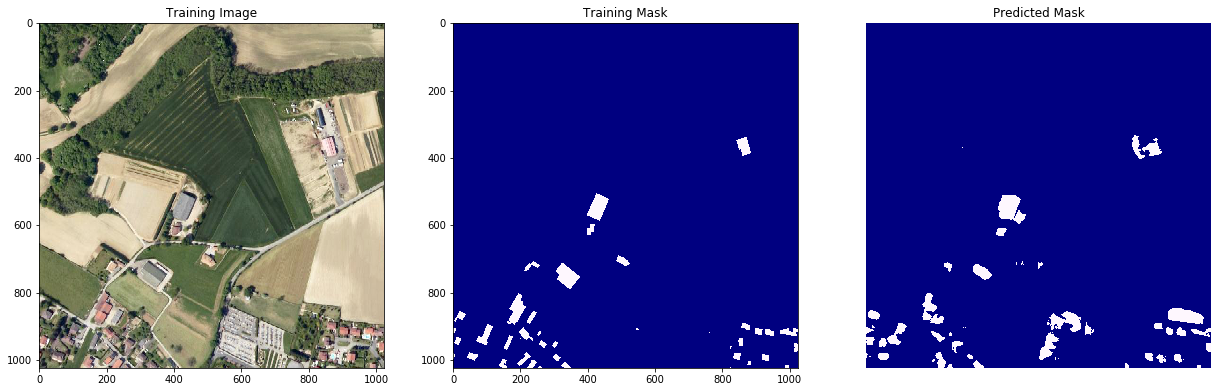

In [67]:
model = get_unet_5()
model.load_weights('unet5_c1_20.hdf5')
check_predict(model, 0.5, img_id=Image_ID[3], Class_Type=1)
